In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from IPython.display import display
import base64
import string
import re
from collections import Counter
from time import time
# from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS as stopwords
from nltk.corpus import stopwords
from sklearn.metrics import log_loss


stopwords = stopwords.words('english')
sns.set_context('notebook')
print('Numpy version:', np.__version__)
print('Pandas version:', pd.__version__)
print('Seaborn version:', sns.__version__)

Numpy version: 1.13.0
Pandas version: 0.20.3
Seaborn version: 0.8.1


Changed the stopwords from sklearn to nltk instead because after preprocessing the text with sklearn stopwords I noticed there were several text examples that had no text in them. Meaning that the text example (after lemmatization) was composed entirely of stopwords. I switched to nltk stopwords because it contains fewer stopwords (153) than sklearn's stopword list (318).

# Data Info & Visualization
---
## Load Training and Testing Data

In [2]:
# Load training and testing text
train = pd.read_csv('../input/train.csv', skiprows=1, names=['ID', 'Text', 'Author']).set_index('ID')
test = pd.read_csv('../input/test.csv', skiprows=1, names=['ID', 'Text']).set_index('ID')

# Delete the word 'id' from the ID columns
train.index = [id[2:] for id in train.index]
test.index = [id[2:] for id in test.index]
# Sort the indices
# train.sort_index(inplace=True)
# test.sort_index(inplace=True)

In [3]:
# Display first 5 training samples
display(train.head())
# Display first 5 testing samples
display(test.head())

print('Training sample:', train['Text'][0])
print('Author of sample:', train['Author'][0])
print('Training Data Shape:', train.shape)
print('Testing Data Shape:', test.shape)

,Text,Author
26305,"This process, however, afforded me no means of...",EAP
17569,It never once occurred to me that the fumbling...,HPL
11008,"In his left hand was a gold snuff box, from wh...",EAP
27763,How lovely is spring As we looked from Windsor...,MWS
12958,"Finding nothing else, not even gold, the Super...",HPL


,Text
02310,"Still, as I urged our leaving Ireland with suc..."
24541,"If a fire wanted fanning, it could readily be ..."
00134,And when they had broken down the frail door t...
27757,While I was thinking how I should possibly man...
04081,I am not sure to what limit his knowledge may ...


Training sample: This process, however, afforded me no means of ascertaining the dimensions of my dungeon; as I might make its circuit, and return to the point whence I set out, without being aware of the fact; so perfectly uniform seemed the wall.
Author of sample: EAP
Training Data Shape: (19579, 2)
Testing Data Shape: (8392, 1)


In [4]:
# Print some statistics about the training data
print('Training Dataset Info:')
display(train.info())

print('Testing Dataset Info:')
display(test.info())

Training Dataset Info:
<class 'pandas.core.frame.DataFrame'>
Index: 19579 entries, 26305 to 00393
Data columns (total 2 columns):
Text      19579 non-null object
Author    19579 non-null object
dtypes: object(2)
memory usage: 1.1+ MB


None

Testing Dataset Info:
<class 'pandas.core.frame.DataFrame'>
Index: 8392 entries, 02310 to 04282
Data columns (total 1 columns):
Text    8392 non-null object
dtypes: object(1)
memory usage: 131.1+ KB


None

According to the above output, there are 19,579 text samples in the training set and no missing values.
The testing dataset has 8392 text samples.

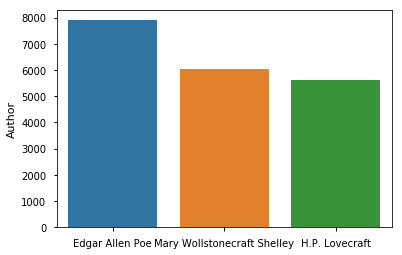

In [5]:
# Barplot of occurances of each author in the training dataset
sns.barplot(x=['Edgar Allen Poe', 'Mary Wollstonecraft Shelley', 'H.P. Lovecraft'], y=train['Author'].value_counts())
plt.show()

Edgar Allen Poe is the most frequently occuring author in the training dataset with 7900 occurances. Then it's Mary Wollstonecraft Shelley followed by H.P. Lovecraft with 6044 and 5635 occurances respectively. While there are more occurances of EAP than HPL and MWS there is still a good amount of data labeled with HPL and MWS so the small data imbalance shouldn't impact learning too much.

## Create Spooky Wordcloud
---
Font Credit: http://www.fontspace.com/david-shetterly/double-feature

To get the spooky font I encoded the font file in another python script using base64 library into an ASCII string format. The code for this is in the first hidden cell below. Then we can copy the encoded string into this notebook and decoded it into a newly created font file. This is in the next two hidden code cells.

In [6]:
# DO NOT RUN THIS CODE IN KERNEL
# This should be run on local machine with 'DoubleFeature21.ttf' file located in the same directory as this code
# font = open('DoubleFeature21.ttf', 'rb') # open binary file in read mode
# font_read = font.read()
# font_64_encode = base64.encodebytes(font_read)
# print(font_64_encode)  # print the encoded string to be copied into this Kaggle Kernel

In [7]:
font_64_encode = b'AAEAAAAUAQAABABAR0RFRgDRAMQAAfSkAAAAJEdQT1PEwvOGAAH0yAAAPWpMVFNI5DX1swAABaQA\nAADjT1MvMnXcNiMAAAHIAAAAYFZETVhobW+mAAAGiAAABeBjbWFwTkneDAAAIOwAAAT+Y3Z0IAAU\nAAAAACdkAAAAAmZwZ20GWZw3AAAl7AAAAXNnYXNwABcACQAB9JQAAAAQZ2x5ZhdQxEQAACdoAAFN\nGGhkbXgaf55dAAAMaAAAFIRoZWFk9bw+hAAAAUwAAAA2aGhlYQZ9A0oAAAGEAAAAJGhtdHjfuAFp\nAAACKAAAA3xrZXJuC2kdJgABdkAAAEXGbG9jYexgQjoAAXSAAAABwG1heHAC+AV6AAABqAAAACBu\nYW1l0zLcAAABvAgAADZ9cG9zdFuJPwcAAfKIAAACDHByZXC4AAArAAAnYAAAAAQAAQAAAAIZmWaJ\n/OpfDzz1ABkD6AAAAADJe2HgAAAAAMmGf8//nP21A/AEoQAAAAkAAgAAAAAAAAABAAAC7v8GAAAD\n9f+c/28D8AABAAAAAAAAAAAAAAAAAAAA3wABAAAA3wI1AAcBqgAEAAEAAAAAAAoAAAIAAZkAAwAB\nAAMCSAGQAAUAAAK8AooAAACMArwCigAAAd0AMgD6CA8DAAAAAAAAAAAAgAAALxAAQEoAAAAAAAAA\nACAgICAAQAAg8CAC7v8GAAAEoQJLAAAAAYAAAAAB9AK8AAAAIAACAV4AAAJJAAUCcwAEAnP//wFe\nAAAA8AAFARoAAwKxAAUCMQAEAlwABQCRAAUBGwADAS4AAQFuAAQBywADANkABQF3AAMA2gAFAbwA\nBAKGAAUBTQADAlkABQIpAAYCbAAEAh4ABQIxAAUCOgAFAg4AAwIwAAYA3AAEANn//QF9AAYBzQAG\nAYAAAwIFAAQC4AAFAuz/8wJNAAUCkQAFAkMABAJAAAYCGgAFArYABAJxAAIBSwADAjwAAQKvAAQC\nSAAFAxoABQJyAAICkAABAlwABQJcAAMCwQADAlYABQMBAAUCZAAEAowABQNuAAQCdQAFApwAAwJz\nAAQBAQAEAdEABAEIAAQBawADANAABALhAAMCTwADAooABAJGAAUCagAEAjQABAK5AAUCeQAEARAA\nBQI5AAQCqQAFAkoAAwMVAAUCigAFAocABQJEAAMCwgAEAnUABQJ7AAQC/wAFAo4ABgKgAAQDggAE\nAngAAwKcAAMCc///AS0AAgCmAAUBGAAFApkAAwDYAAUA4gAEAbAABQHHAAUBSAAFAW8AAwH9AAMB\n7AACAewAAgLEAAUCewAEAYAAAwPTAAUCnAADAPIAAQGIAAUCPwAFApwAAwCkAAUBpQAFAcgABQLE\nAAYCfwAEAXcAAwD+AAUBywADARUABQEAAAYA0AAFAi0AAgDaAAUBCQAEAJwABAKzAAMCSQAFAm0A\nBQJlAAYCCQAEAuz/8wLs//MC7P/zAuz/8wLs//MDzv/zApEABQJAAAYCQAAGAkAABgFLAAMBSwAD\nAUv/tQKDAAMCcgACApAAAQKQAAECkAABApAAAQHEAAQCkAABAmQABAJkAAQCZAAEApwAAwIGAAUC\nSQAEAuEAAwLhAAMC4QADAuEAAwLhAAMD9QADAooABAJqAAQCagAEAmoABAEQAAUBEAAFARD/sQKD\nAAMCigAFAocABQKHAAUChwAFAocABQH+AAMChwAFAo4ABgKOAAYCjgAGApwAAwIGAAUCnAADAsEA\nBQDiAAQB4gAFAccABQKrAAUBbwADAg0ABAPBAAICVgAFAX0ABgOeAAECDQAEAoMABALBAAUCwQAF\nASoABALs//MCQAAGAUv/ngKQAAECZAAEAuEAAwJqAAQBEP+cAocABQKOAAYBZwAFAwUABgLBAAUB\nUQACAgH//QFl//8DQQAAAn0AAgAAAN8BAQEBATcBAQFMAQEBHAEBAQEBAQEBAQEBAQEBAQEBAQEB\nAQEBTAEBAQEBLwEBAQEBOwEBAS8BAQEBAQEBAQEBOwE7AQEBAQEBATcrAQEBATcBAQEBIQEBAQEB\nATsBTDsBAQEBAQEBAQEBAQEBAQFMAQEBTAEBAUwBAQEBAQEBAQFEASsBTAEBAQEBAQEBAQEBAQEB\nAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEBAQEB\nAQEBAQEBAQEBAQEBAQEBAQEBAAAAAAEAAQEBAQEADAD4CP8ACAAK//sACQAL//oACgAM//oACwAO\n//kADAAP//gADQAQ//gADgAR//cADwAS//cAEAAT//YAEQAV//YAEgAW//UAEwAX//QAFAAY//QA\nFQAZ//MAFgAb//MAFwAc//IAGAAd//EAGQAe//EAGgAf//AAGwAg//AAHAAi/+8AHQAj/+4AHgAk\n/+4AHwAl/+0AIAAm/+0AIQAo/+wAIgAp/+wAIwAq/+sAJAAr/+oAJQAs/+oAJgAu/+kAJwAv/+kA\nKAAw/+gAKQAx/+cAKgAy/+cAKwAz/+YALAA1/+YALQA2/+UALgA3/+QALwA4/+QAMAA5/+MAMQA7\n/+MAMgA8/+IAMwA9/+IANAA+/+EANQA//+AANgBA/+AANwBC/98AOABD/98AOQBE/94AOgBF/90A\nOwBG/90APABI/9wAPQBJ/9wAPgBK/9sAPwBL/9sAQABM/9oAQQBO/9kAQgBP/9kAQwBQ/9gARABR\n/9gARQBS/9cARgBT/9YARwBV/9YASABW/9UASQBX/9UASgBY/9QASwBZ/9MATABb/9MATQBc/9IA\nTgBd/9IATwBe/9EAUABf/9EAUQBg/9AAUgBi/88AUwBj/88AVABk/84AVQBl/84AVgBm/80AVwBo\n/8wAWABp/8wAWQBq/8sAWgBr/8sAWwBs/8oAXABu/8kAXQBv/8kAXgBw/8gAXwBx/8gAYABy/8cA\nYQBz/8cAYgB1/8YAYwB2/8UAZAB3/8UAZQB4/8QAZgB5/8QAZwB7/8MAaAB8/8IAaQB9/8IAagB+\n/8EAawB//8EAbACA/8AAbQCC/8AAbgCD/78AbwCE/74AcACF/74AcQCG/70AcgCI/70AcwCJ/7wA\ndACK/7sAdQCL/7sAdgCM/7oAdwCO/7oAeACP/7kAeQCQ/7gAegCR/7gAewCS/7cAfACT/7cAfQCV\n/7YAfgCW/7YAfwCX/7UAgACY/7QAgQCZ/7QAggCb/7MAgwCc/7MAhACd/7IAhQCe/7EAhgCf/7EA\nhwCg/7AAiACi/7AAiQCj/68AigCk/64AiwCl/64AjACm/60AjQCo/60AjgCp/6wAjwCq/6wAkACr\n/6sAkQCs/6oAkgCu/6oAkwCv/6kAlACw/6kAlQCx/6gAlgCy/6cAlwCz/6cAmAC1/6YAmQC2/6YA\nmgC3/6UAmwC4/6UAnAC5/6QAnQC7/6MAngC8/6MAnwC9/6IAoAC+/6IAoQC//6EAogDA/6AAowDC\n/6AApADD/58ApQDE/58ApgDF/54ApwDG/50AqADI/50AqQDJ/5wAqgDK/5wAqwDL/5sArADM/5sA\nrQDO/5oArgDP/5kArwDQ/5kAsADR/5gAsQDS/5gAsgDT/5cAswDV/5YAtADW/5YAtQDX/5UAtgDY\n/5UAtwDZ/5QAuADb/5MAuQDc/5MAugDd/5IAuwDe/5IAvADf/5EAvQDg/5EAvgDi/5AAvwDj/48A\nwADk/48AwQDl/44AwgDm/44AwwDo/40AxADp/4wAxQDq/4wAxgDr/4sAxwDs/4sAyADt/4oAyQDv\n/4oAygDw/4kAywDx/4gAzADy/4gAzQDz/4cAzgD1/4cAzwD2/4YA0AD3/4UA0QD4/4UA0gD5/4QA\n0wD7/4QA1AD8/4MA1QD9/4IA1gD+/4IA1wD//4EA2AEA/4EA2QEC/4AA2gED/4AA2wEE/38A3AEF\n/34A3QEG/34A3gEI/30A3wEJ/30A4AEK/3wA4QEL/3sA4gEM/3sA4wEN/3oA5AEP/3oA5QEQ/3kA\n5gER/3gA5wES/3gA6AET/3cA6QEV/3cA6gEW/3YA6wEX/3YA7AEY/3UA7QEZ/3QA7gEb/3QA7wEc\n/3MA8AEd/3MA8QEe/3IA8gEf/3EA8wEg/3EA9AEi/3AA9QEj/3AA9gEk/28A9wEl/28A+AEm/24A\n+QEo/20A+gEp/20A+wEq/2wA/AEr/2wA/QEs/2sA/gEt/2oA/wEv/2oAAAAXAAAA5AkJAwUGBgMD\nAwYFBQEDAwQEAgMCBAYDBQUGBQUFBQUCAgMEAwUHBwYGBQUFBgYDBQYFBwYGBQUHBQcGBggGBgYC\nBAMDAwcFBgUGBQYGAwUGBQcHBgUGBgYHBgYIBgYGAwIDBgICBAQDAwUEBAYGAwkGAwQFBgIEBAYH\nAwIEAwICBQICAgYGBgYFBwcHBwcJBgUFBQMDAwYGBgYGBgQGBgYGBgUFBwcHBwcJBgYGBgICAgYG\nBgYGBgUGBgYGBgUGBgIEBAYDBQkFAwgFBgYGAwcFAwYGBwYCBgYDBwYDBQMIBgAAAAoKBAYGBgQD\nAwcGBgEDAwQFAgQCBAYDBgYGBQYGBQYCAgQFBAUHBwcHBgYFBwcDBgcGCAYHBgYHBggGBwkGBwYD\nBQMEAwcGBwYGBgcHAwYHBggHBgYHBgcIBwcJBgcGAwIDBwICBAUDBAUFBQcGBAoHAwQGBwMEBQcH\nBAMFAwMCBgIDAgcGBgYFBwcHBwcKBwYGBgMDAwYGBwcHBwUHBgYGBwUGBwcHBwcKBwYGBgMDAwYH\nBgYGBgUGBwcHBwUHBwIFBQcEBQoGBAkFBgcHAwcGAwcGBwYDBgcECAcDBQQIBgAAAAsLBAYHBwQD\nAwgGBgIDAwUFAgQCBQcEBwYHBgYGBgYCAgQFBAYICAgHBgYGCAgEBggGCQcHBwcIBwgHBwoHBwcD\nBQQEAwgHBwYHBggHBAYHBgkIBwYIBwgIBwcKBwcIAwIEBwICBQUEBAYFBQgHBAsHAwQGBwMFBQgI\nBAMFAwMCBgIDAwgGBwgGCAgICAgLBwYGBgQEBAcHBwcHBwUHBwcHBwYGCAgICAgLBwcHBwMDAwcH\nBwcHBwYHBwcHBwYHCAIFBQgEBgsHBAoGBwgIAwgGBAcHCAcDBwcECQgEBgQJBwAAAAwMBAcICAQE\nAwgHBwIDBAUGAwUDBQgEBwcHBwcHBgcDAwUGBQYJCQgIBwcGCAgEBwgHCgcIBwcJBwkHCAsICAgD\nBgQEAwkHCAcHBwgIBAcIBwkJCAcICAkJCAgLCAgIBAMECAMDBQUEBAYGBgkIBQwIBAUHCAMFBQkI\nBQMGAwMDBwMDAwgIBwgGCQkJCQkMCAcHBwQEBAgICAgICAUIBwcHCAYHCQkJCQkMCAcHBwMDAwgI\nCAgICAYICAgICAYICAMGBQgEBgwHBQsGCAgIBAkHBAgHCQcDCAgECQgEBgQKCAAAAA0NBQgICAUE\nBAkHCAIEBAUGAwUDBggECAcIBwcHBwcDAwUGBQcKCggJCAcHCQkEBwkICgkJCAgJCAoICAsICQgD\nBgQFBAoICAgIBwkJBAcJCAoJCAgJCAkKCQkMCAkJBAMECQMDBgYEBQcGBgkIBQ0JBAUHCQMFBgkJ\nBQMGBAMDBwMDAwkICAgHCgoKCgoNCQcHBwQEBAgICQkJCQYJCAgICQcICgoKCgoNCAgICAQEBAgI\nCAgICAcICQkJCQcJCQMGBgkFBw0IBQwHCAkJBAoHBAkICggECAkFCgkEBwULCAAAAA8PBQkJCQUE\nBAoICQIEBQYHAwYDBwoFCQgJCAgJCAgDAwYHBggLCwoKCQkICgoFCQoJDAoKCQkKCQwJCg0JCgkE\nBwUFBAsJCgkJCAoKBQkKCQwLCgkLCQsMCgoNCQoKBQMFCgMDBgcFBggHBwsKBg8KBAYJCgMGBwsK\nBgQHBAQDCAMEAwoJCQkICwsLCwsPCgkJCQUFBQoJCgoKCgcKCQkJCggJCwsLCwsPCgkJCQQEBAoK\nCgoKCggKCgoKCggKCwMHBwoGCA4JBg4ICgsLBAsJBQoJCwkECgoFDAsFCAUNCgAAABAQBgkKCgYF\nBQsJCgIFBQYHAwYDBwoFCgkKCQkJCAkEAwYHBggMDAoLCQkJCwsFCQsJDQoLCgoLCgwKCg4KCwoE\nBwUGBAwJCgkKCQsLBQkLCQ0LCgkLCgsMCgsOCgsKBQMFCwMEBwcFBggICAsKBhALBQYJCwMHBwsL\nBgQHBAQDCQMEBAsKCgoIDAwMDAwQCwkJCQUFBQoKCwsLCwcLCgoKCwgJDAwMDAwQCgoKCgQEBAoK\nCgoKCggKCgoKCwgLCwQIBwsGCA8KBg8ICgsLBQwJBQsKDAoECgoGDAsFCAYNCgAAABERBgoLCwYF\nBQwKCgIFBQYIBAYECAsGCgkLCQoKCQoEBAYIBwkNDQsLCgoJDAsGCgwKDgsLCgoMCg0KCw8LCwsE\nCAUGBA0KCwoLCgwLBQoMCg0MCwoMCwsNCwsPCwsLBQMFCwQEBwgGBgkICAwLBxELBQcKCwQHCAwM\nBgQIBQQECQQFBAwKCwoJDQ0NDQ0RCwoKCgYGBgsLCwsLCwgLCgoKCwkKDQ0NDQ0RCwsLCwUFBQsL\nCwsLCwkLCwsLCwkLDAQICAwGCRAKBhAJCwwMBQ0KBgsKDQsFCwsGDQwGCQYOCwAAABMTBwsMDAcF\nBQ0LCwMFBgcJBAcECAwGCwsMCgsLCgsEBAcJBwoODgwMCwsKDQwGCw0LDwwMCwsOCw8MDBEMDQwF\nCQYHBQ4LDAsMCw0MBgsNCw8NDAsNDA0PDA0RDA0MBgQGDQQECAkGBwoJCQ0MBxMNBQcLDQQICQ0N\nBwUJBQUECwQFBA0LDAwKDg4ODg4TDAsLCwYGBgwMDAwMDAkMDAwMDQoLDg4ODg4TDAwMDAUFBQwM\nDAwMDAoMDAwMDQoNDQQJCQ0HChILBxIKDA0NBg4LBgwMDgwFDAwHDw0GCgcQDAAAABUVBwwNDQcG\nBg4MDAMGBggKBQgFCQ4HDQwNCwwMCwwFBQgKCAsPEA0ODAwLDw0HDA4MEQ0ODQ0PDRANDhINDg0F\nCgYIBQ8MDgwNDA8OBgwODBEODgwPDQ4QDg4TDQ4NBgQGDgUFCQoHCAsKCg8NCBUOBggMDgQJCg8O\nCAUKBgUEDAUGBA8NDQ0LEBAQEBAUDgwMDAcHBw4NDg4ODgkODQ0NDgsMDw8PDw8VDg0NDQYGBg4O\nDg4ODgsODg4ODgsODwUKCg4ICxQNCBMLDg8PBhAMBw4NDw0GDg4IEA8HCwgSDQAAABgYCA4PDwgH\nBxENDwMHBwgLBQkFCxAIDg0PDQ0ODQ0FBQkLCQwSEg8QDg4NEQ8IDhAOEw8QDw8RDhIPEBUPEA8G\nCwcJBRIOEA4PDhEPBw4QDhMQEA4RDxASEBAWDxAQBwQHEAUFCgsICQwMDBEPCRgQBgkOEAUKCxEQ\nCQYLBwYFDQUGBBEODw8NEhISEhIXEA4ODggICA8PEBAQEAsQDw8PEAwOEhISEhIYEA8PDwcHBw8Q\nEBAQEAwQEBAQEAwQEQUMCxAJDRcOCRYNDxERBxIOCBAPEg8HEBAJExEIDAkUDwAAABsbCRAREQkH\nCBMPEAQICAkMBgoGDBEJEA8RDw8PDg8GBgoMCg4UFBESEBAPExEJDxMQFRESEBATEBUREhgREhEH\nDQgKBhQQEhARDxMRCA8SEBUTERATERIVEhIYERIRCAUIEgYGDAwJCg4NDRMRChoSBwsQEgULDBMS\nCgcMBwcGDwYHBRMQEREOFBQUFBQaEhAQEAkJCREREhISEgwSEREREg4QFBQUFBQbEhEREQcHBxES\nEREREQ4REhISEg4SEwYNDBIKDhoQChkOERMTCBQQCRIRFBEHERIKFRMJDgoWEQAAAB0dChESEgoI\nCBQQEQQICQsNBgsGDRMKERASEBARDxAGBgsNCw8VFhITEREQFBIKERQRFxITEhIUERYSExkSExIH\nDQgLBhURExESEBQTCREUERcUExEUEhMWExMaEhMSCQUIEwYHDQ0KCw8ODhUSCxwTCAsREwUMDRUT\nCwcNCAcGEAYIBRQREhIPFhYWFhYcExEREQoKChMSExMTEw0TEhISEw8RFRUVFRUdExISEggICBMT\nExMTEw8TExMTEw8TFAcODRQLDxwRCxsPExQUCRYRChMSFRIIExMKFhQKDwoYEgAAACAgCxMUFAsJ\nCRYSFAUJCgwPBwwHDhULExIUERISERIHBwwPDBEYGBQVExIRFhQLEhYTGRUVExMXExkUFRwUFRQI\nDwkMBxgTFRMUEhYUCRIWExkWFRMXFBUZFRYdFBUUCgYIFQcHDg8LDBAQEBcUDB8VCA0SFQYNDxcV\nDAgPCQgHEgcIBhYTFBMRGBgYGBgfFRISEgsLCxUUFRUVFQ4VFBQUFRETGBgYGBggFRQUFAkJCRUV\nFRUVFRAVFRUVFREVFwcPDxYMER8TDB4RFRcXChgSCxUUGBQJFRULGRcLEAsbFAAAACEhDBMVFQwJ\nCRcTFAUJCgwPBwwHDxULFBIUEhMTERIHBw0PDREYGRQWExMSFxQLExcTGhUWFBQYFBkUFh0VFhUI\nDwkMBxgUFRMUExcVChMWExoWFRMXFRUZFhYeFRYVCgYJFgcHDg8LDBEQEBcVDSAWCQ0TFgYODxcW\nDAgPCQgHEgcJBhcTFRURGRkZGRkgFhMTEwsLCxUVFhYWFg8WFBQUFhETGBgYGBghFRQUFAkJCRUV\nFRUVFREVFhYWFhEWFwcQDxcMESAUDR8RFRcXChkTCxYUGBQJFRYMGhcLEQwbFQAAACUlDRYXFw0K\nChoVFgUKCw4RCA4IEBgMFhQXFBUVExUICA4RDhMbHBcYFRUUGhcMFRkWHRcYFhYaFhwXGCAXGRcK\nEQoNCBsWGBYXFRoXCxUZFh0ZGBUaFxgcGBkhFxkWCwYLGQgIEBEMDhMSEhoYDiQZCg8VGQcQERoZ\nDgkRCgkIFQgKBxoWFxcTHBwcHBwkGBUVFQwMDBgXGBgYGBEYFxcXGRMWGxsbGxslGBcXFwoKChgY\nGBgYGBMYGBgYGRMZGggSERkOEyQWDiITGBoaCxwVDBgXGxcKGBgNHRoMEw0fGAAAACorDxkaGg8L\nDB0YGgYMDQ8TCRAJExsOGRcaFxgYFhgJCRATEBYfHxkcGBgXHRoOGB0ZIRocGRkdGSAaGyUaHBoL\nFAwPCR8ZGxgaGB0aDBgdGSEcGxgeGhsgGxwmGxwaDQcMHAkJEhMODxUVFR4bECkcCxAYHAcSEx4c\nEAsTDAsJFwkLBx0YGhoWHx8fHx8pHBgYGA4ODhsaHBwcHBMcGhoaHBYZHx8fHx8rGxoaGgsLCxsb\nGxsbGxUbGxsbHBYcHgkUEx0PFigZECcWGx4eDR8YDhwaHxoLGxsPIB4OFg8jGwAAAC4vEBsdHRAM\nDSAaGwcNDhEVChEKFB4PHBkdGRoaGBoKChIVEhgiIhweGxsZIBwPGiAbJRweHBwhHCMcHigdHx0M\nFQ0RCiIbHhscGiAdDRofGyQeHhsgHR0jHh8pHR8dDggNHwoKFBUPERcXFyEdEi0fDBIaHwgTFSEe\nEQwVDQwKGgoMCCAbHRwYIiIiIiItHhsbGw8PDx4dHh4eHhUeHBwcHxgbIiIiIiIvHhwcHA0NDR4e\nHh4eHhceHh4eHxgfIAoWFR8RGCwcEisYHiAgDiIbDx4cIhwNHh4RJCAQGBAmHQAAADIzEh0fHxIN\nDiIcHwcODxIXCxMLFiARHhwfGxwdGhwLCxMXExolJR4hHR0bIx8RHSIdKB8hHh4jHiYfISwfIR8N\nFw4SCiUeIR0fHCMfDhwiHSchIB0jHyAmISItICEfDwgOIQsLFhcQEhkZGSMgEzEhDRQdIQkVFyMg\nEw0XDg0KHAsNCCMdHx4aJSUlJSUxIR0dHRERESAfISEhIRchHx8fIRodJSUlJSUzIR8fHw4ODiAh\nICAgIBogISEhIRohIwsYFyISGjAeEy4aICMjDyUdESEfJR8OICESJyMRGhIqIAAAADY3EyAiIhMO\nDyUeIAgPEBQZDBQMGCMSIB4hHR4fHB4MDBUZFRwoKCAjHx8dJSISHyUgKyIjISEmICohIy8iJCIO\nGQ8UCyggIx8hHiYjDx8lICskIx8mIiIpIyQwIiQiEAkPJAwMFxkSFBsbGyYiFTUkDhUfJAkXGSYj\nFA4ZDw4LHgwOCSUgIiEcKCgoKCg1Ix8fHxISEiMiIyMjIxgjISEhJBwgKCgoKCg3IyEhIQ8PDyMj\nIyMjIxwjIyMjJBwkJgwaGSUUHDQgFTIcIyYmECgfEiMhKCEPIyMTKiYSHBMtIgAAADo7FCIkJBQO\nECghJAgQEhUbDRYNGiUTIyAkHyEhHyANDRYbFh4rKyMmIiEfKCQTISgiLiUmIyMpIy0kJjMkJyQP\nGxAVDSsiJiIkISglECEoIi4mJiIpJCUsJic0JSclEQoRJw0NGRoTFR4dHSklFjknDxchJwoYGikm\nFg8bEA8MIA0PCigiJCQeKysrKys4JiEhIRMTEyUkJiYmJhomJCQkJx4iKysrKys7JiQkJBAQECUm\nJiYmJh4mJiYmJx4nKQ0cGigVHjgjFjYeJSkpESshEyYkKyQQJiYVLSkUHhUwJQAAAENEFycqKhcQ\nEy4mKQoTFBkfDxkPHisWKCUqJCYmIyYPDxofGiMxMigsJyckLyoWJi4nNSosKCgvKDQpLDsqLSoR\nHxIYDjEoLCcpJi8qEiYuJzUsKycvKiszLC08Ki0qFAsTLQ4PHR4WGSIhIS8rGkItERonLQwcHy8r\nGREfExEOJQ8SCy4nKikjMjIyMjJBLCcnJxYWFisqLCwsLB4sKSkpLSMnMTExMTFELCkpKRISEiss\nKysrKyIrLCwsLSMtLw8gHi4ZI0AoGj4jKy8vFDInFiwpMSkSKywYNC8XIhg4KwAAAEtMGiwvLxoS\nFTQqLgsVFxsiEBwQITAZLSkvKSorJyoREB0jHSc3OC0xKysoNC8ZKzQsPC8xLS01LTouMUIvMi8T\nIxQbEDcsMSwuKjQvFCszLDsxMSw1LzA6MTJDLzIvFw0VMhARICIZHCYlJTUwHUkyEx0rMg0gIjUx\nHBMiFRMQKhAUDDQsLy8nODg4ODhJMSsrKxkZGTAvMTExMSIxLi4uMicsNzc3NzdMMS4uLhQUFDAx\nMTExMSYxMTExMicyNREkIjMcJ0gtHUUnMDU1FjgrGTEuNy4UMTEbOjUZJhs+MAAAAAAAAAMAAAAD\nAAADEAABAAAAAAAcAAMAAQAAASIAAAEGAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA\nAAQFBgcI3gkKCwwNDg8QERITFBUWFxgZGhscHR4fICEiIyQlJicoKSorLC0uLzAxMjM0NTY3ODk6\nOzw9Pj9AyEFCQ0RFRkdISUpLTE1OT1BRUlNUVVZXWFlaW1xdXl9pAIqLjY+VmZ6jotKlpKaoqqnT\nq62s1K6wsrHVtLO4t9a53HlwyXRlfqHLymp9dQCMmwB6AABy3QAAAAAA2swAp7aGb3cAvwAAdoLB\nAIeJmMdtZmdjZGFitQC8bgFgxmwAAMJ/vsDEzc6IkI6Sz5ORl9AAlp3RnADDaAAAANeAAADbAAQB\n7gAAAEQAQAAFAAQAJAAlAF0AXgB9AH4ArACuALQA+wD/AVMBYQF4AX4BkgLHAtoC3CAUIBogHiAi\nICYgMCA6IEQgrCEXISIiEiZl8CD//wAAACAAJQAmAF4AXwB+AKEArgCwALUA/AFSAWABeAF9AZIC\nxgLaAtwgEyAYIBwgICAmIDAgOSBEIKwhFyEiIhImZfAg////5AAA/+MAAP/iAAAAAAAd/8kAAP+9\nAAAAAP72/oX/LQAA/f39jOBTAAAAAAAA4JvglAAA373ftN/C30jeZtpzEJ0AAQAAAEIAAABAAAAA\nPgA+AAAAAABQAAAA2gDcAAAAAAAAANgAAAAAAAAA1ADYANwAAAAAANwAAAAAAAAAAAAAAAAAAAAA\nAN4AyABpAG8AcADJAHEAcgBzAHQAdQDKANoAdgB3AN0AfgB/AIAAgQDMAIIAgwCEAIUAhgCHAIgA\nzQCJAIoAiwCMAI0AjgCPAM4AkACRAJIAzwCTAJQAlQCWAJcA0ACYAJkAmgCbAJwAnQDRAJ4AnwCg\nAKEAogCjANIApAClAKYApwCoAKkAqgDTAKsArACtANQArgCvALAAsQCyANUAswC0ALUAtgC3ALgA\n1gDHAG0AxQBrAMMA2wBhAGIAvgBjAGQAwADcAMIAZQDGAGwABAHuAAAARABAAAUABAAkACUAXQBe\nAH0AfgCsAK4AtAD7AP8BUwFhAXgBfgGSAscC2gLcIBQgGiAeICIgJiAwIDogRCCsIRchIiISJmXw\nIP//AAAAIAAlACYAXgBfAH4AoQCuALAAtQD8AVIBYAF4AX0BkgLGAtoC3CATIBggHCAgICYgMCA5\nIEQgrCEXISIiEiZl8CD////kAAD/4wAA/+IAAAAAAB3/yQAA/70AAAAA/vb+hf8tAAD9/f2M4FMA\nAAAAAADgm+CUAADfvd+038LfSN5m2nMQnQABAAAAQgAAAEAAAAA+AD4AAAAAAFAAAADaANwAAAAA\nAAAA2AAAAAAAAADUANgA3AAAAAAA3AAAAAAAAAAAAAAAAAAAAAAA3gDIAGkAbwBwAMkAcQByAHMA\ndAB1AMoA2gB2AHcA3QB+AH8AgACBAMwAggCDAIQAhQCGAIcAiADNAIkAigCLAIwAjQCOAI8AzgCQ\nAJEAkgDPAJMAlACVAJYAlwDQAJgAmQCaAJsAnACdANEAngCfAKAAoQCiAKMA0gCkAKUApgCnAKgA\nqQCqANMAqwCsAK0A1ACuAK8AsACxALIA1QCzALQAtQC2ALcAuADWAMcAbQDFAGsAwwDbAGEAYgC+\nAGMAZADAANwAwgBlAMYAbAAAuAAALEu4AAlQWLEBAY5ZuAH/hbgARB25AAkAA19eLbgAASwgIEVp\nRLABYC24AAIsuAABKiEtuAADLCBGsAMlRlJYI1kgiiCKSWSKIEYgaGFksAQlRiBoYWRSWCNlilkv\nILAAU1hpILAAVFghsEBZG2kgsABUWCGwQGVZWTotuAAELCBGsAQlRlJYI4pZIEYgamFksAQlRiBq\nYWRSWCOKWS/9LbgABSxLILADJlBYUViwgEQbsEBEWRshISBFsMBQWLDARBshWVktuAAGLCAgRWlE\nsAFgICBFfWkYRLABYC24AAcsuAAGKi24AAgsSyCwAyZTWLBAG7AAWYqKILADJlNYIyGwgIqKG4oj\nWSCwAyZTWCMhuADAioobiiNZILADJlNYIyG4AQCKihuKI1kgsAMmU1gjIbgBQIqKG4ojWSC4AAMm\nU1iwAyVFuAGAUFgjIbgBgCMhG7ADJUUjISMhWRshWUQtuAAJLEtTWEVEGyEhWS0AuAAAKwAUAAAA\nAQAF/w4CRgLKAE4AABM+ATc+ATc+ATc+Azc2FhceAQcOAQcOAQcOAQcOAQcOAQcOAQcOAQcOARce\nARcWBgcGLgE2NTQ2Jy4BJy4BNTQ2Nz4BNz4BNz4BNz4B9xg1Hw0XDQ8YDwgLCg0KERoLCggHAwoD\nDisXLFEnFy8aDBYLDBsOFw4GAwYBAQUBAQELDwsBAwECAgYFBRIRDgYMBhEsEQsfDQ4bAYIlRSAO\nGA4PHxAIEhEQBgsJDQsUEAgMCCA8GzRuOSA+Hw8fEBAYDhg3Hw4bDxEfEAobBQgSHh0FFCQUESER\nEx0VFiYRCBEIFygaERwRESQAAP//AAT+qwJxBJYCJgA9AAAABwDbADQB5//////+CgJwBI8CJgBc\nAAAABwDbAEoB4AABAAX+6gDsAtcAhQBCugAvAIMAAyu4AC8QuAAg0LgAIC+4AC8QuAAx0LgAMS+4\nAC8QuABC0LgAQi+4AIMQuABt0LgAbS+4AC8QuACH3DAxEy4BNz4BJy4BJyY2NTQ+Ajc2Fjc2FhcW\nNjc2FhcWBhceAQcOARceAQcOAQcGFhUUBw4BBw4BBw4BBwYWFxYXHgEHDgEHDgEHDgEeAQcOAQcO\nARUUBgcGJyY2NzYmJyY2NTQmJy4BJy4BJy4BNTQ2Nz4BNz4BNz4BNzYmJy4BJyY0PQE0JgoBAQIB\nAgEBBAEBAQMIDw0KGQsOFA0MHAsLEwUIAgEBAwICBgQEAwMDAQICCQMBAwIEDggJGwICFQkVCgQH\nAgIHCwocCAYBAgICAgMFBAcBBQwIBgMCAgQCAgIBAgIDCAgVCBITBwMECgoHDggHDAQFDgsPHAoK\nBwHWCxYMChQKCA8ICBAIDR4dGAYFAgICCQMCAwQEDQoPIBALFwsQGhAQFg8QIhEOHQ4dHAYOBQkU\nBgcQDgwLAwgYCxgLEywQDhQRDRscHA4OHQ4MFw4HCQULDAobCw8bDg4aDg0dDAkTBgYCCBAvGQwX\nCw0LBwUIAwIECAwYBQcKEBAZESMdNwACAAMBXQEdAuMAHwBHAHy6ACUACAADK0EFANoACADqAAgA\nAl1BGwAJAAgAGQAIACkACAA5AAgASQAIAFkACABpAAgAeQAIAIkACACZAAgAqQAIALkACADJAAgA\nDV24AAgQuAAN0LgAJRC4AC3cuAAlELgANdy4ACUQuAA/0LgAPy+4ACUQuABC0DAxEy4BNz4CFhcW\nFAcGFRQOAgcGHgIHBiYnJjYnLgE3LgE+ATc2FhcWBw4BFRQOAgcOARUUHgEGBwYuATY1NDY1NCYn\nLgEQBAkEAx8mJQgOBQkHCgsEBgEDAgQFFAIFAgIGGYIDAgcRERgYDx8NBwYIDAwEBgMGAgYLCAgD\nAQQUBwMEAmERJxQPFAYJDhcjFyomCg4LCwgMGhkYDA4EChQnESZFOQ8gHRYFBw4PHScUJBQKDw0M\nCAsYCg4fHhkIBggPEwURIREbOhsOGgAAAAIABf8qAqwCzwDzAP8AABM2Jj4BNz4BMzIWNzYmNz4B\nNz4BNzYWFxY2Fx4DFRQWBw4BFx4BMzI2Nz4BNz4BNz4BNz4BNzYWFx4BFxYUFRYGBw4BFx4CMjMy\nFhcWFBceAQcOAQcOAQcOASMqAQcGFx4BMzI2HgEXHgEXHgEHDgEjIgYHBiIHBgcOAwcOAQcGFBcU\nBhccAQcOAScuATUmNicmNicuAScuAScmNjU8AScmBgcOAQcOAQcGFgcOAQcOAQcUDgInJjY1NDYn\nLgEnJgYHBi4BNjU+AS4BJyYiJy4BJyY0NzwBPgE3PgEzMhY3PgEnLgEnLgEnLgEnJjYFMj4BJicm\nBw4CFiYBAwEJDQscDgsdCQ0BAQIBBgQQCw0bDA0cDQgJBgIBAQEIBgIJBQcFBAYEAgIIBQICAwYf\nDRMmEQ4VAwECAwECBAIBDA8QBhEgCgcBAQEEBBQKChELCBAIBg0FDQkFEwcNHBgQAgIBAQEEAwMf\nDQ8eDgUOBQgGCAICCg8PBgICAQMBBAIWCAgDAQQCAgMJBxAIBg8FCQIJCxgCAwMICB0HBQUCARAD\nAQICBAcJBgkCAgQCAwcIAwUNDAQBAQEDBwgLHAwLGQcGAQYNDQwZDQsgCgUDAwMMBw0ZDAsbAgMG\nASYGCwYCBwgFBgcCBgHRDBgYFAcHAgIGCR4MECIPCxMEBAMDAwICAQwPEQcIEAgNGAwFBAYFCRcL\nCxUMBg0GDgQCAgECAgwOBAgFCA4IDhoNCAgDAxANJA8OJQ8LDAQEAwICBQMHCwUBAQYQEQ8fEA4b\nDw4LAgQCAgMLDRwbFwkJExERIxEPHw8OGw4KDQcGJAoRIBERKA8KEQgGCwgOJREKHAYIBw4RJBEP\nDw4MHQ0OFQ4MGwwEDAoEBQggCxoxGgYJAgIGAgUSGx0GCBYVEgUGAwMKCgsbDQocGxYEBAEDCAUQ\nBgYCAQIHBAMICwsbbgcJCwMDAgMKCggAAwAE/sYCLAMJAQIBDQEZAAATPgE3PgE3PgE3PgE3PgM3\nND4CMx4BNz4BFx4CFBceARceARceARceARcWFRQGBw4BBxUOAQcOAQcGLgInLgEnLgEnLgEnLgIG\nBwYWFx4BFx4BFx4BFx4BFx4DFx4BFRQWBw4BBw4BBw4BBw4BBw4BBwYuAjU0JicuAScmBgcGFgcO\nAwcGFBUUBhUUFhUUBgcGLgI1NCYnLgEnLgEnLgEnJjYnLgEnLgIGBwYWFxYGFRQWBw4DJy4CNDU8\nAScuAScuAScuAScmNjc+ATc+ATc+ATc2FhceAjY3NiY1NDYnLgMnLgEnLgEnLgEnLgEnLgEBFjY1\nNCYnJg4CAx4BNz4BPQEuAQ4BBgILBQUOCAsfEQ4dEAkRDwkBAgUKCgsaDQsXDAcGAwECDwgKFQoT\nKBMNGQUFAwEDAwIBCQgHBQcHCQgGAwcSBgYDCAUMBQUODgwCAwICAhUKDBQMBwwHCBEICw8KCQUG\nCQECAwcGBhwLCAkDBgIFAgcMCAkEAQEEAQMHCBsDAwcEAg0PDgMIAQEDDQkJBQECAwUHCAIFAgQL\nAgIHBQYeCgQLCwkCAgMBAQEBBAEFCAoGBQYDBAQOAgQTDAgOAgIMCwUJBQUKBQkTCxIeDwYODQwE\nBQMCBQURFRUJChIJDBcJBQkFCBMDAwYBYQMQAgQFBQMBqAISCAUBAQwNCgH8ECEPDhcLEBwJCAcF\nAgQHDAwHDgwGAQMCAggEAg0QEAYJAgEBAwMGCgcFEQ4NDQcJBhYqFwILDgkIGAYGAgkMBAgEBwcR\nBQQEAgEEAQQGCBgIDAsEBQ8GBAUFBgsFCBYZGgwOHg8PIhASIxEUGREMGw4ePh0LFwUDBw0QBRoz\nGggTBQYICgsWCwYGBQUFDBwPESIRDx0OCxsBAQkOEQYPHg4bORoFCgUJEAoKEQkLAwMBBAIEBwYP\nBggNCA4cDQQLCwUCAg8REgUNHAwLEwsUIxAKFAwOEQYCCAICAgIFDAICEQkDCgUECQwaDAwcCgoL\nBgUEBQgFBw0LBw4HCxkOECb+1AwJCgQLAgMFCQoBNQgSBQMTBwILBQYNAAAAAAMABf66AlsC4wCs\nALwA1QBYugBTAGQAAytBBQDaAGQA6gBkAAJdQRsACQBkABkAZAApAGQAOQBkAEkAZABZAGQAaQBk\nAHkAZACJAGQAmQBkAKkAZAC5AGQAyQBkAA1duABTELgA19wwMRMuAScuATc+ATc+AxceAxceARcW\nBgcOAwcGHgI3PgE3Njc2FhceARceARcWBgcOAQcOAQcGFx4BFxYGBwYHDgEHDgEHDgEHBiYnJjY1\nNCYnJjY0JicuASciBgcOARUUBgcGFgcGIicuAT4BJy4BJy4BJy4CBgcOARceAQcOAQcGFgcOAQcG\nFAcGJicmNjc2JicmNicuAycuAScmNjc2Nz4DNxQWFxY2Nz4BJyYnLgEOAQMeARceAjY3NiYnJicm\nJyYnLgEnJg4CjA0mCgsMDQw1IBIiIiUWEygkHwoSHwUCCgcJGhwcDAUMExYGBQgCCA8PHgwDBgMO\nHAYFAQcFDgYDAwQHBgscBQYXDA0FBwMCAgYCAQMHChEDAwQJAwMDCA8CAwICAwITGwQFAgIFBRMG\nBgIBAgECEAkFCgYHFRYUBw8FAgECBAMHAgIEAQEHAgINDg0CBQgFBQsHBQELCBQVFAYMEwIBDw0Z\nIAMREw1rFAgDBQQRDgsCBAcTEAwOAgwDBhITEwYEDgMIBwQDAgQDBQUGDAkGAUsaKB4kUyYjOhQL\nEwoCBgUWHSMQIEYkECUOExkVFg8GGRYOAwMNBQ0FBQ8IAgQCChsQCxoLCAsHBAYEBwYLGBAUIQ4Q\nEBQqFBUlFgkVBQgHCw4hDhEZDxAgHxwMAgMBAwEVLx0XJxUIGggICAgUFhYJDRAIBQ0DBAUCAwUL\nIRENFw0LEQsLEwsLEgkLEAMEEgsZMBcYKRcUJhMMExETDBgxGxYoESIdAwwNDrARHg4FAQMNKxID\nBAgEBg7+ngUMBAYJAgUHBQwDBwgGAgMDAgYBAQYKDAAAAQAFAWMAjQLmACcAABMuAT4BNzYWFx4B\nFx4BDgEHBhYHDgEXHgEXHgEHBiYnJjY1NCYnLgERAwkCExkSJg4CAgEKBQUIAgICBAYQAgECAgIG\nCwkTBAUDAw4QDwJdEConHwUEDAoCAQILIiUjDA8cDhYiFgsUCg0YCggFCwshDBolFRYuAAAAAAEA\nA/77ARcC9ABuAAATJjY3PgE3PgE3PgE3PgE3PgE3PgE3NhYXHgEXHgEHDgEHDgEHDgEHDgEHDgEH\nDgEHDgEVFBYXHgEXHgEXHgEXHgEHDgMHBhQHDgEXFgcGLgInLgE3PgEnLgEnLgEnLgEnLgEnLgEn\nLgEnJjQKBwYHBAoDAgMGDhcLBQ0HBhAHBAoHCg4IEScLBQICAgcCBQ8FAwgFBAUEBAkEBAICBw4G\nAQEDBQsNCQoaDQgNAgIKDA0EBQICAwUGEA8QCAQCBAoCAQYFBQ0JCRQHBxEFBwQHBw0EAwkCAgEv\nG0EaDRsODhsMHDcdDRULCxoJBQ0DBAUFDBQUCBkKCA0IEBgRCA8ICA8HCA0ICBAIHjofCREIDRgL\nFy8XGigXECYRCw0LCwkMIA4SJRIdEhERIycGCxUNDBQLDBkICQ4LCxcMDyEOEB4REB4QESEAAAAA\nAQAB/yMBKwLoAIAAABM0NjU0Jy4BJy4BJy4BJy4BJy4BJyY+Ajc2Fjc+ATc2HgIXHgEXHgEXHgEX\nHgEXHgEXHgEXHgEHDgEHBhYHDgEHDgEHDgEHDgEHDgEHDgEHDgEHDgEHBhYUBgcGLgE2Nz4BJy4B\nJyYnJjY3PgE3PgE3PgE3PgE3PgE3NiY3PgF5AQYCAQIEEQwFAwUFDAYKFgIBCQ8SCAoUCggPCQoQ\nDgsFCBEGBgUFBg4GBgUEAwkBAgICAgUEAgUBAQEDAwcCAgMCBQUEBxAOBxIMBg0HDgUFBQ4FAwEI\nDREPAwMBAgIFAgoHDQgHDgUFCQUFDQUCCAMKCwUCBQEBAgICCQE/CxQLEhQJEgkaJxcIFQkKEgkP\nIRQJExALAwMCAwIKAgIECg0HCxQMDRsNEB0QER8RDhkOESEREiESCBAICBIIBwwIBg4GDh4OGzUX\nCxoHAwUDBxANDBQLCSEhGQMDGSUnCQ8fDggHBQgRDQ0LCxkLCxQLBQkFESYUBw0HCA4IDRUAAQAE\nARoBaQLDAGsAYLoALwA6AAMrQQUA2gA6AOoAOgACXUEbAAkAOgAZADoAKQA6ADkAOgBJADoAWQA6\nAGkAOgB5ADoAiQA6AJkAOgCpADoAuQA6AMkAOgANXbgAOhC4ADLcuAAvELgAbdwwMRMmNjc2FhcW\nNjU0Njc+ATc2HgEGFxY2Nz4BFxYGBwYeAQYHBicuAwcGFhceARcWBhUUBiciJjQ2NTQmJy4DBw4B\nBw4BBw4BFRQOAicuAT4BJy4BNz4BNzYuAQYHBhYHBiYnJjYnLgEGAhYUER4RGAwECwYOBxUQAgQD\nBB0SFCULEAEKBQEBBQkJCggCAgcLEQMIChYBARAFFwQDARUNBQ0PDwYJDAsJEwUFAwEDCQcHBAEB\nAQQICggWBgQJDxADAwEHBxECBQMDAxACNxUQAgEMBQYWFg4oCgUEAgQWIiUKDgUICAkMEywUCRUV\nEgUFBQQVFhACAxQLDiAREyISExoCEBMRAxQQDQURDQQHCxcLCAsMCxoNBAsKBAQEFhsZBhMbEw4Z\nEAoMAggJBxIEBQoHDBoMCw4AAQAD/90BxQJHAH4Ag7oAPgBeAAMruAA+ELgAH9C4AB8vQQUA2gBe\nAOoAXgACXUEbAAkAXgAZAF4AKQBeADkAXgBJAF4AWQBeAGkAXgB5AF4AiQBeAJkAXgCpAF4AuQBe\nAMkAXgANXboAUgBeAD4REjm4AFIvuABI3LgAXhC4AFvQALgAFC+4ABcvuAAaLzAxEzYmNz4CFjMy\nNjc2JjU0Njc+ATMyFhcWNhceAxUUBhcWMjsBMhY3NhYXFBYUBgcOAiYHBi4BBgcGFhUUDgIHDgMV\nHAEOAQcGLgE2NTQmJy4BJy4BNTQ2Jy4BJy4BJyYOAgcOAQcOAQcGLgE0Jy4BJy4BJyYnJjYIAQYF\nBxodHQwLHAgKAQUEBBEUCA0HCBEHCgoEAQMFBRgLAhEgERUSAQEBAwQRFRQHCBMTEgYIBQIJFRIF\nBQMBAgYHCwoDAQMFAgQEBwQCAgEFAQEFCAkPCwgCAgEBAQEHCgkDAQIFBwgXCQsCAgIBdQgRBgoI\nAgICCAogDBEfEBEQAgEBAwIDFxscCAsdCw0GAQITFAYTFBMFCAUBAQEBAwEEBggaCg8qJyAEARcc\nGQQIEhIQBQgIEhUFFiYUCRAIEBwRCRQJCA8IChQGBwYOEwcIFAkHFwMFCxIUBAsXCgwECQsQCxQA\nAAEABf7iANgArwA6AAA3NDY3PgEXHgEXHgEXFgYHDgEHDgEHDgEdARQGBw4BBxQOAicmNicuAScu\nAScmNjc+ASc0LgInLgEFHBETNRgMFQkHCAQJDwUDDAcFCgkKDQMBAgIBBgkKBQYFAQICCgMKBAcJ\nBQUCAQkNDgYJDEYYJg4QDQkFBgsJFgsaOBkQHQ8NGQsMEREbBwoHDBcNBQwJAQgKIgsYMhcHCwYL\nEQsKFAsKDQoKBggXAP//AAMAZAFyAZACBgB4AAAAAQAF/z4A2ADFADcAADc+ATc+ATc2FhceARce\nARcWBgcOAQcGFhcWBgcGFhUUDgInJjY3NiYnLgEnLgEnLgEnLgEnJjQMBScVCxcLDBsLCwkEBAoC\nBBMOBhECAgQCAgcBAQUEBwkFCAcBAgMIAwcCAgMCBRUMDRYKE4AXGQYDCgEBBQYGGAsJFQsZNRQJ\nCQwNGwwOFw0LFQsFCwcCBggfCQ4XDAUIBQUMBg4OBgcQCxY9AAAAAQAE/rEBugLTAFoAaLoARABS\nAAMrQRsABgBEABYARAAmAEQANgBEAEYARABWAEQAZgBEAHYARACGAEQAlgBEAKYARAC2AEQAxgBE\nAA1dQQUA1QBEAOUARAACXbgARBC4AEHQuABBL7gAUhC4AFXQuABVLzAxNz4BNz4BNz4BNz4BNz4B\nNz4BNz4DNzYeAhceARcWBgcGBw4BBw4BBw4BBw4BBw4BBw4BBw4BBw4DBwYWFRQGFRQeAQYHBiYn\nLgEnLgE3NiYnLgEnLgEJCh8PCAkHCBMIEBYRCxoJCA8LBw4PFA8IDw8OBw4bBQcQCQsODgsJCRwM\nCxAODAwJBRAFAwYFDQsIAwsNDQQLAwICAQMGCBMIBwQCBwEBAQYCAgsLCAVGHz8bDiEPESMRIEog\nFikXFCMSCx8eGAUDBQkLBAgSDxkmFRoXFTEXGC4XFi8XFCoWDhgOCA0IFC8XCA0LDAcSLRQVJhUL\nGRoZCQwBCgoZDCJLJBMlEhUYEA4lAAAAAgAF/vsCggLBAIoAqwAPALgAGi+4AB0vuABPLzAxEyY+\nAjc+ATc+ATc+ATc+ATc+ATc+ATc+ATc+ATMyFhceARceARceARceARceARcWBhUUBgcOAQcOAQcO\nAQcGBw4BBw4BBwYWBw4BBw4BIyImJy4BJy4BJy4BJy4BJy4BJyYGBwYWBw4BBw4BBwYHDgEuAScu\nAScuAScmJy4BJy4BJy4BJy4BJy4BNxQGFx4BNz4BNz4BJy4BJy4BJyYGBwYiIyIGBw4BBwYWCwYC\nCxAJBhYGBAUDBA4GCQ0NDRoOCAwIChQKBgoGFycWCxQJEx4PEiYOCxYMFBYEAgkDBQUHCA0bDQgY\nCwkDAgUCBAMDAgMCAgUCAgYODA0HCA4GBQQBAQUEAgYGCBQLEhcDAgQHBxQHCAECAQYCDA4MAwcB\nAgMIBwgEAgIJChgLDBMFAgQEAwn4BAMFJB0OCwQFBgEBAwMECA0JEAgECAUNBQICAwEBAQEHGTU1\nNBcRGQ8IEQgKEQgMHAkJEAgFCQIDAwICAwMHAwcFCyAQEiQWEyYRHj8jFy4XEBwODx4OFCcUDA8K\nBw0IEQgUJxMPIA8OHA4LExkKCxIOCxkOER4RCBMGCAECAggUDh8NDRINDhgODw0FAgIGBQseDR04\nHCEkDhsNDhgNECAUChQKChVUDhoOFyUEAhINDRkODBoNDiMJBg4FAgoLBQwFBg4AAAAAAQAD/mAB\nSQLbAJsAABM2Jjc+ATc+ATc+ATc+ATc+ATc+ATc+ATMyFjc+AR4BFx4BFx4BFxYGFRQGFxYGFx4B\nBw4BBwYWFRQGFx4BFRQWBw4DBw4BFx4BBw4BBwYWBwYUFRQWBw4BBwYuAicmNCcuATc+AScuATc+\nATc2JicmJy4BJy4BJy4BJyY2Nz4BNz4BNzY0JzQ2LgEHDgMjIiYnLgEnJjYIAgQEAgcEBQcFCA4G\nCQgJBQcCAgIFCyYMDhwNDBwYEQIBAQICAQEBAQgDAwIDAwMCAQUBAQEBAgEFAQYDCw4QCQsOAgIF\nAQIJAgMHAQEBAgIECAcLCAYBAgIDBwEBBAICBgICAQICBwgHDwgRCAoKAgIEAgIDAgICAgICAgQB\nAgIIDAUHBgcGBwYFBQoFCgQB9Q8iDgcJBQYNBQcJCAoXCAUIBgUMAwgFAgICAwYSEwgOCAgPCAsW\nCxYuFxo3GxcuGAkSCAgSCBIlEQ8bDxcxFwwOCQYEBRoPCxMMDRYMEyUUFiwXCxEKCwkGBQMKEQgI\nDggJDgoLEwsLFg4RIhEUKBESCwcECAkZDhEhEREiERQsFRAeEBgwGQcXFg4CAQgIBwcEBQIDBh4A\nAAABAAX+uAJUAswA7gAHALgAFy8wMRM0Nz4BNz4BNz4BNz4BNz4BNz4BNz4BMzIWFx4BFx4BFx4B\nFx4BBw4BBw4BBw4BBw4BBw4BBw4DFxY2Nz4BNz4BFx4BMzI2NzYXHgIGBwYUBw4BBwYWBw4BFRwB\nDgEnLgEnLgEnLgEnLgEnLgMHBhQHDgEHDgMnLgEnLgMnJgYHBiYHDgEHDgEHDgEHBhYHDgEHDgEH\nBi4CNSY0Jy4BJyY0Jy4BJy4BNz4BNTQ2Nz4BNz4BNz4BNz4BNz4BNz4BJy4CBgcOAQcOAwcOAQcO\nAQcOAycuAjYnJjYnLgEnLgEFEwgRCAkNCwoRCwcOBgYIBgwfDx07HhEeDxEeCAYLCQwbCxEbAgEH\nBQIDAwMUCQ0hDw4SCwILCQIGBRAFBw0GCA4IBgoHBwgHDA0ODwQCAgEBAwMCAgEBAgwGDg0JCwMF\nBQMDAgIDAgQBBAcKBwkCAhAFAwMECgkKCAQCBAYLCAgJCAsUCwwLCAoWDhsOAwICBQICAgIGBwYL\nBwUBBgUOAgICAggLCQ8BAQQDBQgSCAcNCQwYDRcuGho3FxAZBwMUGhoKFi8LBQMECgsMDwUFBwgE\nDRESCgwJAQIBAgQEAggJCAgB4hkTCBIICRQICBQHBQQFBAcECAoFCBgEBQYMEg4dDBEfEho5IBcu\nFgwYCwsTCAsOCAcPCwILDAwDAgUBAgMBAQECAgYGAgQCAhMbHAoDBgMMGQsRIREgQCAHHRoPBgQY\nCQwaDA0bDQ8fDgUNCQMFBxwKCggIBRMQBwcHGwsGEhENAgIGAgIHAgIbCQwOBgwvGxAeEAcOBwoW\nCAcBCQ4GFisVEiQTDRoODxULCBMOCxMLCxAIDBYLCxMJDBkLFSkREiAXDycYDA0FAQIFEhYKFxcT\nBgYMDgwYCwYZFxACAxYcGwkaMhoOFQsLGgABAAb+/QImAswA0QAHALgAby8wMRMuATc+ATc+ATc+\nATc+ATc2FhcWNhceARceARceARcWFx4BFx4BFRwBBw4BBw4BBw4BFx4BFx4BFx4BFx4BBw4BBw4B\nBw4BBw4BBw4BBw4BBw4BBw4BBwYuATY1LgEnLgEnLgEHDgEHBhYHDgMjIi4BNicmNCcuAScuAScu\nAScuAScuAScuATU0Njc+ATc2FhceAzc2NzYmNzQ+ASYnJgYHBicuAScmNjc+ATc+ATc+AScuAScu\nAQcOAQcOAQcOAQcOAQcOAycuAScmNicFCQgEDAgJDQsOGA0OHw4fPyAOFw4NGwsKEQsIDwcJBgUK\nBQUIAgIFBgURCAkJCAUHAwMIBQgKAgUFCQUKBQUQCAsUDAgPCAgFBAUGAQEDAQEDEAwLAwEBAgIE\nERcKGQgGAwIDAQQBAwcNCw4NAwEBAgIBBQcDBQUFCwUNGg4JFwYLBgIPCBwLGjgUCg8RFQ8WCwgC\nAgUBAwcLFAoWEAkCAgICBwciExUhCQMBBwUNBgwVDhowFQsQBAICAgIGAwMGBwkHCRACBQECLREo\nFAkJBQUPAgMHBAUGBAgDAgECBAQECAcRBwUJBwkMCxcLCxENDhkODiEOCxMICA0LBgsHCAcFCRcL\nGTEYDh8ODhYLESMRChEJCBQKDRoOCxYLDRwCAg4VFwcNGA0bKREHCA4LGQ0aNhoIGhkTFh4fCRo2\nGxEbDgcLBQQEAwgPCAYNCxEpFBMiDggGAQITEAgTEAkCAxMMFQ4EDQsJAQINAgYTCxoOFCcSExUE\nBRoUBggDAgIDBQcBAhUNBxAMBQwGBQcFBQsHAQYIGgwaNgACAAT+pQJoAtQArwDAAFy6AGkAggAD\nK0EFANoAggDqAIIAAl1BGwAJAIIAGQCCACkAggA5AIIASQCCAFkAggBpAIIAeQCCAIkAggCZAIIA\nqQCCALkAggDJAIIADV24AIIQuAB/0LgAfy8wMRMmNjc+ATc+ATc+ATc+ATc2Nz4BNz4BNz4BNz4D\nFx4BNz4BFzIeAh0BFBYVFAYVFBYVFAYXFB4CFxY2NzYWFx4BFxYGBwYUBw4BJy4BJy4BBw4BFxYG\nBw4BFx4BFRQGBw4BBw4BFRQWBw4BFx4BBw4BBw4DJy4BPgE1NDY1NCYnJjYnLgEnJicuAScmPgE0\nJy4BIyImBw4BBwYWBw4BJyY0Jy4BJy4BJyY0NwYUFxY2Nz4BNCYnJgYHDgEJBQcOChMHCBAIBQ4G\nAgcCCQYFCAYHDwYLEwoIFRobDg4aEA4aDggMCQQEBAIEAgECBQUNIg4LHgkICwECBgIBBQUMDgsO\nDQsXDBEIAQECAwICAQEDBQkFDQMECAMCAQMCAgIBAgQCAQUMEg0GAwEDAg4EBAwEAxYMGg4IBgEB\nBQUGBRsLDh0PECUHAwEDBRMIBQUGBgICCgMD2AgOChAEAQMCAwcIBAQIAUYUJA4JFAsLFQsGFAQC\nDAMJDAgRCAgMBwwYDQoZFA0BAQkBAQMBDBASBiAPHhELFgsIDggPHA8FDQ0KAwcGAgEBCAgaCxEf\nEQsaCwoRBgUQAgICAgMOEQ4bDQcLBwYMBxUqEwkOCw0bDhEgEQkTCQgOCA4aDgciHg8OBhQYFgcW\nKxYVJBQUJhQODQYOGg4bEAwcGxoMCgIDAQEJEQgUCQsHCwgVCAsNDAsSCwsZaAgPAgEHCgMKDAkC\nAw8EAwQAAAEABf8NAhoCzgD3AAsAugAnAEsAAyswMRM2JjU0Njc2Jjc+ATc2JjU0Njc+ATc2FhcW\nNjc2FhcWNjMyFhceATMyNjc2FhcWFBcWBgcGBwYXFgYVFAYHDgEnLgEnMhcGJicuASMiBgcGJy4B\nBw4BBwYWMzI2Fx4BFx4BNzYWFx4BFx4BFx4BBw4BBw4BBw4BBw4BBwYWBw4BBw4BBwYmJyY2NTQm\nNzY0Jy4BJyYGBwYmBw4BBw4BBw4BBw4BBwYuAicuAScmNicuAScuAScuAScmNicuATU0NjM6ATc+\nARceARceARceATc+ATc+AScuAScmIyImIyImJyYOAicuAQcOAQcGJicmNjU0JicuAR4CAQcBAQMC\nAgQCAwIEAgIICw0bDhEeEBQrFAsSCggOBwwYDAwVDBElDgsBAQEBAgIHBQMEAgUDDAcGBggBAQ4X\nCQsUDwgKCCAfChUMCBIBAhYLBw4GCAsIESQRKDcUBg4HCA4CBAMKCBEVDxkVDhkEAgICBAUCAgcE\nBAYDBRACAQIBAQECAQMICBMLDBoMDAMCAgUDAwICAgIFBQkIBgEHBQIBAwICGhQNGQoSBwIBAQIB\nBRsLFi4WBQwGBw8GBQcFFEIdCAgEBQMFBx4NGBkHDAcICAcGCgoLBgsNDg0KCAsOBAIBBwQLAwGz\nCA8ICA4ICAoIBw0IChQKDh0ODiUJCgwDBAcDBAICAQUEAgIEDQIDBQsIGQwIEAgKBxkXDBkMDhsO\nCAcGBRADAQEDCAkTBQMLEAUIAgIJCQ4PAgICCQIFAwIEKyAJEAkLIQ4eQx0aNRQOFwcFFg8IEwkR\nIhIMGQwMGAwPBA4HDAYUJhMPHw8OGgwMAwQEBQUFFwsNGA0NGQ4IHAcGAQkMBBcyFxAeEBcfDAgQ\nCxQvGgcNBgULBQ4KAwEDAgIKBAQJBRcPDgQOBwcMCA4NBQcBAwMDAwQBAwYUAgIOCAgLCgYJBQgN\nBhIsAAAAAgAF/twCKwLPALoAywBougCBAKkAAytBGwAGAIEAFgCBACYAgQA2AIEARgCBAFYAgQBm\nAIEAdgCBAIYAgQCWAIEApgCBALYAgQDGAIEADV1BBQDVAIEA5QCBAAJduACBELgAftC4AH4vuACp\nELgArNC4AKwvMDE3JjY1NDY3PgE3PgE3PgE3PgE3PgE3PgE3PgE3PgE3Njc2Fx4BFx4BFx4BFx4B\nBw4BBw4BBw4BBw4CJicuAScuAScuAQcOAQcOAQcOAQcOARcWNjc+ATc+ARceARceARceARceARcW\nFAcOAQcOAQcOAQcOAQcOAQcOAQcOARceAQcUDgIHBiYnLgE1NCYnLgEnLgEnJgYHDgEHBhQHDgMn\nLgEnLgE1PAEnLgEnLgEnLgEnLgEnLgEXDgEXHgEXHgEzMjYuAQcOAQYBAwMGBQgDAwgIBw4ICAsJ\nCBULBQcFCRILDBwOHiMkHhEnDxAgDggOBAICAQEHBAUJBgcEBQIJCwwEBwwLDBkLCxQOCwsICBML\nCAYEAgsCAhUGDhwPDx0PFScQCRQHCA0ICAwCAgQDCQsGDwYFCwcLFw8OFwUFBAICBQEBBAEBAwcI\nCxUFBQIFAgQBBQIEDg0PAwgKBQQIAgUICwcNAgIEBwIFDRIHFQoLEQkLAgICCuwDBgsFCwYGDwYR\nDgITEBEY/xEiEREkEQ0ZDA4dCwsVCw0cDQsPCwUJBQgTBgYIBQkDBQkFDQwMFg8IFAwFCQUJEggL\nEwkLFgsFCwUBBwoPBQUIBwcIAwIOCAgKBQMKBwUMBQkHAgYDAQEEAQESDwkRCwsZDAsfDhYrFREn\nDggNCQgQCAwOBgURDg8jDg4dDw8eDwgUFRIEBgkLCh0LECAQHDcbDBcEBBMLGjkbGTMXBQsIAwQH\nHQsRHBEPHhElTyENEwoLGQsMHA4QHBMNGQsFAwIBBSQrIgMDHAABAAX+xAI1AtcAsABougBVAGoA\nAytBGwAGAFUAFgBVACYAVQA2AFUARgBVAFYAVQBmAFUAdgBVAIYAVQCWAFUApgBVALYAVQDGAFUA\nDV1BBQDVAFUA5QBVAAJduABVELgAUtC4AFIvuABqELgAYdC4AGEvMDETJjQnLgE3PgEzMhYzMjY3\nNhYXFjI3PgEXHgEXFjY3PgE3NjIzMjYXHgMXHgEHDgEHDgEHDgEHDgEHDgEHDgEHDgEHBgcOAQcO\nAQcOAQcGFgcGFBUUFgcOAScuAScmNjU0JicuATc+ATU0JicuAScuAScmNjc+ATc+ATc+ATc+ATc+\nATc+ATc+ATc+ATc+AScmBicuAScuAQcOAQcOAQcGLgInLgEnLgEnLgEnJjYLAgECAQoLHhAIDQgK\nEAkSIREQJg8IDQgLFgwNGg4HDQcLGAsKGQgNDwcDAgIHAQENBgYLAgIOCQgPCAgOAwICCAsNBQkN\nBgsCBREUCwsECAMCAQEGBRYLCQECAgQEAgEDAQEDDggHCQUGDAQFBgEBBwMDBgUFDgUDBAMCBwID\nDAQDBQIFBwYECQoKIAsQHRAJEwoIDQQCBAUGCggHAwULBQUCAgQNAgIBAk8LFwsNJwsMAwEGAgQG\nAwMDAgMBAgYBAQEDAgQBAgQHCyAkJQ8OGw4LEwkLFgwRHg8NGg0MHQ4NEQwOGREZFgsSDBstFAsV\nECJFIw4cDg4cCwsNCggbDBEhEQ8dDgcQCAYNBw4TCggQCAgQCxAgEQ4YDQwaDAwUDQgRCAcMBwkQ\nCQgSCQ8fDwkZCAcCAQEGAgIEAgITCAQKAgIECQoDBQQFBQoGChELCxcAAAMAA/53AgkCzwCyAMAA\nzgAAEzYmNz4BNz4BNz4BNz4BMzI2Fx4BFx4BFx4BFx4BFxYXFhceARcWBwYUBw4BBw4BBw4DFx4B\nFx4BFx4BFx4BFx4BFxYGBw4BBw4BBw4BBw4BBwYWBw4BBwYuATY3NiYnLgEnJgYHBiInJgYHDgEH\nBhYVFAYHBhcWFAcGLgInJjYnLgEnLgE3PgEnLgEnLgMnLgEnJjY1NCY3PgE3PgM3PgE3Ni4CJy4B\nJyY2Nx4BNz4BJy4DBw4BEzQuAicjDgEeATc+ASQCBAUEEAgFDgUQJRYMFA8RHhETIhIJCwgFDQUI\nEggPCwQBBRMECAYEAgEJBQURDQMMCAEHCREJBQoEBQUEBQYEBwgBAQUFBBIJDRoSEAsCBgsCAQEC\nAgUIERAGAgEDCAgDBgYFDAgHDwgLCAIEFQUEAgIHDQMBCAYLBwYBBAICAgcCAgQCAgMFBw8FAwEC\nCAoRFwgIBAECAgYCAQYKEAsIEAYGAgkMBA4PBQUCyQUVDg4RAwILDxMMCgZIBwwOBwYMCQYUEAkP\nAfUOHQ0MGQsHCAcUJA4IBggCAgsDAgEGBAgFCBAKExMGAw0WDRYVDBoMDBMLDRAGAgUHBwQFCQYE\nBwUGDgYIEQgRIxIRGxAPFgwRFgoJGBAmUSgOHA4JGgUJIDAwBx0yGgoWCAgBAgIBAQsIDhEODh8O\nHTwaMTYLHQcFAQcMBg4gDw8dEA4aDg4cDhcuFwwZGBUJDiMUESUSCAwICRIJChkYFAUEAwUGCAcG\nAggmDxAfCgsOAgIODgkXDgEMChP+5gYNDQkBAiAhFggFGgAAAgAG/xgCKwLOAJEAqAAHALgAEy8w\nMRM0Njc+ATc+ATc+Azc+ATc2MzIWFx4BFx4BFx4BFx4BFx4BFx4BBw4BBw4BBw4BBw4BBwYHDgEH\nDgEHDgEHDgEHDgEHFBYOAQcGLgE0NzYmJy4BJyYnLgMnJjY3PgE3PgE3PgE3PgE3PgE3PgEnLgEO\nASMiJgciDgIHDgEnLgE1NCYnLgEnLgEnJicuATceATc+ATc2JicuAScuASMiBgcGBwYUBgIDAgkF\nBQwFBhgeIA4OHQ4bHxovGRYwDgUJBQYOBQoOBwkHBgUBAQIGDwMFBQUGAgUHBwwSCxgODxQQCwoD\nAwMBAQYBAgIICwwNBQECBwgFAgUFCAYODAkBAgQFAwkEBQUECAYIBQ4GDA4LAggBARUaGAQOGQ4I\nDAsJBAUPCQsFBggHEggFCAUPCAYB6gkhEQcSBAUHBQUFBgUMBgkOCAUDCAHIDhwNCxYLDh0ODhgS\nDwUGCAYKEwQECxMHDwcHCgcMGQ0TKBQRHREmSCMHCwYFCQYOGQ0WGBAgDQ4iDgkUDQ0aDg4YDQkc\nGxYDAxEbHAgaKhcOGw4NCAYJCgwKChsIBQUDBQsFChgKCAwHDB4MAgsEBAEBAggBCw4PBgYIBQUV\nCgwaCggLCAYOBhARDBcLEQQHAwcHCBAFBQwFBAEHAwIDCBkAAAAAAQAE/8MA2AJDAFgAABM0Njc+\nARceARceARUUBgcOAQcGBw4BFx4BFxYXHgEXFgYHDgEHDgEHDgEHBhcWFAcOAScuAT4BNTYmJy4B\nJy4BJy4BJy4BNz4BNz4BNz4BNzYmJy4BJy4BDBMQEysbFSkKBQIJBQcYERYEAgMBAQsLGRQJCAQE\nAwICCgYGEQYHBwIEAQEFAg8ICQUBBAEHBQUCBQMJBQwXCAgMAgILBQUSCwkLAgQFBwUOBw8TAdkX\nJg8SDAICFxQJGQsOHA0RFgcJFwgSCA4EBAkSCRcMDBQNCxIICQsICRgLHhwOHg4GDAQEEBMTBg4T\nDAwaDAYNBAkPDQscDg4YDAsNBQQECw4kDQgKBg4nAAAAAAH//f+bANQCPwBcAAcAuAAWLzAxEz4B\nNz4DJy4DJyY2Nz4BNz4BMzIWFx4BFRQGBw4BBw4BBw4BFx4BFx4BDgEHBgcGBw4BBwYWFxYGBwYU\nDgEHBi4BNDUuAScmNicmJy4BJyY2NzY3NiYnLgEOBxYNBw4JBAQEEBIRBg4CCQQOCAsbDhgwEQoI\nAwQGGhIGDgUCAgcVJAwKBQEFAQINCQwHDgUFAQEBBAIBAQUGCAcCAgoDAwEDAwgFCQMECQQKAwIM\nDx0cAScOFAcEBgcMCgkNCgwIFDYVCBYICwQJEQoaDgscCxIhCAMFBwMTAQIPEg8fHyEQJiEVEgkN\nCwsZCw0aDQQPDw0BAg4TFAQLEwoLFAsMCAUFBggNCBIVERoIDzcAAAABAAb/lAF4Al8ATAAAEyY0\nNz4DNz4BNz4BNz4BFx4CBgcOAQcOAwcGHgIXHgEXHgEXHgEHDgEHDgEHDgEHHAEOAQcGLgI1PAEn\nLgMnLgEnLgEIAgsHExYXCg0dDhg0GxkpFQoPBwIGBRQJChoaGQkFAgcKBQsNCBEiCwsNAwQiGxEO\nAwMKAQIFBgsOCAQCAgMHDw4aPSAUEQE6GTUXDRMQDwoMCQsSJQ4NBRcMICQjDgwPCAkPDxAKBQcE\nAwEDDAcOFRQVMBcgGgsHFhMSJBMIFBUSBgsFEhcHFisVEyUjIQ8aLRMMEgAAAQAGADQByAHoAHUA\nVwC4AAYvuAAJL7gADC+4AA8vuAASL7oALAA9AAMruAAMELgAb9y4ABvQuAAbL7gAbxC4AB7QuAAe\nL7gAbxC4ACHQuAAhL7gAPRC4ADrQuABvELgAcdAwMRM8ATc+ATc+ATMyFjM6ATc2MhcWNhceAQcO\nASMiJiMiJiMiBgcOARceAjYzMjYXHgEXHgIGBw4BBwYmIyImBw4BBwYWBw4BBwYmJyY2NTQmJyYi\nJy4BNTQmNz4BNzYWNz4BNzYWMjY3NiYnJgYHBiciLgIGBQUUDQ8eDxgxGBUpFBQpExEmDhADAQEU\nFRQlFAQIBQwXCggHBQMOEBAGGDMXCxICAQMBAwQKJw8XKxcRJQ8LDwYIAwMCBQgKEAQFAgYJCyIO\nFxwBCQkaCwgNCAsVCwcVFxMFBgUHCyMNLCoJExALAZYOHw0OAQICBQQCAgQDAgsMIBMVDwQBAwYF\nGQgHBQECAgkFDgsGFBQSBg0BAQEBAgoHEgwRIRQKDgMEBgoOLBELGggLAgQOGg0bCQgDAgIBAQIC\nAQEBBAYIHQYKAQECAgIGDAABAAP//wF9AmUAVgAAEyY+Ajc2FhceARceARceARcWBhceAQcOAQcO\nAQcOAQcOAQcOAQcGFgcOAScmNicuAScuAScmDgIHDgEHBi4CJy4BNz4BNz4DJy4BJyYnLgMGAxMg\nKBIZGxERJBMOHA4QIAoKBAEBBgcBAQEIEg4JFAcQCAICBQUCAQYFFAgIAgEBAgICAQkHEBAOBRAh\nFA0OCAQCBQIFCzQiBBMRDAMCGAcQEAwgHhYCAxUjGQ8BARcQEBkOChMKCxUSESISEB0QAgECDxII\nBQ4JFTcZFSkVCBEIBgQGBhUJESMRCR0GBAULDgMLFAICCg8TCBIrEiclEgMLDg8IBwwFCg0JFhod\nAAAAAAEABP7KAgEC5ACvAAATPgE3PgE3PgE3PgE3PgIWMzI2Fx4BFx4DFx4BBw4DBw4BBw4BHAEH\nDgMHBh4CFx4BFx4BBw4BBw4BBwYUBwYWBw4DBwYuATY1PgEnJjY0JicuAScuATc+ATc2Nz4BNzY3\nNiYnLgEnLgEnLgEnLgE3PgE3PgE3PgE3PgE3PgE3PgE3Ni4BBgcOASMiJicmDgIHDgMHDgMHDgEn\nLgEnLgMGAhEKBhEFAwIFAwYFFS4xMhgUKRQSIRAKGBURAwkEAgEGEB8ZECQNCQUFBx4eGAIBCAwO\nBhEcBQUCCQYNCQkSAwUCAgcDAQQGCggODQUCAgICAQEEBgsnDxcbBwMUCQsMBgwHBwICAQEBAQIG\nEAcGCgQKBgICBgMDAgMHFRQLEQkOGw0OFQQCBgwQCAUHCQkICAgKCAgEChcYFwoIBwICAwQRCQUE\nAQIPDwsCSxEmDQgMCAQIBQMGAw0MAwEBBQUSCQYJDBANI0slGTAqIwsHFQsIFBUVCQ0FAggRCQgF\nAgIIIRIRMg8LEQgIDwwUMBQXLhcIFBIOAwUNFxkIFywXCRUWFAgPFwsROh0NFQgKBwQJAgIEBQgF\nAwUCBwEEAwsFDh8RCRUJCxYKFBYGAwwFCA4ICBcRChEJAQkFEBEDAwYLDAQJBQEECAYREhIICQoI\nBRcHFSQkJQAAAAAEAAX+0ALdAtYAoADlAPoBIgAAEyY2Nz4BNz4BNz4BNz4BNz4BFx4BFx4BFx4B\nFx4BFx4BFx4BHwEWBw4BBw4BBwYmBw4BJy4CIgcOAQcOAQcOAQcGBwYHDgEXFjY3PgE3Njc+ATc+\nATc2FgcOAQcOAQcOAQcGFRQeAg4BJy4CNjU0NicuAgYHDgMHDgIWFx4BBwYuAjU0PgEmJy4BJy4B\nJy4BJy4BJy4BJyY2NwYWFx4DFxYXHgE3NTYmJy4BJy4BJy4BJy4BJyY1NCY+ATc+Azc2MzI2MzIW\nNzYmNTQnLgEHDgEHDgEHDgEHDgEXDgIWFx4BPgE3NiYnLgEHDgMXHgEXFj4CJy4BJy4BJyYnJgYH\nBhUUBhcWFxYXHgEXHgEXHgEXHgEGAQEECBwNDCMaGz4gFCMUEyMUEiURESIPDRQNJC8VCgoFAwEC\nBgYEAwICAggJDR4PESARCRAODgkLKREIEwgCBAIJBwYBAQIBAgkECBAIDwsiQCMIDQgcIgIBEAgP\nJA8FBQIHBAUBBhAPDgsCBAEDBBMYHAwMGRgVCQ8OAwQBAQMMEBMLAwQBBQoKIhQUIxIKCwgHFQgL\nCAUJAoECBAIDFSAoFg8QAwoCAQEBAgMCBAwFBgwGCxcIHgEFDAwLGR0iFAQHBAcDBQkEBQEGCBkL\nDRcMFzIPDgoHBwuoBQcBBwsLHRwaCBYKEwgUDg0SDgn3AQIECgwHAgEFFBsLGA4OEAYLAwQBAQID\nBwQEBwQFCgURGggFCQGDEB8OIDYdHC4RESMGBAMCAgMDAwcFBQwKCBQIFkAjESIRChIJISMfER8R\nCyEHCwECAgQDAg0LCg0UBQMEBAECAQQHBwgDCQQFAgECAQIDBAsbBAEFAQQSIBAWDBUkFAcNBx0h\nBxofIBkNAwMfJiUKECAPEg0BBwICAQQJChIwMzMWDiIJDAkYHwkYMDAvGBceDg4nEwsSDAwUCw8l\nESJCFxMkExo0MSkOCgMBAQMBAwkDBAgEBQkEBQgFCRMMKDMVKSgkEQ8eGxQDAQEBAQIHBAcICQYB\nAgcDBicSESQUFCUZDBkaFwoKBAgQCxxGGwsOAQEQFhkoBxMFDgUUGAUtSyQPHQ0MAgEDBQcKAgUC\nAwIHAwMGBAUKBRMqFxIiAAL/8/4jAucCxQCgALQABwC4ABUvMDETPgM3PgE3PgM3NhY3PgMzMh4C\nFx4BFx4BFx4BHwEeARcWBgcGBw4BBw4BBw4BFx4BBw4BBwYWBw4CJicmNjc2NCcuAScmNjc2NTQm\nNTQ2NzYmJy4BJy4DBw4DBw4BBw4BBw4BBw4BBw4BFRwBBw4BBwYWFRQWBw4CJicuAScuAScmNCcu\nAScmNicuAScmNz4BNz4BNwYWMzI2NzY0Jy4DBwYWBw4BTAQQEhEGBhEGBwsVJB8TIxIKEhESCw0T\nDwsFDg4HDTMfCxcKDA8cFA0BCxEbDikKCwcFBQIFBQIFAwsCAgEBAQ0REgUFDwMCAwUWBQMIBAcD\nBAIEChEdMhgGDhEVDAkKBQIDBQ8ICAgHBh8LDxYGBwQCAgcCBQICAgEICQkDBQIDAgUCAQUECQMC\nAQcECQUwHgcRCA0J+wcJEgsGAgECAQYICAQDAQEBBQECFikpKRUVKhUXPjcoAQELAwIJCQcPFRgK\nHzshPHM1EyUUGB49HRInFB8YDRQREjIVEhoSESERDBUNDRoNCxcNBBEQHA8MHQwRHRILDQoUFwsX\nCwsUCxcqER9KIwggHhQEAxMXFwcOGA0MGg0LDQYJFxESJhQLFAoKDgkRKBIQHhAJDwQIDhQoFBEi\nEhImEQ4aDg4dDQcFBkBCDhkOFCarERQTDgcKBQMODAYGBQ0HBgsAAwAF/tACRwLlALEAwQDWAGS6\nAD4AywADK7gAPhC4ADDQuAAwL0EFANoAywDqAMsAAl1BGwAJAMsAGQDLACkAywA5AMsASQDLAFkA\nywBpAMsAeQDLAIkAywCZAMsAqQDLALkAywDJAMsADV24AD4QuADY3DAxEzQmJy4BNz4BNTQmJy4B\nNTQ2NzYmNz4DNz4BMzIWMzI2HgEXHgEXFhceARceARUUBgcOAQcOARceAxUOAwcOAQcGFBUUBgcO\nAQcOAQcOAycuAScmNjU0NicuAQcOAQcOAQcGBw4DJy4BJyY2JzQuAicmBgcGFgcOARUcARceAQ4B\nBwYmJyY0Jy4BNTQmNTQmJy4BJyYGBwYmJy4BNDY1NCYnJjQnJjY3HgEXFjY3NjU2Jy4BBw4BExQW\nFx4BNz4BJy4BJy4BBw4BBw4BDwMCAgMCAQUDAQICCAECAgUHGR4hEQwXDhMmExAnJiQPDxsRHxYU\nHwgCBRQPBQ0ICgIIDBkVDAEPFx0PDBsNEAQCAgMFBQYCAQUHCgYIBQECAgIDAg4GAgMCAgQCBgsD\nAwMHBwgPAgIBAgMFBwQLEwMFBAYFDwEBAgEGBwcTAgQBAQYGAgoFBAUIDQwICAUNCAUDAgECAgL2\nAg8NDxACAQEOBxkKCQIHBAUGGggOCAEBCwUFEQkFBwUCAwFkChILDycPCRIJCBEICxYLCxQLDhoO\nEhYNBQIBBwMBAwgJCQ8FChYUNxoIDgkbOhcIDwgJBwwRIyYpFhctKSYQDg4LDSsSCxQMChQJCxAM\nBQ0KBQIDEQgTJRMLFAoIDAwEDAUFCgYNDQQKCAQCAhIICRUJBBARDAIEFgkPIg8PHhAFCQULGBgT\nBgURBgsVDA4cDhQmFRIeDwgTCAwBAgEHBQ8kJicSDx0QDh4OEyWZDhQCAxMNAQMVEgkLCAgf/uEI\nDwUGBgMFEgsLEwgIDQcEDgIBGQAAAAEABf8LAo0DBgChAAATJjY3PgE3PgE3PgE3PgE3Njc+ATc+\nATc+ATc+ATc2FhceARceAxceAQ4BBw4DBw4BBw4BBw4BLgEnLgEnJgYHDgEHBi4CBw4BFxYXFjc+\nARceARceAQ4BBw4BBw4DBw4DJy4DJy4BBw4BBw4BBwYUFRQGJy4DBw4BBw4DJy4BJy4BJy4BJy4B\nJy4BJy4BJy4DBgEKBQgVCggSDggQCAkOCBUVDiIQChEJCBQJCRAIFCoSEyMSEBMTFxMSDAEIAwIH\nCg0IBw8GBgUHCBYYFgcLDQ4MCQUCAwIKEBAQCRADBA0eHyYYMiAaOxIMAgkNBAgjFAkJBQMDAgMG\nDQwPEg0KBgcXCw4ICAMLAwIdDQYCCBMWERsDAQIIEQ8OAgECBQgFCgMDAgUFEggLDAMDCwsJAWgV\nKBQcNBsUKQ4HCgYHEQgWEQsGBQMIBAMCAgIFAgQHBAQECwkfHxwGBiEoKg4LHBsZCAcDBwYTBgYB\nBwoFCAwBAQUEAgICBgIIBQMFHw4oICEcEh0BARMVDRwcHQ0eKRcKHB8fDQgaGBEBARUdHwkLCgwQ\nMRQICggIEggUDRQJMjEcDgstFAglJBcFBRwMGz0aEiAUFCUSEx4RFCsWEiQkJQAAAAACAAT+zgI+\nAuEADwCWAAATDgEeATc+ATc+ATQmJy4BBz4BJy4BNTQ2Jy4BPgE3NhYXFjYXHgEXFjYzMhYXHgEX\nHgEXHgEXHgEXFhcWBgcOAQcOAQcOAQcOAQcOAQcOAQcOAQcOAQcGFgcOAQcUFhQGBwYmJy4BJyY2\nJy4BJy4BJy4BJy4BJy4BBw4BBw4DBwYuAicuAScuAScmNjc2JyY2Jy4B7gQCBxEQBAICBQQGBAgW\n5wIEAwILAgIBAwUODw4pERInEQgNCAoTChEmEgkRCQ8cDQkQCRgjEB0MCAIKBRELBQgGBgYECBoO\nCBIHBQkEAQIBBQoEBQICAwoCAQIDBRIGBwEBAgoHBQwBAQUHBQsEAwQJDBkPDhYGBAYICggGDw0K\nAgMGAwURBQkCAgMFAwMBAQQBiwolIRMJAgMDBhYZGgoSBEgVJxcUIxQVLBQQJCMfCwoBAQEGBQIH\nAgICEwUCAgMFEgsIEQgUIhsxNiZLKBUiEgcLBwgPCRMnDwkPCggWCgIFAg4eDhMlExgxGQUUFRME\nBgEFBhIIEiIRDRgOEykRDBYMCxAICQwFBBMOCBcYFQUECA8SBQgSCA8aDhc1GBcaFCoUFCgAAQAG\n/ncCPQLLAL0AABM+AScuATU0Jjc2NzYmNz4BNz4BNzYWNz4BMzIWFx4BMjYzMh4CBw4BBw4BBwYm\nJy4BJy4BDgEHBi4BIgcOAR4BFx4CNhceAgYVFBYHBi4CJy4CBgcOAR4BFx4BFx4BMzIVFBYOAQcO\nAQcOAQcOAQcOAQcOAQcOAhYXFhQOAScuAjY3NiYnLgE1NDYnLgMjIg4CFRQWBw4BBxwBDgEHBi4B\nNjc2JicuAScuAScmNDc+AScmNgsCBQEBBAECAwcFAwEBGBURIBISIxIRIxIUJhMPGRgaEB8tGwcG\nAw8BAgEMDBsJCBANDBobHA0GDQ4MBQYEAgcEDR4gIRAVEgUEAgsKEQ4OBwYTFRMGBgIECwYRKxEX\nPxkuAgQOEQgUCggRBhQuEAwCBwgaCwgGAQICAQgQDggGAQMBBQEEAgYHBQQRExUHBAUEAgMDAwoB\nAggJDgwDAwECAQYEEQ4OGggOBAQCBQQCARwTJxQQHw8LFgwhIRUtFhgcCAcPAQEDAgIHAQgGBAIb\nKzYcDRcODhwLCwQODBIJCQQDBwIBAgIDBAwNDAQMCAEBAwMfKCsQECYLCgELEQUEBgIFBgcSEg8E\nCgQHCQItFTQ0MBAICwQDAQMJGBEOGw8PEwsIDQ4OCgkcGQwIBBESEwcdPR4OHg8KGQkICQQBDREP\nAw4WDg0bDggTEAwBAhQdHQgXKRYPEQgIDRAcPB4fQh4UIgAAAQAF/nUCFgLbAIwAABM0Njc2Jjc2\nJjc+ATc2NDc+AR4BNz4BNzYWMzI2NzYWFxY2NzYeAgcOAQcOAQcOAS4BJy4BIgYHDgIWNzYWFx4B\nFxYGBw4BFRQGJy4DJyYGBwYWFx4BFxYGBw4BBw4BFRQGBw4BFx4CBgcGLgE2Jy4BJy4BJyY2NzYm\nJy4BJyYnLgE1NDY3NiYKBgECBAIDDAIBBQIBAgQhLCwPESQQFCYUCxQLCxALFCQSFR4QBQMEAgIC\nBwwIDg0NBgseIB8MDhsJER4UIxULGQcIBAIDBhoSCQwLDAgQJAUGAwECBgECAw4LIQgGAgICAQkD\nAQUCBgoUEQQCAQICBAQKAgEGAgUJCwwdGhYLDAwFAgMFAU0YLxgZMBkaMRkIEQgIEgkWCgQKAgII\nAwQNAgIBBAEBBwIDEh8lERQkFA8jCwgCBwwGCgkJBwgfHA8JBgMDAgELDSgNEiETERUCAQsMCgIE\nERAVPhYZMBoaKxYRIRIPKRATJhQRJBIGExMQAgUcKCoKDhkODBcMDBcMGjQXGxMKCBYXJBsYLxgZ\nLAAAAAEABP7QArMC4ADpAAsAugAxAHMAAyswMRMuATc+ATc+ATc+ATc+ATc+ATc+ATc+AR4BFxY2\nFx4BFx4BFx4BFxYGBw4BBw4DIyIuAicmBicuAycmBw4BJy4BBw4DBw4BBw4BFx4BFx4BFxY+Aicu\nAScmNjc2LgE2Nz4BNzYWFxY2Fx4BMzIWFx4CBgcOAwcGLgInJg4CFRQWBw4BBw4BBw4BFRQWBw4B\nBw4BBwYeAQYHBi4CNz4BLwEuAScuAScuAScuAQcGFBcWBgcGFAcOAQcGFhUUDgInLgE0Njc2Jicm\nNicuAScuAScuAScuAScuAScmNgkCAwMCFwsJDQsOHA0IFg4PGBIRIRARJicnEhYsFxcqEQsRCgYN\nBAoJDgwWCwUGBwkHBggHBwYKFgkJCwoMCiMRCAwPCwoMDRALBgMGBwMCBwECDwoGBQcPKR8KEAgS\nBQQIAgMCAgEFCCQRCxQLDhsOESMSGCEOBwcBAwMCAQMICQYIBgcEDAwGAQQCAhMICh8TGSYHAQIB\nBQUOAgEEAQUJDA4HAgECBwEDBhgLBAUJESsTBQwHBQECCQUFBAUNBQcHAgcNCwwJBgIGCAIBBQUD\nCQECAwQDFRAIDAgGDQQIBwE1GzMbFyMTDx8OEiETDQ8ICBIGBREJCQcCBgQFAggIGRELGQsHCwcR\nJw0LGAwFEBEMBwoJAgQCAwMNDQwDCRkKEgIBDAECERYYCRElEg0aDg4hDQgQCBEBEx4MBgELCRIH\nCRISEgkPFQICAwICBQMECBARCRcaGAoIFBURAwICBQUBARAXGAYKDQoQHg4REQIDDxoJFAsPIQ8R\nIBEIFBURAwUHDxMIERwQEB80HQoQBgwDCAIKBQMRBQ4PDQ0eDg8cDhQmFAgTDwkBAQ4SFAYRHREO\nHA4KEAskSSQbMBYKFgoJDQsUKAABAAL+RwJsAuUAygGZugChAMUAAyu6AEwALgADK7gAxRC4AADQ\nuAAAL7gAxRC4AAPQuAADL7gAxRC4AAbQuAAGL7gAxRC4AAnQuAAJL0EFANoALgDqAC4AAl1BGwAJ\nAC4AGQAuACkALgA5AC4ASQAuAFkALgBpAC4AeQAuAIkALgCZAC4AqQAuALkALgDJAC4ADV24AC4Q\nuAAx0LgAMS+4AEwQuABD0LgAQy+4AEwQuABJ0LgASS+6AHgALgBMERI5uAB4L0EFANoAeADqAHgA\nAl1BDwAJAHgAGQB4ACkAeAA5AHgASQB4AFkAeABpAHgAB11BDQB5AHgAiQB4AJkAeACpAHgAuQB4\nAMkAeAAGXbgAZ9y4AGTQuABkL7gAeBC4AHLQuAByL7gAeBC4AHXQuAB1L0ETAEYAoQBWAKEAZgCh\nAHYAoQCGAKEAlgChAKYAoQC2AKEAxgChAAldQQkABgChABYAoQAmAKEANgChAARdQQUA1QChAOUA\noQACXbgAxRC4AMLQuADCL7gATBC4AMzcALgANi+4ADwvuAA+L7gAQC8wMRMmNjc2JicuATc+ATc2\nJj4BNz4DNzYWFx4BDgEVFBYXFg4BFhcWPgI3NiY1NDY1ND4CNzYWMzI2NzYzMhceARceARUUBgcG\nFhUUFhceARUUBgcOAQcGFhceAQcOAQcOARceARUUHgEGBw4BJy4BNTQmNTQ2Jy4BJy4BJy4BJyY2\nJy4BJy4BJyY2NzYmJy4BJyYGBw4BJyYOARYHDgEXHgEHDgEHDgEXFgYHIi4BNDc+AScuAycuAycm\nNDU0NjU0Jjc+AQ0CBwEBBwIBAwEBBQIDBAEMEwwgISIPFiULBgEDBQECAQMCBgwKFxcSBggBBgQL\nEAwJEwkLEAoVHAwOGhYEBAQKAgECDAgCBQMFBhsICAgBAQECAQgCAwcBAQQDAwIEBBIICgEHAwEB\nCQICAQsFCwQHAwkIGgsQGAgNCgICAwcCAQoLBQUMDxERDQMCAQMIAgEDAwUPAgICAgEGFgwMBAIC\nBgUCCxATCg4aFhIGCAYKBQUDASsRIRIRIRENGAwLEgsULCsnDwoKBQEBAhAUCxUUFAwLHAwLJikh\nBQUIDxMICyYOIEMhCRoYEwICBwIDBwcOMxsgQyAaLRoXKxc6dToRIRIQKg4RFQ8PLBELFQsLEgkO\nGg4LFAsIExQTBwYIAgMQCxQqFA4ZDQ8eEBEmDQYMBwweDAkGAgINDxk3GhgyFwgHAgMIBQkCAgIM\nFRkLIUAiDx0RGSoaHDcdFB4BChAUChIlFAkcGxUCAwIHDxAXMxkVKhQXLRcZMAABAAP+rAFJAsIA\ndABQugBCAFAAAytBGwAGAEIAFgBCACYAQgA2AEIARgBCAFYAQgBmAEIAdgBCAIYAQgCWAEIApgBC\nALYAQgDGAEIADV1BBQDVAEIA5QBCAAJdMDETJjY1NDY1PAE3PgEeARcWNzY3PgE3NhYXHgMHDgEV\nFBYXHgEVFAYHBhYXHgEHDgEXHgEHDgEuAQcOAwcGFhUcAQ4BJyY0Jy4BJyY2NTQmJy4BNTQ2JyY2\nLgEnLgMjIgYnLgEnNSY+AicuATU0NgkGBQQIBg0QEAkfHRgTCRALDgUIBgwKBQEBCAYDBwQKAQIK\nBwcDAQIHCwgRBgUZHiAMDg0GAgMGCgMKCggCAggCAgEHBAIGAwEBAQEEBQMOEBAEBQ0ECgkBAgID\nAQIECQsBhx9EHxctFxMpEQwFBQkDCgMCBwQJAQEMCAYJCg4LCRIKCw8JFC0VFCQUFSITEiYTKE8m\nGS4bGQgHCQYHGh4fDSBBIAQcHBMFBRgICA0ICRQJFCMUCxILCxIKBg4ODQUDBQQDCAIEIQkCDh0c\nHQ4VKBUqTwAAAAABAAH93wI4AuYAqgAAASY+AicuAScmNjc+ATc+AR4BNz4BNzYWFx4BFxYXFgYX\nHgMXFgYVFAYHDgEHDgEHDgEHDgEHBhYHDgEHBhYHDgEVFBYHBiYnJjYnLgEnLgEnLgMnJgYHDgMX\nHgEHDgEXHgIGBwYuATY3NiYnLgEnJjYnLgEnLgEnLgMnLgEnLgMnLgE3PgEXHgE3PgMXHgEXHgEX\nFj4BNDc+AScuAQEyCAEEBQMDAggFAQcGCgYJFBcWCgsUCwoVCxgKBgoDAgIEBgQCBAUFAwkFAwcF\nCBkOCAUCAgQCBAIDAgUCAgYHBAMDBAcSBQkBAwIEAgMDCwUGCAsJCBcIDQ8IAgECCAMFDggCDggF\nEg0NBQECAwQEBAsICAYEBA4GBAQDBAMCAwUHFQwOEA8QDRELDQoPFBEpEQcMDg4IDgkJCBwOFhUI\nAQEFAQIMAXMXLi8wGBUpFAwRCgoUCAoGAgUBAQoCAQMCBBwVIygPIw8aNjY3GxYuFxcvFw4aDBEd\nDAcGCggNCBEhEREhEBQkFAoNCwkVCA8NCQ8aEQoSCxYjEgcVFRADAgYCAhcdHgoXJxcoTioLLS8m\nBAMLEhUIFCoTFiIVFSgVEiERCxcLDRsbGgwREgsMHR4cDA8cFA4TBAQCBQEIBgIDBhsLChcCAxAc\nIA4LEgsaKQAAAAEABP7tAqkC8gC/AAATNDYnLgE1NDY3PgEXHgEzMjYzMhceARcWBhceATc+ATc+\nATc+ATc2FhceARcWFA4BFQYeAhUUBgcGLgInJg4CBw4BBw4BFx4BFx4BFx4BFx4DFx4BFRQWFx4B\nFxQOAgcGFgcOAQcGHgEGBwYmNzYmJy4BJy4BBw4CIicuAwcOAScuAScuAycmJy4BBw4BHgEHDgMX\nHgEHDgEHDgEHBi4CNS4BJy4BJy4BJy4BJyY2Nz4BFwsEAgQLHBEsFQsTCgwXCxMFBAkCAgkBAhcO\nEBgOCyEOECIUExwSFjcPBgMGAQUHBgMKBwkJCQYMGxgUBwYVAgECAgEJBQsNCQgTDAcPDw8HEAkF\nAwMPAQYICQECAgICCQICBAMFDBMIAQICCwUHAwMDCwYJCQoGAwcKDQkOGA4LAQEBDhUYCgIGCBYN\nEAQGBgQIJSQZBQQCAgECAgICBgsMBgICCwQDAwoKHw0YEgIDCAUDAwGRI0QjFSkWIDoXDgQCAQYE\nExAiDxIkExkDEBEnEw8YDA4ZAwMGBgcRFAgSEhMJESEhIhEMEwUEBAkLAgQFDhMKCRsLCRYLCQsI\nESERDiMLBwcEBgUNJBEOIA4PHhAKDw4PCQoUCgoOCgweHRgGCB4SEhwPBwsICAoFAw0ICwQVEQcK\nDwQTECQTFiEcHREECAsJAwMeJSULEhMRGBYSJRQJEAgHFAUJBxEVBRQkFA4fCwwKCA4vGjVmMyNB\nAAAAAAEABf8PAkMC1gB7AAATPgE3NiY1NDY3PgE3NhYXFjYXHgIGBwYWBw4BFx4BFx4BFx4BFx4D\nNzYWFx4BFxQWFRYOAicuAScmBgcOAhYHHAEOAQcGLgE2Nz4BJy4BJyY+ASYnJgYHDgEHBhQHBi4C\nNTQ2Jy4BJy4BJy4BJyY2Nz4BNzYmEgEKAwMIBQYFERQVKRQULRMPDAEFAQECBQUBAgIKAgEBAgMG\nEQgbHx0KKEUjDgkBAQEEER8bDh0QDh0OIRoGBAICBwgLCwMCAQEGAQINBQQBAQQIDR8HCAkDAgoI\nDQoGAgICBwIEIBQUHAgGAQICBQECAQGBGzQaGjUaFCoTEhcEBQoCAQcGBRwhIgsUJxMUJBQaNRoN\nGw4TLQ0GCAUBAQMCFgkXEQIDAhIwKBcIBAkBAQsCBSc1OBUGFRQPAQINFBUHCxcNDhQNCRUWEwgL\nDA4OHxEQHA4LAQ0TCAsYCwsSCxkRCgsxFhI0FBYpFRozAAEABf6hAxYC7ADLAAATJjQnJjYnLgM3\nPgM3Nh4CFx4DFxY+Ajc+ATc2HgI3PgEzMh4CFxYUDgEXHgEHDgEXHgMHDgEHDgEHDgEHDgEHBhYV\nFBYHBiYnJjY3NiYnLgEnLgEnLgEnLgEnJjQnLgI2Jy4BNz4BJyYOAgcOAQcOAQcOAScuAScuAScu\nAwcGFhcWBgcGFhcWBgcOAQcOAQcOAScuAwcOAR4BFRQGBwYWBw4BJyY2NTQ2Jy4BJy4BJy4BJyY+\nAjU+ASEBAQMEBAIJCAQCAx8pKw4TKicfCQgaICYUEhoUEgkJHQ4JEhIRCBIiFwoYFxMFCwgJAwIJ\nAgQGAgEIBwQDAxQTDh8LDQ0HBQ8BAQQDBgUUBQUBAQIGBAQDBgMIBAMKAgICAQIFDAcBAQUEAQIB\nAwoJDQkGAwwSFwcEBAgdERQRBgMFBwIJCwsCCAQCAQQCAgQCAgMLBQoEBQEDBQcIBAYICQcJBAMG\nBQICAQQFDwgJAQQLDBcOBwcEBwYCAQUHBgIDAXoLFAojRCMRISIiEhQTBwIDBAQRHBMRKiQbAgIV\nISUODisIBAEFBgECFQIHDQsaOjs7GxMgFCRNIxUoKCkWGjMRDRUQEywVEh8TFCUUDyMNCgUKChgL\nEyURECIOCAwICBEKCBEICxAJGC0vMBoVKhUMJwkHCBIWBh0wFAUMCBEOCAkrFQoVCQIIBwEGEygU\nEiQSESEQEB4KBAgFBQwFBwQFAwwLBgMFHiMiBwkQCAgSCAoGCAgaCxQnFRktFwwXDhs3HA4aGhkO\nHz8AAQAC/sUCcALYAKkAWLoAWQBpAAMrQQUA2gBpAOoAaQACXUEbAAkAaQAZAGkAKQBpADkAaQBJ\nAGkAWQBpAGkAaQB5AGkAiQBpAJkAaQCpAGkAuQBpAMkAaQANXbgAWRC4AKvcMDETPgEnJjYnJjY1\nNCY3PgIyFx4BFx4BFx4BFx4BFx4BFx4DNz4BLgE1NiY+ATc+ATc+ARcWFxYGFx4DFQ4BFxYUFRQW\nBwYWFxYHDgEHDgEHDgEHDgEVFBYXFgcOAScuAT4BNS4BJy4BJy4BJy4DJy4DJyYGHgEXHgEHDgEH\nDgEUBgcOAScuAScuAyMiDgIHBi4CJy4BJyY2Nz4BJy4BBgIIBQMCAQEDCQYFHSMlDA4ZCwcLBw4h\nCwQBBQUNBgYQExMJBAEBAgECBA4RDyIQEB8RMBEFAQIBAwIBAQMCAgoCAwcCBQ8GBAgIFwoJBAsI\nCAgCAwYGFwkFAgEBAgkBAQkOCBQMDxgVEwoEBgcKCQoGAQQBBQYFBR4OCAIBBgQPCgYGAgMHChAM\nBgYGBgYHCAMCAQUSCxEBAwQFBQQKAUcdOR0WKRYVJhUSKxIOEAcDAwgLCBUIEyEXCRQJCREIBxwW\nCA0GEhQUBw41Ny0GBgMEBAUCBS8OGQ0KDQwOCRUpFho0GhgmFx0+HTErEigSFCUVFCoUDxgRDRkO\nDw4OBw0GEBIRBxIeExsyGA4LCQshJCUQBxUVEgQEDBQVAxUrFhggFAwZGxsNBwsFAxsICRYSDAoN\nDAECDBARBBEaDhYtGh04Hh05AAAAAgAB/tgCiwK8AGoAdwAAEyY2Nz4BNz4BNz4BNzYWFx4BFx4B\nFx4BFxYGBw4BBw4BBw4BBw4DBw4BBw4BFx4BBw4BBwYWDgEHBi4BNCcuAScuAScuAwcOAhQHDgEH\nDgMnLgEnLgEnJjYnLgMnLgEnLgElBh4BNjc2LgEGBxQGCAcTCwgNCAkeGiZWLShTIhMdERQeDxwh\nBQQCCQMKBQYVCAwkFAsXFxcKChwGCQICAgMCAQYBAQECBwoPDQUBAgQEBAEGAgkNDgcFAwIBCA0H\nAQMGCQcLBAIEBwIBAQIDFRwgDgoIBQURARAIDBogDA0LHCMMAQEeJksjGjYbHzgUHBUCAQYaDyYQ\nEioWKkwyK1AqDyMPDxwNEh8IBQICAwUFEQgMKxAKEwoIEAgLHh4bBgkSISIHFysXFCoUBg4JAgYE\nEhUUBilOKQULCQMDBh4LESMTDx4PITUwMBwTJxQVJ0kUJBIIGhonDwwYAgEAAAACAAX+fAJXAt4A\nagB+AFy6AEcAWgADK0EbAAYARwAWAEcAJgBHADYARwBGAEcAVgBHAGYARwB2AEcAhgBHAJYARwCm\nAEcAtgBHAMYARwANXUEFANUARwDlAEcAAl24AFoQuABX0LgAVy8wMRMuATc2LgE2Nz4BHgEXFj4C\nFx4BFx4BFx4BFRwBBw4BBw4DBwYmJy4BIgYHBhYXFgYVFB4BBgcGJicuAQcOAhYHBhYVFAYHDgEH\nDgMHBi4CNTQmNTQ2LgEnLgEnJjQ1NDY3PgE3DgEXHgEXHgE3NiYnLgMHBhQVAQIIAwIBAgcHHCMj\nDhkyMjIZKkogGRkODRQCCCYfERwdHxMTJRMJEA8KAwULAgEJBQMDBw4TCg0SEwgGAQIBAgMJAgMJ\nCAIBAgIDBQgIBAECBhESFRgDAQkCBQH5AgUFCBsLCA8GBgUHAw0PDwYNAWYzaTISIyIjEhIMAQgC\nAwMEAgUIKxsUNBsYKx0IFgkkPBQLHR0ZCAgCBwMHCQ0YMxkZMhsJGRoXBwwMCg4KCAMPExMGCxML\nDhoOFygVBhARDwQGAQgMBSVHJRUrKiUOECQbBQsGFzAXOG+pCBYIDAECAgQLCycLBAsJBAIFFwAA\nAAACAAP/BwJaAs4AhACrAAATPgE3PgE3NjQ3PgE3Njc+ATc2FhceARceARceAQcOAQcOAQcOAQcO\nAQcGHgIXHgEHDgEHDgEHDgMHDgEnLgMnLgEnLgIGBwYWDgEjIi4CJy4CBgcOAQcOAQcOARcWFAcG\nFgcGJicmNjc2JicuAScuAScuAScuAScuAScuARceARceARceATcyNT4BHgE3PgEnLgEnLgEiJicu\nASMiBgcOAQcGFgcCDQUFEQgEBQUMBBEfESUSJlgkJUAbHR0GBQUNBAcDAQEBAgEEAwcBAgoPEgYR\nDwYDCwgIEAYHBAEBBAIJCAUEAQEBBRMRBRISEQMBAQIHCQYHBQQCBBIVFwkKAQUECQQHBAICAgEC\nCAsRAgMDAQIGBQUOCwcNCQgRBwkNBg0eCAkI6AIKBgQGBgENAwICCw8QBwgIAQEKCwUKCwsGBwgI\nBwsDBAYCAQIBqRcqFxMaEQgRCAcMCCERCQoFCQ4ODy4dHk8qJlclCxgMAwcDCA8IBgwGDBMQDgcU\nLxoOGQsKDwsNGhscDQgNBwQRExMGGCUSBhILAw8GEhEMCw4OBQoPCAEFBQ4IBwgIDygREyATCREG\nCBELESQRFCcSFCASCxUKCQ8LDyIRIj0jJVAjDhYNCRQIAgoCAxEHAwMICCgLDiMJBAIBAgMGAQUH\nDAgIEwACAAP+oAK+AvIAqQC4ALK6AIIApAADK7oASgBVAAMruACkELgABtC4AAYvQQUA2gBVAOoA\nVQACXUEbAAkAVQAZAFUAKQBVADkAVQBJAFUAWQBVAGkAVQB5AFUAiQBVAJkAVQCpAFUAuQBVAMkA\nVQANXUEbAAYAggAWAIIAJgCCADYAggBGAIIAVgCCAGYAggB2AIIAhgCCAJYAggCmAIIAtgCCAMYA\nggANXUEFANUAggDlAIIAAl24AEoQuAC63DAxEy4BJyY2NzQmPgE3NjIeATc2Fjc+ATc2FhceARce\nARcWBgcOAQcGBw4BBwYeAhceARceARceARceAQcOAQcOAQcGFgcOAQcGFhUUDgIHBiY3PgE1NCYn\nLgEnLgMHDgEHBiYnLgEnLgEnLgEnLgEnJg4BFhceAQcOAwcOARUUBgcOAQcGFgcOAQcOAQcOAScu\nAScmJy4BNTQ2NzYuAjc+ATc2JiUUBhcWNjc2JicuAQcGFhkCAQgLBQIBAgkLDCkuLBETIxQSJRIX\nMhYXIA8aMg4MAwkEDggGBwgVAwQPGR0MChUJCAcHBQ8FCgYKBRMGBgcCBAUIBAkCAgIFCg8KCwgB\nAgMOBQIKBAQLEBQNBgELDA4DBQsHBw0KBxMIBwwLDAoCBAEEBQ4FDQ8OBggCBAgHCwECBAICBwMD\nBAUGGAgIBQIBBQMIBgEDHiUfAgIGBAUCAQcDAgUVBRoBEwcVBggGAQ0kRyMyaDQMISIdCQkIBwMD\nAgEBCwQFAgUFJhEdSCYjWCURIA8NCQsZDhMfHBkMCxILCRUJCAsJESgSCw8KCRcKFCsUCA0LCBYJ\nCBYUDwECEAsNGA8ZMBcKDAgJHRUEEAgQBAQVCBEcEA8hDwsQCwgVAgINFBYGFC0SBwcEBgUIHAsO\nEQsKEQwMFw0LFwsLGQkJAwgIGQoKDQgOCgoTCiE2NDYjGjYaI0jgBREECQgCDSsRBgEIChoAAAAA\nAQAF/nICUQL1ANkAABM8AT4BNz4DFx4DFx4BFx4BFx4BFx4BFxYHDgMHBhQHDgEnLgEnLgEnLgEn\nLgMHDgEXHgEXHgEXHgEXHgEXHgEXHgEVFAYHDgEHDgEHDgEHDgEHDgEHBi4CJy4BJy4BDgEHDgEH\nDgEHBhYXFgcOAScuAScmNjc2Jic0LgInJgcOAycuAScuAScuAScuAScuAScuATU0PgI3PgE3PgMX\nHgEXHgEXHgE3PgImJy4BJy4DJy4BJy4DJy4BIgYnLgEnLgI0Jy4BMwIFBhI7RUkhDyEfHAwOGgoI\nCwcIEQcHDAMJBgMKDAsCBAUCCwkHBAMEBQsICAMJGiAmFRQNDgspERceERMlDgcKBQcMCAoYDQUF\nDwgIDQsLEwsMBwUBAwUGCAUEAQMBBQYODwwECAQEBQ0HBwIBAwYCCAsKAwIDBwEBBQIBAgMDCA4F\nBAUHBwwIBAYKCAoYDA8XCwobCQcMDxYYChMlFAcQEhEICwkFAwQDCSQXFBUECQoEDQQGBQYIBxIm\nEwgFAwQGBgcGBwYOJw4IBAEECw8CKwwfIR4LHyQQAgEBCA0PBwgNCQYNBgUEBQQSCBEUCRAQEAoR\nIREGCwMDDwYLBQMDBgYRIRkNAwMYERARBwgZDxEjFggTCQ4fDhUiGRQiEhQkEQ8hDg8iDxQeFwUW\nAwMDCAoDCREICAMGDAcOIA8QFA4OHw8eIAcPAQIPCBIlFBMnEgQUGhsMGgICBwgFAgIWCwwaCw4Z\nDRIfFRMdFAwbDwwVEQwEBwcFAQkIBAMFIgsGDgYUGAYFHCMkDgULBQYHAwIBBAcFAgQEBQUEBAEB\nAgUIBgwOEAkZJQAAAAEABf43AvwC8wDcAAATLgEnLgEnLgE1NDYXHgM3PgE3NhYXHgE3Nh4CMzI2\nFxY2NzYyFx4BBwYWBw4BFx4BBw4CJj0BNCYnLgEnLgIGBw4BBwYUBxQOARYXHgEHDgEHDgEeAQcO\nAQcGLgInJj4CNTQmJy4BJyYOARQHDgEXHgEHDgEHBhQXFhQOAScuATQ2Jy4BNz4BNz4BJy4BJy4B\nJy4CNjc+ATU0Jjc+AScuATU0PgEmJyYOAhUGFgcOAQcOAQcGFAcOAiYnLgEnLgE1NCcuAScmNicu\nAScmNz4BNz4BHwEKAwMCAgQBGx0LFBQUDAoNCw4fDhksGRMoJygUFycXFiYWFSYREw0BAQEDBg4E\nAgcGAxIVEAkCAgoCAxIXGw0KEQYRAQUBAwcHCgwIHQgFAwICAQEGCAcMCQcBAgIEBAYDBQIICggD\nAgYPAgIKAwIFBwcCAQcQDQcEAQMEAwICBQICBAYIEw4MHAoJCAIDAQIHBwQECgcDBQYEAggLEAwG\nAQQCAggEBAsFBwIDEBQRBAMBAgIICAIGAgICAgMQBQoHAgkCAgMCJQkQCAgVCBUsFx8RBQIICQUC\nAgwCAwYCAggIBgQJCgwCAgMFBQ4PHRgVLhUpTCoTKxMJEQoCCgEOFQ0NEw4ZHQoHCggUDidPKBkw\nMDAYFzcYDxINCRQVFQoKGgcFAgoPBgoSERIKCAkHCRYHChQiIwURKBMXJhoNEQwNFA8IHBcIDQcW\nGRkJDBQODhwOCx0MESAOCw8ODR8hIQ8YLxoZMRkYMhgMGwsJFRcUBwkDEBUJChQKCBIICRAICw8N\nDQ4BDAwJFAoLEQwXEQQIBQUKBAgKCBAWCgwJCBcAAQAE/r0CYALVAOgAABM2JicmNjc2Jjc+AScm\nNjc+ATc2FhcWMjc+ARceAgYHDgEHBhYXHgEOARceAQcGFhUUBhUUFjc+ATc+AScuATc2JicuATQ2\nNzYmJy4BNz4BNz4BMzIWFxY2Fx4DFx4BFx4BFxYGFRQWBxUOARceAQcGBw4BBw4BBwYWBw4DBw4B\nFAYjIi4BNjc2JicuAScuAwcOAQcGFgcOARceARUUBicuAT4BJy4BJy4BNz4BLgEHDgEHBhYHDgEH\nDgEVFA4CJy4BPgEnLgEnLgEnJjQ2NCcuAScuAScuAScuAScuAScmNhAECgMDAwEBAgMCCAICAxMF\nDwUJHAoMEwsUKBYWEwMIAwIJAgMJCAgCAwMDAwUBAQIGGBAQEAYFBgICAwICAgMCAgQDBAECAgsF\nBBANCA0ICBIJESYSDQ0HBAMFBQIEBgsLAwICAgsCAgEBBB8HHQ0FCgIDAgIDCw0NBAYBCA0MCgIE\nAgcJDQYKAQEDBgoICAoBAgUDBQ4CAQIWCQoCBgYBAgYCAQgCAQQCCw0FCwIDAwQICgIBBgEFCwkF\nAgECAQIFBQUMAwMBAwYWCwYHBQgRBAMCAwUMAgEFATASIxIUJxQXKxYRIBIWJA0EDgIEBwEBBQgR\nAgIhKy0NChQKDxEMDBcWGA0QGREMFwsMFAsREggIDhENFg4PHQ8UIRQOExITDQ4gDxAbEA0TBAIE\nCQIDCwEBCxAVCg4cDxwmGx09HwsZCwETIxQQHxFLRhAYCwUIBwcQBwgHBQYGCCUmHA8UFAYTLxAI\nEgoGDQkBBgUbCRMlEyNIIwoQCg0JCwwgJCMODx0OCxkLBRoZEAQCEAUIEwgPDRERHxAEFhQLCAQS\nFRQGCA8HBgoHCQ8PEAgRFg4IEQkOHQ4OGg4ZMRoOEwAAAAEABf8VAocC0ACdAFy6AF0AZwADK7gA\nXRC4AFrQuABaL0EFANoAZwDqAGcAAl1BGwAJAGcAGQBnACkAZwA5AGcASQBnAFkAZwBpAGcAeQBn\nAIkAZwCZAGcAqQBnALkAZwDJAGcADV0wMRMmNCcuAScuAScuATU0Njc2Fjc+ATc+ARceAxceARce\nARcWPgI3PgE3PgE3PgE3PgE3NhYXHgMXHgEXFgYHDgEHDgEHDgEHDgEHDgEHDgEHDgEHDgEHBhYV\nFBYUBgcGLgI1NDYnLgEnLgEnJjYjIgcOAQcGIgcOAQcOAQcOAQcUDgInLgE1NCcuAycuAycmNicu\nAWQHCAMCAg4jCwILGRAJEwkJEgkQLRANFA8LBQgMAwcWDQQHBwUBBAMHBg4FBQcHBg4NDyYQDiIh\nHAgHDAEBBgMKEAgECAUDAQMIEQcEAgICBwIGFQ8KBwICAQEDBQkMBwQFBQMGCAgLAQEDCggLBQkF\nDhwODBYFAwYECgUBAgUKBwoIBQMCAQMFDgkDAwcHAQICCAEwFioUBw0IMF0xCREKERIEAgICAgUC\nBAsEBBEXGAsQHhIoTiYMBhEVBBEyEQ8eEBEjEQ8fCgoHBAQKDxIMCQ0LChEIHk8eDh4OCxUKFyoW\nDBoNCxYLJD4iFi0XGTAYBhQUEgQJBQ8TBhUsFg4bCw0VDggSCQQEAgQBAQEMCA4HESEUBQ4KBQME\nGQoNCwgREhEHFCgqKhYUKBYRJQABAAT+UQNqAtMAwAAAEy4BJy4BJyY2Jy4DNz4BNz4DFx4BFx4B\nFxYUFx4BFRQeAjc+ATc+ATc+Azc2FhceAxcWPgI3PgE3PgE3PgE1NDc+ATc+ATMyFjMyFhceARce\nAxcWDgIHDgEHBhYHDgEHDgEHDgEHDgMHDgEHDgEHBhQOAQcGLgE0NT4BJy4DJy4DJy4DJyYOAgcO\nAwcOAR4BFx4CBgcGLgM0Jy4DJy4BJy4DUgsBAQIOAgIBBgUODAkCBCscEB8hIRINDwQFCwQECggC\nAgUKCAYEAQIHBQcJCxIRGjATBAwNDQYMEAkEAQIBBAMMBQQDEAUTCgYMBggPCAgNCA4cDgkUEw8C\nAgcMDQMFEAMDBAMEGgMEEQgFBgICDA8SCA8JBQQHBAEDCAgLCwYCCgYDEBIPAgMBBg4PDQsFBgkP\nGBMRBwsZGRUGBQIDBAIBBgIHDA0PCQIBAQMNDQ0ECB4MDgwKDQEWFiIZFiIXESgQDBcXGQ4iGQoG\nFA8ECggZDg4dDxIhEQ4ZEQQYGBADAxEFCxcJDRUQCgIDDRQFFRcSAgQQGhsHDBgLChEJCBUJHRsI\nDAIBAgQFBAcRCAULDRILDBwdGwwSJBMRIhEWIxgdNxwPHxAYKygoFiZbKSNKIwYTEw8CAwgPEggf\nPyAPGxkaDxIVDw0LCRsdHQwVCyAmBwoHBg0QDyQmJQ8IIiMdBAQUJS8rIgYOGBcYDhotGRw7PDsA\nAAABAAX+vQJyAu0AwAAAEy4BJyYnLgEnLgE1NDYzOgEXHgEXFjY3PgEXHgEXHgM3PgE3PgE3PgEz\nMhYXHgEXHgMXFgYHDgEHDgMXHgEXHgEXHgEXHgEXHgEVFBYHDgMHDgEHBhYHDgEVFBYHDgEnJjY3\nNiYnLgEnLgEHDgEHBi4CJy4BJy4BJy4BBw4BBw4BBw4DJyIuAicmBgcGJgcOAQcOAQcOAScuAScu\nAScuAScmNjc+ATc+ATc+ATc+ATc+ATc+AboCDwUYDxEnFxEYDR4JFAgJDQgWJg8ICwsTEggDCAwO\nCQkQBQgMDgsSDRENDAoXDQgWFhQGCAkDCyMXBQ0LBQMFDwgICwUHFgMEEg0OCQUJBQ8REQcJCwUF\nAgMEDwEBARAODQYCCAgFAgELBAcHCAMICQcDAQEFFAkFBAUIGwkJFAwFBwIBAQQICAcHBQYFCQkJ\nCxkMCA0ECAELAwoICAIBAgoFAggCBgkJAgcECQ8KDiANBgkGBg0FAwkBcAcPBR0cIEEcFC4aGSQC\nAgcBAgQOCAcDBiARBhUVDwICIAgOHgoIAwsLCQ8HBAEBBAgLJgwoUiIHDQ4QCg0ZCwwZDREXEBYe\nEREbFhQkFAkMCgoHCxwNDh8PFCAVEycTDRcLCiQNLFsrECEOBQYBAgkEBAYODwURHQ8IEggQDhQU\nIxMIFAgFFxgRAQ8UEwQHCgQFCAUDEggTKRIFCAQEDgkUKhQJEggXMxUGDAYNGAwSIBIIFAgJEAsI\nFQAAAAEAA/6GApgC2wCSAGy6AE0AkAADK7gAkBC4AADQuAAAL0EbAAYATQAWAE0AJgBNADYATQBG\nAE0AVgBNAGYATQB2AE0AhgBNAJYATQCmAE0AtgBNAMYATQANXUEFANUATQDlAE0AAl24AE0QuABK\n0LgAkBC4AIfQMDE3NCYnLgEnLgEnLgEnLgEnJj4ENz4BFx4DFx4DNz4BNz4BFx4BFx4BFx4BFxYG\nBw4BBw4BBw4BBw4BBw4BBw4BFx4BFRQGFx4BFxYGFx4BFxYUFxYGBw4BBw4BFRQGFRQWBwYmJy4B\nJy4BJy4BJy4BJyY0JyYOAicuAjQ3NiY3PgE1NCYnLgE1NDbeCQYMDw0KFQkMEQsSMA0FDBkiIh0I\nDBgODRgVEQYECg0SDBcdEQ4xGQ4XDh0oFggUAgIaCgsPCwgKBQQKCBAfDwgYBQULAgEDAgICCwIB\nCQMCCQUBAQcYEwcLBAQFAQYCAxcEAwMCAgcDBgcFBRIFAgUHEBASCAcIAwIGBQICCQEDAgUC+AsO\nCBAnEAwYDRInEx84Ig0WEg8MCAMFFAICDxUYCggbFQYOGDodGQMFAwkCBRAXCBAMERQLDB0NCxYN\nCw4IESQRChMLCxYMCxYMDhwOESASER8REB8RAgQCKlElDRcPDh0OCA0IDhsOEQMQDhoOCA4IDh4P\nDg4OBQ4EBgUJBgUEERMUBx01HRkvGREfEQgPCQoRAAEABP6rAnEC6wDNAFy6AHQAiwADK0EbAAYA\ndAAWAHQAJgB0ADYAdABGAHQAVgB0AGYAdAB2AHQAhgB0AJYAdACmAHQAtgB0AMYAdAANXUEFANUA\ndADlAHQAAl24AHQQuAB30LgAdy8wMRMuAScmPgI3PgMXHgEXFjY3NhYXHgEXFjY3NhYXHgEXHgEX\nHgEHDgEHDgEHDgEHDgEHDgEHDgEWMjMyNhcyHgIXHgEXHgEHDgMHDgIWBw4BFxYGBwYmJyY2Jy4B\nJy4BJyY0Jy4BBw4DFx4BFRQGBw4BBxQWFAYHBiYnLgEnJjYnLgE1NCYnJg4CJy4BBw4BBwYuAicu\nAScuAjY3PgM3PgE3PgE3PgMnJgYPAQ4DBwYuAgcOAwcGLgJPBRoRBAYNEAcHDAwPCw0XDQkNChUt\nFgwTCxc6FhUfEA8PCAgSBgcBCw4qEQgPCQoRCAYQBgcRCAUBBgsGIEAfDRURDgYMCQEBDAUHLjk3\nEAgHAgEBAgICAgMMDgcBAQEDAwwDAgQCAQQDEAkMEQsEAgIGAwICAQIBBQYLCgEBAgIEBAYEDgQL\nCA0NDggICgsRBQYHDQsGAQIIBwsQBAwQCxYVEwgSGRsZLhUFEg8IBggcCAQFAwQHCA0NCw8OCQ0L\nDAcKEAoGAd0zXjELDAcHBgcMCQQBAgYCAgQCBQMBAQYCBQgHBgMODhUTFCMUGDUXGy0ZCxoLCxIL\nChMJCg0JBwcDDQEQFxkKFDEXEywTGhEGBxAIFBYWCg4cDwsOAgIODA4ZDRAeEAoRCggVCQcOAQET\nGhsJDRQODRkNFSgVCBIQDQQIEQwLEwsbNh0SJBMQKwwJAQcIAwMKAgMXDQ4HFhoFDQYJDyQlIw4K\nEA8SDRs2FRMoFwYYHRsJDAwIBAYMCgcBAg0OBwYEDhAPBQgFDxQAAQAE/qUA/AMaAGsAwLoAMwBq\nAAMruABqELgAANC4AAAvuABqELgAA9C4AAMvuABqELgACdC4AAkvQRsABgAzABYAMwAmADMANgAz\nAEYAMwBWADMAZgAzAHYAMwCGADMAlgAzAKYAMwC2ADMAxgAzAA1dQQUA1QAzAOUAMwACXbgAMxC4\nACTQuAAzELgAJ9C4ACcvuAAzELgAKtC4ACovuAAzELgALdC4AC0vuAAzELgAMNC4ADAvuABqELgA\nZNC4AGoQuABn0LgAZy8wMRM0JjU0NicmNjc+ATc2FhcWPgEyFx4BFAYXHgEHDgEuAQcGFgcOARce\nAQcGFhUUFhUUBhUUFhcWMh4BFx4BFRQWBw4BBw4DBw4BBw4BBw4BBwYuBDUuAScmJy4BJyY2NzYm\nJyY2NzYOBAUHBAUDAxobFiUVCxYWFAkKBgMBAQECAxMWFwcHAQECBQECBAMCCAIFDxMIDw0IAgIE\nAQQECQsKCgQDAgQHAgICAgEBBAkPDQkHBAIKDg8YCxAGCAICAgIBAgIBAwEjL1ovK1IoFS8UGSYC\nAQsBAQYGBwgSFRYMCxcLEQUFBQkIEwoXLhk1ZzUlRCQIEAgJEAoSGQIBBAsKESERDR0NCwMDAwsO\nEQkQHxERIBAGFgUMBBUfHxkDFSwREQcCAgsOHA8TJxMXLhdaAAABAAT+7QHPAt4AWwAAEy4BJy4B\nJy4BJy4CNjc+ATc+ARceARceARceARceARceARceARceARcWBgcOAQcOAQcOAQcUBw4BBw4BBwYe\nAQYHBi4CNSY2JyY0Jy4BJy4BJy4BJy4BJy4BlwcKBwkPCA8gEQcPBQkSCBEJDxwRFBsLDhIICRcJ\nCxYOCxoLCRQIDSgJBQwLBQcHBg8DBQEDAQIGAQIBAQECAQMFCQwIBQIJBgUFCBsJCBYHBAUFDh8O\nBgcBSQwZDBElEiJCIQwkJiEJBQECBAsEBSUPEykVGC8ZHjweGjQaFCkVIz4lEx8QCBAIBwwKDh8P\nBAIHDAgJEQkGFRYSAwYEDBEIFy0XESYRGSwYFikXCxgLHjofDhwAAAABAAT+gQEEAyUAcAD0ugAa\nAAsAAyu4ABoQuAAU3LgAA9C4AAMvuAAUELgABtBBBQDaAAsA6gALAAJdQRsACQALABkACwApAAsA\nOQALAEkACwBZAAsAaQALAHkACwCJAAsAmQALAKkACwC5AAsAyQALAA1duAAaELgAHdC4AB0vuAAa\nELgAINC4ACAvuAAaELgAItC4ACIvuAAaELgAJdC4ACUvuAAaELgAKNC4ACgvuAAaELgAK9C4ACsv\nuAAaELgALtC4AC4vuAAaELgAMdC4ABQQuABM0LgACxC4AF7QuABeL7gAFBC4AGbQuAAUELgAbNC4\nAGwvuAAaELgActwwMRM2JicmNicuAQYmNTQ2Jy4BNz4BFxY2NzYWFxYGBwYWBwYXFgYHBhYHDgEV\nFBYXFgYVFBYHDgEHDgMHDgEHDgEXFB4BBgcGLgI1Jj4BJicuAycmIicuAjY1JjY3PgM1NCY3PgE3\nNicmNmQFCQQCAQEBGB0YAQICAggNKxMXLRYgJgQCAwEBAwIGBgMBAgIKAgIHBwEBBAEEAxQLCQgD\nAQMFGwoKBgEFAgMICxAKBQEFBQEGAwYHCwgIEggJCAEBAhAWCREOCAYCAgMCBQYFCAGTJUslER8R\nEwUBBhQQHQ8NHwsRAgICBQICIR4PHA8UKxQ3NR05HRs1Gx05HRkvGBUpFQ4gDg4NCAYPEBMJERMO\nDigTCBMTEQYIBA8UCREiIiERCRoaFgYFBwgaHR0LFxEDAQIGCwwJEAoRIhErKCJGAAAAAQAD/0wB\nZgCSAEAAPwC6ABIAIAADK7gAEhC4AAfQuAASELgACdC4ABIQuAAM0LgADC+4ABIQuAAP0LgADy+4\nACAQuAAe0LgAHi8wMTc0NjUUJyY3NhceATM6ATc2MjMyFxYXFhcWFRQHBgcGIyImDgEHBhQHFBYU\nBgcOAS4BJyY2NzYmJy4BIgYnJicmBQYDBTIPMhUZBAUSDQ0SB0cRBQQPAQMTDBMdGQsXFRIGCAEB\nAgQGDg4KAQUBAgEDCgYREhIICQoLMgUUBQEUJwYCAgEBAQEMAwcVESAGCxMMAQMEAQoNESQUBxUW\nFAYJAggOCBYrFw4hCwYDAQICEBEAAAEABAFxAM0C5QA6AB+6ABgALQADK7gAGBC4ADzcALgAIC+4\nACIvuAAkLzAxEy4BNz4BNz4BFx4BFx4BFx4BFxYGBwYdARQWBwYHBhQHBiMGJy4BJyY2Jy4BNTQ2\nJy4BJy4DJy4BDAUDBwgTDA4aDhUjCgUJBQMHAgQMBgUBAgICAQIBBQcEAgIBAgEBAgIBBQURCgkX\nFhMGBQkCnAsYCwwFAwMECAsrFQsYCwcNBxAVDQoNSgsWCwgFAgMCAwIEAgcDChQKCxYLDhsODBEI\nBw0PEQsLFgAAAAIAA/5iAt0CygCuAL4AABM+ATc+ATc+Azc+AR4BFxY+ARYXHgMXHgMXHgEXHgEX\nHgEXHgEXFgcOAQcOAQcOAQcOAQcOAQcOARYUBwYWFx4BBw4BJy4BJyY0NTQmJyY0NzYmJy4BJy4B\nJyYnLgEnLgMnJgYHDgMHDgEHDgEHDgEHDgEHBhQeAQcOAQcGFBceAQcOAQcGJicmNjU0JicmPgEm\nJy4BJyY0Jy4DJyY+Ajc+ATcUFjc+AScuAwcOA2wIIw4IEAgDBAQJCA0hIiUSEiIdGAkGBgUHCA4l\nKioTDBYJBQkDAgECAQQBAgICBgQFAwYFDggOGA4ODgUFAgIEBQIFAwIIBREFBggCBwMFBgMEBAIC\nAwUFEQgJCg4SBwMBAwQGDyIOCxIRDwkLGhEIEQgNEwsLBQQDAwMBAQkCAgQCBQMBBgQGDAICAgIC\nBAIDAQcECQUIBQMLDAoCBAcOEggTH+kbCgUCAQEFCAsHAwQDAQFQLEwqGTIZDBkYFwoQBgYLAQIL\nBAwZEyYlJhMjQT8+IRUrFw4aDgcNBwULBQ4OBwcGCRQKCA4FCBMICBMPDh8fHw8THxELIggEAwMD\nFQYRIBIQHg8RJRITJBMLEwkLFAkJDxMoFwkUFRIHEw0PDSEjIg4RHwsFCAQFFggIGw0LFxgXCxIg\nERQoEw0fDgMOAgMNBQUPBgYNBxYrKysVCxULEicUCQ4NDwoTKionEipPaA8LDAYPCAUNCwQFAgsO\nDQAAAAMAA/5pAkoC2wCUAKQAuABcugBUAGIAAytBBQDaAGIA6gBiAAJdQRsACQBiABkAYgApAGIA\nOQBiAEkAYgBZAGIAaQBiAHkAYgCJAGIAmQBiAKkAYgC5AGIAyQBiAA1duABiELgAX9C4AF8vMDET\nJjU0PgI3PgEzMjY3PgEXHgEXFjYzMjYXHgEXHgEXFgYHDgEHDgMXHgEXHgEXHgEXFgYHFQ4BBwYH\nDgEHDgEHDgEHDgEHDgEHDgEHDgEHBhYVFAYHBi4BNDU2JjU0Njc2NCcuAScuAScuAQ4BBwYWBw4B\nFRwBBwYuAicuAScmNicuAScuAycmNjc+ATU0JgUeATc+AS4BJy4BJyYOAgMeATc+AycuAwcOAQcG\nFBUQBgEOIyEIDAgIDggOIQ4IEAgRJBEVKhUgOhcWGwsLBgoFDgcDCQkGAgIVBwkOBgUFAQEEAgEF\nAwcSBQ8GBgoFCx0SHR0IBAMDAwoFBgsDBQMCDggIAwIOAwEBBQQSCAgHCQYODw0ECQEFAwUICAwH\nBQECBgEBAwECCBEJFBIOBAcHAgMIBQEEAhoTCAYCBQIDDAsJCgYCBQETEAUGAwEBAQUIDQgIBAIB\nAWw8PB9HQTQOAwEDAgQBAgEFAgQCCAICEhcVORwdQB0OGQwFBwcJBwoUCAwfDg0gDggSCAILEwoY\nFQcMBwgRCBARBwszHA0ZDQ4bDRAdERUtFw0iBQMIDRAFGi4aDhsODyIODRAKCx0LBgEGCwUNIA4K\nEwsIDwUGBAwPBggRCQsVCxYuDwgNDRIMFy8XID4gFy2OERcFAgoODgYIGwICChERAREOHAgDDA8P\nBQYPDAYCAg0IBQoFAAEABP9DAoYC7gC8AA8AuAAbL7gAHi+4ACAvMDETPgE3PgE3PgE3PgE3PgE3\nPgE3PgE3PgE3PgEzMjYzMhceARcWMh4BFx4BFx4BFxYVFAYHDgEHBhQVFAYHBiYnLgEnJgYHDgEH\nBi4CJyYGBw4BBw4BBwYUHgE3PgE3NhYzMjY3NhYXFjYXHgEXFgYHBhUUFgcOAQcOAQcOAQcGFBcW\nBgcGJicmNicuAwcOAQcOAQcOAQcOAiYnLgEnLgEnJgYHDgImJy4BJy4BJy4BJy4BJy4BJy4BCAIB\nAgMJBwUUCgYKBQUPCAgJBwwcCgkTDho5HQgPCA8SDhwODBcXFQkLEQgJFAkQBwIBAgEBAg4ICQUF\nDQkUIwwFCQcMEhAQCwgMBwgMBwUIBQ8TJBULBggKEgwFCQUSIBEQGhAPGwICFQUEAwEBDAkIFgYG\nAQMEAgICCwkbAwUIBAEKDxAHChAKCQ8IDAUIBAwNDQQHAQUHExcTFAgDCgsNBwsBBAYVCw0ZDQgK\nBQYLAgMCAX0OHQ4UKxQPGw0IEggICAUEDQYLEAwLEAYMCQMFBAsDAgIGCQoWDA0YDhcgEB0QCRMJ\nDhwODBoFAgYFBggCAxMOBQ4DBQoQEQEBBQICAQUECgUPKiMQCgUVCAkCAwECCQMCCwQEGBEVJxQP\nEwkSCQ4aCwoSCwsZCxEeERAiDQwJDREnEgYODAcCAgwEAwQIDSQPBwsEBQkPIhATIgICFg4HDggB\nCA0jDxQfERYtFw4hEBMhFB48AAIABf6vAkEC5gCWAKUAABMuATU0Jjc2NDc+AScuATc+ATc2FhcW\nNhceARceARceARceARceARceARcWBhceARUUBw4BBw4BBw4BBwYHDgEHDgEHDgEHDgMHDgIWFRQG\nJy4BJy4BNTQ2NTQ2LgEnJgYHBi4CJyYOARQHBhYHDgEHBiYnJjYnLgEnLgEnLgEnJicuAScuAScm\nNjU0JicmNjc+ATcGFhceATc2JicuAQcOARYDDQEDAwMCBgICCgMDFREhQiEOHg4PGxERHRAaNRwR\nEQcLGwgDCAICAQECAwcIEg8JFg0IDAcGBwoPDQgPCQ4WBgUEBAcJDQkBBAkOCgECBAEFAQEGBgsQ\nBAcKCQkFCwsEAQIDAgEDCAgDAQECAQEFAgILCAgCAQEEBAUIEBADAgECAQIFAwMD1AYLDwkbBwgC\nBQURDgsNAXoVJRQNGgwPHQ8OHA4TIRQSEwQHCAIBAgUFDwIDCgoQGQwIFhAaLxsMGAwJEwkLFAsd\nGBs4GA4WCwcNCAYMESMPCAsGCRIQDh0dGw0SKCoqFQkWBgUUCA0WDSlPKAYPDw0DBRAIDgQRFgMI\nCxcbBxcsFgYaAQEPBQgOCAgMBw4TCwwYDgsNCxQIER8YDxwPCA8IFy4WGjARDxIFAwEIChsLCxEE\nAxkAAAAAAQAE/mICZQLmAOoAIwC6ABMALwADK7gAExC4ABbQuAAWL7gALxC4ADzQuAA8LzAxEzYm\nNz4BNz4BNz4DNz4BHgEzMjYzMjYXHgEXFj4BFhcWFBcWFxYGBw4BJy4BIyIOAicuAScuAScmIyIu\nAQYHBhYXHgI2Nz4CFhceAQ4BBw4BBwYuAgcOAQcGLgInLgEHBhYXHgM3PgEXIxYXHgIGBwYHDgEj\nIiYHDgEjIgcOAQcOAQcOAQcGFhceARceAQcOAiYnJjY3NiYnJjQnJjQuAScmBgcOAQcOAQcOAQcG\nFhUUFx4BBw4BFx4BFxYGBwYmJyY2Nz4BJy4BJyY3PgEnLgEnLgE3PgE3PgEnLgE1NDYVBAICAQQC\nAggFAgEECgsVLjAwFho5HA4dDAsMDQ4vLSIBAQIFAQEWCgQHBgYIBg4MCQ0PBgYDAwgFFyMNHR0Z\nCQgCBgcbHyANCRcWFAgLBwMJBQMBDQgNDQ4IAwEFBQcHBgIGFwUCBgMKHiEkEBkxGQIKBgcJAwIF\nDB8JEQsJEQoYMRkODQsUBwYBAwILAgIFAgIBAgEBAQIOEREEBgcCAgYBAQEBAwcHCBQJEAkJCwoI\nAgUCAgMFAgcFAwYCAQYBAggHChMHDQMFBAcBAQcFCQgCBAIFHA4OCAICCQUHAQQFDgoBaxw5HQ4c\nDhouGQ0ZGBYJEQIMDwUCBAQLAgIKBggWESERJiYOGwoEBQEBCBQXEQQCDAUGCAUYBQMGCgkbCw8O\nAwUDAwYBBQkNIiQjDwsaAgEODAINBQsEAwIICAMIBAwHEAUPEQcBAQIFBAMLDiIkJA4jDwUCAQEC\nCgMCBAsLGgwLFQsMGQsJEwoHEAcLDAMICg4dDhAbDwgOCAgUFBEGBwUEBh0NESQUBw0HCRULEBQL\nFwsICgoGDAcIFgUICAgPHxENFw4QHA8iJQwXDBcbERErFQ4dDREdERYrFx06AAEABP75Ai8C4wDb\nAKG6AJEA2QADK7gA2RC4AAPQuAADL0EbAAYAkQAWAJEAJgCRADYAkQBGAJEAVgCRAGYAkQB2AJEA\nhgCRAJYAkQCmAJEAtgCRAMYAkQANXUEFANUAkQDlAJEAAl24AJEQuACj0LgAkRC4AK3cuADZELgA\nzdC4AM0vALoAZACIAAMruABkELgAZtC4AGYvuABkELgAadC4AGkvuABkELgAbNAwMRMmNjc2Jicm\nNicuATc+ATc+ATc2FjMyFjc+ATc+ATc+ARceARcWNjc+ARceARceARceARceAgYHDgEHBgcGBxQO\nAicuAwcOAwcGLgInJiIHDgEHBhQXHgEyNhceARcWMzIWMzI2NzYWFRQWBw4BBw4BBwYiJyYOAgcG\nLgInLgEjIgYHBhYXHgEXHgEXFhQVFBYHDgEHBhQXHgEXHAEOAScuATQ2NTQmNz4BJy4BJy4BJy4B\nJyYnLgEnLgEHDgEnLgEnLgE1NDYnLgE3PgE3PgE1NCYRAwQCAwIJBAICAgIIAwUFBw8IDh4OER8R\nDh0OHTYbCAoICRELDhwOCBQJDA8GBgUBAQUBAQMCAwUECQUICRIDBQcLBwQFBgoJBgUEBAUICwkI\nBBE0EwoIBAUHBgsNDggHCwcYGQsUCwgNCBMIAQEBBgICAgYGDwcTDAQFCggKBgQBBRIWESAHCAIE\nBAICAQUCAgICAwoDBwUCBQEEDAwLBwQFAgICAwMEAQIMDwgNBgwEAwMHCiEKBQoNCQQEAwcDAgMK\nAgMDBQIEBQFyEyUTI0MiDyEQDSELBAYCBAMBAQEBAgEEAQEEAwEBAgIIAQIDAgEDAgISCQoNCwoS\nCgcQEQ8HBQIDBAkRFAUPCwEJBBEPCwEBCQsLAwUIDhADDQcECQgLGQsIBQEDAggBAwIEAQEWDgsW\nCwoSCQgSBgUCBBAYGgYFBQwOBBAXDQ4OJw8OHQ4HCwYHDQcPHw4PHA4gOyAPHg8HExELAQELDxAG\nDRkOCRUJChMLDhUHAwQDBw0IEggKDA8IDgcFEggHDwgGCwcRIBEaNRoOGw4LFQAAAQAF/oICtQLj\nAR4AgLoA0AD+AAMrQRsABgDQABYA0AAmANAANgDQAEYA0ABWANAAZgDQAHYA0ACGANAAlgDQAKYA\n0AC2ANAAxgDQAA1dQQUA1QDQAOUA0AACXbgA0BC4AG7QuABuL7gA0BC4AM3QuADNL7gA0BC4ANPQ\nuADTL7gA/hC4APPQuADzLzAxEyY2Nz4BNz4BNz4BNz4BNzYWNz4BNz4BNzYWFx4BFx4BFx4BBw4B\nBwYWBw4BBw4DJy4BJyYnJgYjIiYHDgEjIi4CJy4BBw4BBw4BFRQOAhceARceATc+ATc+AS4BJyYO\nAgcGLgInJjY3PgE3PgEXHgEXFjY3NhY3PgE3NhY3PgE3PgEeARceARUUFhcWBgcOAScuAwcOASMi\nJicuAQcGFhceARUUFgcOAQcOAQcGBw4BBw4BBw4BBw4DBwYUFxYGBwYmJyY2NTQ2JyY2NCYnLgIG\nBwYWBw4BJy4CNDU+AScuAScmBw4BBwYUFxYVFAYHBhYVFAYHBiY3PgE1NDYnLgEnLgEnJjQnLgEn\nLgE1NCYnLgEHAgMDAgcMBg4FCQwIEUosDhoOEyMRESARFC4UJkYbDhUHBQIFBRADAgMCAQcCAgcI\nCwYFBQQMEQ8aDgcKCAUIBQYHBgYDCicODyEMEAsJCQYCBR4XDRwODR4IAwMBBgYGBwYFBAkMCQYC\nBQMBAQIOCBoKBwoHCAwICBQICA8IDhgNCRAJBxEQDgMFAgMCAgcEAgkGAgMDBQUDBAUFAgMEAwkH\nAgEDAwICAQYCAwQDChQKFwsIEAgXGA4KCQUCAgQCAgIOEA0BAgYCAQECBAYDCwwLAwMDAQIRDQUF\nAgEFBQQUCQoPEhUCAQMEBwICAwsQEQsEAgUHAwIFBQgaBgIDBRUFBAEFAgQJATAbNRsXLxUKEgoQ\nIhEoNwQCCAEBCAQECgUGAQUKJxwOHxMNGg0LFAsGDgYFBwUECgkEAwIQBQ8DAwsCBAIHCg0NBAwB\nBAQVCw4eFA8bHBsPGi0OCA0BAQULBAwMCgIBBgkKAwUGDREGESIRDxsKBQ4CAgcBAgcCAgIBAQUB\nAgYDAgQCAQICCAgMGg0LFQsQJQ8HBwYCCAgEAQEHAgMFDQQDDwUPGRAMGQ0GCQYIEggYDgcQBQMB\nBAodFQ8jJCQSGzgbDiYFBRsNECAQEiMRChUUFAkGDQYECwoWCgwQCAMNDw8FEB8PDBIIBwQFHBIS\nJhEUGgwUCwkSCQ4aAgITDggKCBcuFxEgEBkpGgsVChIeEgwYDgwYDBw2AAEABP57AnUC9ADbARW6\nAKQA2gADK7oAWQBCAAMruADaELgAANC4ANoQuAAD0LgAAy+4ANoQuAAG0EEbAAYApAAWAKQAJgCk\nADYApABGAKQAVgCkAGYApAB2AKQAhgCkAJYApACmAKQAtgCkAMYApAANXUEFANUApADlAKQAAl24\nAKQQuAAp0LgAKS9BBQDaAEIA6gBCAAJdQRcACQBCABkAQgApAEIAOQBCAEkAQgBZAEIAaQBCAHkA\nQgCJAEIAmQBCAKkAQgALXUEFALkAQgDJAEIAAl24AEIQuAA/0LgAPy+4AFkQuABT0LgAUy+4AKQQ\nuACn0LgApy+6AMMA2gCkERI5uADDL7gAudy4ANoQuADX0LgA1y+4AFkQuADd3DAxEyY2NzYmNTQ2\nNz4BJy4BNDY3NhYXFjYzMjYXHgEXFgYHBhYXFgYHBhYVFBYXFj4CFx4BNz4BLgE3PgE3NjQ1NCY3\nPgEzMhYXFjY3NhceARUUBgcGFhcWBgcGFhceAQcOAQcOAQcOAQcGFgcOAQcGFhceAQ4BJy4CNicu\nAScmNjc+AS4BJyYiJy4BJyY0JyY2Jy4BJyYOAgcGLgIHDgIWFRwBBw4BBw4BBw4BBw4BBw4BBwYW\nFx4BBwYuAjwBNS4BJyY2NzYuAicuATc+ATc2JicmNjc2FAEGAQEHAQIDCQQCBQkMDhwODx4PDh0O\nDQ0GCQUCAQMBAgwDAgkDCwcQERIICA4JCAIDAwIEDQICCQIBEQ4IDAgLFgo0MBYHAwQDCAICCAIC\nCQgFBQMCCAUFCgoJEQQFAwICAQICBAIBBAEICgkGAQECAg0CAwcBAQEECwoJFwobJQUDBQYBAgED\nCgUGBQQDCQ4MDgoJCAIBAgMRFA0SBQIEAgMJChESBQYBAQEICQsNBwIBCAgJBAEBCAsLAQIDBAIC\nAgIBAQIHAQEBZRIjERcrFg8gDhMeEwoZGRUFBQUCAgULAwMWCg8TEQgPCBEfEQ4bDgsiBQQEBwUC\nAgoFBRIVFAgLEw0MFwwUJBMOFwQBAQcEFhoMLhgmSCYiPiEaMhomQyQYNhkLFAoMFgkIFAwPIg8J\nEgkMEQsFEQ8KAwMSFxcICRIICxcLChcVEgUFAgYeHBYqFBctGAgVAgEDBgYCBggLBwUFExYXCBYo\nFB00GBAXFAgTCQ0HBgoeEho5Gg4bCgwEFCAhHAcVKBMVIhcPGxscDxgoGAsWCw4VDxYqFSsAAAEA\nBf5wAQsC9QBgALO6ACIAAAADK0EFANoAAADqAAAAAl1BGwAJAAAAGQAAACkAAAA5AAAASQAAAFkA\nAABpAAAAeQAAAIkAAACZAAAAqQAAALkAAADJAAAADV24AAAQuAAG0LgABi+4AAAQuAAJ0LgACS+4\nACIQuAAq0LgAKi+6AEQAAAAiERI5uABEL7gAONy4ADXQuAA1L7gAOBC4ADvQuAA7L7gARBC4AEfQ\nuABHL7gAIhC4AGLcALgAFC8wMRM0JjU0Njc+ATU0Jj4BNzYWNz4BMzIWFxYGBw4BBwYeAhUUDgIX\nHgEXFgYHDgMHDgEVFAYVFBYVFBYHBiYnJjYnJjY3PgEnLgEnLgMnJjYnLgEnLgEnJjY1NDYRDAgC\nAgEDBhMWESMRER0UEiAJCAECAwMDBAIFBgcGAwQDDQEBChEJExMRBwsGBgUICAcWBgcBAQEEAgID\nAgEBCQQMDQoCAgUEBRkICwYBAgIJATckRSQSIhIUJxQRKSQcBQQDCAgMBxQQJhEUKBQbNDQ0Gxs3\nNjYcFioVFSoOBwsMDgsRJRQWKRYZMBkQJA4LBQkKIQsVKRUUJRQQIQ4GBwgJCQkUCA0LCw4nERo1\nGiJCAAAAAQAE/fICNgLtAJYAAAEuAT4BNTQ+Ajc2Mh4BNz4BFx4BFAYHDgEXHgEVFAYVFBYXHgEH\nDgEHDgEHDgEVFBcWDgIHBh4CBw4BJy4BNTQ2Jy4BJy4BJyY2JyMuAiIHDgEHDgEHBhQHDgMnLgE+\nAScuAScuAScmNz4BJy4BJyY+Ajc2HgI3NhceAxcWNhceAjY3PgI0Nz4CJgFCCAMCBAEFCgoLGBgY\nCxg6FgoIBQEDDAICCQYFAwYHCwgdFAsbCAcDCwYHDhABAQYGAwQEEQwLBAwCAQcIBhIEBQELAQUU\nGRgIBAgCBAICAwUBCQ0PBwYBAwQBBBcRECgSKwkCAgMCDAMDAwkPCQsXFxcLIhUEBAQGBggTCQcO\nDQ4HBQUDAQMLBgICBxUmJyYVCRUSDwUFAwMBAgIMBhUZGgocMh0bNRsXKhcTJxQnTSYaKxEJFA0M\nKw4pKhkxMjEZESEhIhAPDg8OLRElSCYVKRQOFQ8SHREHEAsIBBQFCQ8LGjUaBRUQAwwLGxwbCxoy\nFBQbESo4DhYOCxYLChgXEwUGAgQDBhIgBhESDwUGAgQDCQUDCQcXGBcJHj9APwABAAX9tQKlAuwA\nygBkugCpALEAAytBGwAGAKkAFgCpACYAqQA2AKkARgCpAFYAqQBmAKkAdgCpAIYAqQCWAKkApgCp\nALYAqQDGAKkADV1BBQDVAKkA5QCpAAJduACpELgAn9C4ALEQuAC00LgAtC8wMRM0Jjc+ATc2Jjc+\nAzc+AR4BNz4CFhceARceAQcOAhYXFj4CNz4BNz4BNz4BNzYeAhceARceARUUFgcOAQcOAQcOAQcG\nBw4BBwYHDgEHBhYXHgEXHgMXHgMXFgYHDgEHDgMnLgMHDgMHBhYHDgEnLgEnLgEnLgEnLgEnLgMH\nIg4BFBUUFhUeAQcOAQcOARcWDgIXHgMHDgEHBi4CNTQ2Jy4BJy4DJy4BNTQ2Jy4BJy4BNz4BEQcB\nAggCAgQDAQMIEA4OHBsbDwwUFBQLCwICAggCAgkHAgsKDgoHBQQKBRUoExAiFxAgHRkJCBIJEw4C\nCggaCwsQCAkSCQ4PBxUCAgQGEAQEBwgJFAsOFhQTDAcTEQ0DBg8GBAgFAwYJDgoHCgoNCQkQDAcB\nAgQFBxgIBQECAggEBwoOECAOBAsNEAoFBAEBAwYICRwOGg0CAQQGBAIBBwUCBAMJDgoLBgEIBAMV\nCAYEBw0OFBUEAQICAgMEAgIIAQwaMhohQyEjRSMOGRUQBQUBAwICAQoGAgoLEQ8OGREKGxsXBgYH\nEBQIBw4FEiEVESYHBAcSFwwLEgoVKR0OKAwJBQQDEAYGBgcLEQcNCgIGCBUKCxgICQ8IDB0gIA4J\nExMWDBotFw8eDgcQDQUEAw0NCQICERcXCBMnEhUKGQ0dDQ4bDRgsFBgyHAgUEQoBERUTAwIFAhUn\nFRcnEyNFLBIiIiESESAgIRIOEAIBCQ4SCSZJJiM8HhQnJCIQFjEeCxYLDhkOGzUbFSYAAQAD/sMC\nRQLMAHwAABM+ATU0JicuAT4BNzYWNz4BNz4BHgEXFgYHBhYXFgYXHgI2NzYWNz4BFx4BFxYGBwYW\nFxQeAQYHDgEPAQ4BFx4BBw4BLgEnJjY1NCYnLgEnJgYHDgEHBiYnLgEnJg4CBw4BBwYuAjUuAScu\nAScuAScuAScmPgInLgEPAxYGCAMFAgwOCxsMDhkODBcVEQQIBQIGCA4IBgQCChAUCxw3HRktGhAl\nBgQFAQIEAQMCAwYHHwo2KxIFAwEGAxIUEQIEBwICAggLBw4EAwQFBQ0FBAQIBgcGAwECBAUGCQUD\nAgcJCRUOBAgFHj4OCQUKCwMECgEqIj8jJkwlDiAfGgkHAgMDBwIBAgQMDRc6FzlrNh06Hg8PBAMC\nBQQDAhACAhcQCg0JDh8PCBgYFgcIDQUeGEgtGkAaDgsCDw4VKRQMGAwMHwcFAggHDgcIBAcGDwQD\nCQ0PAwURBAUECQ0EESYQDw8DAQECCCMeEycmJhQdNgABAAX+YgMQAuYAwQCmugCIALoAAyu4ALoQ\nuAAA0LgAAC+4ALoQuAAI0LgACC+4ALoQuAAL0LgACy9BGwAGAIgAFgCIACYAiAA2AIgARgCIAFYA\niABmAIgAdgCIAIYAiACWAIgApgCIALYAiADGAIgADV1BBQDVAIgA5QCIAAJdugC0ALoAiBESObgA\ntC+4AKTcuACn0LgApy+4ALoQuAC80LgAvC+4ALoQuAC/0LgAvy8wMRM+AycuAScmNicuAjY3NhYX\nFjY3PgIyFx4BFx4BFxY+BDc+Azc+ATsBMjY3Nh4CFx4BBw4BFRQGFx4BFRQGBw4BBw4BFxQeAQYH\nBiYnLgE1NDYnJicuAScuAycuAScmNi4BJyYOAgcOAwcOAiYnLgEnLgEnJg4CFRQWFxYGBw4BBw4D\nJy4DJyYGBw4BBw4BFRwBBxQWDgEHBiY+ATc2NDc2JicuAScmNzYmNz4BGAEFAwEEAw0BAgUCAQcB\nChEMHAwMGQsMGRsaDBgYCwwgEwsWFxcVEwgJCwkLCRIzFzIPFQ4PEgkEAgQIAgIKAQYDBhIVDg0F\nBAMCAwECBQgYBggBAQ0KEAkXEA4OCAQEBgcCAQICCAoLDwsIAwUPEA8FBQsMDwcKEQgEBAgOEAcC\nCgIDDw4GDQUDCQ0TDAQDAgQFCwYFBAgCBQMCAQMLDQ8KAQcCCQIBBgwIEAQIAwEBAgIGAQYXLy8v\nFxQlFBQpFAsmJR0DAgkBAQECAgkGBw8zGBsuFw0CEx0eGQQFEhQTBw4JCAIBCBEWDBkyGx48Hjlu\nORw0HSc+IhcsHRs3HAkeIR0HCwUKDSsOKEMnHREKDggHEhUYDhQlFAkpLSQEBAwUFgYJCggKCQgQ\nCAYOEykUChUIDwcYHwgbMxobMhUKEwsHIB4QCQMJCgkCBQoIBQ8GDiYOI0MiCiIiGwMDFiAgByZQ\nJxUtEwwTDyQlEiQTJUoAAQAF/gEChgLnAMgAuLoAXQAuAAMrQQUA2gAuAOoALgACXUEbAAkALgAZ\nAC4AKQAuADkALgBJAC4AWQAuAGkALgB5AC4AiQAuAJkALgCpAC4AuQAuAMkALgANXbgAXRC4AEXQ\nuABFL7gAXRC4AEjQuABIL7gAXRC4AEvQuABLL7gAXRC4AE7QuABOL7gAXRC4AFHQuABRL7gAXRC4\nAFTQuABUL7gAXRC4AFfQuABXL7gAXRC4AFrQuABaL7gAXRC4AMrcMDETNiY3PgE1NDY3PgEnLgE3\nNjc2FhcWMjc2FhceARceARceARceARceAzc2JjU0LgI3PgE3NhYXHgE3PgEXHgEXHgEVFAYHDgEX\nHgEVFAYVFBYHDgEVFBYXHgEHDgEHDgEHDgEHDgMHDgEHBhYHDgEnLgE1PAEnJjYnLgEnLgEnLgEn\nLgEnLgEnLgEHDgEVFBYHDgEHBh4CBw4BBwYWFxwBDgEjIi4CJy4DBw4BBwYmJy4BNjQnLgE3PgEn\nLgE3PgEiBAwCAwcDAgIBAgIBBgsXDhcNDBcNDBQHBwcFCx0NCA8ICw8LAwkLCgQGBAQDAQQCDAsL\nGAwdOBwMHQoHAQMDAQEBAggEAgYCBAMBBgMBAQEBAgYICQ4CAgUOBg8NCwIGBAQCCwMCBw0OBAIC\nBAQDEQ4FCwgKHgsLDwsNEAgDCQgIAgMDAggCAwEDAwMDEwgRAQIFDQwODAMBAwMLDxQMCQQLDBUF\nBQEBAwwBBwILAQIGBAIIAUcQGRIaMR0aMRoPHxANHAwYCAUHAgIBAQcKCxYKFSYSCxYLDh8OBAwJ\nAgYIHQsUKCkpFAsYBQYFAwgBCQQGDQkZCwwYDhkxGSBCIA4bDw4cDho6GAcIBwYOBgwYDBYmFBQq\nFhcxFAkNDBAMJUglGi8ZCxABARQLID0gJEskIz0gDRoNERkQDiAOEiYUBw4BAQgHDh0OCA8JDh4e\nHQ8RFw8gOyMIGhgSGCIhCQgXEgcJBxgFBQsLCxoaGgsqTyoPGw8cOR0OHQAAAAIABf5xAoICvwBp\nAH4ABwC4AA4vMDETNDY3PgE3PgE3PgMzMhYXFjYXHgMXHgEXHgEXFgYHDgEHDgEHDgEHDgEHDgEH\nDgEHBhQHDgEVFAYVFB4BFA4BJy4BJyY2Jy4BJy4BJy4BJyYGBw4DJy4BJy4BJy4BJy4BJy4BJQ4B\nHgEXHgE+ATc+AScuAScuAwUdFwgPBgYKCQ0gJywYDBULDRgMFS0rJxEdJhEKEAUGAgICCgQEBAUL\nMyAFCQUGCwYHDgMCAgIDAwMDBw8OCgQBAgMDAgUDAwECAwcJCyAJAwUIDQoGCAIMKxQMIg8gGwwM\nGAEaBQEFCgYIEA8LAgIBAgMHCAUMDg0BRi1WJgwXDQ4ZDRImHxUGAwMBAgQJDhQPG0UjFSwXFywY\nFSYUEiYSK0ofBQoFBw0HCBAJCRMJCRAIGjAaBh8mKSASAwISCA4dDgwYCwsVCxQsERQKEQUUEgoF\nAxsHIDkdEhsOIEQpKVA9CBcZFQYIAwYOCQcRBwsBBQMNCQEAAAAAAgAD/jACQQLnAIsAngBZugBk\nAG4AAytBGwAGAGQAFgBkACYAZAA2AGQARgBkAFYAZABmAGQAdgBkAIYAZACWAGQApgBkALYAZADG\nAGQADV1BBQDVAGQA5QBkAAJdALgAES+4ABovMDETPgEnLgE1NDY3PgEnLgI2NzYWFx4BNz4BMzIW\nFxY2NzYeAhceARceARceARUUFxYGBw4BBw4BIyImBw4DFQYWFx4BFx4BBwYHDgEHDgEHDgEuAScm\nDgEWFxYGBw4BHgEXFBYOAQcGLgI1NiYnJjQnLgE3PgEnLgEnLgEnJjY3PgE3NjQ1NCYlDgEXFj4C\nNz4BJy4BJyYOARYVAgYCAgUHAQEFAgIPBw0aCxcLDh0OEiATEyITDxsODRoZGAwRIAwQEAgFDQcF\nBgICEA0XQyUdPhwDBQUEAgMCBA8IBQQHCxQIFAYFBAgMERERCw8OBAMBAwsFBwEGCAECAgUHCw4H\nAgESAgMDBQYEAwMIAgYCBQoDBQcFBQIDAgcBBAEDBAIHBwcCBw8JBQ4FBwYBAQFeDRgNCxILFSgU\nFCsUDygoIAYCBgIDAwICDhADAgoCAQgNDwYIGxAUMBcSGhMRExAlEBUqER8SCQgBCg0MAwoXChs0\nGhAlDxYOBQgKCA0HCgEICgICChIVBxIiEBYtLS0WCRYWEwUIAQwSCREdERImEyA9IB06HQgRCREh\nERcmFxo1Gg4bDg4XjQgRBgQBBAUBAxMOBw8EBQMMEwAAAgAE/lQCvALhAKYAyQBougBVAGoAAyu4\nAFUQuABP0LgATy9BBQDaAGoA6gBqAAJdQRsACQBqABkAagApAGoAOQBqAEkAagBZAGoAaQBqAHkA\nagCJAGoAmQBqAKkAagC5AGoAyQBqAA1duABqELgAZdC4AGUvMDETPgE3PgE3PgE3PgE3PgE3PgEX\nHgEXHgEXHgEXHgEXFgcOAQcOAQcOARceARceAxUUDgIHBhYHDgEHDgEHDgEHDgEuASMOAhYVFBYV\nFAYXHgEVFA4CJy4CNjc+ATc2JicmNicmNzYmJy4DBw4BBw4BBw4CFAcOAQcGJicmNjQmJyYOAgcG\nLgInLgEnLgEnLgEnLgEnLgEnLgEnLgElFhQXHgE3PgE0Njc2HgI3NiYnJjQnLgMnJg4CFRQWBgEO\nBwUHCAgTDAgSCwsdDiBGIxctFx43GCkuDggMBAUDAwgFAwoIBwoDAhEKCxwZEBIXFgUEAQQEDwgK\nEwYFAQcEBAUEBAkJAwEBAwIBBwQIDAcGBgIBAQEFAQEDAQECAwUBAQEDAwsQFAwJCQQECQUHBQIB\nAQQICgsCAgIGCAYLCgkGBggFBAEFDwgMGA4NHgsMDwoIEQgDBQIKCgEFAgICCwoJAgYMBw0ODQYI\nAgQBAQURFRcLCw8JAwQBRyA3HhcpFxctFQ4hDAsLBg4QBQQOBQcaFCJjMxw2HSAbGjMaDhMLCBIM\nDA0FBgsQFRAOFBIRDAgTCAgHAwQMCQgUBwQBAgIBCg4RBxYpFQsVCwgQCAYQDQcFBBMXFgYLFQsL\nEwoNFwwXGxAhDwwVDgUGBQ8ICgoICRYWGAsKGAYICQsJExEOBQQFCQsDAwcODwUOEwsQIA4OERET\nKxQSJRMIDgggShILFgsHFgICERQSAwEGBgIGCBcJAQEBChYSDAEBCQ4TCgsQAAAAAAIABf5SAnEC\n6gDEANUAXLoAnwCuAAMrQRsABgCfABYAnwAmAJ8ANgCfAEYAnwBWAJ8AZgCfAHYAnwCGAJ8AlgCf\nAKYAnwC2AJ8AxgCfAA1dQQUA1QCfAOUAnwACXbgAnxC4AJzQuACcLzAxEyY2JyY2Jy4BNTQ2Jy4B\nNTwBJy4BJy4BNz4BNz4BNzYWFx4BFx4BFx4DFxYGFRQWBw4BBw4BBw4BBwYWFx4BFx4BFx4BFx4B\nDgEHDgEHDgMnLgM1NDYuAScmBgcOAScuAScuAycuAycmJy4BJy4BJy4BJyYGFx4BFRQGBwYWFx4B\nBw4BBw4BBw4BBwYuAgcOARUUBhceAQcOAQcOAScuAScmNjc+AiYnLgEnLgEnLgEnLgE3NjQ3PgE3\nHgEXFjY3PgEnLgMHBhYfBQgCAwMFAgIFAQEGAgMDAwMBBQUQERgyGRcyGCpHJxQZDwcSEg8ECQkJ\nAQEMCAgFCQUNBAUPBgwcCgsMBgobDg0FBQsDBAYEAgMIEA0JCwYCAQMICQcIBQcQCAsBAgMECxMQ\nCgoFAQEEFwUMBAQFAwULCwsHBAMHAwEBDgYIAQQFEwsOBQUCAwsJCQYJCgoFBwEBAwICCQICCQ4L\nEAUHAgEBBgQBBgUNBgYHBgUBAgQJCAEBBwXMAQQGBhYFCAECAgkOEAgJBgE+DxgREyUTBggHBwoH\nCgsLCAwHDh4ODiAOEB8FBwEIBwUBAhYNBxURCBASEwkWNBcSIhIOGAsMGwwHCQgLCggOGQ8PIRAa\nMhcVKywsFxgvGAkWEgsBAQsPEQcGExMOAgIKBAYHBQUWCg8eGhMEAgwQEggiGwYLBwcPBwoSBAUK\nCwkJCwkOCA4PCgwZDhEVDhM0FwgQAgENDwoDAxoJGDAXDRkNDhoOCxcBAREKECcRGjQzNBoSIxER\nIBERIxIlSyQDBQIUJJkIEgUFAgUGFwkGEw8GBwgfAAABAAT+iQJ5Au0AtABgugBAAKkAAytBBQDa\nAKkA6gCpAAJdQRsACQCpABkAqQApAKkAOQCpAEkAqQBZAKkAaQCpAHkAqQCJAKkAmQCpAKkAqQC5\nAKkAyQCpAA1duACpELgAOty4AEAQuAC23DAxEz4BNz4DFxYyFxY3NhYXHgEXHgEVFAYHDgEHDgMn\nLgEnJicmBicuAQcGHgIXHgEXHgEXHgEVFBYXFgYVFAYHDgEHDgEHDgEHDgEHDgEHBhQHDgEHBiYn\nJjQ+ATc2JicuAQ4BBwYWBw4BBw4BFx4BBw4BJyY2Nz4BJyY2Jy4BJyY2LgEnLgEnLgEnLgMnLgE3\nPgEnJjY3Nh4CFx4DFxY2NTQuBCcuAjYxCB8NDy44PBsTHxIaHRUcEBEiDhEYBgICCAUCBwsQDAUD\nAgkXESUREBwLCQEMEwohPh4UIwsIEAwGBwkUEQULCAURBggIBQURBw0OBQYCAQIOCwoDBAQGAQMI\nEQwdGhIDAgIGBhEEBQcDAgEFAg0OCgECAwQBAgYFAgQBAQIEDxEIEQgKEwgMHxwXAwQJAgMKAgEN\nExUxMi4TDhcWGA8YFR4wPDs1ESMlDAsCZRQhERQaDwUBAQUHBgUMCAgJCg0dEgwYDAwXCwUdGgwO\nBQ8FFAgFAQICAQ0KFBANBA0aEQsWEg4VERQlEhQmFCZEIgkTCAYIBggVCAsRCBAfERQoFQgWAwMN\nCAoUEhMLGToXEAMQGw0NHg0NFQ4QGxEQIhAIEAgFGggOGQ8YMBgIEgoQHxwbDQYNBAUECAwQERUQ\nESURGiwaCxcCAwUKEQkHHB0YAwQgFB0nGhEODgsVOUFGAAAAAAEABf58AvsC+QC1AFC6AJ0ArQAD\nK0EbAAYAnQAWAJ0AJgCdADYAnQBGAJ0AVgCdAGYAnQB2AJ0AhgCdAJYAnQCmAJ0AtgCdAMYAnQAN\nXUEFANUAnQDlAJ0AAl0wMRM+ATc+ATc+AjIzMhYXFjMyNjc2FjMyNjMyFjc+ARceAQcOARUUFhce\nAQcOAScuAQcOAwcOAycuAScmNCcuAScuAycmDgIVFBYXFgYHBhYHDgEHDgEHDgEXHgEHFA4BJicm\nNDc0LgQHDgMnLgMnLgE1NCY1NDYnLgEnJjY3NiY1NDY3Ni4EBw4DFRwBDgEHBi4CJy4BJy4BNTQ2\nJy4BJyY2CQMCBAIBBQYYGxsKHDcbPT4cMhsaMRsLFQsPHg8OGQ4bEwEBCAMBAQYFBR4MBwwKBwcE\nAQEBBAcMCAUBAQIICBQFAgECBQYRFQwEBgIDCgEBDAMCEwMCBQICAgIBBAIICgwFBgEBBgoPFg8F\nBQYKCgwNCQYDCxUHCQIBDQIBDQEBBwkCAQIGDBMcEgcLBwQDBwgLDgcEAgQKDg8SAwICDAQQAgJb\nGDAYCRcICgkDBQUJDAIBEAQEAgIBAgQZGxQoFBUqFQ4mDQ4DBgQLBAMQFBQHBBcVCgoFGggMFAkJ\nBw0GCgkIAwkTISUJHDccHTUdI0ckIT8gFy0XGC4aFCoUBg4IAQgLKgwHJSwtIQ0KAwwJBAMEFRob\nCSE7JBAgDggRCQgICwsPCgkNCBAnFAcpMTAfBhMHFRgYCggVFRIFCAoUGAcNGwcHCxQHDgYHCQUV\nOwABAAb+zQKJAtYAsgAAEy4BNzYuAjU+ATc+Azc2Mjc+ATc2FhceAgYXHgEXFg4CBw4BFx4BPgE3\nPgEuAScmNjc+AiYnLgE+ATc2Fjc+ATc2Fx4BFxYUBw4BBw4BBw4BBw4BBw4BBw4BBw4BBwYUBw4B\nJy4DIyIGHgEHDgEuAScmNC4BJy4BBw4BBwYWDgEHBi4CJyYGJyY2JyYGBwYWBw4BJyY0NTQmJy4B\nJyYnLgEnLgE1NCYnJjYVBQcFAQIEAwEKBAMFBw8OCxwNFCgUERwODAoDAQEEEwsEBAkNBhEGEAgb\nHhoHBQIBBAEDBQMDBgEDBgYHBhUVDh8ODhgQJBYYIAEBAwISBwQFBAEBAgcWEwcQBgcOBQYEAQIG\nAg8IBgYGBwUSBwMDBwgNCgcBAgEEBgUPEwsIAwIBAQYJCggDAwYHDwUFAwUHDQMEBQYCBgUFBQIF\nDAcgCQMNBQsQFAEBBwFUHi8fChEREAoOFxAOJSUgCQgCAwEBAQILCxocHg4nSyYNExAQCiBPIREM\nBhUOCg8PEAkUJxMUIB4fFBQzMSkMCAIFBRICBR4hWikqUSkmRCUWKxYFCwUXMBEGCAcIFQoLGwwS\nKhEHDAIBCQkHJzIxCQoBChEIECAgIBAOHQMCCwsHFBMQAgMNExMFBQEJCBEICwIJChQJAwgDAgwF\nBgwFChMJJzEQFA0aNR0ZLxoRGAAAAQAE/rsCmgL1AI8AULoAbwB5AAMrQRsABgBvABYAbwAmAG8A\nNgBvAEYAbwBWAG8AZgBvAHYAbwCGAG8AlgBvAKYAbwC2AG8AxgBvAA1dQQUA1QBvAOUAbwACXTAx\nEy4BJy4BJzQuAicuAT4BNz4DFx4DFxQeAjc+Azc+ATc+AzMyFhcWNh4BFRQOAhUUFgcOAQcGHAEG\nBw4BBw4BBw4BBw4BBw4BBw4BBwYWFx4BDgEHBi4BNjU0JicuAQcGFhcWBgcUDgInJjY3NjU0Nicu\nAycmNicuAScmNicuAScuAV0FDggLBQIFBwkFDQUOIBgMGhscDRwpHREDBQkNCA4RCwcFBRIEBQgS\nHxsKHwsRJiEXCg0LBwMEEQMDAQQDEQUICAIFHg0GBQoKFAoQHQcGBQMBAQMJCRALAQUBCAcfCgwB\nAgQKAwUJDQkIAgIDBAcCCwwKAwUGAwciCwUDBAMSBgoLATETHxEYJxoNDwsMChc3NSwMBhEPCgMG\nNUVHFwMqLSEGCictLA8RHxEVKyMVEwIDAwQTGQ4ZGRoNCBIJCQ0LDBkaGQsJEgkPIRImSCMRGhAO\nHA4XMx8bORwIExIOAQMeKikJDygODAkNEDITKkspBRYSCAgIEwgVFRgzGAgMCwwIDyIPIT0gESAR\nDhsOFCoAAAABAAT+zQN9AuoA2QAANy4BJyY2Jy4DNz4BNz4DNz4BNzYWFx4BFx4BFx4DFx4BFxY+\nAjc+ATc+ATc2FjMyFhceAxceARcWPgI3PgE3PgE3NhYXHgEXHgEXHgMHFAYHDgEHDgEHDgEHDgEH\nDgEHDgEHDgEHDgEHBhYHDgEVHAEHBiYnJjQnLgEnJjYnLgIGBw4DJy4BJy4BJy4BJy4BJy4CBgcO\nAwcOAQcOAhQVDgEXHgEHBi4CNT4BLgEnJgYHDgImJy4DJy4BJy4BJyY2Jy4BNgQFBQQCAQEODgQJ\nBQ8IBhEUEggSIRMXHQ4MDQgHBAUBAgIBAQEECAcNCwgCBw4JBQsKBQ0FDBULERQOCwcECAUHCwgG\nAQUICQgUEgYQBwwWCxQqEQQZGhMBDgIIDgMECQgIDggHAQQCBwIGBggJAQoHEAcGAwEBBwUJDgIE\nAQEFAgIBAgENERIHAwkMEAoJAQUIFwYHCAUHCwQCCAsNBwkKCg0MCBAKDAoDAQMBAQYLCw0HAgEC\nBhITCxUICBAQEgkGBgQDAgIDAgMEBQMCAgIH8hw4HBQlFRY8PTsWDB0JBgYDAwIFCwICCBIRJRQR\nIREFERQRBQcVAwMLEBMFDhsOCBwEAgIDAgMSFxoNBg4FBgoUFwYXMBUUIQkDAgICCAQHEAsCDhEQ\nBQIHAw4iEBEeERQoFREgEQgNCB09HSNHIhYpFRQnFA4aDgUSBAYJCAsXCw4YDQsVDAoTCwQNBhYT\nCwUEEggNEg4RIQ8RJBEJFQwDEBUtLSwUDQ8ICh0gIQ0RIxEMHQsLCRYZBQ4yMykFAwUFBQ0IAQsH\nFRcXCQ0ZDho1Gg4eDwwYAAABAAP/JAJ0AvwA0wAAEz4BJy4BJy4BJy4BJy4BJy4BJy4BJyY3PgEX\nHgEXHgEXHgE3PgE3PgE3PgM3Nh4CFx4CFAcOAQcOAQcOAQcOAQcOARceARceARceARceARceARce\nARceAQcOAQcOAQcGFhUcAQcGFgcGLgE0NzYmJy4BJy4BJy4CIicuAycuAScuAScuAQcOAQcOAQcO\nAQcOAQcOAQcOASMiJgcOAQcGFgcGLgInJg4CBwYWBwYuAicuAScuAScuAScuATc+ATc+ATc+ATc+\nATc+AbAHBQgLEwYECAkIEQcGCAUHEAgFCwQSGyRYLhAWCgwYCwcKCgsOBwgSCQULDRALDx8dGgsK\nEwsKBRAFBQUFBA0FDhwOBRACAQ0FCxAIBw0KBQ0IChAIBQsDBQsCAQQCBAkEBAMBAQQLBwkFAQIC\nCgUMBQYCAwMLDQ0FERgVFAwJCwcHCwcFDQoNCAQFDwgIDwUFCAgFCgUFBwgIBwcFAgEBBwcFBwYE\nAggKBwMBBAQIAwgHBQECAgICCQkFCQICAwECFQsOFQ0OHQsDCQQFCAFtCRQKDhsRCxYICAoLChUK\nDhkMBwoHHx0mEhwKIA4RIBEKDgsMGw4OGQ0HExEMAQEMEhYJCRcbHA0IDggJFQkIEAgUKBUHEggI\nEAcPIxERHw4IEQgKGAwIDggNHg4GCgcLFQsLGQwNGg4NIggFBAsPBgwYCAUEBAUIBQYFAQMIGBwd\nDQoaCwwZCwgJBQcjDQ8bDQsSDA0bDAgIBgUNCwICBwUIGggGAwkKAgYFDRAEESsRCAIJDQUMGA0S\nJBEIDgkJEgkaLBYaNhodOB0IDAcIDwAAAAABAAP+1wKZAvcAlgBougBcAI4AAytBGwAGAFwAFgBc\nACYAXAA2AFwARgBcAFYAXABmAFwAdgBcAIYAXACWAFwApgBcALYAXADGAFwADV1BBQDVAFwA5QBc\nAAJduABcELgAWdC4AFkvuACOELgAkdC4AJEvMDETNCYnLgEnLgEnLgEnLgEnJjQnLgE3Njc2Mjc+\nATMyFhcWNhceARceAxcWPgI3PgE3PgE3PgEzMjY3PgE3PgEXHgEXFgYHDgEHBgcOAQcOAQcOARUU\nBhcWBgcOAQcOAQcOAQcGFgcGJicmNCcuAScmNC4BIyYOAgcGFhcWFAcGLgI1NCYnLgM1NDYnLgEn\nJjajCw4IDwcHCgcMFwkIBAcHAgIHBgsVCRAJBwwIFCkUECIPEg8KAwgJCgcGCAQCAQEDAggRFAsP\nDAwNChEjFxEyEQsQAwMKBQgSESgWESUaCBADBQUCAQEGAgECDAcMCAgOAgEHBgccBQUDAgcDAgIF\nBw8OBgEBAgMCAg4ICgUBAwICCAoHAQICCQECAgFLFigQCQ8ICBQIDhsRDiAODhgRDxoOGAsFAgID\nFAMCAgYHHA4FExMQAgIGCQsEAwcDERcKBQYCBgsRAgIEBAIQCw0QCxUkDyQ2KFAjCw4OGjUaGDEX\nFycXFywVDBcLDR8QCxoLDQcJCxkLBwkHBA4NCgEYISIIER0QDRsIBQQLDwYXMBgbNDU0GhgtFhct\nFxo1AAH///4KAnAC7AECAW+4AQMvuACtL7gBAxC4AOrQuADqL7gA19xBGwAGANcAFgDXACYA1wA2\nANcARgDXAFYA1wBmANcAdgDXAIYA1wCWANcApgDXALYA1wDGANcADV1BBQDVANcA5QDXAAJduAAm\n0EEFANoArQDqAK0AAl1BGwAJAK0AGQCtACkArQA5AK0ASQCtAFkArQBpAK0AeQCtAIkArQCZAK0A\nqQCtALkArQDJAK0ADV24AK0QuABC0LgAQi+4AK0QuACe3LgARdC4AEUvuACeELgAZdC4AGUvuACt\nELgAa9C4AGsvuACeELgAmNC4AJgvuACeELgAm9C4AJsvuACeELgAodC4AJ4QuACk0LgApC+4AK0Q\nuACn0LgApy+4ANcQuADR0LgA0S+4ANcQuADU0LgA1C+4ANcQuADc0LgA3C+4AOoQuADh0LgA4S+4\nAOoQuADk0LgA5C+4AOoQuADt0LgA7S+4AJ4QuAEE3AC4AEUvuABILzAxEz4BNz4BNz4DNz4BNzYu\nAQYHDgEHDgMHBi4CJy4BBw4BIyIuAicuAScuATU0Njc+AhYzFjY3PgE3NhY3PgEzMhYXHgE3NhYX\nFgYVFAYHDgEHDgEHDgEHDgMHDgEHDgEHDgEHDgEHDgEHDgEHDgMXFjY3NhYXFjYXHgEXHgEXFhQX\nHgEHDgMHDgMHDgEHBhYXFgYVFBYHDgEnLgE1NDY1NCYnLgEnLgEnLgEiBgcOAQcOAyMGLgInJiIH\nDgEHDgEHBhYXFgYVFB4BBgcGLgInJjYnLgE3NjQ3NiYnJjYnLgEnJjc+Azc+ATc+ATc+AbMHBAUF\nCAgJEA8NBgYUAgEJDRAFERoIAwICBAYJCwcFAgMMCQgGCggLCAYEBQ0DBgUBBwQPEhcMKlEqFCkV\nECARDBgNBgwGDhgPDxgFBggFCwkJBwUOBQYHCAUEAQIDBhAFBQkGAgcDBgwFAwICAwoFAxIQBwgF\nDwUPEQ4LFAsUIhQVGwsLAgEGCQYQExUKDxMMCAMDBwIFCgEBAQQFBBYJCwEICAgMEQUEBQsGFRcU\nBgsGBAIDBgsICAsIBgQLHwgGAwgHFAUHCwUIDQQBBAgKDAgEAQMBAQELAwYCAgEDAgEFBhgIFAgD\nCAwPCA4YCAwgEgUIAU0HEQgIEQUGExUVCAgTCwkIAQQCBRARCBIUEQYIBQ8TBQgLAwMNDhQTBgcP\nCA4nEBk0Fw8LAgUCBQIBAQEBBgMCCgQCBAMCAgURFCkUER4PDR8PCg4JCgwIBQgJCQYJDQoJEQkE\nBAIDBwYECQUGCgUDERMSBAIFAQIKAwICAgQSAQEIFBEmExElEQsOCggGCBwiIw4MFwsXKxYLFwsL\nHgoIDgQEFgofPB8QFQwSLhQPIQwHCAgHDSQPBhEQDAEMEhIGDhEOHQ0MFQ4SHxEdOx0KGhoYBwkB\nCxIIEiYTEiETJ08oHTccCxwJDQ4LGh8JFxcUBgoWDxYyEQUMAAEAAv6XASkC8wCBAIy6ADsAdQAD\nK7gAdRC4AADQuAAAL7gAdRC4AAPQuAADL0EbAAYAOwAWADsAJgA7ADYAOwBGADsAVgA7AGYAOwB2\nADsAhgA7AJYAOwCmADsAtgA7AMYAOwANXUEFANUAOwDlADsAAl24ADsQuAAm0LgAJi+4ADsQuAAp\n0LgAKS+4ADsQuABm0LgAZi8wMRM2JjU0Jj4BNz4BFx4BNzYWFxYGBw4BFRQXFB4BFAcOASIGBwYW\nBw4BFRQGBw4BBw4BBwYWFx4BFx4BFRQGFBYXHgE3PgEXFgYHBhYXHgEHDgEHBhYHDgEHBhYVHAEO\nAQcGJicmNjU0JicuAScuAScuAScmNjc8AS4BJyY2Nz4CNDYCBgEFDA4XNxsNFg0MIggFBAICAgED\nAgMIFhcWCAkCAgECBAQCAgMEDAICDAUFBgIIAQQJDggVCAgSCAgCAQEDAgICBQUTCAsBAgIKAwMB\nAwgICQcCBAIUBQIIEA4YCxYPBQkJAQcQDwsLCw0MBAH7FisWECclIAsTBwIBAgIBAwsICggKFQoC\nAQMNDg0CCAEFDA4sERAgEA4aDgUKBAYGCAgKBQYOBxs5HQshIRwGAwIBAgUFBhUICxEKDhwODg4L\nECwSFCITEyYSBhISDQEBDwgOIhAxWDAPDwICBAgPNBgqVSoUJyQiDwsGCAgeIiMAAQAF/lwAoQMi\nAGIBRroAJQAAAAMruAAAELgAA9C4AAMvuAAAELgABtC4AAYvuAAAELgACdC4AAkvuAAAELgADNC4\nAAwvQRsABgAlABYAJQAmACUANgAlAEYAJQBWACUAZgAlAHYAJQCGACUAlgAlAKYAJQC2ACUAxgAl\nAA1dQQUA1QAlAOUAJQACXbgAJRC4ABfQuAAXL7gAJRC4ABrQuAAaL7gAJRC4AB3QuAAdL7gAJRC4\nAB/QuAAfL7gAJRC4ACLQuAAiL7gAJRC4ACjQuAAoL7gAJRC4ACvQuAArL7gAJRC4AC7QuAAuL7gA\nABC4ADHcuAAz0LoASQAAACUREjm4AEkvuAA83LgASRC4AD/cuABJELgATNC4AAAQuABX0LgAVy+4\nAAAQuABa0LgAWi+4AAAQuABd0LgAXS+4AAAQuABg0LgAYC+4ACUQuABk3DAxEzQmNTQmNz4BNTQ2\nNTQmNz4BHgEzMhYXHgEVFAYVFAcOARceAQcGFhUUBhUUFhUUFgcGFxYGBw4BBw4BFRQGBxQOAicu\nAjY1NDYnLgEnJjYnLgM1NCYnJjY3NiY1NCYMBQICAwECBgcGHCEgCw8JAQIBAQMCBAEBAwECCAEB\nCQEDAwEKDgcGAgUECwIBBgwLBwUBAgEBAQwCAgUGAwgIBQkBAgYCAgIBAUsUKBQVKhUgQiAVKhYR\nKA8NBwMHBhAfOh8LFAsgHw0ZDQsXDCFCIho2GhcpFhYpFjExERIKBQoIEiUUKk8pBhUTCQcEFRgY\nBxQoFBIiERElEQgLDA4KFysXGTAYHTsdFSsAAAABAAX+zwEUAu4AfACUugA1AG0AAytBBQDaAG0A\n6gBtAAJdQRsACQBtABkAbQApAG0AOQBtAEkAbQBZAG0AaQBtAHkAbQCJAG0AmQBtAKkAbQC5AG0A\nyQBtAA1duABtELgAANC4AAAvuAA1ELgAHdC4AB0vuAA1ELgAI9C4ACMvuAA1ELgAMtC4ADIvuABt\nELgAatC4AGovuAA1ELgAftwwMRM+AS4BJyYGJy4BNTQmNz4CFjM+ARcWFxYXFgYHBhYXFgYXHgEX\nHgEXFgYHDgEHDgEXHgEVFBYOAQcOAQcOAQcOAhQVDgEHBhYHDgEnLgE3NiYnJjYnLgEnLgEnLgE+\nATc2OgE2Nz4BNzYmNTQmNz4BNzYuAicuAT4BXgEEBA8TCBQICwEFBQMSFxcIDhwOHhQSCw8BAgID\nAgMGAgEEBgUTAgIQBQgKAwUCAgIFAgQPEQwWDwcOBQQDAgISBAICBAUTCAkBAQEKBAQGAwILBQUB\nAQEEAQgLBxAPDgYHCQEBAwoHAhICAgQHCAIHAwEEAeEQKighBwMDAwQRChEqEQoIAQEBAgUJExIT\nGjodER8RFy8XChUJBwsJCA0FCA4LFCsVFCUUEyooJQ0JAwUCBgYGERISBh03HQwbCwsGCw4eDhMk\nEhInEg0WDA4aDgkYFhEDAQQHCBAKDRgNIEAgCwwIBggHBgQNGxsbAAEAA/5CApQC6gEFABMAugB7\nALUAAyu4AHsQuABJ3DAxEz4BNz4BNz4BNz4BFx4BFx4BFx4BFxYGBw4BBw4BBwYmJy4BJy4CBgcO\nAQcUHgE2MzYWNzI2HgEXFg4CBw4BBwYuAicuASMOAQcGIg4BBwYeAjM2FhcWNh4BBw4CIgcOAwcG\nLgInLgIGBwYWFx4BFx4BFxY2Nz4BNzYWFx4BDgEHDgMHDgEHDgEHDgEHBhYXHgEOAQcGLgQ1LgE3\nPgEnLgEnLgEnLgEjIiYHBgcOAQcOAQcGFgcUDgEmJyY2Jy4BJy4BJy4BJy4BJy4BJy4BJy4CBgcG\nNAcGJicuAScmPgI3NiYHDgEHBjQnLgE3PgM3PgNtDyIcGDUfDBUNDhkPEiMRGzgXEyANDRILBgwE\nBAQLDxkODiMREikqKBELEwEJDhEHHDccCSQlHQMEGSUmBwUGCQUHBQQDCRsMDh0PCAsLCQQHBA4V\nCRgvFwklJRoEAxogIQoFBQQEBAYJBwUDBBwfGgICCgULEBERLRMaLxkVLBcXKgwJDQERFAwaFxQH\nCQgDAgIEAwwDBQoCAQIBBQcKDAgEAQEDBAIBAgUCCQUFAwQFDA0LFwoMCgoHAwQUAQICAggMDQYH\nAwEBAgMCBwQFCAwGFgkRGQoFBQUDCgsKAwICDAQCAwkCAw4VFwYICAwHCQYJAQQPAwMNERMJDQwG\nBQIeJkcdGRMJAwECAQYCAgcEBw8RDhQUFB4RCBAKCxIIDA0ICAwGBwkCCgwIJBAMCwQCAwUCAwMM\nDhQOBgUJBg4CAQUICQMKAgECAgECBgcMDgYBAgEFAgQBDhURCgIGAwsMCgMEBAkMBQcOBwYNCwoI\nEQ4KCQIBAQUHBhAFBQ8XEjExKQoGCg0SDxU1Fw4fDg4UDRY1FwkWFxQGCAkYIR8YAxgwGBctFwsP\nCQkSCg4CAQICCwwjEBcpFxs1GwsTCAcOEigTFywWESIRHDwaDhkNGjgeEB8QCA8FBw0CAQIEDggH\nDQcPDQUECAkbAQITAQITBQsNDg0MBQIEBhccHQAAAQAFAQoA1wLbADMAABM8ATc+ATc+ATc+ARce\nAQ4BFx4DFx4BBw4DBw4BBxQOAicuATQ2NTQmJy4BJy4BBQEEERIIDQ4OIQ4WAwwPBQMNDg4FBw8H\nBRASEAYLDAIECQ4KBgQBBggIHgcGBgIVBQoFI04eDQ4CAwMEBhkfIQ0JDw4PCQ4lEAsSERILFzEZ\nBRUSCAcEFBcXBhIlEBEZEQ8ZAAEABADOAN4C3gA4AAATJjY3PgE3Nh4CFxYOAgcOAQcOAQcOAQcO\nAQcOAQcGJicmNicuAScmNjU0Jy4BNz4BJy4BJy4BBgINEw8mExckGxMFBAQKDwYFFAoGBQIECQIC\nAwIBAggMBgECAwEBCwMCAwcFDgMFEAICEQgOFAKCEyIOCwYEBAsZJBUSJSUkEA8fDQgOChEjEhYr\nFggXBQcUCQ4eDg4XDQ0aDRYPCRILDyARDRIIDiQAAAACAAUAygGtAtkAOgByAAATPgM3Njc+AR4B\nFxYOAgcOARceARceARcWDgIHBhYHDgMnLgI2Nz4BJy4BJy4BJy4BJy4BNz4DNz4BNz4BNzI2HgEX\nFgYHDgEXHgMXFgYHDgEHDgEHDgEHDgEnJjY1NCYnLgEnJjc+AQYBBgsRDBAVCRcXFAUEAwgKAgUC\nCAUQBw8MAgIOFBQECQgDAQQHDQkIBwICAQMCBwcYDg4VBQICAgIB2QMDBQcICwsNDBgRChUSCwIC\nBwYKCQsEDw4LAgQLCwkaCREJBAMBBgccBAQDBQgLHQcGAQEBAjEQJyUiCw4FAgEECggHDQ0MBgsn\nCgcMBQ0kFA4WFRUMGzocBhQSCwMCFBgZBhElEREVDA0gEgcMBgkSAgwZGBgKDhwNDQcBBAILDQ0O\nCxImFAgPDhAJESkOCwoNFzscFikVFwIaHTodEScQFB8XGBIFCwACAAUAmgHFAtQANABtAAATPgE3\nNjIXHgEXHgEXFgYHDgEHDgMHBhQHFB4BBgcGLgI1NDYuAScmNjc2JicuAScuARc+ATc+AhYXHgEX\nFgYHBhQHDgMHBhYXHgEHDgEuAScmNjU0JyY2Jy4BJy4BJyY2NzYuAicmBgcjGQ8sEBYlCAYHAQEL\nBQYGBQQNDw4GDQIDAQUHCw4JAwIBCAkIAgcJDBAPGAUBAeYCCggMJSkqEQsZBQgIBAUICBUUEAMF\nAwQDBgcEDw8MAQIFAwIGBQIGBQgQAgINBQUDCw4HIAJ4GjALBwUHKhQOIQ4MFQsMGg0LEQ8QCRYz\nGAsbGhgJDBEiJggRIiIhDw4SDxQaDAweEwUIBw4cCxEVBgoMCBkMEisREyoRDx0eHxEcORsULhQL\nCwENDBIiEiEhESARCBAHCQ8MDhcMChEODAYZAAEABQAHAUMB+ABBAAATNDY3PgE3PgE3PgE3NhYX\nHgEXHgEXFgYHDgEHDgEHDgEHDgEHDgEHDgEHDgEHBiYnLgEnLgEnLgEnLgEnLgEnLgEFBwQHIxQI\nEgoLGQsTIxIYKgsIAwEBBwUECAgGDgYGEgYIBAMECAICAQIBBQgJAwECAwQCAwUGFg0RHQ0OGAUE\nAwFUDhkNFy0OBQ0EBQEBAQ0FBisVDx4RER0QDhwMCRIICAkIChcLDhsODRkNCAsBAQwIFCgUDBkL\nDgoFBhAMDhoTDyAAAQADAGkBagGRADQAFwC6AAgALwADK7gACBC4AAXQuAAFLzAxEz4CMjMyFjcy\nNh4BFxYVFAYVFBYHDgMHDgEHBhYOAQcGLgInLgEnLgIGIyImJyY2EgUUFxgKLFgsCBUWEgUFAwoB\nAQwQEggUGwQCAQIHCg8OBwEBAgkOCBgbGwoQJAkMBAF3CgoEAwIDAQYICAoJFAkLEwoMCwUDAwca\nFQgcHRgDBRAaHAYRKAwHBgECBg4UNQAAAAEAAwAaAfgBlgBWAHG6AD4ARgADK0EbAAYAPgAWAD4A\nJgA+ADYAPgBGAD4AVgA+AGYAPgB2AD4AhgA+AJYAPgCmAD4AtgA+AMYAPgANXUEFANUAPgDlAD4A\nAl0AuAAJL7gADC+4AA8vuAASL7gAFS+4ABgvuAAMELgATtwwMRM2Jjc2Fjc+ATc2Fjc2FjMyNjMy\nFjMyFjc+ARceARceAQ4BJy4CBgcGFBYUDgEnLgE0NicuAycmDgEWFRQGBw4BLgE1ND4BNCcuASMi\nBi4BJy4BNwgDAQYIGQ4MFA0aMRkQHhAIDggIDggSJRMSHBETCwIBBAMQEggQDw0GAwEHEQ8NCQMB\nAQMGDAoVFAYCAwkJEQ0IBAMFBiIMEiAgHxEUCQUBSwwbDA4BAwMDAQEGAQEBBQMDAQECCAodEwoj\nIhYEAQYCBwoGJTA1KRYFBCYvLQsJFxcSAwcOGyEMDhoLCwELFAkKFxcWCg0DAgEGCAkhEwAAAAEA\nAgF4AecCyABkAAATNiY3PgE3PgE3PgE3PgEXHgEXHgEXHgE3PgE3PgMXFhQXHgEPAQ4BBw4BBw4B\nFRQOAicuAScmJy4BJy4BJyYnLgEnLgEOAQcOAQcOAQcOARUUDgInLgE0NjU2JicuAScmCAIGAgET\nCgUMBQ0UDg0bDg4aDhEXDhEoExchFAYMDQ0HCwEBBAEDAgcJCgcCAQIDBwoGBQQBAwYEDgoLFAoe\nHw4cDw4kJB4HAgICAgUBAgICBgoHBQMDAgIFBA0FCwI7DhcODBwIBAMDBwkEBAgCAgkCAwwICgYC\nAxYIAwgGAQQHHQsMFQweER8MDRERCxkNBQwKAgYFFAcTEAsHAQIDAQENBhIFBAIJExAFDAUGCwUO\nGQ0FDAoEAwMMDw4EDhYMCxQLGQD//wACAXgB5wLIAgYAaAAAAAIABQDOAsAC7wC/AXQAhLoAQwCK\nAAMrQRsABgBDABYAQwAmAEMANgBDAEYAQwBWAEMAZgBDAHYAQwCGAEMAlgBDAKYAQwC2AEMAxgBD\nAA1dQQUA1QBDAOUAQwACXbgAihC4AIfQuACHL7gAihC4AJPQuACTL7gAQxC4AMDcuADD0LgAwy+4\nAMAQuAFy0LgBci8wMRMuAScuAScmNDU0NhceATc+ATc2FjMeATc2FjMyNhcWNzYyFx4BBxQWBw4B\nFxQWBw4CIj0BNCYnLgE1LgEHBgcGFBUOARceAQcOAQcGFgcUBgcGJicmNjU0JicuAScmDgEUBw4B\nFx4BBwYHBhccAQ4BJyY2Jy4BNz4BNz4BJy4BJy4BJyY0Nz4BNTQmNz4BJy4BNTQ2JyYOAhUUFgcG\nBwYHBhYHDgEnJjQnLgE1NCcuAScmNicuAScmNz4BNzYFJjQ1JjYnLgE3PgIyNzYWFx4DFxY+Ajc+\nATc2Fjc+ATMyFhcWFA4BFx4BBw4BFx4BBw4BBw4BBw4BBw4BBxQWFRQWBwYmJyY0NzYmJy4BJy4B\nJy4BJyY0JzQmJyY2JyY0Nz4BJyYOAgcOAQcGBw4BJy4BJy4BJy4BBwYWFxQGBwYWFxYGBwYHBhQH\nBicuAQcOAR4BFRQGBwYWBwYnJjY1NDYnLgEnLgEnJjUmNjU+AREBBAIBAQECDA0KEQsEBgUGDgYL\nFQsRIxMKEgoSEwoQCAgHAQECAwYCAwIBCQkHBAEBBQQXCwsECAEEBwMEBQQMBAUDAQIEBwgCAgYC\nAgIBBAUDAQEDBwECBAIBBQUDAwcGBwMCAgEBAQIBAQIDBAgGBgwFCAECAgMCAgQDAgEHBwUIBQMC\nAQEGAwYDAQICFQQBAQIDAwEDAQEBAQIGAwUEAQQBAgFaAQICAgIJAgEOExMGESYIBAsPEQkIDAkI\nBAQNBggQCAgPCwgXBQUDBAEBBAECAwECCAICCQgHDQUGBgMCBwECAQMCCQICAQEDAgIBAwIDAgEE\nAQIBAQILBAQCAQEBBQQGBAMBBQcLBAMEDAgKBwMCAgMBDAIEAgEBAQICAQEBBQYDAgIDBgQEBwQC\nAgICAQEBAgUIBAEBBQUKBwMDAgYBCAEBApMEBwQECQQJFAoOBwIBCgIBBAICBAIDBAQMBgIBBAIG\nBwwLChQKEiMTCBQIBAgEBQEGCgUGCQYXBwkHDBEkEhcqFgsYCwcHBggUCQULAwUMBQoOCQQEAwQK\nAwQIDxADCBIIChILCwgKDAMNCgQGBhoIBQkGBwwHBQ0FCA4GBQcGDB8OCxULCxcLCxYLBQwFCBYG\nBAEHCgQECQUGCQgHBQcFDAELBAkFBQcGCQkCAwICBQIDBAQHCwQFBApJBQkFDx8QDx4QCQgEAgQQ\nEQgTEAwBAQkPEgYGEwQECAEBCQQLDBobGgwIDwkQIhAUIhQMFwgFCgcIFAoIDggJEQkHEAUFAgUF\nCgUIEQgHDwcDBQQEBwUEBwQFBwQVKRgJEwkGEQQDAwkJAw0VCQQICAYEBBMKBQgFAggFCBIJCBEI\nCA4HCA0FBAMCBgIGAwMNAwINEQ8DBAcEAwgECwgDDAUJEQoLFAsFCwYYGQ0WDA4dAAAA//8ABP6J\nAnkEkwImAFUAAAAHANsANwHk//8AA///AX0CZQIGACEAAP//AAX+FwPOAr8AJgBRAAAABwBHAWn/\ntQADAAP+hgKYA+AAkgC9AOUA8roAqwC1AAMrugDUAN4AAytBGwAGAKsAFgCrACYAqwA2AKsARgCr\nAFYAqwBmAKsAdgCrAIYAqwCWAKsApgCrALYAqwDGAKsADV1BBQDVAKsA5QCrAAJduACrELgAANC4\nAAAvuABN3LgAStC4ANQQuABQ0LgAUC+4ANQQuABZ0LgAWS9BBQDaAN4A6gDeAAJdQRsACQDeABkA\n3gApAN4AOQDeAEkA3gBZAN4AaQDeAHkA3gCJAN4AmQDeAKkA3gC5AN4AyQDeAA1duADeELgAYtC4\nAGIvuACQELgAh9C4AKsQuACK0LgAii+4ALUQuAC40DAxNzQmJy4BJy4BJy4BJy4BJyY+BDc+ARce\nAxceAzc+ATc+ARceARceARceARcWBgcOAQcOAQcOAQcOAQcOAQcOARceARUUBhceARcWBhceARcW\nFBcWBgcOAQcOARUUBhUUFgcGJicuAScuAScuAScuAScmNCcmDgInLgI0NzYmNz4BNTQmJy4BNTQ2\nAy4BPgE3PgE3NjIeARcWBgcOAQcOAhQVHAEOAQcGLgI1NDYnLgEnLgE3JjY3PgE3NjMyFhcWBgcO\nAwcOARcUFhQGBwYuATQ1NDYnLgPeCQYMDw0KFQkMEQsSMA0FDBkiIh0IDBgODRgVEQYECg0SDBcd\nEQ4xGQ4XDh0oFggUAgIaCgsPCwgKBQQKCBAfDwgYBQULAgEDAgICCwIBCQMCCQUBAQcYEwcLBAQF\nAQYCAxcEAwMCAgcDBgcFBRIFAgUHEBASCAcIAwIGBQICCQEDAgUCdAYBDBgSAgQCFS8pHwYFBAoJ\nFQ4MCgQDBwcJDgkEAwMCEwsLFecJAw4JFw0aIRorCw0FDQYREhEFCAECBQoODg8GBwYEERMT+AsO\nCBAnEAwYDRInEx84Ig0WEg8MCAMFFAICDxUYCggbFQYOGDodGQMFAwkCBRAXCBAMERQLDB0NCxYN\nCw4IESQRChMLCxYMCxYMDhwOESASER8REB8RAgQCKlElDRcPDh0OCA0IDhsOEQMQDhoOCA4IDh4P\nDg4OBQ4EBgUJBgUEERMUBx01HRkvGREfEQgPCQoRAmgQJSIbBgEBAQcQIBkTKREQDAkHFRcZDAgX\nGBUFBgYOEgcYMhgRDwkJGQoWNBQOEgUKGRcbMhkLCwsMCxQsFAodHhgEBREaHQgXMRcOEg8QAAEA\nAf6uAO4CzwBuAKy6AEIAaQADK0EFANoAaQDqAGkAAl1BGwAJAGkAGQBpACkAaQA5AGkASQBpAFkA\naQBpAGkAeQBpAIkAaQCZAGkAqQBpALkAaQDJAGkADV24AGkQuAAD0LgAAy+4AEIQuAAi0LgAIi+4\nAEIQuAA20LgANi+4AEIQuAA50LgAOS+4AEIQuAA80LgAPC+4AGkQuABj0LgAYy+4AGkQuABm0LgA\nZi+4AEIQuABw3DAxEyY2Nz4BNz4BNzY3PgE3NiYnLgEnJjY3NiY3PgMXHgEXHgEHDgEHDgEHDgEX\nFjYXHgMHBhYXFgYVFBYXFgYHDgEHDgEHDgEHBhQHHAEOAQcGLgI1JjYnJjYnLgEnJjc+AScuATU0\nNjc2JggEBAIBAwUCAwYFCQ0bAgIWCw4aBAIGAgIBAgQVHiUTKDMFAgINChcMBw0GBggGBAwGGBwO\nAgICAgIBBAcCAwQBAQEIBx8NEQ4FBQIBBAUIDQkFAgIDAgEDBAwUKAcCBgIBAgYCAwoBKBEhEREc\nEQgNBQQBAgcJEBgICxcUChIICRMIFBwRBgIEJCoSIw4LFwkFCAYGFggFAgIGHSYsFRcqFwsTCwsW\nDBIoEhQrFBEZDhE0FxkxGggVFRMGCQIOEgcZLhkUJxMcMhQqORQnFAoSCgsUCw8hAAACAAX/uAGD\nApYAlQCpAFy6AFYAhQADK0EbAAYAVgAWAFYAJgBWADYAVgBGAFYAVgBWAGYAVgB2AFYAhgBWAJYA\nVgCmAFYAtgBWAMYAVgANXUEFANUAVgDlAFYAAl24AFYQuABZ0LgAWS8wMRMmNjc+ATc+ATc+ATc+\nATc+Azc+Azc2FhceAQcGFhceARcWBgcOAQcOAQcGJicuATQmJyYOAhcWNjc+ATc+ARceAxceAwcO\nAwcOARUUFgccAQ4BBwYuATY1PAEuAQciDgIHDgEnLgMHDgEeARUeAQcOAiYnJjY1NDY0JicuAScu\nAScmNicuARcUFhcWPgI1ND4BNCcuAQcOARcGAQECAgoFBQICAx8PDhwPBg4NCwMDAQEEBg4aDRYH\nAQEKCiAyAgEDBQYSCQUDBQgWBQIBAwQKDgcBAwIGAgUHBQgcDAgJBgYEBAgFAgMGFhoYCAUBBQIC\nBwcLCQMBBAgHAgQEAwEGFxALCQQEBgoGAgUCAwMCCw0MAgICAwUICRQJCRMCAgEDBAR8AwUGBwUC\nAwIDAgcCCwoCAXcLFwwLFQoLDQsTGAoJEgUBAQIGBwYPDw0ECQoFCRkWDQYHFzkqChUJCwMHBA0E\nBwkIBAoJCQIFIS4qBAIBAQIVBQgJAgEHCQsFBQgICggSHhwcEAoTCxcrFgYXGBMDBQ8XGAYEJysh\nAg0PDgMODQQDGBsUAQMZHh0GDh0NCQkBCQoLGwsPISEfDQ4ZDhAdEg4dDhAcEQ0fCAkDDhEFAxoe\nGAEBAQIMGBIAAAACAAX/bAI8AmkApAC9AAATLgE3PgEnLgEnLgM3PgE3PgE3Nh4CNz4BNz4BNzYW\nFx4DNz4DFx4DBw4BBwYmBw4BBwYUBwYUHgEXFgYHBhQHDgMXHgEXHgIGBw4BBwYWBw4BJyY2NzYm\nJy4BJyYGBw4BBw4BBwYUFRQeARQHDgEuAScmNicmNjc2JicuAycmDgIHDgEHBi4CJy4DNz4DNzYm\nNx4BFx4BNz4BNzYmJy4DBw4BBw4BFBZRCgQFBAkGBQ8KCBQOAgoIDgYGCwgSGhgZEQsTCw8hEBQn\nEggQEREJDBYVGA8IFQ8HBgYDDAcOCAgHAwEBBgUJBAYCAwIEAwgGAQUFDwgLEwoBCg4bAwMBBwIO\nCAUEAQIIAgIUEREjExAhCwYMBQoEBAMDDg8MAQIFAwIEAgMMBQECAwcGBxIRDQMEBgkIDAsJBAUP\nDAYEBBAREAUKDpcIFQkLCw4VHgYHAw4GFxscCgUOBQ8NDQExFTEWDyMPCw0FBAwODwgGCwgIEQYN\nDBgWAwIOBAUCAQEEBgMJCAMEBRsWBREJDw8RDA0dCAQLAwMNCAIBAgwUExMLEBIRCxsLBw4PDwcH\nDAQGCQwRDRQ1GRQrFAcPCQYcBxQlFRMmCgsFBQUIDgkRChQuFwwbHBsMCwoBDAwUKBQUHRITHREF\nDg4LAgIJDxAFCBMCAggODwUGDhASCgkPDg8KFSQICAMFBwoCAyEUFycVCRENBQMCAwMLJSonAAAA\nAAIAA/6GApgC2wB3AQoA6boAxQEIAAMruAEIELgAUdC4AQgQuAB40LgAeC9BGwAGAMUAFgDFACYA\nxQA2AMUARgDFAFYAxQBmAMUAdgDFAIYAxQCWAMUApgDFALYAxQDGAMUADV1BBQDVAMUA5QDFAAJd\nuADFELgAwtC4AQgQuAD/0AC6ACwAPwADK7oADABxAAMruAAMELgABtC4AAYvuAAMELgACdC4AAkv\nuAAMELgAD9C4AA8vuABxELgAG9C4ABsvuABxELgAHtC4AB4vuABxELgAIdC4ACEvuAA/ELgAPNC4\nACwQuABm0LgAZi+4AHEQuABz0DAxEzwBNz4BNz4BMzIWMzoBNzYyFxY2Fx4BBw4BIyImIyImIyIG\nBw4BFx4CNjMyNhceARceAgYHDgIiIwYmIyImBw4BBwYWBw4BBwYmJyY2NTQmJyYiJy4BNTQmNz4B\nNzYWNz4BNzYWMjY3NiYnJgYHBiciLgIXNCYnLgEnLgEnLgEnLgEnJj4ENz4BFx4DFx4DNz4BNz4B\nFx4BFx4BFx4BFxYGBw4BBw4BBw4BBw4BBw4BBw4BFx4BFRQGFx4BFxYGFx4BFxYUFxYGBw4BBw4B\nFRQGFRQWBwYmJy4BJy4BJy4BJy4BJyY0JyYOAicuAjQ3NiY3PgE1NCYnLgE1NDZABgcXEBIkEh06\nHRowGRcyFxQuERMDAQEYGRcuGAUKBQ4cDAkIBQQQFBMHHTwdDBYDAgMBBAUGEhUWCRs1GxUsEg4R\nCAoFBAIGCgwTBQcDBwsOKBEbIgELCx4OCREJDRgOCBobGAUIBwgOKBE0MwoXFA2eCQYMDw0KFQkM\nEQsSMA0FDBkiIh0IDBgODRgVEQYECg0SDBcdEQ4xGQ4XDh0oFggUAgIaCgsPCwgKBQQKCBAfDwgY\nBQULAgEDAgICCwIBCQMCCQUBAQcYEwcLBAQFAQYCAxcEAwMCAgcDBgcFBRIFAgUHEBASCAcIAwIG\nBQICCQEDAgUCAQoOHw0OAQICBQQCAgQDAgsMIBMVDwQBAwYFGQgHBQECAgkFDgsGFBQSBgYGAwEB\nAgoHEgwRIRQKDgMEBgoOLBELGggLAgQOGg0bCQgDAgIBAQICAQEBBAYIHQYLAgECAgIGDAcLDggQ\nJxAMGA0SJxMfOCINFhIPDAgDBRQCAg8VGAoIGxUGDhg6HRkDBQMJAgUQFwgQDBEUCwwdDQsWDQsO\nCBEkEQoTCwsWDAsWDA4cDhEgEhEfERAfEQIEAipRJQ0XDw4dDggNCA4bDhEDEA4aDggOCA4eDw4O\nDgUOBAYFCQYFBBETFAcdNR0ZLxkRHxEIDwkKEQAAAAABAAX+gACfAxgAaADAugAuAGYAAytBBQDa\nAGYA6gBmAAJdQRsACQBmABkAZgApAGYAOQBmAEkAZgBZAGYAaQBmAHkAZgCJAGYAmQBmAKkAZgC5\nAGYAyQBmAA1duABmELgAANC4AGYQuAAD0LgAAy+4AGYQuAAG0LgABi+4AC4QuAAl0LgAJS+4AC4Q\nuAAo0LgAKC+4AC4QuAAr0LgAKy+4AGYQuABQ0LgAUC+4AGYQuABT0LgAUy+4AGYQuABW0LgAVi+4\nAC4QuABq3DAxEyY2Nz4BNTQmNzYWMzI2HgEXHgEHDgEXHgEHDgEHDgEeARceARcWBhUUFhcWFBUU\nFgcOAQcGHgIHDgEHBiYnLgE+ATU2JicuAScuAScmNjU8ATc+AScuATQ2Nz4BNzYuAicmNCcmNgcC\nAQIBAwMIBxYJECAaEQECAQECBwIEBg4FDQgHAQYJBREMAgIFAwIBAQgIEgICAgMDAgEEBQkVBQUD\nAQMCAQMDAgsKHAgHAwECAwIBBAUJBQ4IBwIKDQQUAQIFAjgePR4OGw4JGAgHAgIGFBUZMhodOB0o\nTycMBggGCAUEAwweFBQoFR05HRQpFRQpEhEbFBYsKy0WCBgFCAcJCBcYGAkYKhcSJg4NDhANIw4Q\nIBAmTCYNHx4cCgUGBQQFBQQDECgXI0YAAAAAAgAF/soBoAL8AMkA6AAAEzQ2Nz4BNzYmJy4BNz4B\nNzY3PgE3PgE3NhYXHgEXHgEXHgEXFgYHDgEHDgMHBi4CJy4DIyYGBwYeAhceARcWFAcOAQcOAQcG\nHgIXHgEVFAYHDgEHDgEHDgEHBhYHDgEHBiYnJjQ3NiYnJjYnLgMHDgEUFhUUBgcGFAcGLgE2NTY0\nJy4BNz4BJy4BJy4BJy4BNz4BNz4BNzYeAhcWNhceARcWPgInJgcOASMiJicmNAcOAQcOAScuAycu\nAzcGHgIXHgM3PgEnJgcOAycuAScuAiIHDgEJBwgIFwgFDgYLBwICEQ4LEAsXDA0aDh83HQ4TCwgP\nBQUEAQELCwUNBAMCAQUGCQcCAQEDDRIUCRUQBQQVIiYOHDIPCwQCBQQFCwgIAQoOBQoNCwYIHQ4L\nEQIDAwICBwUCBwoMBAECBAQNCggBBgMVGhwKBgUBDgUCCAgHAgEBAwMLAgIICAgTCgoSCAgDAgMP\nBQQFBgkbHh0LBw4HBQcFDx0SBQkXHwUGBwgBBQUIBQQCCAkHBQQECQkQHRYNewENEhQIBBQVEwIL\nDggQGQMGBwoHAwIBAgUJDgkJDAFiFCgSERgPCwsJECgUFDoXEwkHDQUFAwIFEAgECAgGCggIEgoS\nJQ8GBgcFDw8MAgMKDxEFCBENCgEMExAeGBIDByAXESkUCxMKDAYJCREQDwcOKRESKxEXLxQOGhEb\nNhsXLRYHGgICFwcRHhESHREOHg4JEw0DBgQNDw4GEhQPBxYFBQMJDAQMFwsLEgsJDAsIBgQFDAgI\nFwwMFAsIDwgMAgsOAQEDAgEEAQMUHyELHRACBQYCAgQDAgYDCQILCRARDwcMFRgeOQkPCwgBAQgI\nBQMMHg8eEgISEQYKBBoFBxAJBwcSAAACAAUBRQHFAs0AKgBSAGC6ABgAIgADK0EbAAYAGAAWABgA\nJgAYADYAGABGABgAVgAYAGYAGAB2ABgAhgAYAJYAGACmABgAtgAYAMYAGAANXUEFANUAGADlABgA\nAl24ACIQuAAl0LgAGBC4AEvcMDETLgE+ATc+ATc2Mh4BFxYGBw4BBw4CFBUcAQ4BBwYuAjU0Nicu\nAScuATcmNjc+ATc2MzIWFxYGBw4DBw4BFxQWFAYHBi4BNDU0NicuAwwGAQwYEgIEAhUvKR8GBQQK\nCRUODAoEAwcHCQ4JBAMDAhMLCxXnCQMOCRcNGiEaKwsNBQ0GERIRBQgBAgUKDg4PBgcGBBETEwJE\nECUiGwYBAQEHECAZEykREAwJBxUXGQwIFxgVBQYGDhIHGDIYEQ8JCRkKFjQUDhIFChkXGzIZCwsL\nDAsULBQKHR4YBAURGh0IFzEXDhIPEAAA//8ABv+UAr8CXwAmAB8AAAAHAB8BRwAAAAEABP+oAnoB\n4ABbAPm6ACQASAADK7gAJBC4ACHQQQUA2gBIAOoASAACXUEbAAkASAAZAEgAKQBIADkASABJAEgA\nWQBIAGkASAB5AEgAiQBIAJkASACpAEgAuQBIAMkASAANXboAOwBIACQREjm4ADsvQQUA2gA7AOoA\nOwACXUEbAAkAOwAZADsAKQA7ADkAOwBJADsAWQA7AGkAOwB5ADsAiQA7AJkAOwCpADsAuQA7AMkA\nOwANXbgAL9y4AC3QuAAtL7gAJBC4AF3cALoACgBTAAMruAAKELgADdC4AA0vuAAKELgAENC4ABAv\nuAAKELgAE9C4ABMvuAAKELgAFtC4ABYvMDETNjc+AjIzPgEXFjYXHgE3PgE3NhYXHgMXFhQXHgEX\nFgYVFAYHDgEHDgEHBhcUFhQOAicuAjY3PgImJy4DJy4BNTQ2LgEnJgYHBiYjIgYHBiYnLgEGAwgD\nDxIVCSRFIyFCIQ8cEQ4aDhctFgkUEQ4EBAEBAgECAgIFBQ4KBwUBBAECBQoUDwoKBAEBAQcDBAkF\nDxESBw4HAQMKDAwUCw8hDjNhMRQpDwsIAX0nGAoJAwIJAgIHAwIHAgEEAgIEAgEBBAsLCRsKCxcM\nGTAZDhsNDgkIBhAJKCkIHiIkGgwFAw8TFAkRKSonDwgHAwMDBhQPCh0dFwUFBQICAgYCAQMOCysA\nAAAAAQADAGQBcgGQAD0AABMmNjc+ATc+ATc2FhcWNjc2FjMyNh4BFx4BDgEHBiYHDgMHDgEHDgEH\nBiYnJj4BJicmBgcGJicmBicuAQgFCAICAwsLHg0QHhARHg8QIBALGxoVBQQFAQkJDSQQCwsEAQEC\nBQMCAgsNEQQEBAEJEA0cDBEdEAcMBQkPAS8NFAwLEggIAgICBgEBBQEBAgQBCg4LHR4bCAsCBAMN\nEBQJDRgMChoFBhALCyorIQMCAgEBAwMCAQMFFgAAAAACAAUBjQD8AtIAEABNAAATHgE3PgE3NiYn\nLgEHDgMHLgE+ATc+ATc+ATc2FhceAQcOAQ8BDgMHBhYHBhQHBi4BNjU0Ni4BBw4DBw4BIwYuAjUm\nNicuAUQFKBYNFAcLAQkIGhANGBEHJAwMAQwMCBEKCxsMHzcUEQ4GAwkJBwgTExMGBgQCAgcIBwIB\nAQIGBgUFAwIBAQUFBQYFAgICBQQRAkcXFQUDCgsRHxIODwQDDhMZRQ4lJyUOCBQFBQkBBB8WEzkX\nDBUJBwgIBwkICBgKBxkFBQoREwMDEBALAQENEA8DBQ0BCg0OAwkWCAgMAAACAAP/SwHGApcAfgDT\nAM+6AD4AXgADK7gAPhC4AB/QuAAfL0EFANoAXgDqAF4AAl1BGwAJAF4AGQBeACkAXgA5AF4ASQBe\nAFkAXgBpAF4AeQBeAIkAXgCZAF4AqQBeALkAXgDJAF4ADV26AMUAXgA+ERI5uADFL7gAvdy4AEjQ\nuABIL7gAvRC4AFLcuABeELgAW9AAuAAUL7gAFy+4ABovugCLAMsAAyu4AIsQuACI0LgAiC+4AIsQ\nuACO0LgAixC4AJHQuACRL7gAixC4AJTQuACUL7gAixC4AJfQMDETNiY3PgIWMzI2NzYmNTQ2Nz4B\nMzIWFxY2Fx4DFRQGFxYyOwEyFjc2FhcUFhQGBw4CJgcGLgEGBwYWFRQOAgcOAxUcAQ4BBwYuATY1\nNCYnLgEnLgE1NDYnLgEnLgEnJg4CBw4BBw4BBwYuATQnLgEnLgEnJicmNhM2NDc2Fjc+ATc2Fjc2\nFjMyNjMyFjMyFjc+ARceARceAQ4BJy4CBgcGFBYOAicuATQ2Jy4DJyYOARYVFAYHDgEuATU0Nicu\nASMiBi4BJy4BNwgBBgUHGh0dDAscCAoBBQQEERQIDQcIEQcKCgQBAwUFGAsCESARFRIBAQEDBBEV\nFAcIExMSBggFAgkVEgUFAwECBgcLCgMBAwUCBAQHBAICAQUBAQUICQ8LCAICAQEBAQcKCQMBAgUH\nCBcJCwICAgECBQcXDAsSDBcsFw4cDgcNBwcMCBAhEREYEBEKAgEDAw4QBw8NDAUDAgEGDw4MCAMB\nAQMGCgkTEQYCAwgIEAwHCwkFHwsQHRwdDxEJBQHFCBEGCggCAgIICiAMER8QERACAQEDAgMXGxwI\nCx0LDQYBAhMUBhMUEwUIBQEBAQEDAQQGCBoKDyonIAQBFxwZBAgSEhAFCAgSFQUWJhQJEAgQHBEJ\nFAkIDwgKFAYHBg4TBwgUCQcXAwULEhQECxcKDAQJCxALFP7CDBsMDgEDAwMBAQYBAQEFAwMBAQII\nCh0TCiMiFgQBBgIHCgYlMDUpFgUEJi8tCwkXFxIDBw4bIQwOGgsLAQsUCRUvFA0DAgEGCAkhEwAA\nAAEABQDsARACxQDYAAsAuAAXL7gAGS8wMRM0Nz4BNz4BNz4BNz4BNz4BNz4BNz4BMzIXHgEXHgEX\nHgEXHgEHFAYHBhQHDgEHDgEHDgEHDgEXFjY3NjM2Fx4BMzI2NzYXHgEHBhUOAQcGFhUOARUcAQ4B\nJy4BJy4BJyY0JyY0Jy4BBwYWBw4BBw4DJy4BJy4BJyIGBwYmBw4BBwYHDgEHBhQHBhUOAQcGJjUm\nNCcuAScmNCcmJyY1PgE1NDY3PgE3PgE3PgE3PgE3PgE3PgEnLgEHDgEHBhQHDgEHDgEHDgMnLgI2\nNSY2Jy4BJy4BBQkEBwMFBQUFCAUDBgMCBAMFDgcNGg4QDAgNBAMEBQUMBQgMAQQCAQICCAUFDwcG\nCQUCCwUCCAIIBAkEAwUDAwQDBgUNAgIBAgEBAQEBBgMGBgQEAgICAgIBAgICBQYFAQEBBwMBAQIF\nBAUDAgIECAMEBAUJBQUFBAgNDAYBAQICAgIDBgcBAgMGAQEBAgcLAQIBAgQIBAMFBQULBgsUDAwY\nCwcLAwMbCAoVBQUKBgcCAgMEAgYHCQQFBAEBAgMCAgIFBAMCXAsJBAcEBQgEAwkEAgICAgMCBAQC\nBAoEAgYIBg0GCA0IDBoOCxQKBQsFBQkDBQcDAwcFAg0DAQIBAgICAQICAQIBAhsJAgQFCwUIDwgO\nHQ4DDQwHAwIKBAYMBQYMBgcNBwULBQMMBQUDBAIJBwMDAwwFBhICAgEBBAIBCwUKBAUWDAcNCAgF\nBAoEBgwFChMKCBAIBgwGDQgJCgUIBQUHBAUKBQUJBAUMBQkSCAgOCwcRCwsDAgIICgkWBQMGBgUL\nBQMLCwcBAQsMDAQMFwsHCQUFDAAAAAEABgEOAPwCxQDAAAcAuABpLzAxEy4BNz4BNz4BNz4BNz4B\nNzYWFxY2Fx4BFx4BFx4BFxYXHgEXHgEVHAEHDgEHDgEHDgEXFhcWFxYXHgEHDgEHDgEHDgEHDgEH\nDgEHBgcUBhUGFAcGLgE2NS4BJy4BJy4BBw4BBwYWBw4BByIuATQ1JjQnNCcmJy4BJy4BJy4BJy4B\nNTQ2Nz4BNzYWFx4DNzY3NiY3NDYnJgYHBicmNCcmNz4BNzY3NicmIicuASMOAQcGBwYUBwYHDgEn\nLgEnJjQVAgQEAgQEBQUFBgwFBw0HDh0OBgsGBQ0FBQcFAwcDBAMCBQICBAEBAgMCBwQFBAQEAwIF\nBwICAwQCBQICCAMFCgUDBwQDAgIFAQIBCAYEAgEBAQECBwoFCwQCAgECAQIBBAoGBgIBAQYCAwIG\nAgYMBgQKAwUDAQcEDAUMGQkEBwgJBwoFBAEBBQcFCAULBgUBAwYDEAgUCAMEAgYDBQoGCxYKDAIB\nAgIDAgYGBAcBAgJ+CBIIBQQCAgYBAgMCAgMCAwEBAQICAgIEAwgDAgQDBAYFCgUFCAUGDAYHDgYF\nCQQEBQUGBQQFBwwLFgsHDQcGCgUIDwgFBwQECAUMDAUKBQYMAQEHCQoDBgsGDBIIAwMGBQsGCxkL\nCBsBCg4OBAwYDBAKBwMCAgEEBgQDBgUIEgkIEAYEAgEBCQcDCQcFAQEJBgkHBAsCAQYBAwkFCwcR\nEQgKAgUSBgIBAgIDAQoGBwgCBgMEAwUJBgQLBQwZAAABAAUBSADMAtQANgAAEwYHDgEHDgEHBhYV\nFAYHDgEHBi4BNjU0NicuAScmPgEmJyY+Ajc+ATc+ATc+ATIWFxYGBw4BsBAaCxoMCA0ECAIJAwEB\nCQYGAQEDAwIDAQEEAwIGBgEIDAUFEggKFA4LGhkWBwcCBAQKAlwXEggDBQQQCBQqFRYqFQcOAQEI\nDA0ECxQLCRELDRoZGgwMFxUVCgsYCgsUBQQGCwwLGAwNGgAAAAEAAv8DAicC2gCqAIy6AG8AlwAD\nK0EbAAYAbwAWAG8AJgBvADYAbwBGAG8AVgBvAGYAbwB2AG8AhgBvAJYAbwCmAG8AtgBvAMYAbwAN\nXUEFANUAbwDlAG8AAl24AG8QuABj0LgAYy+4AG8QuABm0LgAZi+4AG8QuABp0LgAaS+4AG8QuABs\n0LgAbC+4AG8QuAB10LgAdS8wMRM+ATc+ATc+ATc+ARceATc2FhceATc+AR4BFx4CFAcOAwcGFhce\nAQcGFhcWBhceAQcOAQcOAQcUFg4BBwYuATQ1NDYnLgEnJjYnLgEnJjY3PgEnLgE3PgEnLgEHDgIW\nFRQGFx4BFx4BBw4BFx4BBwYWFx4BBw4BBwYWFx4BBw4BJy4BPgE3PgEnLgM1PAEnLgEnJj4BNCcu\nAScuAScuAScuAScmNg4ECQ4LHhERJREOHxAXJhcXMBUOGw0RGxQNBAEFAwQGEBENAwQBBAQDBQUH\nBQYIBAIBAgMTCw4MAQECBggLCgQGBQQSBggBAgQJAgIDAgICAQELBAIEBAMUCAsJAgIFAQIEAgID\nAQEFAQEBAgMEAgICBQUPBAUDAQICBQIHDBAKAgcBAgIMBhQTDQYECAEBBAQEBBELERUOCxAGCRQH\nCAkCNBclFRAeCQgDBgUIAwQIBAQEBgQFAgMCCBQTCBYXFQcLBQQKDxoxGhw4HR00Gx06HREjERMW\nDhEtFwgWFhMEBg4YGgcULREOFwwRIBEaMRodOBwaMhkbOBoKFQoIDAMEGh4eCRMiEhYqFg0ZDBEg\nEQ4ZDQ4WDhIeEREhERQzFRYwFAsOAQEcJCQJGDgXDRUVGBEZMRcOHA8OHx8fDgwJAQIHCwgMDRMk\nExYoAP//AAUAcgDYAfkCAwARAAABNAAAAAEABABzAQQCNQBFAAcAuAA8LzAxEyY+AhceARcyPgEm\nJy4DJyY+Ajc+AxceAhQXFhceARcWBgcGFBUUBgcOAwcOAQcGFg4BIyIuATYnLgMGAgsUGg0OFhQJ\nDAUDBwcTExADAwMGCAMBBgkNCQcFAgIGHBMrBwQBAgEUEAoUFBUKCA4CAQIBCAwOCQIDAQIUFhQB\nTw0aEQMKCxMCCA0PBgYFBAoLChgYGAkGEQ4HBQQNDw8GGwkHGRULHg4EBwMXHxELCQcHCAYeCQUZ\nGhQiLCkGDhYUFwAAAAEABADFAJcCywCHAMK6ACwAeAADK7gALBC4AB3QuAAdL7gALBC4ACLQuAAi\nL7gALBC4AC/QuAAvL7gALBC4ADPQuAAzL7gALBC4ADbQQQUA2gB4AOoAeAACXUEbAAkAeAAZAHgA\nKQB4ADkAeABJAHgAWQB4AGkAeAB5AHgAiQB4AJkAeACpAHgAuQB4AMkAeAANXboAVgB4ACwREjm4\nAFYvuABI3LgAPtC4AD4vuABIELgAQdC4AEEvuABWELgAX9C4AF8vuAAsELgAidwwMRM2Jjc+ATc+\nATc+ATc+ATc2Nz4BNz4BMzIWNzYWFxYUFxYdARQGFxYGFx4BBxQGBxUcARcUFhUUFgcOAQcGFx4B\nFQ4BBwYWHQEcAQcGBwYmJyY0Jy4BNTQ2Jy4BNzY0NzYnJicuAScuAScuAScmNjc2NDc2NDc2NDU0\nNi4BBw4BIyInJiInJjYGAQICAQMCAgQCAwcCBQMEBQIBAQIFEQUHDAYLGQEBAQIEAgICAgEBAQIB\nAQIBAwMNCAwCAQIBBAECAwEBBQcGAgEBAgICAQECAQEBAggCCAMIBAUDAgEBAQEBAQECAQECAQEE\nBQUEBQUDAwQCBQICZAcPBwMEAgMGAgMEBAUJBAUEAgUCBAEBAQICEQQGAwoEFAoUCwsZDAsUCwUH\nBA8IEQgHCwcLFQsLBQQFEAUJBQULBQgRCSgFBwUHBQUMCAQGBAQFBQUJBQUKBggPBxQPBwYDAgQE\nCwYIDggIDwgJFAkIDQcLFgsDCgoHAQIJBQICAw0A//8AA///ArACZQAmACEAAAAHACEBMwAAAAQA\nBf8OAkYCygCjALEBPgGNAIi6AG4AeQADK7gAbhC4AGLQuABiL7gAbhC4AGXQuABlL7gAbhC4AGvQ\nuABrL0EFANoAeQDqAHkAAl1BGwAJAHkAGQB5ACkAeQA5AHkASQB5AFkAeQBpAHkAeQB5AIkAeQCZ\nAHkAqQB5ALkAeQDJAHkADV24AHkQuAB20LgAdi+4AG4QuAGP3DAxJSY2Nz4BNz4BNz4BNz4BNzY3\nPgE3PgE3PgE3PgEXMhY3MjYXMhYdARQWFRQGFRQWFRQGFx4BFxY2NzoBFx4BFRYGBxwBBw4BJy4B\nJy4BBw4BFxwBBw4BFRYVFAYHDgEHDgEVFBYHFAYXHgEVDgEHFA4CJyY2NTQ2NTQmJyY2Jy4BJyYn\nJjUmNicuASMiJgciBgcGFgcOAScmNCcuAScuAScmNjcGFBcWNz4BJyYGBw4BATYmNz4BNz4BNz4B\nNz4BNzY3PgE3PgEzMhY3PgEeARcWFBcWFRYGFRQGFxYGFx4BBw4BBxUcARcUFhUcAQcOAQcOARce\nAQcOAQcGFgcVFBYHBgcGJicmNCcuATU+AScuATc2NDc2JicmJy4BJyYnLgEnJjc2NDc2NDc2NCc0\nNjQmBw4BIyImJy4BJyY2Fz4BNz4BNz4BNz4DNzYWFx4BBw4BBw4BBw4BBw4BBw4BBw4BBw4BBw4B\nFx4BFxYGBwYuATY1NDYnLgEnLgE1NDY3PgE3PgE3PgE3PgEBBQICCAUJBAQHBQIHAwICAgQDAgUD\nAwgDBQoFCBoOBw0IBw0HCAgCAgECAQEBBQYRBwUPBQUFAQMBAwIGBwUIBgYLBggFAQIBAQICBQIG\nAgIEAQECAQEBAQIBAwYJBwUDAQcCAgYCAgsGDAgHAQgGAg4FCA0ICBMDAgECAgoEAgMDAgIBBAIC\nAWsEBwwDAgEDBAQCAgT+pQECAgEEAgIEAgQHAwUDBQYBAgECBRMGCA0HBg4MCAEBAQIBAQQCAgIC\nAgEBAQIBAQMDAw4JBgcBAQMBAQQBAgQBAQIBBgcHAgEBAgMBAgECAgEBAQIEBAUGBAkECAMBAgEB\nAwECAQICAQEFBgUFBQQDAgMFAgUC3hg1Hw0XDQ8YDwgLCg0KERoLCggHAwoDDisXLFEnFy8aDBYL\nDBsOFw4GAwYBAQUBAQELDwsBAwECAgYFBRIRDgYMBhEsEQsfDQ4bhwoSBwUJBgULBQMKAgEGAgQG\nBQgEBAYDBgwHCxcBBQECARMHEAgPCAULBgQHBAgNCAUOAwMDAQQEDgUIEAgGDQUFCQMCCAIBAQEC\nBwgHDgYEBQQIBAsVCQUHBQYOBwgRCAUIBQUGBAcNBwMSDwcHBRsHCxYLCxEKChMKBwYDCAwNEAwd\nCwUBAgEFCAUJBQUEBgQKBAUHBgYJBQYMNAQHAQIKAg4CAggCAgIBnggQBwQEAwMGAwMFBAULBAYE\nAgYCBAIBAQEBAwkJBAcECgUGCwULGAsNGw4LFwwFCAURCRIJCAwIDBkLDQUFAg0IBQoGBgsGChIK\nLQUJBQgFBQ4IBAcEBQYFBQsFBQsHCREIChQJCQUEAgQIEAkQCQ4UChULCA8IDBgNAwwLBwECCgMC\nAgECAw/NJUUgDhgODx8QCBIREAYLCQ0LFBAIDAggPBs0bjkgPh8PHxAQGA4YNx8OGw8RHxAKGwUI\nEh4dBRQkFBEhERMdFRYmEQgRCBcoGhEcEREkAAMABf8OAmgCygDhAW4BvQAAJTQ3PgE3PgE3PgE3\nPgE3PgE3PgE3PgEzMhceARceARceARceAQcUBgcGFAcOAQcOAQcOAQcOAxcWNjc+ATcyNhceATMy\nNjc2MjMeAgYHFAcOAQcGFgcOARUcAQ4BJy4BJy4BJyY0JyY0Jy4BBwYWBw4BBw4DJy4BJy4BJyYG\nBwYmBw4BBw4BBw4BBwYWBwYUBw4BBwYmNSY0Jy4BJyY0JyYnLgE3NDY1NDc+ATc+ATc+ATc+ATc+\nATc+AScuAQcOAQcOAwcOAQcOAQcOAycuAjY1JjYnJicmATYmNz4BNz4BNz4BNz4BNzY3PgE3PgEz\nMhY3PgEeARcWFBcWFRYGFRQGFxYGFx4BBw4BBxUcARcUFhUcAQcOAQcOARceAQcOAQcGFgcVFBYH\nBgcGJicmNCcuATU+AScuATc2NDc2JicmJy4BJyYnLgEnJjc2NDc2NDc2NCc0NjQmBw4BIyImJy4B\nJyY2Fz4BNz4BNz4BNz4DNzYWFx4BBw4BBw4BBw4BBw4BBw4BBw4BBw4BBw4BFx4BFxYGBwYuATY1\nNDYnLgEnLgE1NDY3PgE3PgE3PgE3PgEBQQkFBwUFBgUFCQUEBwMDBAMGDwgOHg8SDQgPBAMFBQYO\nBQkNAQQCAgICCQUHEAgHCQUBBgQBAwIJAgMHAwQHBAMFAwQEAwMHAwcHAgEBAQIBAQEBAQEGAwcG\nBQUCAgICAgICAgIFCAUBAQEIAwIBAgUEBQQCAgYIBAQEBQsFBgYEBQsHDgYCAQECAgECAgQGCAED\nAgcBAQEBCgUHAQIEBAkEBAYFBgwGDBcNDRwLCAwDAx4KCxcGAgICBAYGCAICBAQCBwgJBQYFAQEB\nAgIBCAj+2AECAgEEAgIEAgQHAwUDBQYBAgECBRMGCA0HBg4MCAEBAQIBAQQCAgICAgEBAQIBAQMD\nAw4JBgcBAQMBAQQBAgQBAQIBBgcHAgEBAgMBAgECAgEBAQIEBAUGBAkECAMBAgEBAwECAQICAQEF\nBgUFBQQDAgMFAgUC3hg1Hw0XDQ8YDwgLCg0KERoLCggHAwoDDisXLFEnFy8aDBYLDBsOFw4GAwYB\nAQUBAQELDwsBAwECAgYFBRIRDgYMBhEsEQsfDQ4b8Q0JBQgEBQkFBAoDAgMCAgQCBAUCBQsEAwYJ\nCA4GCBAJDRwQCxgLBgwFBgkEBgcEAwgFAQYGBgECAwEBAQEBAQICAgIBAQoNDgUEAgYNBQkRCBEf\nEAQODQgDAgwFBg0GBg4GCA8HBQ0FBA4FBQMFAgoIAwMEDgUGFAIBAwECBQIBDQUGBwMGFw4IDwgD\nBwQFCwQHDQYLFQsJEgkHDQcNCgUJBwUKBgoHBgsGBQkFBg0FCxQJCRALCBMMDAQCAwkLBQsLCgMD\nBgcGDQUDDAwIAQEMDQ4FDRkNDQoJAXQIEAcEBAMDBgMDBQQFCwQGBAIGAgQCAQEBAQMJCQQHBAoF\nBgsFCxgLDRsOCxcMBQgFEQkSCQgMCAwZCw0FBQINCAUKBgYLBgoSCi0FCQUIBQUOCAQHBAUGBQUL\nBQULBwkRCAoUCQkFBAIECBAJEAkOFAoVCwgPCAwYDQMMCwcBAgoDAgIBAgMPzSVFIA4YDg8fEAgS\nERAGCwkNCxQQCAwIIDwbNG45ID4fDx8QEBgOGDcfDhsPER8QChsFCBIeHQUUJBQRIRETHRUWJhEI\nEQgXKBoRHBERJAAAAAQABv8OAmICygCjALEBcgHBAIi6AG4AeQADK7gAbhC4AGLQuABiL7gAbhC4\nAGXQuABlL7gAbhC4AGvQuABrL0EFANoAeQDqAHkAAl1BGwAJAHkAGQB5ACkAeQA5AHkASQB5AFkA\neQBpAHkAeQB5AIkAeQCZAHkAqQB5ALkAeQDJAHkADV24AHkQuAB20LgAdi+4AG4QuAHD3DAxJSY2\nNz4BNz4BNz4BNz4BNzY3PgE3PgE3PgE3PgEXMhY3MjYXMhYdARQWFRQGFRQWFRQGFx4BFxY2NzoB\nFx4BFRYGBxwBBw4BJy4BJy4BBw4BFxwBBw4BFRYVFAYHDgEHDgEVFBYHFAYXHgEVDgEHFA4CJyY2\nNTQ2NTQmJyY2Jy4BJyYnJjUmNicuASMiJgciBgcGFgcOAScmNCcuAScuAScmNjcGFBcWNz4BJyYG\nBw4BAS4BNz4BNz4BNz4BNz4BNzYWFzI2Fx4BFx4BFx4BFxYXHgEXHgEVFBYHDgEHDgEHDgEXFhce\nARcWFx4BBw4BBw4BBw4BBw4BBw4BBw4BFQ4BBxQGBwYuATY1LgEnLgEnLgEHDgEHBhYHDgEHIi4B\nNDUmNCcuAScuAScuAScuAScuAScuATU0Njc+ATM2FhceATc2NzYmNzQ2JyYGBwYnJjQnJjc+ATc2\nNzYnJiInLgEHDgEHBg8BDgEHDgEnJicmNBc+ATc+ATc+ATc+Azc2FhceAQcOAQcOAQcOAQcOAQcO\nAQcOAQcOAQcOARceARcWBgcGLgE2NTQ2Jy4BJy4BNTQ2Nz4BNz4BNz4BNz4BARICAggFCQQEBwUC\nBwMCAgIEAwIFAwMIAwUKBQgaDgcNCAcNBwgIAgIBAgEBAQUGEQcFDwUFBQEDAQMCBgcFCAYGCwYI\nBQECAQECAgUCBgICBAEBAgEBAQECAQMGCQcFAwEHAgIGAgILBgwIBwEIBgIOBQgNCAgTAwIBAgIK\nBAIDAwICAQQCAgFrBAcMAwIBAwQEAgIE/pYCBQQCBQUFBgUHDAcHDwcQHxAICwcGDgUFCQUECAMF\nAwIFAwIEAQIBAgMCCQQFBQUFAgIEAggCAgQFAwUCAgkEBQoGBAgEBAICAgQBAQECCAYFAgEBAQEC\nCAwFDAQDAgECAQIBBgoHBgIBAQECBAICAgIGAwYNBwULAwUEAQgEDgUOGwoKDg8LBgQBAQUHBQsF\nCgkFAQMGBBEJFwkDBQIHAwYKBw0YCw0CAwICAgMGBwsCAvkYNR8NFw0PGA8ICwoNChEaCwoIBwMK\nAw4rFyxRJxcvGgwWCwwbDhcOBgMGAQEFAQEBCw8LAQMBAgIGBQUSEQ4GDAYRLBELHw0OG4MKEgcF\nCQYFCwUDCgIBBgIEBgUIBAQGAwYMBwsXAQUBAgETBxAIDwgFCwYEBwQIDQgFDgMDAwEEBA4FCBAI\nBg0FBQkDAggCAQEBAgcIBw4GBAUECAQLFQkFBwUGDgcIEQgFCAUFBgQHDQcDEg8HBwUbBwsWCwsR\nCgoTCgcGAwgMDRAMHQsFAQIBBQgFCQUFBAYECgQFBwYGCQUGDDQEBwECCgIOAgIIAgICAccJFAoF\nBAIDBwECAwICBAIEAgEBAgICBAQIBAIFAwUGBQwFBggHBwwHCBAHBQoEBAcFBgYEAwMIDQ0YDAgO\nCAcLBQkSCAUIBQQKBQYNBwYLBQcNAgEHCwsEBgwHDhQIBAQHBgwHDRoOCB4BCw8PBQ4aDggNCAMG\nAgICAgQHBAMHBQkUCgoQCAQDAQkICBMCAgkGCgcFDQEBBgEDCQYMCBQSCgoCBRUGAgICAgQBAQoH\nBwoMAgQCBQoGCQ4NG+wlRSAOGA4PHxAIEhEQBgsJDQsUEAgMCCA8GzRuOSA+Hw8fEBAYDhg3Hw4b\nDxEfEAobBQgSHh0FFCQUESEREx0VFiYRCBEIFygaERwRESQAAQAE/rsCBgL3ALQACwC6AF8AiwAD\nKzAxNy4BNz4BNz4BNz4BNz4BNDY3PgM3Ni4CJy4BJy4BNz4BNzYWFx4BBw4BBwYHDgEHBgcGFhce\nARceARceARceAQcOAQcOAQcOAQcOAQcOAQcGLgInJg4CFxY2MzI2Nz4BNz4BFx4DFx4BBw4DBw4B\nBw4BBwYWDgEHBi4CJy4BNTQmIyImBw4DBw4BBwYWBw4BJy4BNTQmJy4DJy4BJyYnLgEnLgEnJjYO\nBQENDh4XBQgFDBYKCAQBBQceHhgCAQgMDgYRHAUFAgkOLxsgMRoXGwcDFAkLDAYMBwcCAgEBAQEC\nBhAHBgoECgYCAgYDAwIDBhkOCRQGBQEFBgsKCwULFA0DBwsiEBQmEQ4ZEQ4UEA4RDAsHCAoFBBIW\nFggJDwgTCQYCAgEFCQgOCggBBQIcHgsaCAgHBAEBAggCAgIFBBIGCAMGAwIBBAkLCBUIFAsEBAID\nBgECDtcXJhQWGAsCBgIHEgoJFBUVCQ0FAggRCQgFAgIIIRIRMg8YIQUHFBIROh0NFQgKBwQJAgIE\nBQgFAwUCBwEEAwsFDh8RCRUJCxYKExILCBEKBxQFBgEGBwECDBUYCQ4BCA0MFwgGDQcGFBcaDAwd\nDgsUERAICBIKGTwdCBYXEwYFBAsQBhEiExosAQUFFBYWCBcuFxUvFA8GERUtFhUsFRAgHh0OCgwI\nEhoJEwkKEQsVJQAAAP////P+IwLnA9ICJgAkAAAABwBCAPEA7f////P+IwLnA70CJgAkAAAABwB9\nAPIA6f////P+IwLnA60CJgAkAAAABwBoAGcA5f////P+IwLnA9ACJgAkAAAABwB1AHcBA/////P+\nIwLnBEQCJgAkAAAABwDXAJsBZ/////P+IwPLAtAAJgAkAAAABwAoAY4ABf//AAX+EQKNAwYCJgAm\nAAAABwCAANz9nv//AAb+dwI9A9QCJgAoAAAABwBCALsA7///AAb+dwI9A7sCJgAoAAAABwB9AM0A\n5///AAb+dwI9A8sCJgAoAAAABwB1AEYA/v//AAP+rAFJA9kCJgAsAAAABwBCABkA9P//AAP+rAFJ\nA7YCJgAsAAAABwB9ACcA4v///7X+rAF1A8gCJgAsAAAABwB1/7AA+wACAAP+vQJ+AtAAOwDWAHm6\nAAAAugADK0EbAAYAAAAWAAAAJgAAADYAAABGAAAAVgAAAGYAAAB2AAAAhgAAAJYAAACmAAAAtgAA\nAMYAAAANXUEFANUAAADlAAAAAl24AAAQuAAD0LgAAy+4ALoQuAC10LgAtS8AugBNADcAAyu4AE0Q\nuABQ0DAxExQWFRQWNzI+ARYXHgEOARUeAQ4BBwYmJy4BBw4BHgEXFjY3PgE3PgE3PgE3PgE3Ni4C\nJy4BIyIOAic0NicuAT4BNzYWFxY2Fx4BFxY2MzIWFx4BFx4BFx4BFx4BFxYXFgYHDgEHDgEHDgEH\nDgEHDgEHDgEHDgEHDgEHBhYHDgEHFBYUBgcGJicuAScmNicuAScuAScuAScuAScuAQcOAQcOAwcG\nLgInLgEnLgEnJjY3NicuATU0NicmBw4BIyIuAjc2NCcuATc+Azc+AS4B5gEjEQkQDw4IBgQBAgED\nAgwOBxEGDBkNCwsCDQ0OHg4OKgoHAwgICQUIEAIBDRYeEBExFg8TCQOeAgIBAwUODw4pERInEQgN\nCAoTChEmEgkRCQ8cDQkQCRgjEB0MCAIKBRELBQgGBgYECBoOCBIHBQkEAQIBBQoEBQICAwoCAQID\nBRIGBwEBAgoHBQwBAQUHBQsEAwQJDBkPDhYGBAYICggGDw0KAgMGAwURBQkCAgMFAgMFCAEHCRkF\nBwoGAQIFAgIHBAQSFBQGBAEEBAHNBAcEEg0BBQEEBwYNDQ4JCx8eGQUCBwIFCgcGISYfAwMHBQUW\nDQgSCQgOCxEfFhUtKSQNDhAMFBkTFSwUECQjHwsKAQEBBgUCBwICAhMFAgIDBRILCBEIFCIbMTYm\nSygVIhIHCwcIDwkTJw8JDwoIFgoCBQIOHg4TJRMYMRkFFBUTBAYBBQYSCBIiEQ0YDhMpEQwWDAsQ\nCAkMBQQTDggXGBUFBAgPEgUIEggPGg4XNRgXGgwbDQ4XDQMCAgsKDxAGDRIOChQLCwYDBAkHERIR\nAAD//wAC/sUCcAPrAiYAMQAAAAcAaAA4ASP//wAB/tgCiwPgAiYAMgAAAAcAQgDEAPv//wAB/tgC\niwO6AiYAMgAAAAcAfQDGAOb//wAB/tgCiwPnAiYAMgAAAAcAaABHAR///wAB/tgCiwPAAiYAMgAA\nAAcAdQBfAPMAAgAE//YBwgJcAFQAqwAANz4BNz4BNz4BNz4BNz4BNz4BNz4DNzYWFx4BFxYGBwYH\nDgEHDgEHDgEHDgEHDgEHDgEHDgEHDgEHBhYVFAYVFBYHBiYnLgEnLgE3NiYnLgEnLgE3LgEnLgEn\nLgEnLgI2NzYyNz4BFx4BFx4BFx4BFx4BFx4BFx4BFx4BFxYGBw4BBw4BBw4BBxQHDgEHBgcGFgcG\nJicmNicmNCcuAScuAScuAScuAScuAQkKIA8ICQcIEwkQFhEMGgkIDwsIDRAUDxEdDg4cBQgRCQ0N\nDgsJCR0MCxAODQwJBRAFAwYFDgsIBh0JCwICBgwIEwgHBAIHAQEBBgMCCwsIBY8GCgcIDwgOHxEG\nDwUJEQgQCQ4cEBMbCg4RCAkWCQsVDQsZCwkTCAwnCQUMCwUGBwYOAwUBAwECBgECAgEGChEPAQII\nBQUFCBoJCBUGBAUFDR8NBgfhESUQCBMICxMKEyoTDRgNCxQLBxIRDgMDDQUFCgkOFg0QDAwcDg4a\nDgwcDQsZDQgOCAQIBAwbDgkLCQsZDAwWDA0gCwcBBQYOCBQrFQsVCg0OCQgVmwcNBwoVChQlEwcU\nFRMFAwICBgICFggLFwwOGw4RIhEOHg8LFwwUIxULEgkFCAUEBwUIEggDAQQGBQgMCBsFBhEJDhgO\nChUKDhgODRcNBw0GESIRCBAAAAADAAH+3AKLAsoAagB5AMgAEroAeQBoAAMruABoELgAutAwMRMm\nNjc+ATc+ATc+ATc2FhceARceARceARcWBgcOAQcOAQcOAQcOAwcOAQcOARceAQcOAQcGFg4BBwYu\nATQnLgEnLgEnLgMHDgIUBw4BBw4DJy4BJy4BJyY2Jy4DJy4BJy4BNx4DPgEnLgIOAhc3PgE3PgE3\nPgE3PgM3NhYXHgEHDgEHDgEHDgEHDgEHDgEHDgEHDgEHDgEXHgEXFgYHBi4BNjU0NicuAScuATU0\nNjc+ATc+ATc+ATc+AQgHEwsIDQgJHhomVi0oUyITHREUHg8cIQUEAgkDCgUGFQgMJBQLFxcXCgoc\nBgkCAgIDAgEGAQEBAgcKDw0FAQIEBAQBBgIJDQ4HBQMCAQgNBwEDBgkHCwQCBAcCAQECAxUcIA4K\nCAUFEYMBO1ViUjMEBDtUX1A0AYYYNR8NFw0PGA8ICwoNChEaCwoIBwMKAw4rFyxRJxcvGgwWCwwb\nDhcOBgMGAQEFAQEBCw8LAQMBAgIGBQUSEQ4GDAYRLBELHw0OGwEiJksjGjYbHzgUHBUCAQYaDyYQ\nEioWKkwyK1AqDyMPDxwNEh8IBQICAwUFEQgMKxAKEwoIEAgLHh4bBgkSISIHFysXFCoUBg4JAgYE\nEhUUBilOKQULCQMDBh4LESMTDx4PITUwMBwTJxQVJyM7VzIHKmBOUWcxATBaQCglRSAOGA4PHxAI\nEhEQBgsJDQsUEAgMCCA8GzRuOSA+Hw8fEBAYDhg3Hw4bDxEfEAobBQgSHh0FFCQUESEREx0VFiYR\nCBEIFygaERwRESQA//8ABP69AmADzwImADgAAAAHAEIAzQDq//8ABP69AmADwAImADgAAAAHAH0A\n3QDs//8ABP69AmADwAImADgAAAAHAHUAVgDz//8AA/6GApgDuwImADwAAAAHAH0A6gDnAAIABf7B\nAgIC7gB7AJsAULoAWgBiAAMrQRsABgBaABYAWgAmAFoANgBaAEYAWgBWAFoAZgBaAHYAWgCGAFoA\nlgBaAKYAWgC2AFoAxgBaAA1dQQUA1QBaAOUAWgACXTAxEyY2NTQmNzYmNzYmNDY3NhYzOgEXHgEH\nDgEXHgIyFx4BFx4BFx4BFx4BFx4BFx4BFx4BFxYUFxYOAgcOAQcOAQcGLgEGBw4BHgEVBhYHDgEH\nDgEHDgEeARUUFgcGLgI1NCY1NCYnLgEnLgE+AScuATc+AScuATc2JjcWBgcGHgI3Njc+AScuAQcO\nAycuATU0LgIHDgEJAwYGAgIEBAMIFSELFAsXKRUXEgUCBwcHFhoaCwoYCggOCQsXCwUGBQYMBQQC\nAwMIBQ4CAgsUGw4OHBAaMyEGDg4MBAUBAQIBAwcHFggIBQkMBgEFAwoJDAcDDQYJCSALBwEDBQEC\nBwICBAQEBQECA9QCBAQGBhEYCw8TDRkEAhgLAwQEBgYJAwUKDQcHAgFfESMRDx8OGC8XFjg0JwUC\nAggJKhkMHgsLCAEEBAgHBg0HCREKBAoEBQQIBxEHCAoGEykXFCkmIw0OGw0UHwQBAgICBAUQEREG\nDh0MDAgKCxoLDiEiJBENJAgIBA0UCRQiFBctFBYbEwwcHRwOEB4RESMREyYUFCIPCBYHCxELBAMF\nDAkdEQsRCAIIBgUBAg8HBhIOAwkIIAAAAAABAAT+tgJFAuEAnwB8ugBxAJ4AAyu4AJ4QuAAA0LgA\nAC9BGwAGAHEAFgBxACYAcQA2AHEARgBxAFYAcQBmAHEAdgBxAIYAcQCWAHEApgBxALYAcQDGAHEA\nDV1BBQDVAHEA5QBxAAJduABxELgAdNC4AHQvuABxELgAd9C4AJ4QuACY0LgAmC8wMRM2Nz4BNz4D\nNz4BNzYWFx4BFx4BFx4BFx4BFx4BBw4BBw4BFx4DFx4BFx4BFxYGBw4BBw4BBw4BFx4BBw4DJy4B\nPgE3PgEnLgEnLgEnLgE3PgE3NiYnLgEnLgE3PgE3PgMnLgEHDgMHDgEXHgEHDgEXHgEHDgMHBhYH\nDgEuATUmNicuAycmNjc2JicmNjc2JjU0FgYPBxAOCxYXGg8SLRQUJxQTGhEOGw0aGg0KEgYFBQcH\nGAoLFAIBCg0NBQsYBwUBAgINBwYXDg4dDhsUAgEEBAELDhAGBgEDBgECBAMCBgUGGgsVEwIBFgwX\nAxkNBwMDBAgGEggEDQsGAQIdEREYEQkBAQgDAgYCAQIDAwwEBSYqJAMCBAUEDg0LAgYBARYbGAMC\nBQIDAQEBBAIFBgG6LywUHhENIB4bCAoNAgIDAwMOCQgHBg0nGRMjFRI1ERAiDxAbFwgTExEHER0T\nECMRFSwUEx4NDA0LFUgiFjAWCBILAQsJHR8eChEfEQwhCwwPBw4dGxcYEiM7IhEjFBQiFA8cDQgV\nFxcKERoGBhoiJhEaMhsYLhkXLxcUIhUeKCQpIBAhDwsHBQ8LFyoWFiAdHxUOEw0RHxARHhEjSCQs\nAAD//wAD/mIC3QPcAiYAQwAAAAcAQgDjAPf//wAD/mIC3QO/AiYAQwAAAAcAfQDyAOv//wAD/mIC\n3QPjAiYAQwAAAAcAaABnARv//wAD/mIC3QPgAiIAQwAAAAMAdQB4ARP//wAD/mIC3QRCAiYAQwAA\nAAcA1wCkAWX//wAD/kQD8ALKACYAQwAAAAcARwGL/+L//wAE/ioChgLuAiYARQAAAAcAgADd/bf/\n/wAE/mICZQPQAiYARwAAAAcAQgDgAOv//wAE/mICZQO/AiYARwAAAAcAfQDwAOv//wAE/mICZQPT\nAiYARwAAAAcAdQBqAQb//wAF/nABCwP2AiYASwAAAAcAQgAhARH//wAF/nABCwPiAiYASwAAAAcA\nfQAnAQ7///+x/nABcQPhAiYASwAAAAcAdf+sART//wAD/r0CfgLQAgYAlAAA//8ABf4BAoYD5AIm\nAFAAAAAHAGgAYgEc//8ABf5xAoIDzAImAFEAAAAHAEIA3gDn//8ABf5xAoIDwwImAFEAAAAHAH0A\n8gDv//8ABf5xAoID0gImAFEAAAAHAGgAVQEK//8ABf5xAoIDswImAFEAAAAHAHUAYgDmAAUAAwAj\nAfkCYwAOAE0AnACrAOoATwC6AFoAlgADK7gAWhC4AFfQuABXL7gAWhC4AF7QuABeL7gAWhC4AGHQ\nuABhL7gAWhC4AGTQuACWELgAb9C4AG8vuACWELgAt9C4ALcvMDETHgE3PgE3NiYnLgEHDgEHLgE+\nATc+ATc+ATc2FhceAQcOAQcOAQcOAwcGFgcOAQcGLgE2NTQ2LgEHDgMHDgEHIi4CNSY2Jy4BBzYm\nNzYWNz4BNzYWNzMyNjMyFjMyFjcyNhceARceAQ4BJy4BBwYUFhQOAScuATQ2Jy4BJyYOARYVFAYH\nDgEuATU0PgE0Jy4BIyIGJy4BNxceATc+ATc2JicuAQcOAQcuAT4BNz4BNz4BNzYWFx4BBw4BBw4B\nBw4DBwYWBw4BBwYuATY1NDYuAQcOAwcOAQciLgI1JjYnLgHIBSETCxIGCQEIBhYOFiIcCwkBCwoG\nDwkJFwsaLxEODQUDBwgCAwEHEBEPBgYEAgEBBQcHAgEBAQUFBAUDAQEBAwUEBgQCAQEEAw+jAwEG\nCBkODBQNGjEZPwgOCAgOCBIlExIcERMLAgEEAxASEB8LAwEHEQ8NCQMBAgoUFRQGAgMJCRINCAQD\nBQYiDCQ8IhQJBbUFIRMLEgYJAQgGFg4WIhwLCQELCgYPCQkXCxovEQ4NBQMHCAIDAQcQEQ8GBgQC\nAQEFBwcCAQEBBQUEBQMBAQEDBQQGBAIBAQQDDwHsFBMFAwkJDxoPDA0DBSJIDCAhHwwIEAUFBwED\nGxMQMBQLEQgCAgIGCAYIBwcUCQUWBAUJDxADAw0NCgEBCw0NAwQLAQgMCwMIEwcGC04HEAcJAQIC\nAQEBBAEDAgIBAgUGEgsGFRQNAgEHDQQWHR8ZDQMDFhwbBwseBAQIEBQHCQ8HBgEHCwYGDg4NBggB\nAQkFFQumFBMFAwkJDxoPDA0DBSJIDCAhHwwIEAUFBwEDGxMQMBQLEQgCAgIGCAYIBwcUCQUWBAUJ\nDxADAw0NCgEBCw0NAwQLAQgMCwMIEwcGCwADAAX+bwKCAsoAZwCAAM8AABM0Njc+ATc+ATc+AzMy\nFhcWNhceAxceARceARcWBgcOAQcOAQcOAQcOAQcOAQcOAQcGFAcOARUUBhUUFhQGJy4BJyY2Jy4B\nJy4BJy4BJyYGBw4DJy4BJy4BJy4BJy4BJy4BEw4DFBYXHgE+ATc+ATc2JicuBAYXPgE3PgE3PgE3\nPgM3NhYXHgEHDgEHDgEHDgEHDgEHDgEHDgEHDgEHDgEXHgEXFgYHBi4BNjU0NicuAScuATU0Njc+\nATc+ATc+ATc+AQUdFwgPBgYKCQ0gJywYDBULDRgMFS0rJxEdJhEKEAUGAgICCgQEBAULMyAFCQUG\nCwYHDgMCAgIDAwYPFQoEAQIDAwIFAwMBAgMHCQsgCQMFCA0KBggCCywUDCIPIBsMDBjyGCMXCwsK\nFkdMSBgTIgQGGxoLFxofJi4CGDUfDRcNDxgPCAsKDQoRGgsKCAcDCgMOKxcsUScXLxoMFgsMGw4X\nDgYDBgEBBQEBAQsPCwEDAQICBgUFEhEOBgwGESwRCx8NDhsBRi1WJgwXDQ4ZDRImHxUGAwMBAgQJ\nDhQPG0UjFSwXFywYFSYUEiYSK0ofBQoFBw0HCBAJCRMJCRAIGjAaCTk7KwUCEggOHQ4MGAsLFQsU\nLBEUChEFFBIKBQMbByA5HRIbDiBEKSlQAQcRO0lSTUUXMioFLCQcTiE0VyEOJSMcCwmyJUUgDhgO\nDx8QCBIREAYLCQ0LFBAIDAggPBs0bjkgPh8PHxAQGA4YNx8OGw8RHxAKGwUIEh4dBRQkFBEhERMd\nFRYmEQgRCBcoGhEcEREkAAAA//8ABv7NAokDyAImAFcAAAAHAEIA3wDj//8ABv7NAokDwAImAFcA\nAAAHAH0A5ADs//8ABv7NAokDvQImAFcAAAAHAHUAZgDw//8AA/7XApkDxwImAFsAAAAHAH0A6gDz\n//8ABf7BAgIC7gIGAKAAAP//AAP+1wKZA8gCJgBbAAAABwB1AGEA+wACAAX+zQK9AsQAdgC6AAAT\nPgE3Njc+ATc+ATc2FhceARcWFx4BFx4BFx4BFx4BFx4BFxYGBw4BBw4BBw4BBw4BBw4BBw4DFx4B\nBwYmJyY2Nz4BNzYmJyY2Jy4BJy4BBw4DBw4FJy4DJy4BJy4BJy4BJy4BJy4BJy4BJyY2Nw4BFRQG\nFx4BFxYXHgEXHgEzMjY3PgE3PgE3PgE3NiYnLgEnLgEnLgEnLgEHDgEHDgEHBi4CJy4BDgEHBgcO\nAQcOARIPPykcIxMjEwoUCRUnFRQnEykkFCQNCAsHBxAFCgEFBQUCAhIHBg4SDhwQCxIJChQLCxQK\nGh0NAQMCBAwMJggGBAICAgIBBwICAQUECg4JDAkICAQBAQEEBwoNDwkGBwQCAQQBAwMGCAQNBgcL\nCAoOBwsXBg0BZgYMAQcFDwQHFBUyFxovHQsYCxIfERkxFBslBQYKDgQCBAUOBwYPBxIzHQgNBgUI\nBQkPDQwFDyEjIQ8NDQsYCgwMAa86XCocCwYQBgMFAwcCBQUGBg0XDBwUCxgMDBoOGDcaGjYbGTMX\nFi0OCxIIBQwGBgQFBRAHEjI6PRwSJQ8QCBEPJRAMFw0MFw0RIBEPFQcFBQcGERQUCAYaHyAYCQcF\nExYVCBUuFhIpEQgMBwgSCAsXCxMkFS5zNBQoFhc3FhAbERoUFBsQEQcCAgMLBwsWERY5Iy9fLAsY\nCwwWCwoQCRkRBgIIBQUNBQgCCxAGDwgHEQoJCwsaCw4pAP//AAT+nwDeAK8CBwBiAAD90QAAAAEA\nBf3+Ad8C2gCVAAATPgE3PgE3PgE3PgE3Nh4CFx4BBw4BBw4BBw4CJicuAwcOAQcOAhYXFjYXHgIG\nFRQWBw4BBwYWBwYuAicuAScmDgIHBhYHDgEHDgEHDgEHDgEXHgEOAScuAjY3PgE1NCYnLgEnLgEn\nJjY3PgE3PgE3PgE3ND4BJicmIgYiJy4BPgE1NCY3NhYzMjY3PgGxAw4BAQMHDCsdFzEbFBoQCgQE\nCgQDEwQEAgUCCAoLBgMBBQ4QDwcEAQQDAgUFEgkNDAMBBgICDwYGAQgHCAQDAQIEBAkPCgUBBAEE\nBhQRDh8UFBEFBQEEAQMFDg8KCQICAgMBBgUGHgkNCwEBERQSFgoICAUFDwIFAgMHBg4ODgYIAwME\nAgIEFgoLGgkMBwG9ER4RERoRIDsSDh0FBAkUHhAQIxEOFw4PIBAGDQkCCQQoJRITETUXBxASEAcI\nAgICDRIVChAfDxAYDQsdCAYCCg0FBRIDBhIdHgYUKRUjRiAbKhcXNB0fPB8IISAVBQMWGRoIFCsU\nEiISFCARGDAbFQ4FBRESESgUFiwXBhUVEwUEAgQFFRcXBwsgCw0BAggLKgAAAP//AAX+iQHFAMMC\nBwBkAAD97wAA//8ABf87AqkAxwAnABEB0QACACYAEQAAAAcAEQDp//3//wAD/lwBagMiACYAXmkA\nACcAZgAAANAABgBmAJQAAAABAAQATgIJAqsAZAAAEyY2Nz4BNz4BNz4BNz4BNz4BNzYWFx4BFx4B\nFx4BFx4BFx4BFx4BBw4BBw4BFRwBBw4BLgEnJj4CJyYnLgEnLgEnLgEHDgEHDgEHDgEHBgcOARce\nAQcOAS4BJyY+AicmJy4BBgIOCwsWCwsWCggWCAoRDg0lDhElEBMTDQcJBgcSBwUKBQoUCwsPAgIR\nCxMRCAYODgwCAgEDAgEDGAwPDA8ZCwYMCg4SCxASFQcPByAGBAECAgYEAw8RDwIDAwUEAgYPBgwB\ngRUaEREgERAaEQ0SCw0eCQgDAgIICQseEAgTCAoQCggQCA8dDg4fEhIWDRYrHRInEQwGBhAKChYW\nFwsgFwsdCw8gEQoRBwojDRMlDgUEBRQlEyYTFCcUDQsBDgsQISEhESwnER8AAAAABwAC/w4DvQLX\nAIIAoQEkAUMBxgHlAjQAEwC4AVgvuAFbL7gBXi+4AWEvMDElJjY3PgE3PgE3PgE3PgE3Njc+ATc2\nMjc+ATMyFhceARceARceARceARcWFxYGFRQHDgEHDgEHDgEHBgcGBw4BBwYWBw4BBw4BIyImJy4B\nJy4BJzQmJy4BJyYiJyYGBwYWBw4BBwYUBwYHBiYnJjQnLgEnJicuAScuAScuAScuAScuATcUBhce\nATc+ATc2NS4BJy4BJyYGBwYjIgYHDgEVBhYFJjY3PgE3PgE3PgE3PgE3Njc+ATc2Mjc+ATMyFhce\nARceARceARceARcWFxYGFRQHDgEHDgEHDgEHBgcGBw4BBwYWBw4BBw4BIyImJy4BJy4BJzQmJy4B\nJyYiJyYGBwYWBw4BBwYUBwYHBiYnJjQnLgEnJicuAScuAScuAScuAScuATcUBhceATc+ATc2NS4B\nJy4BJyYGBwYjIgYHDgEVBhYBJjY3PgE3PgE3PgE3PgE3Njc+ATc2Mjc+ATMyFhceARceARceARce\nARcWFxYGFRQHDgEHDgEHDgEHBgcGBw4BBwYWBw4BBw4BIyImJy4BJy4BJzQmJy4BJyYiJyYGBwYW\nBw4BBwYUBwYHBiYnJjQnLgEnJicuAScuAScuAScuAScuATcUBhceATc+ATc2NS4BJy4BJyYGBwYj\nIgYHDgEVBhYXPgE3PgE3PgE3PgM3NhYXHgEHDgEHDgEHDgEHDgEHDgEHDgEHDgEHDgEXHgEXFgYH\nBi4BNjU0NicuAScuATU0Njc+ATc+ATc+ATc+AQKBBg0JAwsDAgICAgcDBQYGDA8EBQUFCgUDBQML\nFAsFCgUJDwgJEwcFCwYUAwIFBAMDBAcNBwQMBQUBBAECAQIBAgEBAgIBAggGBgQEBwMCAgEDAgED\nAwQKBQkLAgECBAMKBAQBAgICEAMEAQIEAwUBAQEFBQwFBgoCAgECAgR8AwIDEg4IBQIFAQECAgQG\nBQcFAQcHAgEBAgEB/j8GDQkDCwMCAgICBwMFBgYMDwQFBQUKBQMFAwsUCwUKBQkPCAkTBwULBhQD\nAgUEAwMEBw0HBAwFBQEEAQIBAgECAQECAgECCAYGBAQHAwICAQMCAQMDBAoFCQsCAQIEAwoEBAEC\nAgIQAwQBAgQDBQEBAQUFDAUGCgICAQICBHwDAgMSDggFAgUBAQICBAYFBwUBBwcCAQECAQH+TgYN\nCQMLAwICAgIHAwUGBgwPBAUFBQoFAwUDCxQLBQoFCQ8ICRMHBQsGFAMCBQQDAwQHDQcEDAUFAQQB\nAgECAQIBAQICAQIIBgYEBAcDAgIBAwIBAwMECgUJCwIBAgQDCgQEAQICAhADBAECBAMFAQEBBQUM\nBQYKAgIBAgIEfAMCAxIOCAUCBQEBAgIEBgUHBQEHBwIBAQIBAY8YNR8NFw0PGA8ICwoNChEaCwoI\nBwMKAw4rFyxRJxcvGgwWCwwbDhcOBgMGAQEFAQEBCw8LAQMBAgIGBQUSEQ4GDAYRLBELHw0OG4Ia\nNhcIDQgECAQFCAUGDQUICQIEAgICAQEBBAIDAgYQCAkSCwkTCR0jCxgLEA0IDgcLEwoGBwUFBQkI\nChMKCA8IBw0IBQoNBQUJBwYMBwkPCAUJAwQBAgQLBw8HBgkHBwwHCAYFAwUFEAYPHA4REQcOBggL\nBwgQCgUKBQUKKgcNBwsTAgEJBw0NBg0GBxEFAwcCAQYFAgYDAwcoGjYXCA0IBAgEBQgFBg0FCAkC\nBAICAgEBAQQCAwIGEAgJEgsJEwkdIwsYCxANCA4HCxMKBgcFBQUJCAoTCggPCAcNCAUKDQUFCQcG\nDAcJDwgFCQMEAQIECwcPBwYJBwcMBwgGBQMFBRAGDxwOEREHDgYICwcIEAoFCgUFCioHDQcLEwIB\nCQcNDQYNBgcRBQMHAgEGBQIGAwMHAVAaNhcIDQgECAQFCAUGDQUICQIEAgICAQEBBAIDAgYQCAkS\nCwkTCR0jCxgLEA0IDgcLEwoGBwUFBQkIChMKCA8IBw0IBQoNBQUJBwYMBwkPCAUJAwQBAgQLBw8H\nBgkHBwwHCAYFAwUFEAYPHA4REQcOBggLBwgQCgUKBQUKKgcNBwsTAgEJBw0NBg0GBxEFAwcCAQYF\nAgYDAwegJUUgDhgODx8QCBIREAYLCQ0LFBAIDAggPBs0bjkgPh8PHxAQGA4YNx8OGw8RHxAKGwUI\nEh4dBRQkFBEhERMdFRYmEQgRCBcoGhEcEREkAAD//wAF/nICUQShAiYANgAAAAcA2wAyAfL//wAG\n/5QBeAJfAgYAHwAA//8AAf5xA5sCxQAmADIAAAAHACgBXv/6//8ABABOAgkCqwIGAMMAAAACAAT/\nWAJ+As4AmgDPAG26ADwAAwADK0EbAAYAPAAWADwAJgA8ADYAPABGADwAVgA8AGYAPAB2ADwAhgA8\nAJYAPACmADwAtgA8AMYAPAANXUEFANUAPADlADwAAl0AuAAXL7gAGi+6AKMAygADK7gAoxC4AKDQ\nuACgLzAxEz4BNzYuATY3PgE3PgE3PgE3PgEzMjYzOgEXHgEXHgEXHgEXHgIGBw4CIiMiDgEmJy4D\nBw4DFRQWBw4BBw4BHgEXFjY3NhY3PgEeARceAQcOAQcGFhUUBgcGJgcOAQcGJgcOARceAQcOAS4B\nJy4BJy4BJyYGBw4FJy4CNjUmNC4BJy4BJy4BJy4BNTQ2Nz4BJz4CMjMyFjcyNh4BFxYVFAYVFBYH\nDgMHDgEHBhQOAQcGLgInLgEnLgIGIyImJyY2iQQEAgEFAQYNBQ8FBggGDiETFCUXFCcUBwwGHScQ\nBQgECA8EAQYEAQUGERMUBwoTExIICAkLDg0IDAoFAgYFCAQCAwMLDBcjFRctGA0dGxcHBQcBAgoC\nAQEMFw4aDgwXDQgUCBEJAgIBDggRDgsCBAMCAgEJChsGAwQHCQ4WDwcFAgEBBAsKCh0LDgoBAgUJ\nAwULbQcaHh8NOXM5ChwcGAYHBA0CAg4VGAoaIwUCAgoMExMJAgEDDBELICIjDRQwCxAFAVsXLRcV\nKyopEgcMBwcPBxAQBQUKCAIHIRgIFAkUKRUHFBUTBgYHAwMCBAcGDwsFBAINEBEHFSoUESURCRQR\nDQECEAICCwIBBAIMDgsaDQ4bDgoTCRQkBAIDAgIHAQEBBQooEREqDggBChAJEB8QCx0ICgUKBB0k\nJRkICwUPERIIDCAfHAkICAgKHhAUJxQQHA4bN0AJCAQDAgIBBQYJBwgQCAkRCAoJBQIDBRcSBhgZ\nFAMFDhcXBg4iCgYFAQIFDBEtAAADAAX+zQK9AsQAmgERAVUAULoAAAEVAAMrQRsABgAAABYAAAAm\nAAAANgAAAEYAAABWAAAAZgAAAHYAAACGAAAAlgAAAKYAAAC2AAAAxgAAAA1dQQUA1QAAAOUAAAAC\nXTAxEyY2Nz4BNz4BNz4BNz4BNz4BNz4BNz4BNz4BNz4BNzYWFx4BFx4DFx4BFAYHDgEHDgEHDgEH\nBiIuAScuASciBg8BBi4CBw4BFx4BFxY3PgEXMhYXHgEOAQcOAQcOAQcOAyciLgInLgEHDgEHDgEH\nBhQVFAYnLgMHDgEHDgMnLgE1LgEnLgEnLgEnLgEnJicuASc+ATc2Nz4BNz4BNzYWFx4BFxYXHgEX\nHgEXHgEXHgEXHgEXFgYHDgEHDgEHDgEHDgEHDgEHDgMXHgEHBiYnJjY3PgE3NiYnJjYnLgEnLgEH\nDgMHDgUnLgMnLgEnLgEnLgEnLgEnLgEnLgEnJjY3DgEVFAYXHgEXFhceARceATMyNjc+ATc+ATc+\nATc2JicuAScuAScuAScuAQcOAQcOAQcGLgInLgEOAQcGBw4BBw4BkQEGAwUNBQULCAUKBQUIBQYN\nBgkUCgYKBQUMBgUJBQwZCwsWCwkMCw4LCggFAgMLCgQJBAQCBQUNDg0EBwgICAUDBAYKCQkGCgEC\nBA0JEhcOHhQQIgsHAQUIAgUUDQsCBAECBAgHCQsHBgQEDgYJBAUCBwIBEQgDAgULDQsPAgEBBQoJ\nCQECAgUEBQICAgIDCwUMAwQQgA8/KRwjEyMTChQJFScVFCcTKSQUJA0ICwcHEAUKAQUFBQICEgcG\nDhIOHBALEgkKFAsLFAoaHQ0BAwIEDAwmCAYEAgICAgEHAgIBBQQKDgkMCQgIBAEBAQQHCg0PCQYH\nBAIBBAEDAwYIBA0GBwsICg4HCxcGDQFmBgwBBwUPBAcUFTIXGi8dCxgLEh8RGTEUGyUFBgoOBAIE\nBQ4HBg8HEjMdCA0GBQgFCQ8NDAUPISMhDw0NCxgKDAwBUg0YCxEfEQsaCAQGAwUKBQYMBQYEAwIF\nAgIBAQIDAQIEAgIDBwYSExAEAxQYGQkNJQkFAQQECwQEBAYDBQcBAwIEBAIEBAIDEwgLFwkUEQsR\nAQwMCBEREQgSGA4MKQ8FDw8KAQ0REgYHBgcKHgsFBgUFCgUMCAwFHxwRCAYcDAUVFg4DAxAIESMQ\nCxQLDBYLCxMKGBsWKnQ6XCocCwYQBgMFAwcCBQUGBg0XDBwUCxgMDBoOGDcaGjYbGTMXFi0OCxII\nBQwGBgQFBRAHEjI6PRwSJQ8QCBEPJRAMFw0MFw0RIBEPFQcFBQcGERQUCAYaHyAYCQcFExYVCBUu\nFhIpEQgMBwgSCAsXCxMkFS5zNBQoFhc3FhAbERoUFBsQEQcCAgMLBwsWERY5Iy9fLAsYCwwWCwoQ\nCRkRBgIIBQUNBQgCCxAGDwgHEQoJCwsaCw4pAAAEAAX+zQK9AsQAowCyASkBbQB0ugCfAS0AAytB\nGwAGAJ8AFgCfACYAnwA2AJ8ARgCfAFYAnwBmAJ8AdgCfAIYAnwCWAJ8ApgCfALYAnwDGAJ8ADV1B\nBQDVAJ8A5QCfAAJduACfELgAANC4AAAvuACfELgABtC4AAYvuACfELgAodC4AKEvMDETJjQnJjY3\nPAE+ATc2Mh4BNzYWMz4BNzYWFx4BFx4BFxYGBw4BBwYHDgEHBh4CFx4BFx4BFx4BFx4BBw4BBw4B\nBwYWBw4BBwYWFRQGBwY3PgE1NCYnLgEnLgMHDgEHBiYnLgEnLgEnLgEnLgEnJg4BFhUeAQcOAQcO\nARUUBgcOARUGFgcOAQcOAQcOAScuASc0Jy4BNTQ2NTYuAjc2NzYmNxQGFxY2NzYmJy4BBwYWJT4B\nNzY3PgE3PgE3NhYXHgEXFhceARceARceARceARceARcWBgcOAQcOAQcOAQcOAQcOAQcOAxceAQcG\nJicmNjc+ATc2JicmNicuAScuAQcOAwcOBScuAycuAScuAScuAScuAScuAScuAScmNjcOARUUBhce\nARcWFx4BFx4BMzI2Nz4BNz4BNz4BNzYmJy4BJy4BJy4BJy4BBw4BBw4BBwYuAicuAQ4BBwYHDgEH\nDgHTAQUFAgEBBAYGFBcXCAkRCwkSCQsaCwsQCA0ZBwYBBQIHBAQDBAoCAgcNDwYFCgUEAwQCCAIF\nAwUCCgMDAwECAwUCBAEBAQoKCwIBAQcCAgQCAgYICgYDAQUGBwICBgMEBgUECQQEBgUGBQECAgMH\nBRAGBAECBAMGAQIBAQMCAgICAwwEBQIBAwIDAwEOEw8BAgQCAYQCAQMKAw0BCQQKAwQD/rsPPykc\nIxMjEwoUCRUnFRQnEykkFCQNCAsHBxAFCgEFBQUCAhIHBg4SDhwQCxIJChQLCxQKGh0NAQMCBAwM\nJggGBAICAgIBBwICAQUECg4JDAkICAQBAQEEBwoNDwkGBwQCAQQBAwMGCAQNBgcLCAoOBwsXBg0B\nZgYMAQcFDwQHFBUyFxovHQsYCxIfERkxFBslBQYKDgQCBAUOBwYPBxIzHQgNBgUIBQkPDQwFDyEj\nIQ8NDQsYCgwMAUUSJBEZNBoGERAPBQQEBAICAQEFAgIBAgIUCA4kExIsEggQCAgDBgwHCRAODQYF\nCQYFCQUEBQUIFAkFCAUFCwULFAsEBwUECgUIGAEBDQcLCA0YCwUGBAQPCwIIBQcCAgoECA8ICA8I\nBQkFBAoBAQYKCwMLFQkHAwUEDgUICAUFCQYGCwcFDAUFDQUFAQQEDQUFBgUGBQUKBRAbGhsRHBkS\nJHACCQIFBAEHFQkDAQUFDQY6XCocCwYQBgMFAwcCBQUGBg0XDBwUCxgMDBoOGDcaGjYbGTMXFi0O\nCxIIBQwGBgQFBRAHEjI6PRwSJQ8QCBEPJRAMFw0MFw0RIBEPFQcFBQcGERQUCAYaHyAYCQcFExYV\nCBUuFhIpEQgMBwgSCAsXCxMkFS5zNBQoFhc3FhAbERoUFBsQEQcCAgMLBwsWERY5Iy9fLAsYCwwW\nCwoQCRkRBgIIBQUNBQgCCxAGDwgHEQoJCwsaCw4pAAADAAQAgwElAswAYABvAKQADwC4AAwvuAAP\nL7gAEi8wMRM0Njc+ATc+ATc+ATMyFhcWNhceARceARceARcWFAcOAQcOAQcOAQ8BDgEHDgEHBhQH\nBhUUBhUUFg4BJy4BJzQ2Jy4BJyY0Jy4BJyYGBw4DJy4BJy4BJy4BJy4BJy4BNwYWFxY2Nz4BJyYi\nJy4BBz4CMjMyFjcyNh4BFxYVFAYVFBYHDgMHDgEHBhQOAQcGLgInLgEnLgEiBiMiJicmNgYMCwQH\nAwIEBQsjFgUKBQYLBRQoDw0RBwUHAgMCAQQCAgICBRcOCQIFAwMGAgEBAgEDAQcJBQEBAQECAQIC\nAQEDBAUOBQECBAYEAwMBBhQIBRAHDg0FBQt/BQcFBw4CAQEBAgMDBQ16BBESEwgjSCMGEhEPBAQD\nCAEBCQ0PBhAWAwEBBggMCwYBAQIHCwYUFRUJDRwICgQCIxQnEQULBQcLBhAgAgIBAQEECg4NHhAK\nEwsLEwsJEQkIEggTIQ4JAwYEAwcEBQgECgULFwsEGhsTAwEHBAcNBgULBQUKBQkTCAkECAIJCQQC\nAgwDDhoNCAwHDh8SEiUbBxkFCAgIAwgDBQIDDdYICQMDAgIBBQYIBggPCAgQCAkJBQICBRYRBhYY\nEwMEDRUWBQ4gCgYFAQQMECsA////8/4jAucEMQImACQAAAAHAMMAWwGG//8ABv53Aj0EdQImACgA\nAAAHAMMAJgHK////nv6sAaMEPAImACwAAAAHAMP/mgGR//8AAf7YAosEZgImADIAAAAHAMMAPgG7\n//8ABP69AmAEeQImADgAAAAHAMMAHAHO//8AA/5iAt0EQgImAEMAAAAHAMMAYQGX//8ABP5iAmUE\njAImAEcAAAAHAMMARAHh////nP5wAaEEiQImAEsAAAAHAMP/mAHe//8ABf5xAoIEagImAFEAAAAH\nAMMAQgG///8ABv7NAokEmQImAFcAAAAHAMMAMQHuAAIABQEQAWIC3QAQAFUAABMeATc+ATc2NCcu\nAQcOAwcuAT4BNz4BNz4BNzYeAhceAwcOAQcOAQcOAwcGFgcGFA4BBwYuATY1NDYuAQcOAwcOAQcG\nLgInJjYnLgFfCDggEh0KDw4LJRcSIhkLMxIQARIRCxkOECYSFionIg4MEQoBBAUMDQIGAgsbHRoJ\nCQUCAQIFBAwKBAICAwgJBggFAwECBQgHCgYDAQICBgUZAhogIAgFDhAYLBkUFQUEExwkYhQ1ODQU\nDBwHCAwCAgoTHBANIyYmEREeDQIFAgsMCwwMCyMOBQ8QDQMIDhkbBQQXFxACAhIWFgUGEwEBDhMT\nBQ0gCwsRAAAAAAEABv7rAwEC1gCfAHS6AGIAcwADK7gAYhC4AF/QuABfL0EFANoAcwDqAHMAAl1B\nGwAJAHMAGQBzACkAcwA5AHMASQBzAFkAcwBpAHMAeQBzAIkAcwCZAHMAqQBzALkAcwDJAHMADV24\nAHMQuABt0LgAbS+4AHMQuABw0LgAcC8wMRM8ATc+ATc+ATc+ATc+ATMyFjc+ATc+ATMyFhceARce\nAT4BNz4BNz4BNzY3NhYXFjYXHgEXHgEXFgYXHgEXFgYHDgEHDgMHDgEHDgEHDgEnJjYnJg4CBw4B\nBwYUBw4BFRQWBw4DJy4BNz4BNzYmNTQmJy4BJy4BJy4BJy4BJy4BBw4DBwYuATYnMC4CJyY2NzYm\nJy4BJy4BBgYFBQgEBAIHDgwLFA4GCwYFBwUNIg4ULBMUGwoFCgsLBQUKBQkRCiAnGCAVCxALFxwP\nEhYFAwECAgYBAhAIBxgLCQwKDQkUFAgDAQcFEgcFAgMJHBsXBAsUBgIBAQMMBQEDBgsIDAwBAQcC\nAQQFDg0QBAYSEhAfDQgMCAgdDwcHBQUEDQkCAgEICQoBBQQCAwwOCwYGCggCPQwWCwkCBwMJBAwO\nCAcKBAIBBwIGBQkKCh0RCAQFCQUFCQUIDwYTAwILCAQBAgUTDhEeGA0aDQoSChYzExAYDQsXGBgK\nFTsbCx8KCAUIBREFDQgYHwkWKhcLEwsRJhEbNxwGDQsHAgIXCxEjERAdEBMbDg0VERknEg8nEgoW\nCgsUAgEFBwcBBQ8XGQUDBQcDCg0JFjIRDR4OGTkAAAAEAAX+zQK9AsQAUwBlANwBIAB0ugAAAOAA\nAytBGwAGAAAAFgAAACYAAAA2AAAARgAAAFYAAABmAAAAdgAAAIYAAACWAAAApgAAALYAAADGAAAA\nDV1BBQDVAAAA5QAAAAJduAAAELgAJNy4ACfQuAAnL7gAJBC4ACrQuAAAELgAUdC4AFEvMDETLgE3\nNiY3PgEyFhcWNhceARceARceARUcAQcGBw4BBwYnLgEHBhYXFgYVFBYHBiYnLgEHBhYHBhYVFAYH\nBgcGFAcGJj0BNDYuAScuASc1NDY3NjQ3DgEXFjIXHgE3NiYnLgEHBhQlPgE3Njc+ATc+ATc2Fhce\nARcWFx4BFx4BFx4BFx4BFx4BFxYGBw4BBw4BBw4BBw4BBw4BBw4DFx4BBwYmJyY2Nz4BNzYmJyY2\nJy4BJy4BBw4DBw4FJy4DJy4BJy4BJy4BJy4BJy4BJy4BJyY2Nw4BFRQGFx4BFxYXHgEXHgEzMjY3\nPgE3PgE3PgE3NiYnLgEnLgEnLgEnLgEHDgEHDgEHBi4CJy4BDgEHBgcOAQcOAeoBAQQDBggDDxER\nBxkyGRUlEA0MBwcKAQgfERkUERQJDwMCBQEBBQcIBwkFBwkJCAIBAQEEAQMHAgMFCAEDCQkLCwIE\nAQN9AQMDBA4FBAcDAwIEAxEGBv6qDz8pHCMTIxMKFAkVJxUUJxMpJBQkDQgLBwcQBQoBBQUFAgIS\nBwYOEg4cEAsSCQoUCwsUChodDQEDAgQMDCYIBgQCAgICAQcCAgEFBAoOCQwJCAgEAQEBBAcKDQ8J\nBgcEAgEEAQMDBggEDQYHCwgKDgcLFwYNAWYGDAEHBQ8EBxQVMhcaLx0LGAsSHxEZMRQbJQUGCg4E\nAgQFDgcGDwcSMx0IDQYFCAUJDw0MBQ8hIyEPDQ0LGAoMDAFiGjQZEyESCQYEAQQJBQQVDgoZDgwW\nDgUKBSUVCyAIBwgDBA0MGgwNGQ4JHAgGBgUHBQQDFQcFCgUHDQcWFAYTBAcMBUgKFhUTBwgSDgsL\nGQscN1UFCgQGAgEBBQUUBQUKAgIMDzpcKhwLBhAGAwUDBwIFBQYGDRcMHBQLGAwMGg4YNxoaNhsZ\nMxcWLQ4LEggFDAYGBAUFEAcSMjo9HBIlDxAIEQ8lEAwXDQwXDREgEQ8VBwUFBwYRFBQIBhofIBgJ\nBwUTFhUIFS4WEikRCAwHCBIICxcLEyQVLnM0FCgWFzcWEBsRGhQUGxARBwICAwsHCxYRFjkjL18s\nCxgLDBYLChAJGREGAggFBQ0FCAILEAYPCAcRCgkLCxoLDikAAAAAAwACAIMBTALNADQAxwDSABMA\nugAFAC8AAyu4AAUQuAAI0DAxEz4CMjMyFjcyNh4BFxYVFAYVFBYHDgMHDgEHBhYOAQcGLgInLgEn\nLgEiBiMiJicmNjc+ATc+ATc+ATc+AR4BFxY+ARYXHgEXHgEXHgEXHgEXFhQXHgEXFQ4BBw4BBwYH\nDgEHDgEHBhYHBhYXHgEHDgEnLgEnJjQ1NCcmNzYmJy4BJyYnJicmJy4BJyYGBw4BBwYHDgEHDgEH\nDgEHBhYVDgEHBhQXHgEHDgEHBiYnJjY1NCcmNicuAScmNCcuAScmNjc+ATcUFjc2Jy4BBw4BEgUS\nFRYJKFAoBxQTEQUEAwoBAQsPEQcRGQQCAQIGCQ4NBgEBAggNCBYYGAkOIggLBCsEEAYEBwMEAQgG\nDhARCAgPDQsEBgIHDCgRBQoEAgQCAQEBAQEBAgIDAQMDCQYLBgcGAgUEAwIBAgEBBAIIAgIEAQME\nBAMCAgEBAgIFCAMGCwYCAQUHDwYLDQgKDgQHBAYIBQUCAgMEAQQBAQIBAwIBAgIDBQEBAQIDBgYC\nBAIEAgINAgQQBwkOaQwEBQIBBwYCAwFbCAgDAgICAQUGCAYIDwgIEAgJCQUCAgUVEQYXFxMDBA0V\nFgUOHwoGBQEFCxAq1xQiEwsXCwsXCAcEAwUBAQUCBgsRIREgNx4JEwsGDAYDBgMCBgIMAwQCBQgF\nBgYECAQECAcNHA4IDggFDwQCAQIBCgIIDggQDA4SCBEIBQkECggDCA8WCBMGCQYHCyINEAoCBAIC\nCgQEDAULFAsIDggIEwgGDgYCBgECBwICBwIECBQmFAUJBQgSCQgKCREnEBMkLgcEBQYHBQ0FAg8A\nAAAAAf/9AEECAgKvAF4AABMuATc+ATc2FhceARceARceAzc+ATc+ATc+ARceAxcWBgcOAQcOAQcO\nAQcOAQcOAQcOAQcOAQcOARceAQcOAiYnJjQ+ATc2JicmNicuAScuAScuAScuAScuARcRCQ8LJxQL\nFwsWFA8QGAsDBgYIBQ4SCw4TEhQwFw0XEAsBAg4LCxYLCxYKCBYICQ8KChkLChMFAwEBAgIBAQYB\nAQoOEAYEAgQBAgYDAgUICh4OBwkGBxIHBQoFChQCKhYuGRINAgIDAgUcDg4hEQUKBwIECiMNECcM\nDgIJBggMExAVGhERIBEQGhENEgsMGQsLDggHFwsHEQgOHg8RIhEJFAsEDgkWFxcJFiQUEiYQFCUR\nCBMIChAKCBAIDx0AAP/////+XAFmAyIAJgBeZAAABwBm//wA0AAFAAL/DgJ5AtcAggChASQBQwGS\nABMAuAAUL7gAFy+4ABovuAAdLzAxEyY2Nz4BNz4BNz4BNz4BNzY3PgE3NjI3PgEzMhYXHgEXHgEX\nHgEXHgEXFhcWBhUUBw4BBw4BBw4BBwYHBgcOAQcGFgcOAQcOASMiJicuAScuASc0JicuAScmIicm\nBgcGFgcOAQcGFAcGBwYmJyY0Jy4BJyYnLgEnLgEnLgEnLgEnLgE3FAYXHgE3PgE3NjUuAScuAScm\nBgcGIyIGBw4BFQYWEyY2Nz4BNz4BNz4BNz4BNzY3PgE3NjI3PgEzMhYXHgEXHgEXHgEXHgEXFhcW\nBhUUBw4BBw4BBw4BBwYHBgcOAQcGFgcOAQcOASMiJicuAScuASc0JicuAScmIicmBgcGFgcOAQcG\nFAcGBwYmJyY0Jy4BJyYnLgEnLgEnLgEnLgEnLgE3FAYXHgE3PgE3NjUuAScuAScmBgcGIyIGBw4B\nFQYWJz4BNz4BNz4BNz4DNzYWFx4BBw4BBw4BBw4BBw4BBw4BBw4BBw4BBw4BFx4BFxYGBwYuATY1\nNDYnLgEnLgE1NDY3PgE3PgE3PgE3PgEIBg0JAwsDAgICAgcDBQYGDA8EBQUFCgUDBQMLFAsFCgUJ\nDwgJEwcFCwYUAwIFBAMDBAcNBwQMBQUBBAECAQIBAgEBAgIBAggGBgQEBwMCAgEDAgEDAwQKBQkL\nAgECBAMKBAQBAgICEAMEAQIEAwUBAQEFBQwFBgoCAgECAgR8AwIDEg4IBQIFAQECAgQGBQcFAQcH\nAgEBAgEBuAYNCQMLAwICAgIHAwUGBgwPBAUFBQoFAwUDCxQLBQoFCQ8ICRMHBQsGFAMCBQQDAwQH\nDQcEDAUFAQQBAgECAQIBAQICAQIIBgYEBAcDAgIBAwIBAwMECgUJCwIBAgQDCgQEAQICAhADBAEC\nBAMFAQEBBQUMBQYKAgIBAgIEfAMCAxIOCAUCBQEBAgIEBgUHBQEHBwIBAQIBAaYYNR8NFw0PGA8I\nCwoNChEaCwoIBwMKAw4rFyxRJxcvGgwWCwwbDhcOBgMGAQEFAQEBCw8LAQMBAgIGBQUSEQ4GDAYR\nLBELHw0OGwH6GjYXCA0IBAgEBQgFBg0FCAkCBAICAgEBAQQCAwIGEAgJEgsJEwkdIwsYCxANCA4H\nCxMKBgcFBQUJCAoTCggPCAcNCAUKDQUFCQcGDAcJDwgFCQMEAQIECwcPBwYJBwcMBwgGBQMFBRAG\nDxwOEREHDgYICwcIEAoFCgUFCioHDQcLEwIBCQcNDQYNBgcRBQMHAgEGBQIGAwMH/mAaNhcIDQgE\nCAQFCAUGDQUICQIEAgICAQEBBAIDAgYQCAkSCwkTCR0jCxgLEA0IDgcLEwoGBwUFBQkIChMKCA8I\nBw0IBQoNBQUJBwYMBwkPCAUJAwQBAgQLBw8HBgkHBwwHCAYFAwUFEAYPHA4REQcOBggLBwgQCgUK\nBQUKKgcNBwsTAgEJBw0NBg0GBxEFAwcCAQYFAgYDAwfYJUUgDhgODx8QCBIREAYLCQ0LFBAIDAgg\nPBs0bjkgPh8PHxAQGA4YNx8OGw8RHxAKGwUIEh4dBRQkFBEhERMdFRYmEQgRCBcoGhEcEREkAAAA\nAAAAAHwAiACUAJQBfgIqA5wFNgaiBuYHkghYCSoKIgp+CoYK4AugDK4Nlg74EDYRfhLwFFYVkhbI\nF8oYVhjoGVwaMhq6G74dbB54H+Ig1CG6Is4joiUAJvInxCjEKd4qmCvCLOgtoC6KL4ww/DI8M340\n1jXsNwA4HjksOoY7hjwWPTg9uD4kPz5AfEGcQpZEAEWQR3JJQEooSwRMXE0aToRQBlDKUeRTQlSs\nVehXEFgaWRRaUluQXKJe0F/WYQZiDGOWY+ZkQmTwZZZmAGZcZxZnsGe4ahZqImoqajZr/Gz6biBv\nOHEscipzfnQqdDZ1PHWgdhh3rnjyehR6bHuye7x8KH1OfVp/3IJkhTiGSoZWhmKGboZ6hoaGkoae\nhqqGtobChs6G2obmiGKIboh6iIaIkoieiaSK2ormivKK/osKjBqNSI1UjWCNbI14jYSNkI2cjaiN\ntI3AjcyN2I3kjeyN+I4EjhCOHI4oj6qQ4JDskPiRBJEQkRiRJJI+kkiTKJMyk0KTUpPwlz6XSpdS\nl16XZpjImuqdQp48nkieVJ5gnmyeeJ6EnpCenJ6onrSfOKBgokijjKQgpCykLKaMAAAAAQAARcIA\nAQueMAAACxW0AAIAJv/RAAIAKv/gAAIAMv/RAAIANP/gAAIAOf/hAAIAjf/RAAIAlv/RAAIAl//R\nAAIAmP/RAAIAmf/RAAIA0P/RAAYAJP+SAAYAh/+SAAYAiP+SAAYAif+SAAYAiv+SAAYAi/+SAAYA\nzf+SAAoAJP+SAAoAh/+SAAoAiP+SAAoAif+SAAoAiv+SAAoAi/+SAAoAzf+SAA0AJP+SAA0Ah/+S\nAA0AiP+SAA0Aif+SAA0Aiv+SAA0Ai/+SAA0Azf+SAA8AOf+iABAAFP/XABAAGv/IABAAHP/uABAA\nQ/+yABAAWv+iABAAW/+SABAAov+yABAAo/+yABAApP+yABAApf+yABAApv+yABAAuv+SABAAvP+S\nABAA0v+yABEAOf+iABMAD//jABMAEf/jABMAFP/XABMAFf/jABMAGv+uABMAHP/yABMAQf/jABMA\nwP/jABMAwf/jABUAE//uABUAF//xABUAGv/cABYAD//xABYAEf/xABYAF//xABYAQf/xABYAwP/x\nABYAwf/xABcAD//UABcAEf/UABcAFP/dABcAFf/gABcAGv/RABcAHP/sABcAQf/UABcAwP/UABcA\nwf/UABgAFP/uABgAFf/oABgAGv/9ABgAHP/xABkAFf/sABkAHP/xABoAD//UABoAEP/AABoAEf/U\nABoAE//FABoAFv/rABoAF//CABoAGP/mABoAGf/OABoAG//sABoAIP/AABoAQf/UABoAZv/AABoA\nZ//AABoAd//AABoAeP/AABoAtf/AABoAwP/UABoAwf/UABsAFP/sABsAFf/rABsAF//pABsAGv/p\nABsAHP/1ABwAD//LABwAEf/LABwAFv/dABwAGv/rABwAG//uABwAQf/LABwAwP/LABwAwf/LACAA\nFP/XACAAGv/IACAAHP/uACAAQ/+yACAAWv+iACAAW/+SACAAov+yACAAo/+yACAApP+yACAApf+y\nACAApv+yACAAuv+SACAAvP+SACAA0v+yACQABv+TACQACv+TACQADf+TACQAEP+SACQAIP+SACQA\nJv/CACQAKv+6ACQALf/RACQAMv+0ACQANP+yACQANv/MACQAN/9UACQAOP/hACQAOf+LACQAOv+F\nACQAPP9FACQAQv+TACQAUf+6ACQAVv81ACQAV//RACQAWP9uACQAWf/RACQAW/90ACQAYf+TACQA\nYv+TACQAY/+TACQAZP+TACQAZf+iACQAZv+SACQAZ/+SACQAaP+TACQAaf+TACQAav+TACQAbf/C\nACQAbv9FACQAdf+TACQAd/+SACQAeP+SACQAef+TACQAe/+TACQAfP+TACQAff+TACQAgf+TACQA\njf/CACQAlv+0ACQAl/+0ACQAmP+0ACQAmf+0ACQAnP/hACQAnf/hACQAnv/hACQAn/9FACQAsf+6\nACQAsv+6ACQAs/+6ACQAtP+6ACQAtf+SACQAt//RACQAuP/RACQAuf/RACQAuv90ACQAvP90ACQA\nwv/RACQAxf/MACQAx/+yACQAzP+TACQA0P+0ACQA0f/hACQA1f+6ACQA1v/RACQA2v+TACQA3P+y\nACUAD//xACUAEf/xACUAJP/gACUAOf/wACUAO//gACUAQf/xACUAQ//gACUAh//gACUAiP/gACUA\nif/gACUAiv/gACUAi//gACUAov/gACUAo//gACUApP/gACUApf/gACUApv/gACUAwP/xACUAwf/x\nACUAzf/gACUA0v/gACYAD//oACYAEf/oACYAJP/RACYAQf/oACYAQ//RACYAh//RACYAiP/RACYA\nif/RACYAiv/RACYAi//RACYAov/RACYAo//RACYApP/RACYApf/RACYApv/RACYAwP/oACYAwf/o\nACYAzf/RACYA0v/RACcAAv/CACcAD//cACcAEf/cACcAJP/RACcALf/RACcANv/hACcAOf/RACcA\nOv/hACcAO/+xACcAPP/BACcAPf/CACcAQf/cACcAQ/+yACcATP/pACcAbv/BACcAh//RACcAiP/R\nACcAif/RACcAiv/RACcAi//RACcAn//BACcAov+yACcAo/+yACcApP+yACcApf+yACcApv+yACcA\nwP/cACcAwf/cACcAxf/hACcAzf/RACcA0v+yACgAJv/hACgAjf/hACkAD//AACkAEf/AACkAJP+D\nACkAJv/SACkAKv/hACkALf+DACkAMv/RACkAQf/AACkAQ/+DACkASf/xACkAUP/hACkAUf/hACkA\nh/+DACkAiP+DACkAif+DACkAiv+DACkAi/+DACkAjf/SACkAlv/RACkAl//RACkAmP/RACkAmf/R\nACkAov+DACkAo/+DACkApP+DACkApf+DACkApv+DACkAsP/hACkAsf/hACkAsv/hACkAs//hACkA\ntP/hACkAwP/AACkAwf/AACkAzf+DACkA0P/RACkA0v+DACkA1f/hACoAD//SACoAEf/SACoAJP/h\nACoAQf/SACoAh//hACoAiP/hACoAif/hACoAiv/hACoAi//hACoAwP/SACoAwf/SACoAzf/hACwA\nBv/ZACwACv/ZACwADf/ZACwAJv/wACwAN//gACwAOf/hACwAQv/ZACwAW//gACwAYf/ZACwAYv/Z\nACwAY//ZACwAZP/ZACwAaP/ZACwAaf/ZACwAav/ZACwAdf/ZACwAef/ZACwAe//ZACwAfP/ZACwA\nff/ZACwAgf/ZACwAjf/wACwAuv/gACwAvP/gACwAzP/ZACwA2v/ZAC0AQ//hAC0Aov/hAC0Ao//h\nAC0ApP/hAC0Apf/hAC0Apv/hAC0A0v/hAC4AMv/SAC4AUf/SAC4Alv/SAC4Al//SAC4AmP/SAC4A\nmf/SAC4Asf/SAC4Asv/SAC4As//SAC4AtP/SAC4A0P/SAC4A1f/SAC8ABv+TAC8ACv+TAC8ADf+T\nAC8AJv/hAC8AKv/RAC8AMv/hAC8AN/+DAC8AOf+iAC8AOv+yAC8APP9EAC8AQv+TAC8AWf/hAC8A\nW/+DAC8AYf+TAC8AYv+TAC8AY/+TAC8AZP+TAC8AaP+TAC8Aaf+TAC8Aav+TAC8Abv9EAC8Adf+T\nAC8Aef+TAC8Ae/+TAC8AfP+TAC8Aff+TAC8Agf+TAC8Ajf/hAC8Alv/hAC8Al//hAC8AmP/hAC8A\nmf/hAC8An/9EAC8Auv+DAC8AvP+DAC8AzP+TAC8A0P/hAC8A2v+TADIAD//oADIAEf/oADIAJP/i\nADIAN//hADIAOf+6ADIAOv/SADIAO//jADIAPP+iADIAQf/oADIAQ//XADIAWP/RADIAW/+iADIA\nbv+iADIAh//iADIAiP/iADIAif/iADIAiv/iADIAi//iADIAn/+iADIAov/XADIAo//XADIApP/X\nADIApf/XADIApv/XADIAuv+iADIAvP+iADIAwP/oADIAwf/oADIAzf/iADIA0v/XADMAAv/CADMA\nD//RADMAEf/RADMAJP+TADMALf+SADMANv/RADMAO//BADMAPP/RADMAPf/CADMAQf/RADMAQ/+i\nADMATP/CADMAbv/RADMAh/+TADMAiP+TADMAif+TADMAiv+TADMAi/+TADMAn//RADMAov+iADMA\no/+iADMApP+iADMApf+iADMApv+iADMAwP/RADMAwf/RADMAxf/RADMAzf+TADMA0v+iADQAKv/p\nADQALf/RADQAN//hADQAOP/wADQAOf+yADQAOv/CADQAPP+yADQASf/wADQAVP/xADQAV//oADQA\nW/+qADQAbv+yADQAnP/wADQAnf/wADQAnv/wADQAn/+yADQAt//oADQAuP/oADQAuf/oADQAuv+q\nADQAvP+qADQA0f/wADQA1v/oADUAAv/xADUABv+xADUACv+xADUADf+xADUAJv/CADUAKf/hADUA\nKv+oADUALf/BADUAMv+dADUANP+xADUANv+oADUAN/+yADUAOP/AADUAOf+TADUAOv+SADUAPP+i\nADUAPf/xADUAQv+xADUAUf+oADUAU/+qADUAVf/OADUAV//BADUAW/+TADUAYf+xADUAYv+xADUA\nY/+xADUAZP+xADUAaP+xADUAaf+xADUAav+xADUAa//OADUAbv+iADUAdf+xADUAef+xADUAe/+x\nADUAfP+xADUAff+xADUAgf+xADUAjf/CADUAlv+dADUAl/+dADUAmP+dADUAmf+dADUAnP/AADUA\nnf/AADUAnv/AADUAn/+iADUAsf+oADUAsv+oADUAs/+oADUAtP+oADUAt//BADUAuP/BADUAuf/B\nADUAuv+TADUAvP+TADUAxf+oADUAzP+xADUA0P+dADUA0f/AADUA1f+oADUA1v/BADUA2v+xADYA\nJv/hADYANP/wADYAOf/wADYAjf/hADcAD//RADcAEf/RADcAJP+yADcALf+iADcANv/xADcAQf/R\nADcAQ/+xADcAUP/oADcAh/+yADcAiP+yADcAif+yADcAiv+yADcAi/+yADcAov+xADcAo/+xADcA\npP+xADcApf+xADcApv+xADcAsP/oADcAwP/RADcAwf/RADcAxf/xADcAzf+yADcA0v+xADgAJP/x\nADgAh//xADgAiP/xADgAif/xADgAiv/xADgAi//xADgAzf/xADkAD/+SADkAEP/CADkAEf+SADkA\nIP/CADkAJP+LADkAJv/hADkAKv/hADkALf+jADkAMv/XADkANv/hADkAQf+SADkAQ/+FADkAUP/h\nADkAUf/RADkAVf/hADkAZv/CADkAZ//CADkAa//hADkAd//CADkAeP/CADkAh/+LADkAiP+LADkA\nif+LADkAiv+LADkAi/+LADkAjf/hADkAlv/XADkAl//XADkAmP/XADkAmf/XADkAov+FADkAo/+F\nADkApP+FADkApf+FADkApv+FADkAsP/hADkAsf/RADkAsv/RADkAs//RADkAtP/RADkAtf/CADkA\nwP+SADkAwf+SADkAxf/hADkAzf+LADkA0P/XADkA0v+FADkA1f/RADoAD/+DADoAEf+DADoAJP+L\nADoAJv/hADoAKv/hADoALf+iADoAMv/LADoANv/hADoAQf+DADoAQ/+TADoAUP/hADoAUf/LADoA\nh/+LADoAiP+LADoAif+LADoAiv+LADoAi/+LADoAjf/hADoAlv/LADoAl//LADoAmP/LADoAmf/L\nADoAov+TADoAo/+TADoApP+TADoApf+TADoApv+TADoAsP/hADoAsf/LADoAsv/LADoAs//LADoA\ntP/LADoAwP+DADoAwf+DADoAxf/hADoAzf+LADoA0P/LADoA0v+TADoA1f/LADsAJv/RADsAKv/R\nADsAMv/XADsANP/RADsAOv/xADsAPP/wADsAbv/wADsAjf/RADsAlv/XADsAl//XADsAmP/XADsA\nmf/XADsAn//wADsA0P/XADwAD//GADwAEf/GADwAJP9KADwAJv+yADwAKv+jADwALf9UADwAMv/B\nADwANP/JADwANv/hADwAQf/GADwAQ/9KADwAUP/ZADwAUf+SADwAU/+yADwAh/9KADwAiP9KADwA\nif9KADwAiv9KADwAi/9KADwAjf+yADwAlv/BADwAl//BADwAmP/BADwAmf/BADwAov9KADwAo/9K\nADwApP9KADwApf9KADwApv9KADwAsP/ZADwAsf+SADwAsv+SADwAs/+SADwAtP+SADwAwP/GADwA\nwf/GADwAxf/hADwAzf9KADwA0P/BADwA0v9KADwA1f+SAD0AJv/RAD0AKv/gAD0AMv/RAD0ANP/g\nAD0AOf/hAD0Ajf/RAD0Alv/RAD0Al//RAD0AmP/RAD0Amf/RAD0A0P/RAEEAOf+iAEIAJP+SAEIA\nh/+SAEIAiP+SAEIAif+SAEIAiv+SAEIAi/+SAEIAzf+SAEMABv90AEMACv90AEMADf90AEMAEP/C\nAEMAIP/CAEMAMv/RAEMAOf+RAEMAQv90AEMARf/hAEMAUf/XAEMAU//gAEMAVv9LAEMAV//hAEMA\nWP9/AEMAWf/GAEMAW/9oAEMAYf90AEMAYv90AEMAY/90AEMAZP90AEMAZv/CAEMAZ//CAEMAaP90\nAEMAaf90AEMAav90AEMAdf90AEMAd//CAEMAeP/CAEMAef90AEMAe/90AEMAfP90AEMAff90AEMA\ngf90AEMAlv/RAEMAl//RAEMAmP/RAEMAmf/RAEMAqP/hAEMAsf/XAEMAsv/XAEMAs//XAEMAtP/X\nAEMAtf/CAEMAt//hAEMAuP/hAEMAuf/hAEMAuv9oAEMAvP9oAEMAzP90AEMA0P/RAEMA1f/XAEMA\n1v/hAEMA2v90AEQAD//pAEQAEf/pAEQAQf/pAEQAQ//wAEQAWv/RAEQAov/wAEQAo//wAEQApP/w\nAEQApf/wAEQApv/wAEQAwP/pAEQAwf/pAEQA0v/wAEUAD//wAEUAEf/wAEUAQf/wAEUAQ//xAEUA\nWv/hAEUAov/xAEUAo//xAEUApP/xAEUApf/xAEUApv/xAEUAwP/wAEUAwf/wAEUA0v/xAEYAA/+y\nAEYAD//RAEYAEf/RAEYALf/ZAEYAQf/RAEYAQ/+iAEYATP/pAEYAWP/hAEYAWv+iAEYAW//RAEYA\nXP+yAEYAov+iAEYAo/+iAEYApP+iAEYApf+iAEYApv+iAEYAuv/RAEYAvP/RAEYAwP/RAEYAwf/R\nAEYA0v+iAEcARf/xAEcAUf/RAEcAqP/xAEcAsf/RAEcAsv/RAEcAs//RAEcAtP/RAEcA1f/RAEgA\nD/+0AEgAEf+0AEgAKv/SAEgAQf+0AEgAQ/9kAEgASf/SAEgATP+iAEgAUP/hAEgAUf+6AEgAU//R\nAEgAov9kAEgAo/9kAEgApP9kAEgApf9kAEgApv9kAEgAsP/hAEgAsf+6AEgAsv+6AEgAs/+6AEgA\ntP+6AEgAwP+0AEgAwf+0AEgA0v9kAEgA1f+6AEkAD/+yAEkAEf+yAEkAQf+yAEkAQ//CAEkAWv/R\nAEkAov/CAEkAo//CAEkApP/CAEkApf/CAEkApv/CAEkAwP+yAEkAwf+yAEkA0v/CAEsASwAPAEsA\nrAAPAEsArQAPAEsArgAPAEsA1AAPAE0AD//wAE0AEP/CAE0AEf/wAE0AIP/CAE0AQf/wAE0AZv/C\nAE0AZ//CAE0Ad//CAE0AeP/CAE0Atf/CAE0AwP/wAE0Awf/wAE4ABv+SAE4ACv+SAE4ADf+SAE4A\nQv+SAE4AVv9EAE4AV//gAE4AWP+DAE4AW/9zAE4AYf+SAE4AYv+SAE4AY/+SAE4AZP+SAE4AaP+S\nAE4Aaf+SAE4Aav+SAE4Adf+SAE4Aef+SAE4Ae/+SAE4AfP+SAE4Aff+SAE4Agf+SAE4At//gAE4A\nuP/gAE4Auf/gAE4Auv9zAE4AvP9zAE4AzP+SAE4A1v/gAE4A2v+SAFAASwAQAFAArAAQAFAArQAQ\nAFAArgAQAFAA1AAQAFEAD//gAFEAEf/gAFEAJP/XAFEALf/pAFEAOf/FAFEAQf/gAFEAQ//LAFEA\nUP/wAFEAWP/dAFEAWf/uAFEAWv+oAFEAW//CAFEAh//XAFEAiP/XAFEAif/XAFEAiv/XAFEAi//X\nAFEAov/LAFEAo//LAFEApP/LAFEApf/LAFEApv/LAFEAsP/wAFEAuv/CAFEAvP/CAFEAwP/gAFEA\nwf/gAFEAzf/XAFEA0v/LAFIAD//FAFIAEf/FAFIALf/CAFIAQf/FAFIAQ/+iAFIATP/CAFIAUP/w\nAFIAWv/CAFIAW//RAFIAov+iAFIAo/+iAFIApP+iAFIApf+iAFIApv+iAFIAsP/wAFIAuv/RAFIA\nvP/RAFIAwP/FAFIAwf/FAFIA0v+iAFMABv+yAFMACv+yAFMADf+yAFMAKv/RAFMAOP/RAFMAPP+D\nAFMAQv+yAFMARf/CAFMASf/ZAFMAUf/RAFMAVP/hAFMAVf/hAFMAVv+xAFMAV//MAFMAWP+iAFMA\nWf/CAFMAW/+DAFMAYf+yAFMAYv+yAFMAY/+yAFMAZP+yAFMAaP+yAFMAaf+yAFMAav+yAFMAa//h\nAFMAbv+DAFMAdf+yAFMAef+yAFMAe/+yAFMAfP+yAFMAff+yAFMAgf+yAFMAnP/RAFMAnf/RAFMA\nnv/RAFMAn/+DAFMAqP/CAFMAsf/RAFMAsv/RAFMAs//RAFMAtP/RAFMAt//MAFMAuP/MAFMAuf/M\nAFMAuv+DAFMAvP+DAFMAzP+yAFMA0f/RAFMA1f/RAFMA1v/MAFMA2v+yAFQABv/BAFQACv/BAFQA\nDf/BAFQAMv+iAFQANP+iAFQANv+/AFQAQv/BAFQARf+yAFQASf/dAFQAUf+0AFQAU/+yAFQAVP/p\nAFQAVf/hAFQAVv+yAFQAV/+yAFQAWP+yAFQAWf/CAFQAW/+jAFQAYf/BAFQAYv/BAFQAY//BAFQA\nZP/BAFQAaP/BAFQAaf/BAFQAav/BAFQAa//hAFQAdf/BAFQAef/BAFQAe//BAFQAfP/BAFQAff/B\nAFQAgf/BAFQAlv+iAFQAl/+iAFQAmP+iAFQAmf+iAFQAqP+yAFQAsf+0AFQAsv+0AFQAs/+0AFQA\ntP+0AFQAt/+yAFQAuP+yAFQAuf+yAFQAuv+jAFQAvP+jAFQAxf+/AFQAzP/BAFQA0P+iAFQA1f+0\nAFQA1v+yAFQA2v/BAFUAQ//xAFUAVv/xAFUAW//gAFUAov/xAFUAo//xAFUApP/xAFUApf/xAFUA\npv/xAFUAuv/gAFUAvP/gAFUA0v/xAFYAD//BAFYAEf/BAFYAQf/BAFYAQ/+DAFYATP/CAFYAUP/w\nAFYAUf/wAFYAU//xAFYAov+DAFYAo/+DAFYApP+DAFYApf+DAFYApv+DAFYAsP/wAFYAsf/wAFYA\nsv/wAFYAs//wAFYAtP/wAFYAwP/BAFYAwf/BAFYA0v+DAFYA1f/wAFcAD//mAFcAEf/mAFcAQf/m\nAFcAQ//BAFcAUP/pAFcAWv/gAFcAov/BAFcAo//BAFcApP/BAFcApf/BAFcApv/BAFcAsP/pAFcA\nwP/mAFcAwf/mAFcA0v/BAFgAD/9zAFgAEf9zAFgAJP9nAFgAMv/BAFgAQf9zAFgAQ/9cAFgAR//d\nAFgASf/RAFgATP+jAFgAUP/hAFgAUf/AAFgAU//RAFgAh/9nAFgAiP9nAFgAif9nAFgAiv9nAFgA\ni/9nAFgAlv/BAFgAl//BAFgAmP/BAFgAmf/BAFgAov9cAFgAo/9cAFgApP9cAFgApf9cAFgApv9c\nAFgAqf/dAFgAqv/dAFgAq//dAFgAsP/hAFgAsf/AAFgAsv/AAFgAs//AAFgAtP/AAFgAwP9zAFgA\nwf9zAFgAzf9nAFgA0P/BAFgA0v9cAFgA0//dAFgA1f/AAFkAD/97AFkAEf97AFkAMv+0AFkAQf97\nAFkAQ/95AFkAR//dAFkASf/BAFkATP+SAFkAUP/dAFkAUf+0AFkAU//BAFkAVf/hAFkAa//hAFkA\nlv+0AFkAl/+0AFkAmP+0AFkAmf+0AFkAov95AFkAo/95AFkApP95AFkApf95AFkApv95AFkAqf/d\nAFkAqv/dAFkAq//dAFkAsP/dAFkAsf+0AFkAsv+0AFkAs/+0AFkAtP+0AFkAwP97AFkAwf97AFkA\n0P+0AFkA0v95AFkA0//dAFkA1f+0AFoASf/xAFoAUf/RAFoAU//hAFoAVv/wAFoAWP/xAFoAsf/R\nAFoAsv/RAFoAs//RAFoAtP/RAFoA1f/RAFsAD/+zAFsAEf+zAFsAJP8tAFsANP+bAFsAQf+zAFsA\nQ/85AFsARP/hAFsARf+DAFsAR//RAFsASf+SAFsATP80AFsAUP/ZAFsAUf9kAFsAU/+SAFsAVf+y\nAFsAV//RAFsAa/+yAFsAh/8tAFsAiP8tAFsAif8tAFsAiv8tAFsAi/8tAFsAov85AFsAo/85AFsA\npP85AFsApf85AFsApv85AFsAqP+DAFsAqf/RAFsAqv/RAFsAq//RAFsAsP/ZAFsAsf9kAFsAsv9k\nAFsAs/9kAFsAtP9kAFsAt//RAFsAuP/RAFsAuf/RAFsAwP+zAFsAwf+zAFsAzf8tAFsA0v85AFsA\n0//RAFsA1f9kAFsA1v/RAGEAJP+SAGEAh/+SAGEAiP+SAGEAif+SAGEAiv+SAGEAi/+SAGEAzf+S\nAGIAJP+SAGIAh/+SAGIAiP+SAGIAif+SAGIAiv+SAGIAi/+SAGIAzf+SAGMAJP+SAGMAh/+SAGMA\niP+SAGMAif+SAGMAiv+SAGMAi/+SAGMAzf+SAGQAJP+SAGQAh/+SAGQAiP+SAGQAif+SAGQAiv+S\nAGQAi/+SAGQAzf+SAGYAFP/XAGYAGv/IAGYAHP/uAGYAQ/+yAGYAWv+iAGYAW/+SAGYAov+yAGYA\no/+yAGYApP+yAGYApf+yAGYApv+yAGYAuv+SAGYAvP+SAGYA0v+yAGcAFP/XAGcAGv/IAGcAHP/u\nAGcAQ/+yAGcAWv+iAGcAW/+SAGcAov+yAGcAo/+yAGcApP+yAGcApf+yAGcApv+yAGcAuv+SAGcA\nvP+SAGcA0v+yAGgAJP+SAGgAh/+SAGgAiP+SAGgAif+SAGgAiv+SAGgAi/+SAGgAzf+SAGkAJP+S\nAGkAh/+SAGkAiP+SAGkAif+SAGkAiv+SAGkAi/+SAGkAzf+SAGoAJP+SAGoAh/+SAGoAiP+SAGoA\nif+SAGoAiv+SAGoAi/+SAGoAzf+SAGsAQ//xAGsAVv/xAGsAW//gAGsAov/xAGsAo//xAGsApP/x\nAGsApf/xAGsApv/xAGsAuv/gAGsAvP/gAGsA0v/xAG4AD//GAG4AEf/GAG4AJP9KAG4AJv+yAG4A\nKv+jAG4ALf9UAG4AMv/BAG4ANP/JAG4ANv/hAG4AQf/GAG4AQ/9KAG4AUP/ZAG4AUf+SAG4AU/+y\nAG4Ah/9KAG4AiP9KAG4Aif9KAG4Aiv9KAG4Ai/9KAG4Ajf+yAG4Alv/BAG4Al//BAG4AmP/BAG4A\nmf/BAG4Aov9KAG4Ao/9KAG4ApP9KAG4Apf9KAG4Apv9KAG4AsP/ZAG4Asf+SAG4Asv+SAG4As/+S\nAG4AtP+SAG4AwP/GAG4Awf/GAG4Axf/hAG4Azf9KAG4A0P/BAG4A0v9KAG4A1f+SAHUAJP+SAHUA\nh/+SAHUAiP+SAHUAif+SAHUAiv+SAHUAi/+SAHUAzf+SAHcAFP/XAHcAGv/IAHcAHP/uAHcAQ/+y\nAHcAWv+iAHcAW/+SAHcAov+yAHcAo/+yAHcApP+yAHcApf+yAHcApv+yAHcAuv+SAHcAvP+SAHcA\n0v+yAHgAFP/XAHgAGv/IAHgAHP/uAHgAQ/+yAHgAWv+iAHgAW/+SAHgAov+yAHgAo/+yAHgApP+y\nAHgApf+yAHgApv+yAHgAuv+SAHgAvP+SAHgA0v+yAHkAJP+SAHkAh/+SAHkAiP+SAHkAif+SAHkA\niv+SAHkAi/+SAHkAzf+SAHsAJP+SAHsAh/+SAHsAiP+SAHsAif+SAHsAiv+SAHsAi/+SAHsAzf+S\nAHwAJP+SAHwAh/+SAHwAiP+SAHwAif+SAHwAiv+SAHwAi/+SAHwAzf+SAH0AJP+SAH0Ah/+SAH0A\niP+SAH0Aif+SAH0Aiv+SAH0Ai/+SAH0Azf+SAIEAJP+SAIEAh/+SAIEAiP+SAIEAif+SAIEAiv+S\nAIEAi/+SAIEAzf+SAIcABv+TAIcACv+TAIcADf+TAIcAEP+SAIcAIP+SAIcAJv/CAIcAKv+6AIcA\nLf/RAIcAMv+0AIcANP+yAIcANv/MAIcAN/9UAIcAOP/hAIcAOf+LAIcAOv+FAIcAPP9FAIcAQv+T\nAIcAUf+6AIcAVv81AIcAV//RAIcAWP9uAIcAWf/RAIcAW/90AIcAYf+TAIcAYv+TAIcAY/+TAIcA\nZP+TAIcAZf+iAIcAZv+SAIcAZ/+SAIcAaP+TAIcAaf+TAIcAav+TAIcAbf/CAIcAbv9FAIcAdf+T\nAIcAd/+SAIcAeP+SAIcAef+TAIcAe/+TAIcAfP+TAIcAff+TAIcAgf+TAIcAjf/CAIcAlv+0AIcA\nl/+0AIcAmP+0AIcAmf+0AIcAnP/hAIcAnf/hAIcAnv/hAIcAn/9FAIcAsf+6AIcAsv+6AIcAs/+6\nAIcAtP+6AIcAtf+SAIcAt//RAIcAuP/RAIcAuf/RAIcAuv90AIcAvP90AIcAwv/RAIcAxf/MAIcA\nx/+yAIcAzP+TAIcA0P+0AIcA0f/hAIcA1f+6AIcA1v/RAIcA2v+TAIcA3P+yAIgABv+TAIgACv+T\nAIgADf+TAIgAEP+SAIgAIP+SAIgAJv/CAIgAKv+6AIgALf/RAIgAMv+0AIgANP+yAIgANv/MAIgA\nN/9UAIgAOP/hAIgAOf+LAIgAOv+FAIgAPP9FAIgAQv+TAIgAUf+6AIgAVv81AIgAV//RAIgAWP9u\nAIgAWf/RAIgAW/90AIgAYf+TAIgAYv+TAIgAY/+TAIgAZP+TAIgAZf+iAIgAZv+SAIgAZ/+SAIgA\naP+TAIgAaf+TAIgAav+TAIgAbf/CAIgAbv9FAIgAdf+TAIgAd/+SAIgAeP+SAIgAef+TAIgAe/+T\nAIgAfP+TAIgAff+TAIgAgf+TAIgAjf/CAIgAlv+0AIgAl/+0AIgAmP+0AIgAmf+0AIgAnP/hAIgA\nnf/hAIgAnv/hAIgAn/9FAIgAsf+6AIgAsv+6AIgAs/+6AIgAtP+6AIgAtf+SAIgAt//RAIgAuP/R\nAIgAuf/RAIgAuv90AIgAvP90AIgAwv/RAIgAxf/MAIgAx/+yAIgAzP+TAIgA0P+0AIgA0f/hAIgA\n1f+6AIgA1v/RAIgA2v+TAIgA3P+yAIkABv+TAIkACv+TAIkADf+TAIkAEP+SAIkAIP+SAIkAJv/C\nAIkAKv+6AIkALf/RAIkAMv+0AIkANP+yAIkANv/MAIkAN/9UAIkAOP/hAIkAOf+LAIkAOv+FAIkA\nPP9FAIkAQv+TAIkAUf+6AIkAVv81AIkAV//RAIkAWP9uAIkAWf/RAIkAW/90AIkAYf+TAIkAYv+T\nAIkAY/+TAIkAZP+TAIkAZf+iAIkAZv+SAIkAZ/+SAIkAaP+TAIkAaf+TAIkAav+TAIkAbf/CAIkA\nbv9FAIkAdf+TAIkAd/+SAIkAeP+SAIkAef+TAIkAe/+TAIkAfP+TAIkAff+TAIkAgf+TAIkAjf/C\nAIkAlv+0AIkAl/+0AIkAmP+0AIkAmf+0AIkAnP/hAIkAnf/hAIkAnv/hAIkAn/9FAIkAsf+6AIkA\nsv+6AIkAs/+6AIkAtP+6AIkAtf+SAIkAt//RAIkAuP/RAIkAuf/RAIkAuv90AIkAvP90AIkAwv/R\nAIkAxf/MAIkAx/+yAIkAzP+TAIkA0P+0AIkA0f/hAIkA1f+6AIkA1v/RAIkA2v+TAIkA3P+yAIoA\nBv+TAIoACv+TAIoADf+TAIoAEP+SAIoAIP+SAIoAJv/CAIoAKv+6AIoALf/RAIoAMv+0AIoANP+y\nAIoANv/MAIoAN/9UAIoAOP/hAIoAOf+LAIoAOv+FAIoAPP9FAIoAQv+TAIoAUf+6AIoAVv81AIoA\nV//RAIoAWP9uAIoAWf/RAIoAW/90AIoAYf+TAIoAYv+TAIoAY/+TAIoAZP+TAIoAZf+iAIoAZv+S\nAIoAZ/+SAIoAaP+TAIoAaf+TAIoAav+TAIoAbf/CAIoAbv9FAIoAdf+TAIoAd/+SAIoAeP+SAIoA\nef+TAIoAe/+TAIoAfP+TAIoAff+TAIoAgf+TAIoAjf/CAIoAlv+0AIoAl/+0AIoAmP+0AIoAmf+0\nAIoAnP/hAIoAnf/hAIoAnv/hAIoAn/9FAIoAsf+6AIoAsv+6AIoAs/+6AIoAtP+6AIoAtf+SAIoA\nt//RAIoAuP/RAIoAuf/RAIoAuv90AIoAvP90AIoAwv/RAIoAxf/MAIoAx/+yAIoAzP+TAIoA0P+0\nAIoA0f/hAIoA1f+6AIoA1v/RAIoA2v+TAIoA3P+yAIsABv+TAIsACv+TAIsADf+TAIsAEP+SAIsA\nIP+SAIsAJv/CAIsAKv+6AIsALf/RAIsAMv+0AIsANP+yAIsANv/MAIsAN/9UAIsAOP/hAIsAOf+L\nAIsAOv+FAIsAPP9FAIsAQv+TAIsAUf+6AIsAVv81AIsAV//RAIsAWP9uAIsAWf/RAIsAW/90AIsA\nYf+TAIsAYv+TAIsAY/+TAIsAZP+TAIsAZf+iAIsAZv+SAIsAZ/+SAIsAaP+TAIsAaf+TAIsAav+T\nAIsAbf/CAIsAbv9FAIsAdf+TAIsAd/+SAIsAeP+SAIsAef+TAIsAe/+TAIsAfP+TAIsAff+TAIsA\ngf+TAIsAjf/CAIsAlv+0AIsAl/+0AIsAmP+0AIsAmf+0AIsAnP/hAIsAnf/hAIsAnv/hAIsAn/9F\nAIsAsf+6AIsAsv+6AIsAs/+6AIsAtP+6AIsAtf+SAIsAt//RAIsAuP/RAIsAuf/RAIsAuv90AIsA\nvP90AIsAwv/RAIsAxf/MAIsAx/+yAIsAzP+TAIsA0P+0AIsA0f/hAIsA1f+6AIsA1v/RAIsA2v+T\nAIsA3P+yAI0AD//oAI0AEf/oAI0AJP/RAI0AQf/oAI0AQ//RAI0Ah//RAI0AiP/RAI0Aif/RAI0A\niv/RAI0Ai//RAI0Aov/RAI0Ao//RAI0ApP/RAI0Apf/RAI0Apv/RAI0AwP/oAI0Awf/oAI0Azf/R\nAI0A0v/RAI4AJv/hAI4Ajf/hAI8AJv/hAI8Ajf/hAJAAJv/hAJAAjf/hAJEABv/ZAJEACv/ZAJEA\nDf/ZAJEAJv/wAJEAN//gAJEAOf/hAJEAQv/ZAJEAW//gAJEAYf/ZAJEAYv/ZAJEAY//ZAJEAZP/Z\nAJEAaP/ZAJEAaf/ZAJEAav/ZAJEAdf/ZAJEAef/ZAJEAe//ZAJEAfP/ZAJEAff/ZAJEAgf/ZAJEA\njf/wAJEAuv/gAJEAvP/gAJEAzP/ZAJEA2v/ZAJIABv/ZAJIACv/ZAJIADf/ZAJIAJv/wAJIAN//g\nAJIAOf/hAJIAQv/ZAJIAW//gAJIAYf/ZAJIAYv/ZAJIAY//ZAJIAZP/ZAJIAaP/ZAJIAaf/ZAJIA\nav/ZAJIAdf/ZAJIAef/ZAJIAe//ZAJIAfP/ZAJIAff/ZAJIAgf/ZAJIAjf/wAJIAuv/gAJIAvP/g\nAJIAzP/ZAJIA2v/ZAJMABv/ZAJMACv/ZAJMADf/ZAJMAJv/wAJMAN//gAJMAOf/hAJMAQv/ZAJMA\nW//gAJMAYf/ZAJMAYv/ZAJMAY//ZAJMAZP/ZAJMAaP/ZAJMAaf/ZAJMAav/ZAJMAdf/ZAJMAef/Z\nAJMAe//ZAJMAfP/ZAJMAff/ZAJMAgf/ZAJMAjf/wAJMAuv/gAJMAvP/gAJMAzP/ZAJMA2v/ZAJYA\nD//oAJYAEf/oAJYAJP/iAJYAN//hAJYAOf+6AJYAOv/SAJYAO//jAJYAPP+iAJYAQf/oAJYAQ//X\nAJYAWP/RAJYAW/+iAJYAbv+iAJYAh//iAJYAiP/iAJYAif/iAJYAiv/iAJYAi//iAJYAn/+iAJYA\nov/XAJYAo//XAJYApP/XAJYApf/XAJYApv/XAJYAuv+iAJYAvP+iAJYAwP/oAJYAwf/oAJYAzf/i\nAJYA0v/XAJcAD//oAJcAEf/oAJcAJP/iAJcAN//hAJcAOf+6AJcAOv/SAJcAO//jAJcAPP+iAJcA\nQf/oAJcAQ//XAJcAWP/RAJcAW/+iAJcAbv+iAJcAh//iAJcAiP/iAJcAif/iAJcAiv/iAJcAi//i\nAJcAn/+iAJcAov/XAJcAo//XAJcApP/XAJcApf/XAJcApv/XAJcAuv+iAJcAvP+iAJcAwP/oAJcA\nwf/oAJcAzf/iAJcA0v/XAJgAD//oAJgAEf/oAJgAJP/iAJgAN//hAJgAOf+6AJgAOv/SAJgAO//j\nAJgAPP+iAJgAQf/oAJgAQ//XAJgAWP/RAJgAW/+iAJgAbv+iAJgAh//iAJgAiP/iAJgAif/iAJgA\niv/iAJgAi//iAJgAn/+iAJgAov/XAJgAo//XAJgApP/XAJgApf/XAJgApv/XAJgAuv+iAJgAvP+i\nAJgAwP/oAJgAwf/oAJgAzf/iAJgA0v/XAJkAD//oAJkAEf/oAJkAJP/iAJkAN//hAJkAOf+6AJkA\nOv/SAJkAO//jAJkAPP+iAJkAQf/oAJkAQ//XAJkAWP/RAJkAW/+iAJkAbv+iAJkAh//iAJkAiP/i\nAJkAif/iAJkAiv/iAJkAi//iAJkAn/+iAJkAov/XAJkAo//XAJkApP/XAJkApf/XAJkApv/XAJkA\nuv+iAJkAvP+iAJkAwP/oAJkAwf/oAJkAzf/iAJkA0v/XAJwAJP/xAJwAh//xAJwAiP/xAJwAif/x\nAJwAiv/xAJwAi//xAJwAzf/xAJ0AJP/xAJ0Ah//xAJ0AiP/xAJ0Aif/xAJ0Aiv/xAJ0Ai//xAJ0A\nzf/xAJ4AJP/xAJ4Ah//xAJ4AiP/xAJ4Aif/xAJ4Aiv/xAJ4Ai//xAJ4Azf/xAJ8AD//GAJ8AEf/G\nAJ8AJP9KAJ8AJv+yAJ8AKv+jAJ8ALf9UAJ8AMv/BAJ8ANP/JAJ8ANv/hAJ8AQf/GAJ8AQ/9KAJ8A\nUP/ZAJ8AUf+SAJ8AU/+yAJ8Ah/9KAJ8AiP9KAJ8Aif9KAJ8Aiv9KAJ8Ai/9KAJ8Ajf+yAJ8Alv/B\nAJ8Al//BAJ8AmP/BAJ8Amf/BAJ8Aov9KAJ8Ao/9KAJ8ApP9KAJ8Apf9KAJ8Apv9KAJ8AsP/ZAJ8A\nsf+SAJ8Asv+SAJ8As/+SAJ8AtP+SAJ8AwP/GAJ8Awf/GAJ8Axf/hAJ8Azf9KAJ8A0P/BAJ8A0v9K\nAJ8A1f+SAKIABv90AKIACv90AKIADf90AKIAEP/CAKIAIP/CAKIAMv/RAKIAOf+RAKIAQv90AKIA\nRf/hAKIAUf/XAKIAU//gAKIAVv9LAKIAV//hAKIAWP9/AKIAWf/GAKIAW/9oAKIAYf90AKIAYv90\nAKIAY/90AKIAZP90AKIAZv/CAKIAZ//CAKIAaP90AKIAaf90AKIAav90AKIAdf90AKIAd//CAKIA\neP/CAKIAef90AKIAe/90AKIAfP90AKIAff90AKIAgf90AKIAlv/RAKIAl//RAKIAmP/RAKIAmf/R\nAKIAqP/hAKIAsf/XAKIAsv/XAKIAs//XAKIAtP/XAKIAtf/CAKIAt//hAKIAuP/hAKIAuf/hAKIA\nuv9oAKIAvP9oAKIAzP90AKIA0P/RAKIA1f/XAKIA1v/hAKIA2v90AKMABv90AKMACv90AKMADf90\nAKMAEP/CAKMAIP/CAKMAMv/RAKMAOf+RAKMAQv90AKMARf/hAKMAUf/XAKMAU//gAKMAVv9LAKMA\nV//hAKMAWP9/AKMAWf/GAKMAW/9oAKMAYf90AKMAYv90AKMAY/90AKMAZP90AKMAZv/CAKMAZ//C\nAKMAaP90AKMAaf90AKMAav90AKMAdf90AKMAd//CAKMAeP/CAKMAef90AKMAe/90AKMAfP90AKMA\nff90AKMAgf90AKMAlv/RAKMAl//RAKMAmP/RAKMAmf/RAKMAqP/hAKMAsf/XAKMAsv/XAKMAs//X\nAKMAtP/XAKMAtf/CAKMAt//hAKMAuP/hAKMAuf/hAKMAuv9oAKMAvP9oAKMAzP90AKMA0P/RAKMA\n1f/XAKMA1v/hAKMA2v90AKQABv90AKQACv90AKQADf90AKQAEP/CAKQAIP/CAKQAMv/RAKQAOf+R\nAKQAQv90AKQARf/hAKQAUf/XAKQAU//gAKQAVv9LAKQAV//hAKQAWP9/AKQAWf/GAKQAW/9oAKQA\nYf90AKQAYv90AKQAY/90AKQAZP90AKQAZv/CAKQAZ//CAKQAaP90AKQAaf90AKQAav90AKQAdf90\nAKQAd//CAKQAeP/CAKQAef90AKQAe/90AKQAfP90AKQAff90AKQAgf90AKQAlv/RAKQAl//RAKQA\nmP/RAKQAmf/RAKQAqP/hAKQAsf/XAKQAsv/XAKQAs//XAKQAtP/XAKQAtf/CAKQAt//hAKQAuP/h\nAKQAuf/hAKQAuv9oAKQAvP9oAKQAzP90AKQA0P/RAKQA1f/XAKQA1v/hAKQA2v90AKUABv90AKUA\nCv90AKUADf90AKUAEP/CAKUAIP/CAKUAMv/RAKUAOf+RAKUAQv90AKUARf/hAKUAUf/XAKUAU//g\nAKUAVv9LAKUAV//hAKUAWP9/AKUAWf/GAKUAW/9oAKUAYf90AKUAYv90AKUAY/90AKUAZP90AKUA\nZv/CAKUAZ//CAKUAaP90AKUAaf90AKUAav90AKUAdf90AKUAd//CAKUAeP/CAKUAef90AKUAe/90\nAKUAfP90AKUAff90AKUAgf90AKUAlv/RAKUAl//RAKUAmP/RAKUAmf/RAKUAqP/hAKUAsf/XAKUA\nsv/XAKUAs//XAKUAtP/XAKUAtf/CAKUAt//hAKUAuP/hAKUAuf/hAKUAuv9oAKUAvP9oAKUAzP90\nAKUA0P/RAKUA1f/XAKUA1v/hAKUA2v90AKYABv90AKYACv90AKYADf90AKYAEP/CAKYAIP/CAKYA\nMv/RAKYAOf+RAKYAQv90AKYARf/hAKYAUf/XAKYAU//gAKYAVv9LAKYAV//hAKYAWP9/AKYAWf/G\nAKYAW/9oAKYAYf90AKYAYv90AKYAY/90AKYAZP90AKYAZv/CAKYAZ//CAKYAaP90AKYAaf90AKYA\nav90AKYAdf90AKYAd//CAKYAeP/CAKYAef90AKYAe/90AKYAfP90AKYAff90AKYAgf90AKYAlv/R\nAKYAl//RAKYAmP/RAKYAmf/RAKYAqP/hAKYAsf/XAKYAsv/XAKYAs//XAKYAtP/XAKYAtf/CAKYA\nt//hAKYAuP/hAKYAuf/hAKYAuv9oAKYAvP9oAKYAzP90AKYA0P/RAKYA1f/XAKYA1v/hAKYA2v90\nAKgAD//wAKgAEf/wAKgAQf/wAKgAQ//xAKgAWv/hAKgAov/xAKgAo//xAKgApP/xAKgApf/xAKgA\npv/xAKgAwP/wAKgAwf/wAKgA0v/xAKkARf/xAKkAUf/RAKkAqP/xAKkAsf/RAKkAsv/RAKkAs//R\nAKkAtP/RAKkA1f/RAKoARf/xAKoAUf/RAKoAqP/xAKoAsf/RAKoAsv/RAKoAs//RAKoAtP/RAKoA\n1f/RAKsARf/xAKsAUf/RAKsAqP/xAKsAsf/RAKsAsv/RAKsAs//RAKsAtP/RAKsA1f/RAKwASwAP\nAKwArAAPAKwArQAPAKwArgAPAKwA1AAPAK0ASwAPAK0ArAAPAK0ArQAPAK0ArgAPAK0A1AAPAK4A\nSwAPAK4ArAAPAK4ArQAPAK4ArgAPAK4A1AAPALAASwAQALAArAAQALAArQAQALAArgAQALAA1AAQ\nALEAD//gALEAEf/gALEAJP/XALEALf/pALEAOf/FALEAQf/gALEAQ//LALEAUP/wALEAWP/dALEA\nWf/uALEAWv+oALEAW//CALEAh//XALEAiP/XALEAif/XALEAiv/XALEAi//XALEAov/LALEAo//L\nALEApP/LALEApf/LALEApv/LALEAsP/wALEAuv/CALEAvP/CALEAwP/gALEAwf/gALEAzf/XALEA\n0v/LALIAD//gALIAEf/gALIAJP/XALIALf/pALIAOf/FALIAQf/gALIAQ//LALIAUP/wALIAWP/d\nALIAWf/uALIAWv+oALIAW//CALIAh//XALIAiP/XALIAif/XALIAiv/XALIAi//XALIAov/LALIA\no//LALIApP/LALIApf/LALIApv/LALIAsP/wALIAuv/CALIAvP/CALIAwP/gALIAwf/gALIAzf/X\nALIA0v/LALMAD//gALMAEf/gALMAJP/XALMALf/pALMAOf/FALMAQf/gALMAQ//LALMAUP/wALMA\nWP/dALMAWf/uALMAWv+oALMAW//CALMAh//XALMAiP/XALMAif/XALMAiv/XALMAi//XALMAov/L\nALMAo//LALMApP/LALMApf/LALMApv/LALMAsP/wALMAuv/CALMAvP/CALMAwP/gALMAwf/gALMA\nzf/XALMA0v/LALQAD//gALQAEf/gALQAJP/XALQALf/pALQAOf/FALQAQf/gALQAQ//LALQAUP/w\nALQAWP/dALQAWf/uALQAWv+oALQAW//CALQAh//XALQAiP/XALQAif/XALQAiv/XALQAi//XALQA\nov/LALQAo//LALQApP/LALQApf/LALQApv/LALQAsP/wALQAuv/CALQAvP/CALQAwP/gALQAwf/g\nALQAzf/XALQA0v/LALUAFP/XALUAGv/IALUAHP/uALUAQ/+yALUAWv+iALUAW/+SALUAov+yALUA\no/+yALUApP+yALUApf+yALUApv+yALUAuv+SALUAvP+SALUA0v+yALcAD//mALcAEf/mALcAQf/m\nALcAQ//BALcAUP/pALcAWv/gALcAov/BALcAo//BALcApP/BALcApf/BALcApv/BALcAsP/pALcA\nwP/mALcAwf/mALcA0v/BALgAD//mALgAEf/mALgAQf/mALgAQ//BALgAUP/pALgAWv/gALgAov/B\nALgAo//BALgApP/BALgApf/BALgApv/BALgAsP/pALgAwP/mALgAwf/mALgA0v/BALkAD//mALkA\nEf/mALkAQf/mALkAQ//BALkAUP/pALkAWv/gALkAov/BALkAo//BALkApP/BALkApf/BALkApv/B\nALkAsP/pALkAwP/mALkAwf/mALkA0v/BALoAD/+zALoAEf+zALoAJP8tALoANP+bALoAQf+zALoA\nQ/85ALoARP/hALoARf+DALoAR//RALoASf+SALoATP80ALoAUP/ZALoAUf9kALoAU/+SALoAVf+y\nALoAV//RALoAa/+yALoAh/8tALoAiP8tALoAif8tALoAiv8tALoAi/8tALoAov85ALoAo/85ALoA\npP85ALoApf85ALoApv85ALoAqP+DALoAqf/RALoAqv/RALoAq//RALoAsP/ZALoAsf9kALoAsv9k\nALoAs/9kALoAtP9kALoAt//RALoAuP/RALoAuf/RALoAwP+zALoAwf+zALoAzf8tALoA0v85ALoA\n0//RALoA1f9kALoA1v/RALwAD/+zALwAEf+zALwAJP8tALwANP+bALwAQf+zALwAQ/85ALwARP/h\nALwARf+DALwAR//RALwASf+SALwATP80ALwAUP/ZALwAUf9kALwAU/+SALwAVf+yALwAV//RALwA\na/+yALwAh/8tALwAiP8tALwAif8tALwAiv8tALwAi/8tALwAov85ALwAo/85ALwApP85ALwApf85\nALwApv85ALwAqP+DALwAqf/RALwAqv/RALwAq//RALwAsP/ZALwAsf9kALwAsv9kALwAs/9kALwA\ntP9kALwAt//RALwAuP/RALwAuf/RALwAwP+zALwAwf+zALwAzf8tALwA0v85ALwA0//RALwA1f9k\nALwA1v/RAMAAOf+iAMEAOf+iAMUAJv/hAMUANP/wAMUAOf/wAMUAjf/hAMwAJP+SAMwAh/+SAMwA\niP+SAMwAif+SAMwAiv+SAMwAi/+SAMwAzf+SAM0ABv+TAM0ACv+TAM0ADf+TAM0AEP+SAM0AIP+S\nAM0AJv/CAM0AKv+6AM0ALf/RAM0AMv+0AM0ANP+yAM0ANv/MAM0AN/9UAM0AOP/hAM0AOf+LAM0A\nOv+FAM0APP9FAM0AQv+TAM0AUf+6AM0AVv81AM0AV//RAM0AWP9uAM0AWf/RAM0AW/90AM0AYf+T\nAM0AYv+TAM0AY/+TAM0AZP+TAM0AZf+iAM0AZv+SAM0AZ/+SAM0AaP+TAM0Aaf+TAM0Aav+TAM0A\nbf/CAM0Abv9FAM0Adf+TAM0Ad/+SAM0AeP+SAM0Aef+TAM0Ae/+TAM0AfP+TAM0Aff+TAM0Agf+T\nAM0Ajf/CAM0Alv+0AM0Al/+0AM0AmP+0AM0Amf+0AM0AnP/hAM0Anf/hAM0Anv/hAM0An/9FAM0A\nsf+6AM0Asv+6AM0As/+6AM0AtP+6AM0Atf+SAM0At//RAM0AuP/RAM0Auf/RAM0Auv90AM0AvP90\nAM0Awv/RAM0Axf/MAM0Ax/+yAM0AzP+TAM0A0P+0AM0A0f/hAM0A1f+6AM0A1v/RAM0A2v+TAM0A\n3P+yAM4AJv/hAM4Ajf/hAM8ABv/ZAM8ACv/ZAM8ADf/ZAM8AJv/wAM8AN//gAM8AOf/hAM8AQv/Z\nAM8AW//gAM8AYf/ZAM8AYv/ZAM8AY//ZAM8AZP/ZAM8AaP/ZAM8Aaf/ZAM8Aav/ZAM8Adf/ZAM8A\nef/ZAM8Ae//ZAM8AfP/ZAM8Aff/ZAM8Agf/ZAM8Ajf/wAM8Auv/gAM8AvP/gAM8AzP/ZAM8A2v/Z\nANAAD//oANAAEf/oANAAJP/iANAAN//hANAAOf+6ANAAOv/SANAAO//jANAAPP+iANAAQf/oANAA\nQ//XANAAWP/RANAAW/+iANAAbv+iANAAh//iANAAiP/iANAAif/iANAAiv/iANAAi//iANAAn/+i\nANAAov/XANAAo//XANAApP/XANAApf/XANAApv/XANAAuv+iANAAvP+iANAAwP/oANAAwf/oANAA\nzf/iANAA0v/XANEAJP/xANEAh//xANEAiP/xANEAif/xANEAiv/xANEAi//xANEAzf/xANIABv90\nANIACv90ANIADf90ANIAEP/CANIAIP/CANIAMv/RANIAOf+RANIAQv90ANIARf/hANIAUf/XANIA\nU//gANIAVv9LANIAV//hANIAWP9/ANIAWf/GANIAW/9oANIAYf90ANIAYv90ANIAY/90ANIAZP90\nANIAZv/CANIAZ//CANIAaP90ANIAaf90ANIAav90ANIAdf90ANIAd//CANIAeP/CANIAef90ANIA\ne/90ANIAfP90ANIAff90ANIAgf90ANIAlv/RANIAl//RANIAmP/RANIAmf/RANIAqP/hANIAsf/X\nANIAsv/XANIAs//XANIAtP/XANIAtf/CANIAt//hANIAuP/hANIAuf/hANIAuv9oANIAvP9oANIA\nzP90ANIA0P/RANIA1f/XANIA1v/hANIA2v90ANMARf/xANMAUf/RANMAqP/xANMAsf/RANMAsv/R\nANMAs//RANMAtP/RANMA1f/RANQASwAPANQArAAPANQArQAPANQArgAPANQA1AAPANUAD//gANUA\nEf/gANUAJP/XANUALf/pANUAOf/FANUAQf/gANUAQ//LANUAUP/wANUAWP/dANUAWf/uANUAWv+o\nANUAW//CANUAh//XANUAiP/XANUAif/XANUAiv/XANUAi//XANUAov/LANUAo//LANUApP/LANUA\npf/LANUApv/LANUAsP/wANUAuv/CANUAvP/CANUAwP/gANUAwf/gANUAzf/XANUA0v/LANYAD//m\nANYAEf/mANYAQf/mANYAQ//BANYAUP/pANYAWv/gANYAov/BANYAo//BANYApP/BANYApf/BANYA\npv/BANYAsP/pANYAwP/mANYAwf/mANYA0v/BANoAJP+SANoAh/+SANoAiP+SANoAif+SANoAiv+S\nANoAi/+SANoAzf+SAAAAAAAZATIAAQAAAAAAAAApAAAAAQAAAAAAAQAOACkAAQAAAAAAAgAHADcA\nAQAAAAAAAwAkAD4AAQAAAAAABAAOAGIAAQAAAAAABQAiAHAAAQAAAAAABgANAJIAAQAAAAAACAAP\nAJ8AAQAAAAAACQAPAK4AAQAAAAAACgApAL0AAQAAAAAADRC/AOYAAQAAAAAADgAaEaUAAQAAAAAA\nEgAOEb8AAwABBAkAAABSEc0AAwABBAkAAQAcEh8AAwABBAkAAgAOEjsAAwABBAkAAwBIEkkAAwAB\nBAkABAAcEpEAAwABBAkABQBEEq0AAwABBAkABgAaEvEAAwABBAkACAAeEwsAAwABBAkACQAeEykA\nAwABBAkACgBSE0cAAwABBAkADSF+E5kAAwABBAkADgA0NRdDb3B5cmlnaHQgqSAxOTk3LCAyMDEx\nIGJ5IERhdmlkIFNoZXR0ZXJseURvdWJsZSBGZWF0dXJlUmVndWxhckRhdmlkU2hldHRlcmx5OiBE\nb3VibGUgRmVhdHVyZTogMTk5N0RvdWJsZSBGZWF0dXJlVmVyc2lvbiAyLjEwMCAxOTk3IGluaXRp\nYWwgcmVsZWFzZURvdWJsZUZlYXR1cmVEYXZpZCBTaGV0dGVybHlEYXZpZCBTaGV0dGVybHlDb3B5\ncmlnaHQgqSAxOTk3LCAyMDExIGJ5IERhdmlkIFNoZXR0ZXJseUNvcHlyaWdodCCpIDE5OTcsIDIw\nMTEgYnkgRGF2aWQgU2hldHRlcmx5ICggZGF2aWQuc2hldHRlcmx5QGdtYWlsLmNvbSApLCB3aXRo\nIFJlc2VydmVkIEZvbnQgTmFtZSAnRG91YmxlIEZlYXR1cmUnLg0KDQpUaGlzIEZvbnQgU29mdHdh\ncmUgaXMgbGljZW5zZWQgdW5kZXIgdGhlIFNJTCBPcGVuIEZvbnQgTGljZW5zZSwgVmVyc2lvbiAx\nLjEuDQoNCi0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tLS0NCg0KU0lMIE9QRU4gRk9OVCBM\nSUNFTlNFDQoNClZlcnNpb24gMS4xIC0gMjYgRmVicnVhcnkgMjAwNw0KDQpQUkVBTUJMRQ0KDQpU\naGUgZ29hbHMgb2YgdGhlIE9wZW4gRm9udCBMaWNlbnNlIChPRkwpIGFyZSB0byBzdGltdWxhdGUg\nd29ybGR3aWRlIGRldmVsb3BtZW50IG9mIGNvbGxhYm9yYXRpdmUgZm9udCBwcm9qZWN0cywgdG8g\nc3VwcG9ydCB0aGUgZm9udCBjcmVhdGlvbiBlZmZvcnRzIG9mIGFjYWRlbWljIGFuZCBsaW5ndWlz\ndGljIGNvbW11bml0aWVzLCBhbmQgdG8gcHJvdmlkZSBhIGZyZWUgYW5kIG9wZW4gZnJhbWV3b3Jr\nIGluIHdoaWNoIGZvbnRzIG1heSBiZSBzaGFyZWQgYW5kIGltcHJvdmVkIGluIHBhcnRuZXJzaGlw\nDQp3aXRoIG90aGVycy4NCg0KVGhlIE9GTCBhbGxvd3MgdGhlIGxpY2Vuc2VkIGZvbnRzIHRvIGJl\nIHVzZWQsIHN0dWRpZWQsIG1vZGlmaWVkIGFuZCByZWRpc3RyaWJ1dGVkIGZyZWVseSBhcyBsb25n\nIGFzIHRoZXkgYXJlIG5vdCBzb2xkIGJ5IHRoZW1zZWx2ZXMuIFRoZSBmb250cywgaW5jbHVkaW5n\nIGFueSBkZXJpdmF0aXZlIHdvcmtzLCBjYW4gYmUgYnVuZGxlZCwgZW1iZWRkZWQsIHJlZGlzdHJp\nYnV0ZWQgYW5kL29yIHNvbGQgd2l0aCBhbnkgc29mdHdhcmUgcHJvdmlkZWQgdGhhdCBhbnkgcmVz\nZXJ2ZWQgbmFtZXMgYXJlIG5vdCB1c2VkIGJ5IGRlcml2YXRpdmUgd29ya3MuIFRoZSBmb250cyBh\nbmQgZGVyaXZhdGl2ZXMsIGhvd2V2ZXIsIGNhbm5vdCBiZSByZWxlYXNlZCB1bmRlciBhbnkgb3Ro\nZXIgdHlwZSBvZiBsaWNlbnNlLiBUaGUgcmVxdWlyZW1lbnQgZm9yIGZvbnRzIHRvIHJlbWFpbiB1\nbmRlciB0aGlzIGxpY2Vuc2UgZG9lcyBub3QgYXBwbHkgdG8gYW55IGRvY3VtZW50IGNyZWF0ZWQg\ndXNpbmcgdGhlIGZvbnRzIG9yIHRoZWlyIGRlcml2YXRpdmVzLg0KDQpERUZJTklUSU9OUw0KDQoi\nRm9udCBTb2Z0d2FyZSIgcmVmZXJzIHRvIHRoZSBzZXQgb2YgZmlsZXMgcmVsZWFzZWQgYnkgdGhl\nIENvcHlyaWdodCBIb2xkZXIocykgdW5kZXIgdGhpcyBsaWNlbnNlIGFuZCBjbGVhcmx5IG1hcmtl\nZCBhcyBzdWNoLiBUaGlzIG1heSBpbmNsdWRlIHNvdXJjZSBmaWxlcywgYnVpbGQgc2NyaXB0cyBh\nbmQgZG9jdW1lbnRhdGlvbi4NCg0KIlJlc2VydmVkIEZvbnQgTmFtZSIgcmVmZXJzIHRvIGFueSBu\nYW1lcyBzcGVjaWZpZWQgYXMgc3VjaCBhZnRlciB0aGUgY29weXJpZ2h0IHN0YXRlbWVudChzKS4N\nCg0KIk9yaWdpbmFsIFZlcnNpb24iIHJlZmVycyB0byB0aGUgY29sbGVjdGlvbiBvZiBGb250IFNv\nZnR3YXJlIGNvbXBvbmVudHMgYXMgZGlzdHJpYnV0ZWQgYnkgdGhlIENvcHlyaWdodCBIb2xkZXIo\ncykuDQoNCiJNb2RpZmllZCBWZXJzaW9uIiByZWZlcnMgdG8gYW55IGRlcml2YXRpdmUgbWFkZSBi\neSBhZGRpbmcgdG8sIGRlbGV0aW5nLCBvciBzdWJzdGl0dXRpbmcglyBpbiBwYXJ0IG9yIGluIHdo\nb2xlIJcgYW55IG9mIHRoZSBjb21wb25lbnRzIG9mIHRoZSBPcmlnaW5hbCBWZXJzaW9uLCBieSBj\naGFuZ2luZyBmb3JtYXRzIG9yIGJ5IHBvcnRpbmcgdGhlIEZvbnQgU29mdHdhcmUgdG8gYSBuZXcg\nZW52aXJvbm1lbnQuDQoNCiJBdXRob3IiIHJlZmVycyB0byBhbnkgZGVzaWduZXIsIGVuZ2luZWVy\nLCBwcm9ncmFtbWVyLCB0ZWNobmljYWwgd3JpdGVyIG9yIG90aGVyIHBlcnNvbiB3aG8gY29udHJp\nYnV0ZWQgdG8gdGhlIEZvbnQgU29mdHdhcmUuDQoNClBFUk1JU1NJT04gJiBDT05ESVRJT05TDQoN\nClBlcm1pc3Npb24gaXMgaGVyZWJ5IGdyYW50ZWQsIGZyZWUgb2YgY2hhcmdlLCB0byBhbnkgcGVy\nc29uIG9idGFpbmluZyBhIGNvcHkgb2YgdGhlIEZvbnQgU29mdHdhcmUsIHRvIHVzZSwgc3R1ZHks\nIGNvcHksIG1lcmdlLCBlbWJlZCwgbW9kaWZ5LCByZWRpc3RyaWJ1dGUsIGFuZCBzZWxsIG1vZGlm\naWVkIGFuZCB1bm1vZGlmaWVkIGNvcGllcyBvZiB0aGUgRm9udCBTb2Z0d2FyZSwgc3ViamVjdCB0\nbyB0aGUgZm9sbG93aW5nIGNvbmRpdGlvbnM6DQoNCjEpIE5laXRoZXIgdGhlIEZvbnQgU29mdHdh\ncmUgbm9yIGFueSBvZiBpdHMgaW5kaXZpZHVhbCBjb21wb25lbnRzLCBpbiBPcmlnaW5hbCBvciBN\nb2RpZmllZCBWZXJzaW9ucywgbWF5IGJlIHNvbGQgYnkgaXRzZWxmLg0KDQoyKSBPcmlnaW5hbCBv\nciBNb2RpZmllZCBWZXJzaW9ucyBvZiB0aGUgRm9udCBTb2Z0d2FyZSBtYXkgYmUgYnVuZGxlZCwg\ncmVkaXN0cmlidXRlZCBhbmQvb3Igc29sZCB3aXRoIGFueSBzb2Z0d2FyZSwgcHJvdmlkZWQgdGhh\ndCBlYWNoIGNvcHkgY29udGFpbnMgdGhlIGFib3ZlIGNvcHlyaWdodCBub3RpY2UgYW5kIHRoaXMg\nbGljZW5zZS4gVGhlc2UgY2FuIGJlIGluY2x1ZGVkIGVpdGhlciBhcyBzdGFuZC1hbG9uZSB0ZXh0\nIGZpbGVzLCBodW1hbi1yZWFkYWJsZSBoZWFkZXJzIG9yIGluIHRoZSBhcHByb3ByaWF0ZSBtYWNo\naW5lLXJlYWRhYmxlIG1ldGFkYXRhIGZpZWxkcyB3aXRoaW4gdGV4dCBvciBiaW5hcnkgZmlsZXMg\nYXMgbG9uZyBhcyB0aG9zZSBmaWVsZHMgY2FuIGJlIGVhc2lseSB2aWV3ZWQgYnkgdGhlIHVzZXIu\nDQoNCjMpIE5vIE1vZGlmaWVkIFZlcnNpb24gb2YgdGhlIEZvbnQgU29mdHdhcmUgbWF5IHVzZSB0\naGUgUmVzZXJ2ZWQgRm9udCBOYW1lKHMpIHVubGVzcyBleHBsaWNpdCB3cml0dGVuIHBlcm1pc3Np\nb24gaXMgZ3JhbnRlZCBieSB0aGUgY29ycmVzcG9uZGluZyBDb3B5cmlnaHQgSG9sZGVyLiBUaGlz\nIHJlc3RyaWN0aW9uIG9ubHkgYXBwbGllcyB0byB0aGUgcHJpbWFyeSBmb250IG5hbWUgYXMgcHJl\nc2VudGVkIHRvIHRoZSB1c2Vycy4NCg0KNCkgVGhlIG5hbWUocykgb2YgdGhlIENvcHlyaWdodCBI\nb2xkZXIocykgb3IgdGhlIEF1dGhvcihzKSBvZiB0aGUgRm9udCBTb2Z0d2FyZSBzaGFsbCBub3Qg\nYmUgdXNlZCB0byBwcm9tb3RlLCBlbmRvcnNlIG9yIGFkdmVydGlzZSBhbnkgTW9kaWZpZWQgVmVy\nc2lvbiwgZXhjZXB0IHRvIGFja25vd2xlZGdlIHRoZSBjb250cmlidXRpb24ocykgb2YgdGhlIENv\ncHlyaWdodCBIb2xkZXIocykgYW5kIHRoZSBBdXRob3Iocykgb3Igd2l0aCB0aGVpciBleHBsaWNp\ndCB3cml0dGVuIHBlcm1pc3Npb24uDQoNCjUpIFRoZSBGb250IFNvZnR3YXJlLCBtb2RpZmllZCBv\nciB1bm1vZGlmaWVkLCBpbiBwYXJ0IG9yIGluIHdob2xlLCBtdXN0IGJlIGRpc3RyaWJ1dGVkIGVu\ndGlyZWx5IHVuZGVyIHRoaXMgbGljZW5zZSwgYW5kIG11c3Qgbm90IGJlIGRpc3RyaWJ1dGVkIHVu\nZGVyIGFueSBvdGhlciBsaWNlbnNlLiBUaGUgcmVxdWlyZW1lbnQgZm9yIGZvbnRzIHRvIHJlbWFp\nbiB1bmRlciB0aGlzIGxpY2Vuc2UgZG9lcyBub3QgYXBwbHkgdG8gYW55IGRvY3VtZW50IGNyZWF0\nZWQgdXNpbmcgdGhlIEZvbnQgU29mdHdhcmUuDQoNClRFUk1JTkFUSU9ODQoNClRoaXMgbGljZW5z\nZSBiZWNvbWVzIG51bGwgYW5kIHZvaWQgaWYgYW55IG9mIHRoZSBhYm92ZSBjb25kaXRpb25zIGFy\nZSBub3QgbWV0Lg0KDQpESVNDTEFJTUVSDQoNClRIRSBGT05UIFNPRlRXQVJFIElTIFBST1ZJREVE\nICJBUyBJUyIsIFdJVEhPVVQgV0FSUkFOVFkgT0YgQU5ZIEtJTkQsIEVYUFJFU1MgT1IgSU1QTElF\nRCwgSU5DTFVESU5HIEJVVCBOT1QgTElNSVRFRCBUTyBBTlkgV0FSUkFOVElFUyBPRiBNRVJDSEFO\nVEFCSUxJVFksIEZJVE5FU1MgRk9SIEEgUEFSVElDVUxBUiBQVVJQT1NFIEFORCBOT05JTkZSSU5H\nRU1FTlQgT0YgQ09QWVJJR0hULCBQQVRFTlQsIFRSQURFTUFSSywgT1IgT1RIRVIgUklHSFQuIElO\nIE5PIEVWRU5UIFNIQUxMIFRIRSBDT1BZUklHSFQgSE9MREVSIEJFIExJQUJMRSBGT1IgQU5ZIENM\nQUlNLCBEQU1BR0VTIE9SIE9USEVSIExJQUJJTElUWSwgSU5DTFVESU5HIEFOWSBHRU5FUkFMLCBT\nUEVDSUFMLCBJTkRJUkVDVCwgSU5DSURFTlRBTCwgT1IgQ09OU0VRVUVOVElBTCBEQU1BR0VTLCBX\nSEVUSEVSIElOIEFOIEFDVElPTiBPRiBDT05UUkFDVCwgVE9SVCBPUiBPVEhFUldJU0UsIEFSSVNJ\nTkcgRlJPTSwgT1VUIE9GIFRIRSBVU0UgT1IgSU5BQklMSVRZIFRPIFVTRSBUSEUgRk9OVCBTT0ZU\nV0FSRSBPUiBGUk9NIE9USEVSIERFQUxJTkdTIElOIFRIRSBGT05UIFNPRlRXQVJFLmh0dHA6Ly9z\nY3JpcHRzLnNpbC5vcmcvT0ZMRG91YmxlIEZlYXR1cmUAQwBvAHAAeQByAGkAZwBoAHQAIACpACAA\nMQA5ADkANwAsACAAMgAwADEAMQAgAGIAeQAgAEQAYQB2AGkAZAAgAFMAaABlAHQAdABlAHIAbAB5\nAEQAbwB1AGIAbABlACAARgBlAGEAdAB1AHIAZQBSAGUAZwB1AGwAYQByAEQAYQB2AGkAZABTAGgA\nZQB0AHQAZQByAGwAeQA6ACAARABvAHUAYgBsAGUAIABGAGUAYQB0AHUAcgBlADoAIAAxADkAOQA3\nAEQAbwB1AGIAbABlACAARgBlAGEAdAB1AHIAZQBWAGUAcgBzAGkAbwBuACAAMgAuADEAMAAwACAA\nMQA5ADkANwAgAGkAbgBpAHQAaQBhAGwAIAByAGUAbABlAGEAcwBlAEQAbwB1AGIAbABlAEYAZQBh\nAHQAdQByAGUARABhAHYAaQBkACAAUwBoAGUAdAB0AGUAcgBsAHkARABhAHYAaQBkACAAUwBoAGUA\ndAB0AGUAcgBsAHkAQwBvAHAAeQByAGkAZwBoAHQAIACpACAAMQA5ADkANwAsACAAMgAwADEAMQAg\nAGIAeQAgAEQAYQB2AGkAZAAgAFMAaABlAHQAdABlAHIAbAB5AEMAbwBwAHkAcgBpAGcAaAB0ACAA\nqQAgADEAOQA5ADcALAAgADIAMAAxADEAIABiAHkAIABEAGEAdgBpAGQAIABTAGgAZQB0AHQAZQBy\nAGwAeQAgACgAIABkAGEAdgBpAGQALgBzAGgAZQB0AHQAZQByAGwAeQBAAGcAbQBhAGkAbAAuAGMA\nbwBtACAAKQAsACAAdwBpAHQAaAAgAFIAZQBzAGUAcgB2AGUAZAAgAEYAbwBuAHQAIABOAGEAbQBl\nACAAJwBEAG8AdQBiAGwAZQAgAEYAZQBhAHQAdQByAGUAJwAuAA0ACgANAAoAVABoAGkAcwAgAEYA\nbwBuAHQAIABTAG8AZgB0AHcAYQByAGUAIABpAHMAIABsAGkAYwBlAG4AcwBlAGQAIAB1AG4AZABl\nAHIAIAB0AGgAZQAgAFMASQBMACAATwBwAGUAbgAgAEYAbwBuAHQAIABMAGkAYwBlAG4AcwBlACwA\nIABWAGUAcgBzAGkAbwBuACAAMQAuADEALgANAAoADQAKAC0ALQAtAC0ALQAtAC0ALQAtAC0ALQAt\nAC0ALQAtAC0ALQAtAC0ALQAtAC0ALQAtAC0ALQAtAC0ALQAtAC0ADQAKAA0ACgBTAEkATAAgAE8A\nUABFAE4AIABGAE8ATgBUACAATABJAEMARQBOAFMARQANAAoADQAKAFYAZQByAHMAaQBvAG4AIAAx\nAC4AMQAgAC0AIAAyADYAIABGAGUAYgByAHUAYQByAHkAIAAyADAAMAA3AA0ACgANAAoAUABSAEUA\nQQBNAEIATABFAA0ACgANAAoAVABoAGUAIABnAG8AYQBsAHMAIABvAGYAIAB0AGgAZQAgAE8AcABl\nAG4AIABGAG8AbgB0ACAATABpAGMAZQBuAHMAZQAgACgATwBGAEwAKQAgAGEAcgBlACAAdABvACAA\ncwB0AGkAbQB1AGwAYQB0AGUAIAB3AG8AcgBsAGQAdwBpAGQAZQAgAGQAZQB2AGUAbABvAHAAbQBl\nAG4AdAAgAG8AZgAgAGMAbwBsAGwAYQBiAG8AcgBhAHQAaQB2AGUAIABmAG8AbgB0ACAAcAByAG8A\nagBlAGMAdABzACwAIAB0AG8AIABzAHUAcABwAG8AcgB0ACAAdABoAGUAIABmAG8AbgB0ACAAYwBy\nAGUAYQB0AGkAbwBuACAAZQBmAGYAbwByAHQAcwAgAG8AZgAgAGEAYwBhAGQAZQBtAGkAYwAgAGEA\nbgBkACAAbABpAG4AZwB1AGkAcwB0AGkAYwAgAGMAbwBtAG0AdQBuAGkAdABpAGUAcwAsACAAYQBu\nAGQAIAB0AG8AIABwAHIAbwB2AGkAZABlACAAYQAgAGYAcgBlAGUAIABhAG4AZAAgAG8AcABlAG4A\nIABmAHIAYQBtAGUAdwBvAHIAawAgAGkAbgAgAHcAaABpAGMAaAAgAGYAbwBuAHQAcwAgAG0AYQB5\nACAAYgBlACAAcwBoAGEAcgBlAGQAIABhAG4AZAAgAGkAbQBwAHIAbwB2AGUAZAAgAGkAbgAgAHAA\nYQByAHQAbgBlAHIAcwBoAGkAcAANAAoAdwBpAHQAaAAgAG8AdABoAGUAcgBzAC4ADQAKAA0ACgBU\nAGgAZQAgAE8ARgBMACAAYQBsAGwAbwB3AHMAIAB0AGgAZQAgAGwAaQBjAGUAbgBzAGUAZAAgAGYA\nbwBuAHQAcwAgAHQAbwAgAGIAZQAgAHUAcwBlAGQALAAgAHMAdAB1AGQAaQBlAGQALAAgAG0AbwBk\nAGkAZgBpAGUAZAAgAGEAbgBkACAAcgBlAGQAaQBzAHQAcgBpAGIAdQB0AGUAZAAgAGYAcgBlAGUA\nbAB5ACAAYQBzACAAbABvAG4AZwAgAGEAcwAgAHQAaABlAHkAIABhAHIAZQAgAG4AbwB0ACAAcwBv\nAGwAZAAgAGIAeQAgAHQAaABlAG0AcwBlAGwAdgBlAHMALgAgAFQAaABlACAAZgBvAG4AdABzACwA\nIABpAG4AYwBsAHUAZABpAG4AZwAgAGEAbgB5ACAAZABlAHIAaQB2AGEAdABpAHYAZQAgAHcAbwBy\nAGsAcwAsACAAYwBhAG4AIABiAGUAIABiAHUAbgBkAGwAZQBkACwAIABlAG0AYgBlAGQAZABlAGQA\nLAAgAHIAZQBkAGkAcwB0AHIAaQBiAHUAdABlAGQAIABhAG4AZAAvAG8AcgAgAHMAbwBsAGQAIAB3\nAGkAdABoACAAYQBuAHkAIABzAG8AZgB0AHcAYQByAGUAIABwAHIAbwB2AGkAZABlAGQAIAB0AGgA\nYQB0ACAAYQBuAHkAIAByAGUAcwBlAHIAdgBlAGQAIABuAGEAbQBlAHMAIABhAHIAZQAgAG4AbwB0\nACAAdQBzAGUAZAAgAGIAeQAgAGQAZQByAGkAdgBhAHQAaQB2AGUAIAB3AG8AcgBrAHMALgAgAFQA\naABlACAAZgBvAG4AdABzACAAYQBuAGQAIABkAGUAcgBpAHYAYQB0AGkAdgBlAHMALAAgAGgAbwB3\nAGUAdgBlAHIALAAgAGMAYQBuAG4AbwB0ACAAYgBlACAAcgBlAGwAZQBhAHMAZQBkACAAdQBuAGQA\nZQByACAAYQBuAHkAIABvAHQAaABlAHIAIAB0AHkAcABlACAAbwBmACAAbABpAGMAZQBuAHMAZQAu\nACAAVABoAGUAIAByAGUAcQB1AGkAcgBlAG0AZQBuAHQAIABmAG8AcgAgAGYAbwBuAHQAcwAgAHQA\nbwAgAHIAZQBtAGEAaQBuACAAdQBuAGQAZQByACAAdABoAGkAcwAgAGwAaQBjAGUAbgBzAGUAIABk\nAG8AZQBzACAAbgBvAHQAIABhAHAAcABsAHkAIAB0AG8AIABhAG4AeQAgAGQAbwBjAHUAbQBlAG4A\ndAAgAGMAcgBlAGEAdABlAGQAIAB1AHMAaQBuAGcAIAB0AGgAZQAgAGYAbwBuAHQAcwAgAG8AcgAg\nAHQAaABlAGkAcgAgAGQAZQByAGkAdgBhAHQAaQB2AGUAcwAuAA0ACgANAAoARABFAEYASQBOAEkA\nVABJAE8ATgBTAA0ACgANAAoAIgBGAG8AbgB0ACAAUwBvAGYAdAB3AGEAcgBlACIAIAByAGUAZgBl\nAHIAcwAgAHQAbwAgAHQAaABlACAAcwBlAHQAIABvAGYAIABmAGkAbABlAHMAIAByAGUAbABlAGEA\ncwBlAGQAIABiAHkAIAB0AGgAZQAgAEMAbwBwAHkAcgBpAGcAaAB0ACAASABvAGwAZABlAHIAKABz\nACkAIAB1AG4AZABlAHIAIAB0AGgAaQBzACAAbABpAGMAZQBuAHMAZQAgAGEAbgBkACAAYwBsAGUA\nYQByAGwAeQAgAG0AYQByAGsAZQBkACAAYQBzACAAcwB1AGMAaAAuACAAVABoAGkAcwAgAG0AYQB5\nACAAaQBuAGMAbAB1AGQAZQAgAHMAbwB1AHIAYwBlACAAZgBpAGwAZQBzACwAIABiAHUAaQBsAGQA\nIABzAGMAcgBpAHAAdABzACAAYQBuAGQAIABkAG8AYwB1AG0AZQBuAHQAYQB0AGkAbwBuAC4ADQAK\nAA0ACgAiAFIAZQBzAGUAcgB2AGUAZAAgAEYAbwBuAHQAIABOAGEAbQBlACIAIAByAGUAZgBlAHIA\ncwAgAHQAbwAgAGEAbgB5ACAAbgBhAG0AZQBzACAAcwBwAGUAYwBpAGYAaQBlAGQAIABhAHMAIABz\nAHUAYwBoACAAYQBmAHQAZQByACAAdABoAGUAIABjAG8AcAB5AHIAaQBnAGgAdAAgAHMAdABhAHQA\nZQBtAGUAbgB0ACgAcwApAC4ADQAKAA0ACgAiAE8AcgBpAGcAaQBuAGEAbAAgAFYAZQByAHMAaQBv\nAG4AIgAgAHIAZQBmAGUAcgBzACAAdABvACAAdABoAGUAIABjAG8AbABsAGUAYwB0AGkAbwBuACAA\nbwBmACAARgBvAG4AdAAgAFMAbwBmAHQAdwBhAHIAZQAgAGMAbwBtAHAAbwBuAGUAbgB0AHMAIABh\nAHMAIABkAGkAcwB0AHIAaQBiAHUAdABlAGQAIABiAHkAIAB0AGgAZQAgAEMAbwBwAHkAcgBpAGcA\naAB0ACAASABvAGwAZABlAHIAKABzACkALgANAAoADQAKACIATQBvAGQAaQBmAGkAZQBkACAAVgBl\nAHIAcwBpAG8AbgAiACAAcgBlAGYAZQByAHMAIAB0AG8AIABhAG4AeQAgAGQAZQByAGkAdgBhAHQA\naQB2AGUAIABtAGEAZABlACAAYgB5ACAAYQBkAGQAaQBuAGcAIAB0AG8ALAAgAGQAZQBsAGUAdABp\nAG4AZwAsACAAbwByACAAcwB1AGIAcwB0AGkAdAB1AHQAaQBuAGcAIACXACAAaQBuACAAcABhAHIA\ndAAgAG8AcgAgAGkAbgAgAHcAaABvAGwAZQAgAJcAIABhAG4AeQAgAG8AZgAgAHQAaABlACAAYwBv\nAG0AcABvAG4AZQBuAHQAcwAgAG8AZgAgAHQAaABlACAATwByAGkAZwBpAG4AYQBsACAAVgBlAHIA\ncwBpAG8AbgAsACAAYgB5ACAAYwBoAGEAbgBnAGkAbgBnACAAZgBvAHIAbQBhAHQAcwAgAG8AcgAg\nAGIAeQAgAHAAbwByAHQAaQBuAGcAIAB0AGgAZQAgAEYAbwBuAHQAIABTAG8AZgB0AHcAYQByAGUA\nIAB0AG8AIABhACAAbgBlAHcAIABlAG4AdgBpAHIAbwBuAG0AZQBuAHQALgANAAoADQAKACIAQQB1\nAHQAaABvAHIAIgAgAHIAZQBmAGUAcgBzACAAdABvACAAYQBuAHkAIABkAGUAcwBpAGcAbgBlAHIA\nLAAgAGUAbgBnAGkAbgBlAGUAcgAsACAAcAByAG8AZwByAGEAbQBtAGUAcgAsACAAdABlAGMAaABu\nAGkAYwBhAGwAIAB3AHIAaQB0AGUAcgAgAG8AcgAgAG8AdABoAGUAcgAgAHAAZQByAHMAbwBuACAA\ndwBoAG8AIABjAG8AbgB0AHIAaQBiAHUAdABlAGQAIAB0AG8AIAB0AGgAZQAgAEYAbwBuAHQAIABT\nAG8AZgB0AHcAYQByAGUALgANAAoADQAKAFAARQBSAE0ASQBTAFMASQBPAE4AIAAmACAAQwBPAE4A\nRABJAFQASQBPAE4AUwANAAoADQAKAFAAZQByAG0AaQBzAHMAaQBvAG4AIABpAHMAIABoAGUAcgBl\nAGIAeQAgAGcAcgBhAG4AdABlAGQALAAgAGYAcgBlAGUAIABvAGYAIABjAGgAYQByAGcAZQAsACAA\ndABvACAAYQBuAHkAIABwAGUAcgBzAG8AbgAgAG8AYgB0AGEAaQBuAGkAbgBnACAAYQAgAGMAbwBw\nAHkAIABvAGYAIAB0AGgAZQAgAEYAbwBuAHQAIABTAG8AZgB0AHcAYQByAGUALAAgAHQAbwAgAHUA\ncwBlACwAIABzAHQAdQBkAHkALAAgAGMAbwBwAHkALAAgAG0AZQByAGcAZQAsACAAZQBtAGIAZQBk\nACwAIABtAG8AZABpAGYAeQAsACAAcgBlAGQAaQBzAHQAcgBpAGIAdQB0AGUALAAgAGEAbgBkACAA\ncwBlAGwAbAAgAG0AbwBkAGkAZgBpAGUAZAAgAGEAbgBkACAAdQBuAG0AbwBkAGkAZgBpAGUAZAAg\nAGMAbwBwAGkAZQBzACAAbwBmACAAdABoAGUAIABGAG8AbgB0ACAAUwBvAGYAdAB3AGEAcgBlACwA\nIABzAHUAYgBqAGUAYwB0ACAAdABvACAAdABoAGUAIABmAG8AbABsAG8AdwBpAG4AZwAgAGMAbwBu\nAGQAaQB0AGkAbwBuAHMAOgANAAoADQAKADEAKQAgAE4AZQBpAHQAaABlAHIAIAB0AGgAZQAgAEYA\nbwBuAHQAIABTAG8AZgB0AHcAYQByAGUAIABuAG8AcgAgAGEAbgB5ACAAbwBmACAAaQB0AHMAIABp\nAG4AZABpAHYAaQBkAHUAYQBsACAAYwBvAG0AcABvAG4AZQBuAHQAcwAsACAAaQBuACAATwByAGkA\nZwBpAG4AYQBsACAAbwByACAATQBvAGQAaQBmAGkAZQBkACAAVgBlAHIAcwBpAG8AbgBzACwAIABt\nAGEAeQAgAGIAZQAgAHMAbwBsAGQAIABiAHkAIABpAHQAcwBlAGwAZgAuAA0ACgANAAoAMgApACAA\nTwByAGkAZwBpAG4AYQBsACAAbwByACAATQBvAGQAaQBmAGkAZQBkACAAVgBlAHIAcwBpAG8AbgBz\nACAAbwBmACAAdABoAGUAIABGAG8AbgB0ACAAUwBvAGYAdAB3AGEAcgBlACAAbQBhAHkAIABiAGUA\nIABiAHUAbgBkAGwAZQBkACwAIAByAGUAZABpAHMAdAByAGkAYgB1AHQAZQBkACAAYQBuAGQALwBv\nAHIAIABzAG8AbABkACAAdwBpAHQAaAAgAGEAbgB5ACAAcwBvAGYAdAB3AGEAcgBlACwAIABwAHIA\nbwB2AGkAZABlAGQAIAB0AGgAYQB0ACAAZQBhAGMAaAAgAGMAbwBwAHkAIABjAG8AbgB0AGEAaQBu\nAHMAIAB0AGgAZQAgAGEAYgBvAHYAZQAgAGMAbwBwAHkAcgBpAGcAaAB0ACAAbgBvAHQAaQBjAGUA\nIABhAG4AZAAgAHQAaABpAHMAIABsAGkAYwBlAG4AcwBlAC4AIABUAGgAZQBzAGUAIABjAGEAbgAg\nAGIAZQAgAGkAbgBjAGwAdQBkAGUAZAAgAGUAaQB0AGgAZQByACAAYQBzACAAcwB0AGEAbgBkAC0A\nYQBsAG8AbgBlACAAdABlAHgAdAAgAGYAaQBsAGUAcwAsACAAaAB1AG0AYQBuAC0AcgBlAGEAZABh\nAGIAbABlACAAaABlAGEAZABlAHIAcwAgAG8AcgAgAGkAbgAgAHQAaABlACAAYQBwAHAAcgBvAHAA\ncgBpAGEAdABlACAAbQBhAGMAaABpAG4AZQAtAHIAZQBhAGQAYQBiAGwAZQAgAG0AZQB0AGEAZABh\nAHQAYQAgAGYAaQBlAGwAZABzACAAdwBpAHQAaABpAG4AIAB0AGUAeAB0ACAAbwByACAAYgBpAG4A\nYQByAHkAIABmAGkAbABlAHMAIABhAHMAIABsAG8AbgBnACAAYQBzACAAdABoAG8AcwBlACAAZgBp\nAGUAbABkAHMAIABjAGEAbgAgAGIAZQAgAGUAYQBzAGkAbAB5ACAAdgBpAGUAdwBlAGQAIABiAHkA\nIAB0AGgAZQAgAHUAcwBlAHIALgANAAoADQAKADMAKQAgAE4AbwAgAE0AbwBkAGkAZgBpAGUAZAAg\nAFYAZQByAHMAaQBvAG4AIABvAGYAIAB0AGgAZQAgAEYAbwBuAHQAIABTAG8AZgB0AHcAYQByAGUA\nIABtAGEAeQAgAHUAcwBlACAAdABoAGUAIABSAGUAcwBlAHIAdgBlAGQAIABGAG8AbgB0ACAATgBh\nAG0AZQAoAHMAKQAgAHUAbgBsAGUAcwBzACAAZQB4AHAAbABpAGMAaQB0ACAAdwByAGkAdAB0AGUA\nbgAgAHAAZQByAG0AaQBzAHMAaQBvAG4AIABpAHMAIABnAHIAYQBuAHQAZQBkACAAYgB5ACAAdABo\nAGUAIABjAG8AcgByAGUAcwBwAG8AbgBkAGkAbgBnACAAQwBvAHAAeQByAGkAZwBoAHQAIABIAG8A\nbABkAGUAcgAuACAAVABoAGkAcwAgAHIAZQBzAHQAcgBpAGMAdABpAG8AbgAgAG8AbgBsAHkAIABh\nAHAAcABsAGkAZQBzACAAdABvACAAdABoAGUAIABwAHIAaQBtAGEAcgB5ACAAZgBvAG4AdAAgAG4A\nYQBtAGUAIABhAHMAIABwAHIAZQBzAGUAbgB0AGUAZAAgAHQAbwAgAHQAaABlACAAdQBzAGUAcgBz\nAC4ADQAKAA0ACgA0ACkAIABUAGgAZQAgAG4AYQBtAGUAKABzACkAIABvAGYAIAB0AGgAZQAgAEMA\nbwBwAHkAcgBpAGcAaAB0ACAASABvAGwAZABlAHIAKABzACkAIABvAHIAIAB0AGgAZQAgAEEAdQB0\nAGgAbwByACgAcwApACAAbwBmACAAdABoAGUAIABGAG8AbgB0ACAAUwBvAGYAdAB3AGEAcgBlACAA\ncwBoAGEAbABsACAAbgBvAHQAIABiAGUAIAB1AHMAZQBkACAAdABvACAAcAByAG8AbQBvAHQAZQAs\nACAAZQBuAGQAbwByAHMAZQAgAG8AcgAgAGEAZAB2AGUAcgB0AGkAcwBlACAAYQBuAHkAIABNAG8A\nZABpAGYAaQBlAGQAIABWAGUAcgBzAGkAbwBuACwAIABlAHgAYwBlAHAAdAAgAHQAbwAgAGEAYwBr\nAG4AbwB3AGwAZQBkAGcAZQAgAHQAaABlACAAYwBvAG4AdAByAGkAYgB1AHQAaQBvAG4AKABzACkA\nIABvAGYAIAB0AGgAZQAgAEMAbwBwAHkAcgBpAGcAaAB0ACAASABvAGwAZABlAHIAKABzACkAIABh\nAG4AZAAgAHQAaABlACAAQQB1AHQAaABvAHIAKABzACkAIABvAHIAIAB3AGkAdABoACAAdABoAGUA\naQByACAAZQB4AHAAbABpAGMAaQB0ACAAdwByAGkAdAB0AGUAbgAgAHAAZQByAG0AaQBzAHMAaQBv\nAG4ALgANAAoADQAKADUAKQAgAFQAaABlACAARgBvAG4AdAAgAFMAbwBmAHQAdwBhAHIAZQAsACAA\nbQBvAGQAaQBmAGkAZQBkACAAbwByACAAdQBuAG0AbwBkAGkAZgBpAGUAZAAsACAAaQBuACAAcABh\nAHIAdAAgAG8AcgAgAGkAbgAgAHcAaABvAGwAZQAsACAAbQB1AHMAdAAgAGIAZQAgAGQAaQBzAHQA\ncgBpAGIAdQB0AGUAZAAgAGUAbgB0AGkAcgBlAGwAeQAgAHUAbgBkAGUAcgAgAHQAaABpAHMAIABs\nAGkAYwBlAG4AcwBlACwAIABhAG4AZAAgAG0AdQBzAHQAIABuAG8AdAAgAGIAZQAgAGQAaQBzAHQA\ncgBpAGIAdQB0AGUAZAAgAHUAbgBkAGUAcgAgAGEAbgB5ACAAbwB0AGgAZQByACAAbABpAGMAZQBu\nAHMAZQAuACAAVABoAGUAIAByAGUAcQB1AGkAcgBlAG0AZQBuAHQAIABmAG8AcgAgAGYAbwBuAHQA\ncwAgAHQAbwAgAHIAZQBtAGEAaQBuACAAdQBuAGQAZQByACAAdABoAGkAcwAgAGwAaQBjAGUAbgBz\nAGUAIABkAG8AZQBzACAAbgBvAHQAIABhAHAAcABsAHkAIAB0AG8AIABhAG4AeQAgAGQAbwBjAHUA\nbQBlAG4AdAAgAGMAcgBlAGEAdABlAGQAIAB1AHMAaQBuAGcAIAB0AGgAZQAgAEYAbwBuAHQAIABT\nAG8AZgB0AHcAYQByAGUALgANAAoADQAKAFQARQBSAE0ASQBOAEEAVABJAE8ATgANAAoADQAKAFQA\naABpAHMAIABsAGkAYwBlAG4AcwBlACAAYgBlAGMAbwBtAGUAcwAgAG4AdQBsAGwAIABhAG4AZAAg\nAHYAbwBpAGQAIABpAGYAIABhAG4AeQAgAG8AZgAgAHQAaABlACAAYQBiAG8AdgBlACAAYwBvAG4A\nZABpAHQAaQBvAG4AcwAgAGEAcgBlACAAbgBvAHQAIABtAGUAdAAuAA0ACgANAAoARABJAFMAQwBM\nAEEASQBNAEUAUgANAAoADQAKAFQASABFACAARgBPAE4AVAAgAFMATwBGAFQAVwBBAFIARQAgAEkA\nUwAgAFAAUgBPAFYASQBEAEUARAAgACIAQQBTACAASQBTACIALAAgAFcASQBUAEgATwBVAFQAIABX\nAEEAUgBSAEEATgBUAFkAIABPAEYAIABBAE4AWQAgAEsASQBOAEQALAAgAEUAWABQAFIARQBTAFMA\nIABPAFIAIABJAE0AUABMAEkARQBEACwAIABJAE4AQwBMAFUARABJAE4ARwAgAEIAVQBUACAATgBP\nAFQAIABMAEkATQBJAFQARQBEACAAVABPACAAQQBOAFkAIABXAEEAUgBSAEEATgBUAEkARQBTACAA\nTwBGACAATQBFAFIAQwBIAEEATgBUAEEAQgBJAEwASQBUAFkALAAgAEYASQBUAE4ARQBTAFMAIABG\nAE8AUgAgAEEAIABQAEEAUgBUAEkAQwBVAEwAQQBSACAAUABVAFIAUABPAFMARQAgAEEATgBEACAA\nTgBPAE4ASQBOAEYAUgBJAE4ARwBFAE0ARQBOAFQAIABPAEYAIABDAE8AUABZAFIASQBHAEgAVAAs\nACAAUABBAFQARQBOAFQALAAgAFQAUgBBAEQARQBNAEEAUgBLACwAIABPAFIAIABPAFQASABFAFIA\nIABSAEkARwBIAFQALgAgAEkATgAgAE4ATwAgAEUAVgBFAE4AVAAgAFMASABBAEwATAAgAFQASABF\nACAAQwBPAFAAWQBSAEkARwBIAFQAIABIAE8ATABEAEUAUgAgAEIARQAgAEwASQBBAEIATABFACAA\nRgBPAFIAIABBAE4AWQAgAEMATABBAEkATQAsACAARABBAE0AQQBHAEUAUwAgAE8AUgAgAE8AVABI\nAEUAUgAgAEwASQBBAEIASQBMAEkAVABZACwAIABJAE4AQwBMAFUARABJAE4ARwAgAEEATgBZACAA\nRwBFAE4ARQBSAEEATAAsACAAUwBQAEUAQwBJAEEATAAsACAASQBOAEQASQBSAEUAQwBUACwAIABJ\nAE4AQwBJAEQARQBOAFQAQQBMACwAIABPAFIAIABDAE8ATgBTAEUAUQBVAEUATgBUAEkAQQBMACAA\nRABBAE0AQQBHAEUAUwAsACAAVwBIAEUAVABIAEUAUgAgAEkATgAgAEEATgAgAEEAQwBUAEkATwBO\nACAATwBGACAAQwBPAE4AVABSAEEAQwBUACwAIABUAE8AUgBUACAATwBSACAATwBUAEgARQBSAFcA\nSQBTAEUALAAgAEEAUgBJAFMASQBOAEcAIABGAFIATwBNACwAIABPAFUAVAAgAE8ARgAgAFQASABF\nACAAVQBTAEUAIABPAFIAIABJAE4AQQBCAEkATABJAFQAWQAgAFQATwAgAFUAUwBFACAAVABIAEUA\nIABGAE8ATgBUACAAUwBPAEYAVABXAEEAUgBFACAATwBSACAARgBSAE8ATQAgAE8AVABIAEUAUgAg\nAEQARQBBAEwASQBOAEcAUwAgAEkATgAgAFQASABFACAARgBPAE4AVAAgAFMATwBGAFQAVwBBAFIA\nRQAuAGgAdAB0AHAAOgAvAC8AcwBjAHIAaQBwAHQAcwAuAHMAaQBsAC4AbwByAGcALwBPAEYATAAA\nAAACAAAAAAAA/7UAMgAAAAAAAAAAAAAAAAAAAAAAAAAAAN8AAAC8AOYA5wADAAQABQAGAAcACQAK\nAAsADAANAA4ADwAQABEAEgATABQAFQAWABcAGAAZABoAGwAcAB0AHgAfACAAIQAiACMAJAAlACYA\nJwAoACkAKgArACwALQAuAC8AMAAxADIAMwA0ADUANgA3ADgAOQA6ADsAPAA9AD4APwBAAEIAQwBE\nAEUARgBHAEgASQBKAEsATABNAE4ATwBQAFEAUgBTAFQAVQBWAFcAWABZAFoAWwBcAF0AXgBfAGAB\nAgC2ALcAtAC1AIcAsgCzANkAYQCMAOUAvwCxALsAowCEAL0AlgDoAIYAjgCpAKQA7wCDAJMA8gDz\nAI0AiAEDAN4A8QCqAPUA9AD2AKIArQDJAK4AYgBjAJAAZADLAGUAygDPAMwAzgDpAGYA0wDQAK8A\nZwDwAJEA1gDUAGgA6wDtAIkAagBpAG0AbABuAKAAbwBxAHAAcwB1AHQAdwDqAHgAegB5AH0AfAC4\nAKEAfwB+AIEA7ADuALoBBADEAKYAxQCrAMIA2ADGAOQAvgCwAEEAhQCLAIoAngDHAMgAzQDRANUA\nawByAHYAewCAAN0BBQEGAJ0A4QCCAJcACARFdXJvDnBlcmlvZGNlbnRlcmVkCXJpbmdsYXJnZQVo\nZWFydAd1bmkyMTE3AAAAAwAIAAIAEAAB//8AAwABAAAADAAAAAAAAAACAAIAAQABAAQAvQC9AAQA\nAAAAAAAAAAABAAAACgAeACwAAWxhdG4ACAAEAAAAAP//AAEAAAABa2VybgAIAAAAAQAAAAEABAAC\nAAAANABuKbgx2jH0MggyHDIwMkQyWDJsMoAymDKsMsAy1DLoMvwzEDMkMzozUDNmM3ozkjOmM7oz\nzjPiM/g0DDQgNDQ0SjReNHI0iDScNLA0xjTcNPI1BjUaNS41QjVWNXg1jDWoNbw10DXkAAE1igAE\nAAAAjQEkAUoBZAF+AZgBngHQAdYB+AIGAhwCPgJQAloCnAKyAtADAgP8BEYEiATuBPQFcgWcBfoG\nFAY+BsQHKgeIB9YIqAi2CQQJHgm4CjYKZArqCxALFgswC+oMGAxGDIwMpgz4DSYNOA1iDcwN3g5A\nDoIPMA/iEAgQUhCEEQ4RhBGqEkASWhJ0Eo4SqBLaEwwTJhNAE1oTgBQGFCAUUhSEFJ4UuBTSFOwV\nBhYAFvoX9BjuGegaKhowGjYaPBqaGvgbVhu8HCIciBzuHQgdIh08HcIefB82H/AgqiFkIZIhrCHG\nIeAh8iIEIhYiKCKKIuwjTiOwI+IkFCRGJHglDiWkJaolsCW+Jdgm0ibYJzYnnCe2KHAoiiicKP4p\nMAAJACr/4AA0/+AAOf/hAI3/0QCW/9EAl//RAJj/0QCZ/9EA0P/RAAYAh/+SAIj/kgCJ/5IAiv+S\nAIv/kgDN/5IABgCH/5IAiP+SAIn/kgCK/5IAi/+SAM3/kgAGAIf/kgCI/5IAif+SAIr/kgCL/5IA\nzf+SAAEAOf+iAAwAFP/XABr/yAAc/+4AWv+iAKL/sgCj/7IApP+yAKX/sgCm/7IAuv+SALz/kgDS\n/7IAAQA5/6IACAAP/+MAFP/XABX/4wAa/64AHP/yAEH/4wDA/+MAwf/jAAMAE//uABf/8QAa/9wA\nBQAP//EAF//xAEH/8QDA//EAwf/xAAgAD//UABT/3QAV/+AAGv/RABz/7ABB/9QAwP/UAMH/1AAE\nABT/7gAV/+gAGv/9ABz/8QACABX/7AAc//EAEAAP/9QAEP/AABP/xQAW/+sAF//CABj/5gAZ/84A\nG//sACD/wABB/9QAZv/AAGf/wAB3/8AAtf/AAMD/1ADB/9QABQAU/+wAFf/rABf/6QAa/+kAHP/1\nAAcAD//LABb/3QAa/+sAG//uAEH/ywDA/8sAwf/LAAwAFP/XABr/yAAc/+4AWv+iAKL/sgCj/7IA\npP+yAKX/sgCm/7IAuv+SALz/kgDS/7IAPgAG/5MADf+TABD/kgAg/5IAKv+6AC3/0QA0/7IAN/9U\nADn/iwA6/4UAQv+TAFb/NQBY/24AWf/RAGH/kwBi/5MAY/+TAGT/kwBl/6IAZv+SAGf/kgBo/5MA\naf+TAGr/kwBt/8IAbv9FAHX/kwB3/5IAef+TAHv/kwB8/5MAff+TAIH/kwCN/8IAlv+0AJf/tACY\n/7QAmf+0AJz/4QCd/+EAnv/hAJ//RQCx/7oAsv+6ALP/ugC0/7oAtf+SALf/0QC4/9EAuf/RALr/\ndAC8/3QAwv/RAMX/zADH/7IAzP+TAND/tADR/+EA1f+6ANb/0QDa/5MA3P+yABIAD//xADn/8AA7\n/+AAQf/xAIf/4ACI/+AAif/gAIr/4ACL/+AAov/gAKP/4ACk/+AApf/gAKb/4ADA//EAwf/xAM3/\n4ADS/+AAEAAP/+gAQf/oAIf/0QCI/9EAif/RAIr/0QCL/9EAov/RAKP/0QCk/9EApf/RAKb/0QDA\n/+gAwf/oAM3/0QDS/9EAGQAC/8IAD//cAC3/0QA5/9EAOv/hADv/sQBB/9wATP/pAG7/wQCH/9EA\niP/RAIn/0QCK/9EAi//RAJ//wQCi/7IAo/+yAKT/sgCl/7IApv+yAMD/3ADB/9wAxf/hAM3/0QDS\n/7IAAQCN/+EAHwAP/8AAKv/hAC3/gwBB/8AASf/xAIf/gwCI/4MAif+DAIr/gwCL/4MAjf/SAJb/\n0QCX/9EAmP/RAJn/0QCi/4MAo/+DAKT/gwCl/4MApv+DALD/4QCx/+EAsv/hALP/4QC0/+EAwP/A\nAMH/wADN/4MA0P/RANL/gwDV/+EACgAP/9IAQf/SAIf/4QCI/+EAif/hAIr/4QCL/+EAwP/SAMH/\n0gDN/+EAFwAG/9kADf/ZADf/4AA5/+EAQv/ZAGH/2QBi/9kAY//ZAGT/2QBo/9kAaf/ZAGr/2QB1\n/9kAef/ZAHv/2QB8/9kAff/ZAIH/2QCN//AAuv/gALz/4ADM/9kA2v/ZAAYAov/hAKP/4QCk/+EA\npf/hAKb/4QDS/+EACgCW/9IAl//SAJj/0gCZ/9IAsf/SALL/0gCz/9IAtP/SAND/0gDV/9IAIQAG\n/5MADf+TACr/0QA3/4MAOf+iADr/sgBC/5MAWf/hAGH/kwBi/5MAY/+TAGT/kwBo/5MAaf+TAGr/\nkwBu/0QAdf+TAHn/kwB7/5MAfP+TAH3/kwCB/5MAjf/hAJb/4QCX/+EAmP/hAJn/4QCf/0QAuv+D\nALz/gwDM/5MA0P/hANr/kwAZAA//6AA3/+EAOf+6ADr/0gA7/+MAQf/oAFj/0QBu/6IAh//iAIj/\n4gCJ/+IAiv/iAIv/4gCf/6IAov/XAKP/1wCk/9cApf/XAKb/1wC6/6IAvP+iAMD/6ADB/+gAzf/i\nANL/1wAXAAL/wgAP/9EALf+SADv/wQBB/9EATP/CAG7/0QCH/5MAiP+TAIn/kwCK/5MAi/+TAJ//\n0QCi/6IAo/+iAKT/ogCl/6IApv+iAMD/0QDB/9EAxf/RAM3/kwDS/6IAEwAq/+kALf/RADf/4QA5\n/7IAOv/CAEn/8ABU//EAbv+yAJz/8ACd//AAnv/wAJ//sgC3/+gAuP/oALn/6AC6/6oAvP+qANH/\n8ADW/+gANAAC//EABv+xAA3/sQAp/+EAKv+oAC3/wQA0/7EAN/+yADn/kwA6/5IAQv+xAFP/qgBh\n/7EAYv+xAGP/sQBk/7EAaP+xAGn/sQBq/7EAa//OAG7/ogB1/7EAef+xAHv/sQB8/7EAff+xAIH/\nsQCN/8IAlv+dAJf/nQCY/50Amf+dAJz/wACd/8AAnv/AAJ//ogCx/6gAsv+oALP/qAC0/6gAt//B\nALj/wQC5/8EAuv+TALz/kwDF/6gAzP+xAND/nQDR/8AA1f+oANb/wQDa/7EAAwA0//AAOf/wAI3/\n4QATAA//0QAt/6IAQf/RAIf/sgCI/7IAif+yAIr/sgCL/7IAov+xAKP/sQCk/7EApf+xAKb/sQCw\n/+gAwP/RAMH/0QDF//EAzf+yANL/sQAGAIf/8QCI//EAif/xAIr/8QCL//EAzf/xACYAD/+SABD/\nwgAg/8IAKv/hAC3/owBB/5IAZv/CAGf/wgBr/+EAd//CAIf/iwCI/4sAif+LAIr/iwCL/4sAjf/h\nAJb/1wCX/9cAmP/XAJn/1wCi/4UAo/+FAKT/hQCl/4UApv+FALD/4QCx/9EAsv/RALP/0QC0/9EA\ntf/CAMD/kgDB/5IAxf/hAM3/iwDQ/9cA0v+FANX/0QAfAA//gwAq/+EALf+iAEH/gwCH/4sAiP+L\nAIn/iwCK/4sAi/+LAI3/4QCW/8sAl//LAJj/ywCZ/8sAov+TAKP/kwCk/5MApf+TAKb/kwCw/+EA\nsf/LALL/ywCz/8sAtP/LAMD/gwDB/4MAxf/hAM3/iwDQ/8sA0v+TANX/ywALACr/0QA0/9EAOv/x\nAG7/8ACN/9EAlv/XAJf/1wCY/9cAmf/XAJ//8ADQ/9cAIQAP/8YAKv+jAC3/VAA0/8kAQf/GAFP/\nsgCH/0oAiP9KAIn/SgCK/0oAi/9KAI3/sgCW/8EAl//BAJj/wQCZ/8EAov9KAKP/SgCk/0oApf9K\nAKb/SgCw/9kAsf+SALL/kgCz/5IAtP+SAMD/xgDB/8YAxf/hAM3/SgDQ/8EA0v9KANX/kgAJACr/\n4AA0/+AAOf/hAI3/0QCW/9EAl//RAJj/0QCZ/9EA0P/RAAEAOf+iAAYAh/+SAIj/kgCJ/5IAiv+S\nAIv/kgDN/5IALgAG/3QADf90ABD/wgAg/8IAOf+RAEL/dABT/+AAVv9LAFj/fwBZ/8YAYf90AGL/\ndABj/3QAZP90AGb/wgBn/8IAaP90AGn/dABq/3QAdf90AHf/wgB5/3QAe/90AHz/dAB9/3QAgf90\nAJb/0QCX/9EAmP/RAJn/0QCo/+EAsf/XALL/1wCz/9cAtP/XALX/wgC3/+EAuP/hALn/4QC6/2gA\nvP9oAMz/dADQ/9EA1f/XANb/4QDa/3QACwAP/+kAQf/pAFr/0QCi//AAo//wAKT/8ACl//AApv/w\nAMD/6QDB/+kA0v/wAAsAD//wAEH/8ABa/+EAov/xAKP/8QCk//EApf/xAKb/8QDA//AAwf/wANL/\n8QARAAP/sgAP/9EALf/ZAEH/0QBM/+kAWP/hAFr/ogCi/6IAo/+iAKT/ogCl/6IApv+iALr/0QC8\n/9EAwP/RAMH/0QDS/6IABgCo//EAsf/RALL/0QCz/9EAtP/RANX/0QAUAA//tAAq/9IAQf+0AEn/\n0gBM/6IAU//RAKL/ZACj/2QApP9kAKX/ZACm/2QAsP/hALH/ugCy/7oAs/+6ALT/ugDA/7QAwf+0\nANL/ZADV/7oACwAP/7IAQf+yAFr/0QCi/8IAo//CAKT/wgCl/8IApv/CAMD/sgDB/7IA0v/CAAQA\nrAAPAK0ADwCuAA8A1AAPAAoAD//wABD/wgAg/8IAQf/wAGb/wgBn/8IAd//CALX/wgDA//AAwf/w\nABoABv+SAA3/kgBC/5IAVv9EAFj/gwBh/5IAYv+SAGP/kgBk/5IAaP+SAGn/kgBq/5IAdf+SAHn/\nkgB7/5IAfP+SAH3/kgCB/5IAt//gALj/4AC5/+AAuv9zALz/cwDM/5IA1v/gANr/kgAEAKwAEACt\nABAArgAQANQAEAAYAA//4AAt/+kAOf/FAEH/4ABY/90AWf/uAFr/qACH/9cAiP/XAIn/1wCK/9cA\ni//XAKL/ywCj/8sApP/LAKX/ywCm/8sAsP/wALr/wgC8/8IAwP/gAMH/4ADN/9cA0v/LABAAD//F\nAC3/wgBB/8UATP/CAFr/wgCi/6IAo/+iAKT/ogCl/6IApv+iALD/8AC6/9EAvP/RAMD/xQDB/8UA\n0v+iACsABv+yAA3/sgAq/9EAQv+yAEn/2QBU/+EAVv+xAFj/ogBZ/8IAYf+yAGL/sgBj/7IAZP+y\nAGj/sgBp/7IAav+yAGv/4QBu/4MAdf+yAHn/sgB7/7IAfP+yAH3/sgCB/7IAnP/RAJ3/0QCe/9EA\nn/+DAKj/wgCx/9EAsv/RALP/0QC0/9EAt//MALj/zAC5/8wAuv+DALz/gwDM/7IA0f/RANX/0QDW\n/8wA2v+yACwABv/BAA3/wQA0/6IAQv/BAEn/3QBT/7IAVP/pAFb/sgBY/7IAWf/CAGH/wQBi/8EA\nY//BAGT/wQBo/8EAaf/BAGr/wQBr/+EAdf/BAHn/wQB7/8EAfP/BAH3/wQCB/8EAlv+iAJf/ogCY\n/6IAmf+iAKj/sgCx/7QAsv+0ALP/tAC0/7QAt/+yALj/sgC5/7IAuv+jALz/owDF/78AzP/BAND/\nogDV/7QA1v+yANr/wQAJAFb/8QCi//EAo//xAKT/8QCl//EApv/xALr/4AC8/+AA0v/xABIAD//B\nAEH/wQBM/8IAU//xAKL/gwCj/4MApP+DAKX/gwCm/4MAsP/wALH/8ACy//AAs//wALT/8ADA/8EA\nwf/BANL/gwDV//AADAAP/+YAQf/mAFr/4ACi/8EAo//BAKT/wQCl/8EApv/BALD/6QDA/+YAwf/m\nANL/wQAiAA//cwBB/3MASf/RAEz/owBT/9EAh/9nAIj/ZwCJ/2cAiv9nAIv/ZwCW/8EAl//BAJj/\nwQCZ/8EAov9cAKP/XACk/1wApf9cAKb/XACp/90Aqv/dAKv/3QCw/+EAsf/AALL/wACz/8AAtP/A\nAMD/cwDB/3MAzf9nAND/wQDS/1wA0//dANX/wAAdAA//ewBB/3sASf/BAEz/kgBT/8EAa//hAJb/\ntACX/7QAmP+0AJn/tACi/3kAo/95AKT/eQCl/3kApv95AKn/3QCq/90Aq//dALD/3QCx/7QAsv+0\nALP/tAC0/7QAwP97AMH/ewDQ/7QA0v95ANP/3QDV/7QACQBJ//EAU//hAFb/8ABY//EAsf/RALL/\n0QCz/9EAtP/RANX/0QAlAA//swA0/5sAQf+zAET/4QBJ/5IATP80AFP/kgBr/7IAh/8tAIj/LQCJ\n/y0Aiv8tAIv/LQCi/zkAo/85AKT/OQCl/zkApv85AKj/gwCp/9EAqv/RAKv/0QCw/9kAsf9kALL/\nZACz/2QAtP9kALf/0QC4/9EAuf/RAMD/swDB/7MAzf8tANL/OQDT/9EA1f9kANb/0QAGAIf/kgCI\n/5IAif+SAIr/kgCL/5IAzf+SAAYAh/+SAIj/kgCJ/5IAiv+SAIv/kgDN/5IABgCH/5IAiP+SAIn/\nkgCK/5IAi/+SAM3/kgAGAIf/kgCI/5IAif+SAIr/kgCL/5IAzf+SAAwAFP/XABr/yAAc/+4AWv+i\nAKL/sgCj/7IApP+yAKX/sgCm/7IAuv+SALz/kgDS/7IADAAU/9cAGv/IABz/7gBa/6IAov+yAKP/\nsgCk/7IApf+yAKb/sgC6/5IAvP+SANL/sgAGAIf/kgCI/5IAif+SAIr/kgCL/5IAzf+SAAYAh/+S\nAIj/kgCJ/5IAiv+SAIv/kgDN/5IABgCH/5IAiP+SAIn/kgCK/5IAi/+SAM3/kgAJAFb/8QCi//EA\no//xAKT/8QCl//EApv/xALr/4AC8/+AA0v/xACEAD//GACr/owAt/1QANP/JAEH/xgBT/7IAh/9K\nAIj/SgCJ/0oAiv9KAIv/SgCN/7IAlv/BAJf/wQCY/8EAmf/BAKL/SgCj/0oApP9KAKX/SgCm/0oA\nsP/ZALH/kgCy/5IAs/+SALT/kgDA/8YAwf/GAMX/4QDN/0oA0P/BANL/SgDV/5IABgCH/5IAiP+S\nAIn/kgCK/5IAi/+SAM3/kgAMABT/1wAa/8gAHP/uAFr/ogCi/7IAo/+yAKT/sgCl/7IApv+yALr/\nkgC8/5IA0v+yAAwAFP/XABr/yAAc/+4AWv+iAKL/sgCj/7IApP+yAKX/sgCm/7IAuv+SALz/kgDS\n/7IABgCH/5IAiP+SAIn/kgCK/5IAi/+SAM3/kgAGAIf/kgCI/5IAif+SAIr/kgCL/5IAzf+SAAYA\nh/+SAIj/kgCJ/5IAiv+SAIv/kgDN/5IABgCH/5IAiP+SAIn/kgCK/5IAi/+SAM3/kgAGAIf/kgCI\n/5IAif+SAIr/kgCL/5IAzf+SAD4ABv+TAA3/kwAQ/5IAIP+SACr/ugAt/9EANP+yADf/VAA5/4sA\nOv+FAEL/kwBW/zUAWP9uAFn/0QBh/5MAYv+TAGP/kwBk/5MAZf+iAGb/kgBn/5IAaP+TAGn/kwBq\n/5MAbf/CAG7/RQB1/5MAd/+SAHn/kwB7/5MAfP+TAH3/kwCB/5MAjf/CAJb/tACX/7QAmP+0AJn/\ntACc/+EAnf/hAJ7/4QCf/0UAsf+6ALL/ugCz/7oAtP+6ALX/kgC3/9EAuP/RALn/0QC6/3QAvP90\nAML/0QDF/8wAx/+yAMz/kwDQ/7QA0f/hANX/ugDW/9EA2v+TANz/sgA+AAb/kwAN/5MAEP+SACD/\nkgAq/7oALf/RADT/sgA3/1QAOf+LADr/hQBC/5MAVv81AFj/bgBZ/9EAYf+TAGL/kwBj/5MAZP+T\nAGX/ogBm/5IAZ/+SAGj/kwBp/5MAav+TAG3/wgBu/0UAdf+TAHf/kgB5/5MAe/+TAHz/kwB9/5MA\ngf+TAI3/wgCW/7QAl/+0AJj/tACZ/7QAnP/hAJ3/4QCe/+EAn/9FALH/ugCy/7oAs/+6ALT/ugC1\n/5IAt//RALj/0QC5/9EAuv90ALz/dADC/9EAxf/MAMf/sgDM/5MA0P+0ANH/4QDV/7oA1v/RANr/\nkwDc/7IAPgAG/5MADf+TABD/kgAg/5IAKv+6AC3/0QA0/7IAN/9UADn/iwA6/4UAQv+TAFb/NQBY\n/24AWf/RAGH/kwBi/5MAY/+TAGT/kwBl/6IAZv+SAGf/kgBo/5MAaf+TAGr/kwBt/8IAbv9FAHX/\nkwB3/5IAef+TAHv/kwB8/5MAff+TAIH/kwCN/8IAlv+0AJf/tACY/7QAmf+0AJz/4QCd/+EAnv/h\nAJ//RQCx/7oAsv+6ALP/ugC0/7oAtf+SALf/0QC4/9EAuf/RALr/dAC8/3QAwv/RAMX/zADH/7IA\nzP+TAND/tADR/+EA1f+6ANb/0QDa/5MA3P+yAD4ABv+TAA3/kwAQ/5IAIP+SACr/ugAt/9EANP+y\nADf/VAA5/4sAOv+FAEL/kwBW/zUAWP9uAFn/0QBh/5MAYv+TAGP/kwBk/5MAZf+iAGb/kgBn/5IA\naP+TAGn/kwBq/5MAbf/CAG7/RQB1/5MAd/+SAHn/kwB7/5MAfP+TAH3/kwCB/5MAjf/CAJb/tACX\n/7QAmP+0AJn/tACc/+EAnf/hAJ7/4QCf/0UAsf+6ALL/ugCz/7oAtP+6ALX/kgC3/9EAuP/RALn/\n0QC6/3QAvP90AML/0QDF/8wAx/+yAMz/kwDQ/7QA0f/hANX/ugDW/9EA2v+TANz/sgA+AAb/kwAN\n/5MAEP+SACD/kgAq/7oALf/RADT/sgA3/1QAOf+LADr/hQBC/5MAVv81AFj/bgBZ/9EAYf+TAGL/\nkwBj/5MAZP+TAGX/ogBm/5IAZ/+SAGj/kwBp/5MAav+TAG3/wgBu/0UAdf+TAHf/kgB5/5MAe/+T\nAHz/kwB9/5MAgf+TAI3/wgCW/7QAl/+0AJj/tACZ/7QAnP/hAJ3/4QCe/+EAn/9FALH/ugCy/7oA\ns/+6ALT/ugC1/5IAt//RALj/0QC5/9EAuv90ALz/dADC/9EAxf/MAMf/sgDM/5MA0P+0ANH/4QDV\n/7oA1v/RANr/kwDc/7IAEAAP/+gAQf/oAIf/0QCI/9EAif/RAIr/0QCL/9EAov/RAKP/0QCk/9EA\npf/RAKb/0QDA/+gAwf/oAM3/0QDS/9EAAQCN/+EAAQCN/+EAAQCN/+EAFwAG/9kADf/ZADf/4AA5\n/+EAQv/ZAGH/2QBi/9kAY//ZAGT/2QBo/9kAaf/ZAGr/2QB1/9kAef/ZAHv/2QB8/9kAff/ZAIH/\n2QCN//AAuv/gALz/4ADM/9kA2v/ZABcABv/ZAA3/2QA3/+AAOf/hAEL/2QBh/9kAYv/ZAGP/2QBk\n/9kAaP/ZAGn/2QBq/9kAdf/ZAHn/2QB7/9kAfP/ZAH3/2QCB/9kAjf/wALr/4AC8/+AAzP/ZANr/\n2QAXAAb/2QAN/9kAN//gADn/4QBC/9kAYf/ZAGL/2QBj/9kAZP/ZAGj/2QBp/9kAav/ZAHX/2QB5\n/9kAe//ZAHz/2QB9/9kAgf/ZAI3/8AC6/+AAvP/gAMz/2QDa/9kAGQAP/+gAN//hADn/ugA6/9IA\nO//jAEH/6ABY/9EAbv+iAIf/4gCI/+IAif/iAIr/4gCL/+IAn/+iAKL/1wCj/9cApP/XAKX/1wCm\n/9cAuv+iALz/ogDA/+gAwf/oAM3/4gDS/9cAGQAP/+gAN//hADn/ugA6/9IAO//jAEH/6ABY/9EA\nbv+iAIf/4gCI/+IAif/iAIr/4gCL/+IAn/+iAKL/1wCj/9cApP/XAKX/1wCm/9cAuv+iALz/ogDA\n/+gAwf/oAM3/4gDS/9cAGQAP/+gAN//hADn/ugA6/9IAO//jAEH/6ABY/9EAbv+iAIf/4gCI/+IA\nif/iAIr/4gCL/+IAn/+iAKL/1wCj/9cApP/XAKX/1wCm/9cAuv+iALz/ogDA/+gAwf/oAM3/4gDS\n/9cAGQAP/+gAN//hADn/ugA6/9IAO//jAEH/6ABY/9EAbv+iAIf/4gCI/+IAif/iAIr/4gCL/+IA\nn/+iAKL/1wCj/9cApP/XAKX/1wCm/9cAuv+iALz/ogDA/+gAwf/oAM3/4gDS/9cABgCH//EAiP/x\nAIn/8QCK//EAi//xAM3/8QAGAIf/8QCI//EAif/xAIr/8QCL//EAzf/xAAYAh//xAIj/8QCJ//EA\niv/xAIv/8QDN//EAIQAP/8YAKv+jAC3/VAA0/8kAQf/GAFP/sgCH/0oAiP9KAIn/SgCK/0oAi/9K\nAI3/sgCW/8EAl//BAJj/wQCZ/8EAov9KAKP/SgCk/0oApf9KAKb/SgCw/9kAsf+SALL/kgCz/5IA\ntP+SAMD/xgDB/8YAxf/hAM3/SgDQ/8EA0v9KANX/kgAuAAb/dAAN/3QAEP/CACD/wgA5/5EAQv90\nAFP/4ABW/0sAWP9/AFn/xgBh/3QAYv90AGP/dABk/3QAZv/CAGf/wgBo/3QAaf90AGr/dAB1/3QA\nd//CAHn/dAB7/3QAfP90AH3/dACB/3QAlv/RAJf/0QCY/9EAmf/RAKj/4QCx/9cAsv/XALP/1wC0\n/9cAtf/CALf/4QC4/+EAuf/hALr/aAC8/2gAzP90AND/0QDV/9cA1v/hANr/dAAuAAb/dAAN/3QA\nEP/CACD/wgA5/5EAQv90AFP/4ABW/0sAWP9/AFn/xgBh/3QAYv90AGP/dABk/3QAZv/CAGf/wgBo\n/3QAaf90AGr/dAB1/3QAd//CAHn/dAB7/3QAfP90AH3/dACB/3QAlv/RAJf/0QCY/9EAmf/RAKj/\n4QCx/9cAsv/XALP/1wC0/9cAtf/CALf/4QC4/+EAuf/hALr/aAC8/2gAzP90AND/0QDV/9cA1v/h\nANr/dAAuAAb/dAAN/3QAEP/CACD/wgA5/5EAQv90AFP/4ABW/0sAWP9/AFn/xgBh/3QAYv90AGP/\ndABk/3QAZv/CAGf/wgBo/3QAaf90AGr/dAB1/3QAd//CAHn/dAB7/3QAfP90AH3/dACB/3QAlv/R\nAJf/0QCY/9EAmf/RAKj/4QCx/9cAsv/XALP/1wC0/9cAtf/CALf/4QC4/+EAuf/hALr/aAC8/2gA\nzP90AND/0QDV/9cA1v/hANr/dAAuAAb/dAAN/3QAEP/CACD/wgA5/5EAQv90AFP/4ABW/0sAWP9/\nAFn/xgBh/3QAYv90AGP/dABk/3QAZv/CAGf/wgBo/3QAaf90AGr/dAB1/3QAd//CAHn/dAB7/3QA\nfP90AH3/dACB/3QAlv/RAJf/0QCY/9EAmf/RAKj/4QCx/9cAsv/XALP/1wC0/9cAtf/CALf/4QC4\n/+EAuf/hALr/aAC8/2gAzP90AND/0QDV/9cA1v/hANr/dAAuAAb/dAAN/3QAEP/CACD/wgA5/5EA\nQv90AFP/4ABW/0sAWP9/AFn/xgBh/3QAYv90AGP/dABk/3QAZv/CAGf/wgBo/3QAaf90AGr/dAB1\n/3QAd//CAHn/dAB7/3QAfP90AH3/dACB/3QAlv/RAJf/0QCY/9EAmf/RAKj/4QCx/9cAsv/XALP/\n1wC0/9cAtf/CALf/4QC4/+EAuf/hALr/aAC8/2gAzP90AND/0QDV/9cA1v/hANr/dAALAA//8ABB\n//AAWv/hAKL/8QCj//EApP/xAKX/8QCm//EAwP/wAMH/8ADS//EABgCo//EAsf/RALL/0QCz/9EA\ntP/RANX/0QAGAKj/8QCx/9EAsv/RALP/0QC0/9EA1f/RAAYAqP/xALH/0QCy/9EAs//RALT/0QDV\n/9EABACsAA8ArQAPAK4ADwDUAA8ABACsAA8ArQAPAK4ADwDUAA8ABACsAA8ArQAPAK4ADwDUAA8A\nBACsABAArQAQAK4AEADUABAAGAAP/+AALf/pADn/xQBB/+AAWP/dAFn/7gBa/6gAh//XAIj/1wCJ\n/9cAiv/XAIv/1wCi/8sAo//LAKT/ywCl/8sApv/LALD/8AC6/8IAvP/CAMD/4ADB/+AAzf/XANL/\nywAYAA//4AAt/+kAOf/FAEH/4ABY/90AWf/uAFr/qACH/9cAiP/XAIn/1wCK/9cAi//XAKL/ywCj\n/8sApP/LAKX/ywCm/8sAsP/wALr/wgC8/8IAwP/gAMH/4ADN/9cA0v/LABgAD//gAC3/6QA5/8UA\nQf/gAFj/3QBZ/+4AWv+oAIf/1wCI/9cAif/XAIr/1wCL/9cAov/LAKP/ywCk/8sApf/LAKb/ywCw\n//AAuv/CALz/wgDA/+AAwf/gAM3/1wDS/8sAGAAP/+AALf/pADn/xQBB/+AAWP/dAFn/7gBa/6gA\nh//XAIj/1wCJ/9cAiv/XAIv/1wCi/8sAo//LAKT/ywCl/8sApv/LALD/8AC6/8IAvP/CAMD/4ADB\n/+AAzf/XANL/ywAMABT/1wAa/8gAHP/uAFr/ogCi/7IAo/+yAKT/sgCl/7IApv+yALr/kgC8/5IA\n0v+yAAwAD//mAEH/5gBa/+AAov/BAKP/wQCk/8EApf/BAKb/wQCw/+kAwP/mAMH/5gDS/8EADAAP\n/+YAQf/mAFr/4ACi/8EAo//BAKT/wQCl/8EApv/BALD/6QDA/+YAwf/mANL/wQAMAA//5gBB/+YA\nWv/gAKL/wQCj/8EApP/BAKX/wQCm/8EAsP/pAMD/5gDB/+YA0v/BACUAD/+zADT/mwBB/7MARP/h\nAEn/kgBM/zQAU/+SAGv/sgCH/y0AiP8tAIn/LQCK/y0Ai/8tAKL/OQCj/zkApP85AKX/OQCm/zkA\nqP+DAKn/0QCq/9EAq//RALD/2QCx/2QAsv9kALP/ZAC0/2QAt//RALj/0QC5/9EAwP+zAMH/swDN\n/y0A0v85ANP/0QDV/2QA1v/RACUAD/+zADT/mwBB/7MARP/hAEn/kgBM/zQAU/+SAGv/sgCH/y0A\niP8tAIn/LQCK/y0Ai/8tAKL/OQCj/zkApP85AKX/OQCm/zkAqP+DAKn/0QCq/9EAq//RALD/2QCx\n/2QAsv9kALP/ZAC0/2QAt//RALj/0QC5/9EAwP+zAMH/swDN/y0A0v85ANP/0QDV/2QA1v/RAAEA\nOf+iAAEAOf+iAAMANP/wADn/8ACN/+EABgCH/5IAiP+SAIn/kgCK/5IAi/+SAM3/kgA+AAb/kwAN\n/5MAEP+SACD/kgAq/7oALf/RADT/sgA3/1QAOf+LADr/hQBC/5MAVv81AFj/bgBZ/9EAYf+TAGL/\nkwBj/5MAZP+TAGX/ogBm/5IAZ/+SAGj/kwBp/5MAav+TAG3/wgBu/0UAdf+TAHf/kgB5/5MAe/+T\nAHz/kwB9/5MAgf+TAI3/wgCW/7QAl/+0AJj/tACZ/7QAnP/hAJ3/4QCe/+EAn/9FALH/ugCy/7oA\ns/+6ALT/ugC1/5IAt//RALj/0QC5/9EAuv90ALz/dADC/9EAxf/MAMf/sgDM/5MA0P+0ANH/4QDV\n/7oA1v/RANr/kwDc/7IAAQCN/+EAFwAG/9kADf/ZADf/4AA5/+EAQv/ZAGH/2QBi/9kAY//ZAGT/\n2QBo/9kAaf/ZAGr/2QB1/9kAef/ZAHv/2QB8/9kAff/ZAIH/2QCN//AAuv/gALz/4ADM/9kA2v/Z\nABkAD//oADf/4QA5/7oAOv/SADv/4wBB/+gAWP/RAG7/ogCH/+IAiP/iAIn/4gCK/+IAi//iAJ//\nogCi/9cAo//XAKT/1wCl/9cApv/XALr/ogC8/6IAwP/oAMH/6ADN/+IA0v/XAAYAh//xAIj/8QCJ\n//EAiv/xAIv/8QDN//EALgAG/3QADf90ABD/wgAg/8IAOf+RAEL/dABT/+AAVv9LAFj/fwBZ/8YA\nYf90AGL/dABj/3QAZP90AGb/wgBn/8IAaP90AGn/dABq/3QAdf90AHf/wgB5/3QAe/90AHz/dAB9\n/3QAgf90AJb/0QCX/9EAmP/RAJn/0QCo/+EAsf/XALL/1wCz/9cAtP/XALX/wgC3/+EAuP/hALn/\n4QC6/2gAvP9oAMz/dADQ/9EA1f/XANb/4QDa/3QABgCo//EAsf/RALL/0QCz/9EAtP/RANX/0QAE\nAKwADwCtAA8ArgAPANQADwAYAA//4AAt/+kAOf/FAEH/4ABY/90AWf/uAFr/qACH/9cAiP/XAIn/\n1wCK/9cAi//XAKL/ywCj/8sApP/LAKX/ywCm/8sAsP/wALr/wgC8/8IAwP/gAMH/4ADN/9cA0v/L\nAAwAD//mAEH/5gBa/+AAov/BAKP/wQCk/8EApf/BAKb/wQCw/+kAwP/mAMH/5gDS/8EABgCH/5IA\niP+SAIn/kgCK/5IAi/+SAM3/kgABDRYABAAAAHAA6gD0APoBAAEKARABFgEcASYBLAE2AUQBXgF8\nAYYBjAGWAawBxgHYAgYCHAJGAmgCdgJ8AoYCmAKqArQCvgLMAt4DAAMiAzQDUgNwA3YDfAOCA4gD\njgOYA6IDqAOuA7QDvgPgA+YD8AP2A/wEAgQIBA4EOARiBIwEtgTgBO4E9AT6BQAFDgUcBSoFQAVW\nBWwFggWIBY4FlAW2BdQF8gYQBi4GTAZWBmAGagZ0BnoGgAaGBowGoga4Bs4G5AbuBvwHCgcYBz4H\nZAdqB3AHmgegB64HxAfKB+gH8gf4CA4IHAACACb/0QAy/9EAAQAk/5IAAQAk/5IAAgBD/7IAW/+S\nAAEAEf/jAAEAEf/xAAEAEf/UAAIAEf/UAHj/wAABABH/ywACAEP/sgBb/5IAAwAR//EAJP/gAEP/\n4AAGABH/3AAk/9EANv/hADz/wQA9/8IAQ/+yAAcAEf/AACT/gwAm/9IAMv/RAEP/gwBQ/+EAUf/h\nAAIAEf/SACT/4QABAEP/4QACADL/0gBR/9IABQAK/5MAJv/hADL/4QA8/0QAW/+DAAYAEf/RACT/\nkwA2/9EAPP/RAD3/wgBD/6IABAA4//AAPP+yAFf/6ABb/6oACwAK/7EAJv/CADL/nQA2/6gAOP/A\nADz/ogA9//EAUf+oAFX/zgBX/8EAW/+TAAUAEf/RACT/sgA2//EAQ/+xAFD/6AAKABH/kgAk/4sA\nJv/hADL/1wA2/+EAQ/+FAFD/4QBR/9EAVf/hAHj/wgAIABH/gwAk/4sAJv/hADL/ywA2/+EAQ/+T\nAFD/4QBR/8sAAwAm/9EAMv/XADz/8AABACT/kgACABH/6QBD//AABAAR/9EAQ/+iAFv/0QBc/7IA\nBAAR/7QAQ/9kAFD/4QBR/7oAAgAR/7IAQ//CAAIAEf/wAHj/wgADAAr/kgBX/+AAW/9zAAQAEf/F\nAEP/ogBQ//AAW//RAAgACv+yADj/0QA8/4MARf/CAFH/0QBV/+EAV//MAFv/gwAIAAr/wQAy/6IA\nNv+/AEX/sgBR/7QAVf/hAFf/sgBb/6MABAAR/8EAQ/+DAFD/8ABR//AABwAR/3MAJP9nADL/wQBD\n/1wAR//dAFD/4QBR/8AABwAR/3sAMv+0AEP/eQBH/90AUP/dAFH/tABV/+EAAQBR/9EAAQAk/5IA\nAQAk/5IAAQAk/5IAAQAk/5IAAgBD/7IAW/+SAAIAQ/+yAFv/kgABACT/kgABACT/kgABACT/kgAC\nAEP/8QBb/+AACAAR/8YAJP9KACb/sgAy/8EANv/hAEP/SgBQ/9kAUf+SAAEAJP+SAAIAQ/+yAFv/\nkgABACT/kgABACT/kgABACT/kgABACT/kgABACT/kgAKAAr/kwAm/8IAMv+0ADb/zAA4/+EAPP9F\nAFH/ugBX/9EAW/90AHj/kgAKAAr/kwAm/8IAMv+0ADb/zAA4/+EAPP9FAFH/ugBX/9EAW/90AHj/\nkgAKAAr/kwAm/8IAMv+0ADb/zAA4/+EAPP9FAFH/ugBX/9EAW/90AHj/kgAKAAr/kwAm/8IAMv+0\nADb/zAA4/+EAPP9FAFH/ugBX/9EAW/90AHj/kgAKAAr/kwAm/8IAMv+0ADb/zAA4/+EAPP9FAFH/\nugBX/9EAW/90AHj/kgADABH/6AAk/9EAQ//RAAEAJv/hAAEAJv/hAAEAJv/hAAMACv/ZACb/8ABb\n/+AAAwAK/9kAJv/wAFv/4AADAAr/2QAm//AAW//gAAUAEf/oACT/4gA8/6IAQ//XAFv/ogAFABH/\n6AAk/+IAPP+iAEP/1wBb/6IABQAR/+gAJP/iADz/ogBD/9cAW/+iAAUAEf/oACT/4gA8/6IAQ//X\nAFv/ogABACT/8QABACT/8QABACT/8QAIABH/xgAk/0oAJv+yADL/wQA2/+EAQ/9KAFD/2QBR/5IA\nBwAK/3QAMv/RAEX/4QBR/9cAV//hAFv/aAB4/8IABwAK/3QAMv/RAEX/4QBR/9cAV//hAFv/aAB4\n/8IABwAK/3QAMv/RAEX/4QBR/9cAV//hAFv/aAB4/8IABwAK/3QAMv/RAEX/4QBR/9cAV//hAFv/\naAB4/8IABwAK/3QAMv/RAEX/4QBR/9cAV//hAFv/aAB4/8IAAgAR//AAQ//xAAIARf/xAFH/0QAC\nAEX/8QBR/9EAAgBF//EAUf/RAAEASwAPAAEASwAPAAEASwAPAAEASwAQAAUAEf/gACT/1wBD/8sA\nUP/wAFv/wgAFABH/4AAk/9cAQ//LAFD/8ABb/8IABQAR/+AAJP/XAEP/ywBQ//AAW//CAAUAEf/g\nACT/1wBD/8sAUP/wAFv/wgACAEP/sgBb/5IAAwAR/+YAQ//BAFD/6QADABH/5gBD/8EAUP/pAAMA\nEf/mAEP/wQBQ/+kACQAR/7MAJP8tAEP/OQBF/4MAR//RAFD/2QBR/2QAVf+yAFf/0QAJABH/swAk\n/y0AQ/85AEX/gwBH/9EAUP/ZAFH/ZABV/7IAV//RAAEAJv/hAAEAJP+SAAoACv+TACb/wgAy/7QA\nNv/MADj/4QA8/0UAUf+6AFf/0QBb/3QAeP+SAAEAJv/hAAMACv/ZACb/8ABb/+AABQAR/+gAJP/i\nADz/ogBD/9cAW/+iAAEAJP/xAAcACv90ADL/0QBF/+EAUf/XAFf/4QBb/2gAeP/CAAIARf/xAFH/\n0QABAEsADwAFABH/4AAk/9cAQ//LAFD/8ABb/8IAAwAR/+YAQ//BAFD/6QABACT/kgACBdgABAAA\nBxYHGgABAAUAAP+T/8L/tP/MAAIFvgAEAAAG/Ad8AAEAAgAA/+EAAgWqAAQAAAboB4QAAQACAAD/\nRQACBZYABAAABtQHjAABAAIAAP+6AAIFggAEAAAGwAeUAAEAAgAA/9EAAgVuAAQAAAasB5wAAQAC\nAAD/dAACBVoABAAABpgHpAABAAIAAP+SAAIFWgAEAAAGhAe4AAEAAgAA/+EAAgVWAAQAAAZwB7QA\nAQAEAAD/2f/w/+AAAgVOAAQAAAZYCAwAAQACAAD/6AACBToABAAABkQIGgABAAIAAP/iAAIFJgAE\nAAAGMAbMAAEAAgAA/6IAAgUSAAQAAAYcCA4AAQACAAD/1wACBP4ABAAABggG+AABAAIAAP+iAAIE\n/AAEAAAF9AfKAAEAAgAA//EAAgT4AAQAAAXgB5QAAQACAAD/xgACBOQABAAABcwH2gABAAMAAP9K\n/7IAAgTOAAQAAAW2B+wAAQADAAD/wf/hAAIEuAAEAAAFoAf+AAEAAwAA/0r/2QACBKIABAAABYoG\nQgABAAIAAP+SAAIEmgAEAAAFdgf8AAEABAAA/3T/0f/hAAIEggAEAAAFXgYWAAEAAgAA/9cAAgRu\nAAQAAAVKBh4AAQACAAD/4QACBFoABAAABTYGJgABAAIAAP9oAAIERgAEAAAFIgYuAAEAAgAA/8IA\nAgRGAAQAAAUOCAQAAQADAAD/8f/RAAIEQAAEAAAE+AgWAAEAAgAAAA8AAgQ8AAQAAATkBpgAAQAC\nAAD/4AACBCgABAAABNAGpgABAAIAAP/XAAIEFAAEAAAEvAcaAAEAAwAA/8v/8AACA/4ABAAABKYF\nlgABAAIAAP/CAAID/AAEAAAEkgZGAAEAAgAA/+YAAgPoAAQAAAR+BtwAAQADAAD/wf/pAAID4gAE\nAAAEaAYcAAEAAgAA/7MAAgPOAAQAAARUBioAAQACAAD/LQACA7oABAAABEAHegABAAMAAP85/4MA\nAgOkAAQAAAQqB4wAAQADAAD/0f/ZAAIDjgAEAAAEFAeeAAEAAwAA/2T/sgACA3gABAAAA/4E0gAB\nAAIAAP/RAAIDcAAEAAAD6gWeAAEAAgAA/+gAAgNcAAQAAAPWBawAAQACAAD/0QACA0gABAAAA8IF\ntAABAAIAAP/RAAIDPAAEAAADrgViAAEAAgAA//AAAgMwAAQAAAdMB2gAAwADAAD/8QAAAAAAAP/h\nAAD/8QAAAAIDHgAEAAADeARoAAEAAgAA/+AAAgMSAAQAAAdaB2oAAgADAAAAEAAAAAAAAP/RAAID\nAgAEAAADSAd2AAEAAgAA/9EAAgL2AAQAAAM0BSYAAQACAAD/sgACAuIABAAAAyAEEAABAAIAAP+S\nAAIC4gAEAAADDATiAAEAAgAA/5IAAgAjAAIAAgAAAAYABgABAAoACgACAA0ADQADAA8AEQAEABMA\nEwAHABUAHAAIACAAIAAQACQAKgARACwALwAYADIAPQAcAEEASQAoAEsASwAxAE0ATgAyAFAAWwA0\nAGEAZABAAGYAawBEAG4AbgBKAHUAdQBLAHcAeQBMAHsAfQBPAIEAgQBSAIcAiwBTAI0AkwBYAJYA\nmQBfAJwAnwBjAKIApgBnAKgArgBsALAAtQBzALcAugB5ALwAvAB9AMAAwQB+AMUAxQCAAMwA1gCB\nANoA2gCMAAEAcAACAAYADQAQABMAFgAXABoAHAAgACUAJwApACoALQAuAC8AMwA0ADUANwA5ADoA\nOwBCAEQARgBIAEkATQBOAFIAUwBUAFYAWABZAFoAYQBiAGMAZABmAGcAaABpAGoAawBuAHUAdwB5\nAHsAfAB9AIEAhwCIAIkAigCLAI0AjgCPAJAAkQCSAJMAlgCXAJgAmQCcAJ0AngCfAKIAowCkAKUA\npgCoAKkAqgCrAKwArQCuALAAsQCyALMAtAC1ALcAuAC5ALoAvADFAMwAzQDOAM8A0ADRANIA0wDU\nANUA1gDaAAEACAAkAIcAiACJAIoAiwDN//8AAQAGACgAjgCPAJAAzv//AAEABgAsAJEAkgCTAM//\n/wABAAcAMgCWAJcAmACZAND//wABAAYAOACcAJ0AngDR//8AAQAEADwAbgCf//8AAQAIAEMAogCj\nAKQApQCmANL//wABAAYARwCpAKoAqwDT//8AAQAGAEsArACtAK4A1P//AAEABwBRALEAsgCzALQA\n1f//AAEABgBXALcAuAC5ANb//wABAAQAWwC6ALz//wABAAIAJgCNAAEAAgBFAKgAAQAGADYARQBV\nAGsAqADFAAEAAgBVAGsAAQAEAAIAPQBQALAAAQACAAIAPQABAAgAEAAgAGYAZwB3AHgAtf//AAEA\nEwAGAAoADQBCAGEAYgBjAGQAaABpAGoAdQB5AHsAfAB9AIEAzADaAAIAAAACABQABgAGAAEACgAK\nAAEADQANAAEAJgAmAAIAMgAyAAMANgA2AAQAQgBCAAEAYQBkAAEAaABqAAEAdQB1AAEAeQB5AAEA\newB9AAEAgQCBAAEAjQCNAAIAlgCZAAMAxQDFAAQAzADMAAEA0ADQAAMA2gDaAAH/////AAMAAgAE\nADgAOAABAJwAngABANEA0QAB/////wABAAIABAA8ADwAAQBuAG4AAQCfAJ8AAf////8AAQACAAQA\nUQBRAAEAsQC0AAEA1QDVAAH/////AAEAAgAEAFcAVwABALcAuQABANYA1gAB/////wABAAIABABb\nAFsAAQC6ALoAAQC8ALwAAf////8AAQACAAYAEAAQAAEAIAAgAAEAZgBnAAEAdwB4AAEAtQC1AAH/\n////AAEAAgACACYAJgABAI0AjQABAAIAEgAGAAYAAQAKAAoAAQANAA0AAQAmACYAAgBCAEIAAQBb\nAFsAAwBhAGQAAQBoAGoAAQB1AHUAAQB5AHkAAQB7AH0AAQCBAIEAAQCNAI0AAgC6ALoAAwC8ALwA\nAwDMAMwAAQDaANoAAf////8AAwACAAUADwAPAAEAEQARAAEAQQBBAAEAwADBAAH/////AAEAAgAE\nACQAJAABAIcAiwABAM0AzQAB/////wABAAIABABDAEMAAQCiAKYAAQDSANIAAf////8AAQACAAYA\nJAAkAAEAJgAmAAIAhwCLAAEAjQCNAAIAzQDNAAH/////AAEAAgAGADIAMgABADYANgACAJYAmQAB\nAMUAxQACANAA0AAB/////wABAAIABgBDAEMAAQBQAFAAAgCiAKYAAQCwALAAAgDSANIAAf////8A\nAQACABIABgAGAAEACgAKAAEADQANAAEAMgAyAAIAQgBCAAEARQBFAAMAYQBkAAEAaABqAAEAdQB1\nAAEAeQB5AAEAewB9AAEAgQCBAAEAlgCZAAIAqACoAAMAzADMAAEA0ADQAAIA2gDaAAH/////AAIA\nAgAGAEUARQABAFEAUQACAKgAqAABALEAtAACANUA1QAC/////wACAAIABABLAEsAAQCsAK4AAQDU\nANQAAf////8AAQACAAYAQwBDAAEARQBFAAIAogCmAAEAqACoAAIA0gDSAAH/////AAEAAgAGAEcA\nRwABAFAAUAACAKkAqwABALAAsAACANMA0wAB/////wABAAIABgBRAFEAAQBVAFUAAgBrAGsAAgCx\nALQAAQDVANUAAf////8AAQACAAQANgA2AAEAVQBVAAIAawBrAAIAxQDFAAEAAgAGACYAJgACAEMA\nQwABAI0AjQACAKIApgABANIA0gAB/////wABAAIAAgACAAIAAQA9AD0AAQACAAYAJgAmAAIASwBL\nAAEAjQCNAAIArACuAAEA1ADUAAH/////AAEAAgAEADIAMgABAJYAmQABANAA0AAB/////wABAAA=\n'

In [8]:
font_64_decode = base64.decodebytes(font_64_encode) 
font_result = open('spooky_font.ttf', 'wb') # create a writable font file and write the decoding result
font_result.write(font_64_decode)
font_result.close()

In [9]:
# Combine all training text into one large string
all_text = ' '.join([text for text in train['Text']])
print('Number of words in all_text:', len(all_text))

Number of words in all_text: 2937973


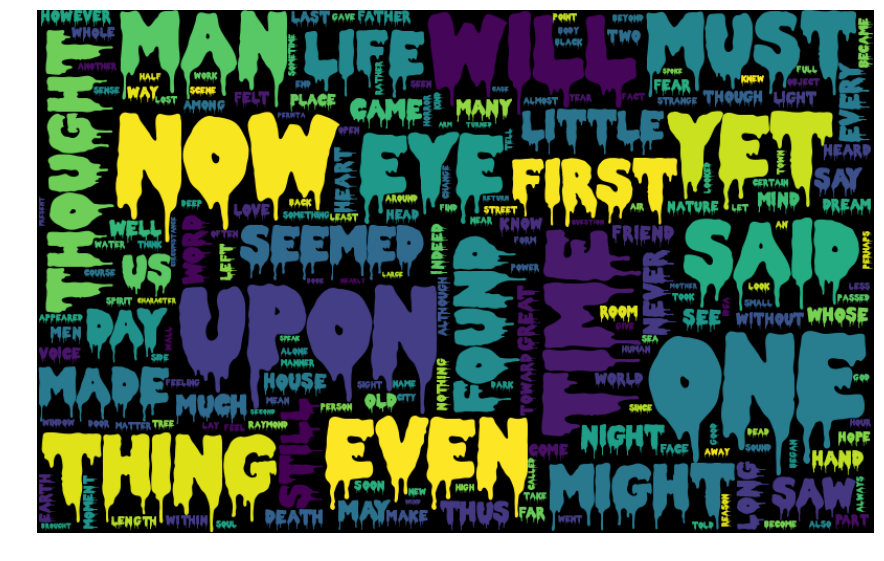

In [10]:
# Word cloud for entire training dataset
# default width=400, height=200
wordcloud = WordCloud(font_path='spooky_font.ttf', width=800, height=500,
                      random_state=21, max_font_size=110).generate(all_text)
plt.figure(figsize=(15, 12))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

## Wordcloud for Edgar Allen Poe
Now let's look at wordclouds for each individual author

In [11]:
# Grab all text that is written by Edgar Allen Poe
eap = train[train['Author'] == 'EAP']
eap_text = ' '.join(text for text in eap['Text'])
print('Number of words in eap_text:', len(eap_text))

Number of words in eap_text: 1131484


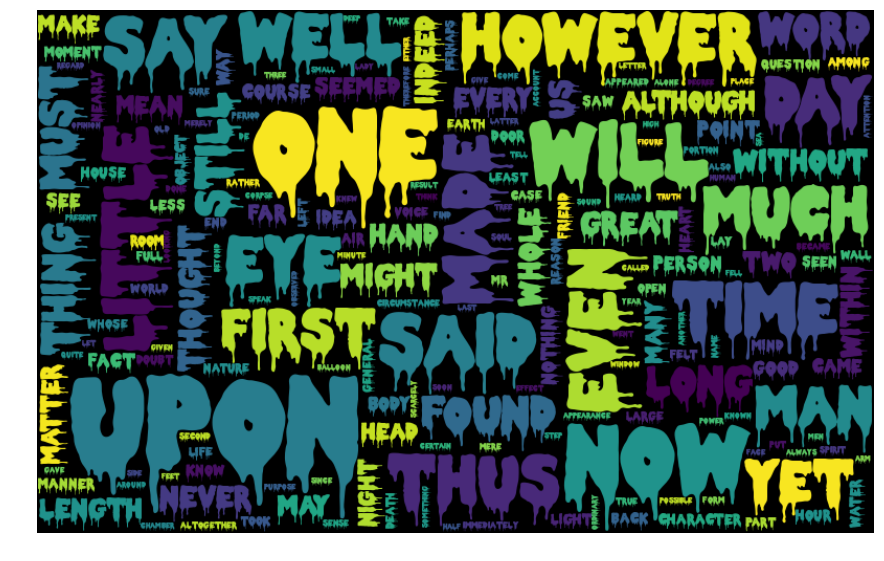

In [12]:
# Word cloud for entire training dataset
# default width=400, height=200
wordcloud = WordCloud(font_path='spooky_font.ttf', width=800, height=500,
                      random_state=21, max_font_size=110).generate(eap_text)
plt.figure(figsize=(15, 12))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

## Wordcloud for Mary Wollstonecraft Shelley

In [13]:
# Grab all text that is written by Mary Wollstonecraft Shelley
mws = train[train['Author'] == 'MWS']
mws_text = ' '.join(text for text in mws['Text'])
print('Number of words in eap_text:', len(mws_text))

Number of words in eap_text: 922675


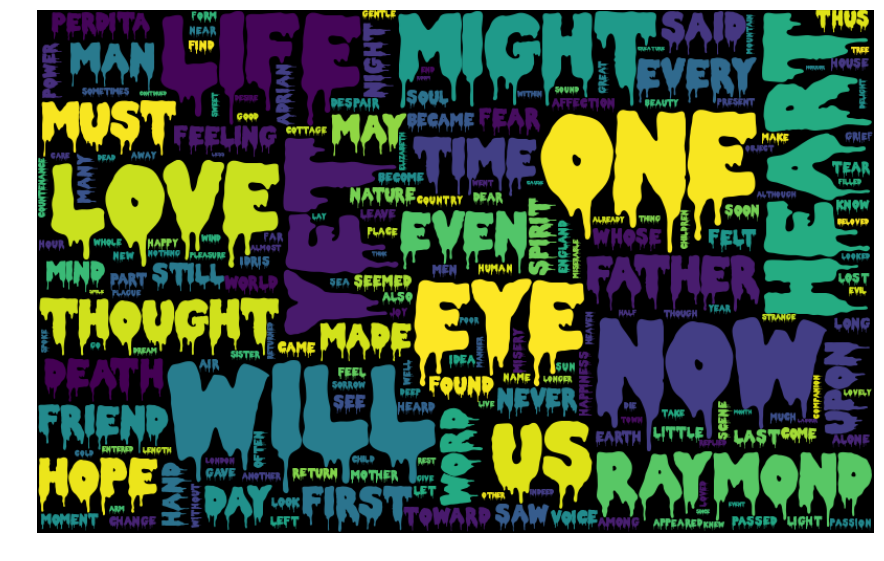

In [14]:
# Word cloud for entire training dataset
# default width=400, height=200
wordcloud = WordCloud(font_path='spooky_font.ttf', width=800, height=500,
                      random_state=21, max_font_size=110).generate(mws_text)
plt.figure(figsize=(15, 12))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

## Wordcloud for H.P. Lovecraft

In [15]:
# Grab all text that is written by H.P. Lovecraft
hpl = train[train['Author'] == 'HPL']
hpl_text = ' '.join(text for text in hpl['Text'])
print('Number of words in eap_text:', len(hpl_text))

Number of words in eap_text: 883812


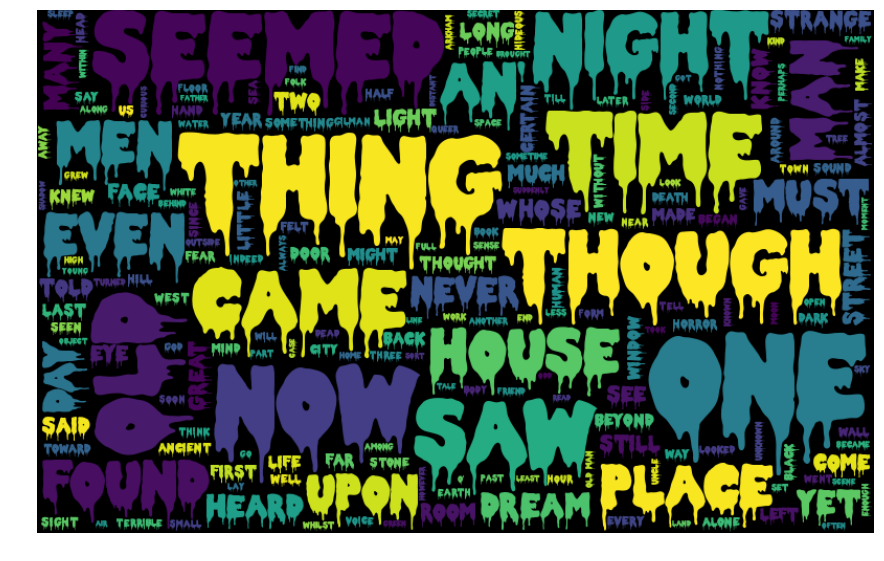

In [16]:
# Word cloud for H.P. Lovecraft
# default width=400, height=200
wordcloud = WordCloud(font_path='spooky_font.ttf', width=800, height=500,
                      random_state=21, max_font_size=110).generate(hpl_text)
plt.figure(figsize=(15, 12))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

# Text Preprocessing with spaCy
---
I decided to use spaCy for this text preprocessing stage because it has built-in word vectors that can be easily accessed and fed into a neural network. SpaCy is an industrial-strength natural language processing python library ([spacy.io]()). The built-in word vectors are 300-dimensional vectors trained on the Common Crawl corpus using the [GloVe algorithm](https://nlp.stanford.edu/projects/glove/). Because there are a lot of text examples in the training set, I use spaCy's pipeline feature to process 500 samples at a time, grab their word vectors, and format them into numpy arrays.

**Update (12/1/17):** SpaCy was recently updated to version 2.0.3 where the vector attribute for "en_core_web_sm" is now 384 dimensions. "en_core_web_sm" is a smaller version of the English model and contains context word vectors. "en_core_web_md" contains 300-dimensional word vectors which are GloVe vectors trained on common crawl. This is more similar to how the word vectors we used in the older version of spaCy. The vector attribute is defined as: "A real-valued meaning representation. Defaults to an average of the token vectors." from [spaCy documentation](https://spacy.io/api/doc).

Currently Kaggle only has "en_core_web_sm" model available to load so we can only get the context vectors instead of the GloVe vectors.

In [17]:
import spacy

nlp = spacy.load('en_core_web_sm')

First we clean up the text by lemmatizing the words and removing personal pronouns (in spaCy the lemmatized string of personal pronouns is '-PRON-'), stopwords, and punctuations.

In [18]:
# Clean text before feeding it to spaCy
punctuations = string.punctuation

# Define function to cleanup text by removing personal pronouns, stopwords, and puncuation
def cleanup_text(docs, logging=False):
    texts = []
    counter = 1
    for doc in docs:
        if counter % 1000 == 0 and logging:
            print("Processed %d out of %d documents." % (counter, len(docs)))
        counter += 1
        doc = nlp(doc, disable=['parser', 'ner'])
        tokens = [tok.lemma_.lower().strip() for tok in doc if tok.lemma_ != '-PRON-']
        tokens = [tok for tok in tokens if tok not in stopwords and tok not in punctuations]
        tokens = ' '.join(tokens)
        texts.append(tokens)
    return pd.Series(texts)

## Plot most frequently occuring words for each author
---
1. Grab all the words for each author and put them all in a list (eap_text, hpl_text, mws_text).
2. Clean the text using cleanup_text funtion. It removes stopwords, punctuation, and makes all words lowercase.
3. Remove **'s** from all text because spaCy doesn't remove this contraction when lemmatizing words for some reason.
4. Count occurances of all words and plot 25 most common words for each author using seaborn (also use a spooky style).

In [19]:
# Grab all text associated with Edgar Allen Poe
eap_text = [text for text in train[train['Author'] == 'EAP']['Text']]

# Grab all text associated with H.P. Lovecraft
hpl_text = [text for text in train[train['Author'] == 'HPL']['Text']]

# Grab all text associated with Mary Wollstonecraft Shelley
mws_text = [text for text in train[train['Author'] == 'MWS']['Text']]

# Clean up all text
eap_clean = cleanup_text(eap_text)
eap_clean = ' '.join(eap_clean).split()
# 's appears a lot in the text, so we get rid of it since it's not a word
eap_clean = [word for word in eap_clean if word != '\'s']

hpl_clean = cleanup_text(hpl_text)
hpl_clean = ' '.join(hpl_clean).split()
# 's appears a lot in the text, so we get rid of it since it's not a word
hpl_clean = [word for word in hpl_clean if word != '\'s']

mws_clean = cleanup_text(mws_text)
mws_clean = ' '.join(mws_clean).split()
# 's appears a lot in the text, so we get rid of it since it's not a word
mws_clean = [word for word in mws_clean if word != '\'s']

# Count all unique words
eap_counts = Counter(eap_clean)
hpl_counts = Counter(hpl_clean)
mws_counts = Counter(mws_clean)

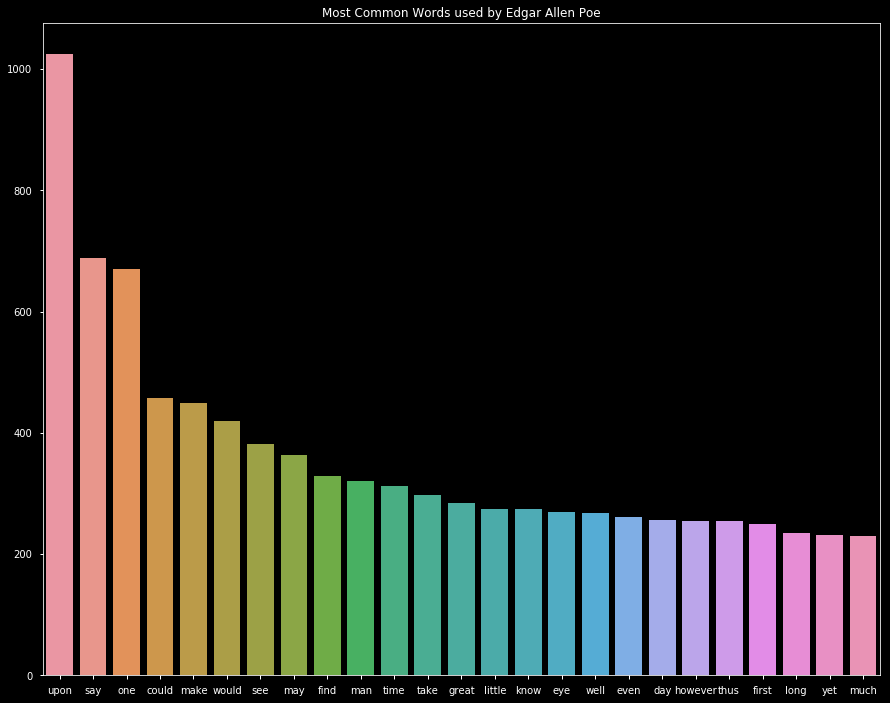

In [20]:
# Plot top 25 most frequently occuring words for Edgar Allen Poe
eap_common_words = [word[0] for word in eap_counts.most_common(25)]
eap_common_counts = [word[1] for word in eap_counts.most_common(25)]

# Use spooky background
plt.style.use('dark_background')
plt.figure(figsize=(15, 12))

sns.barplot(x=eap_common_words, y=eap_common_counts)
plt.title('Most Common Words used by Edgar Allen Poe')
plt.show()

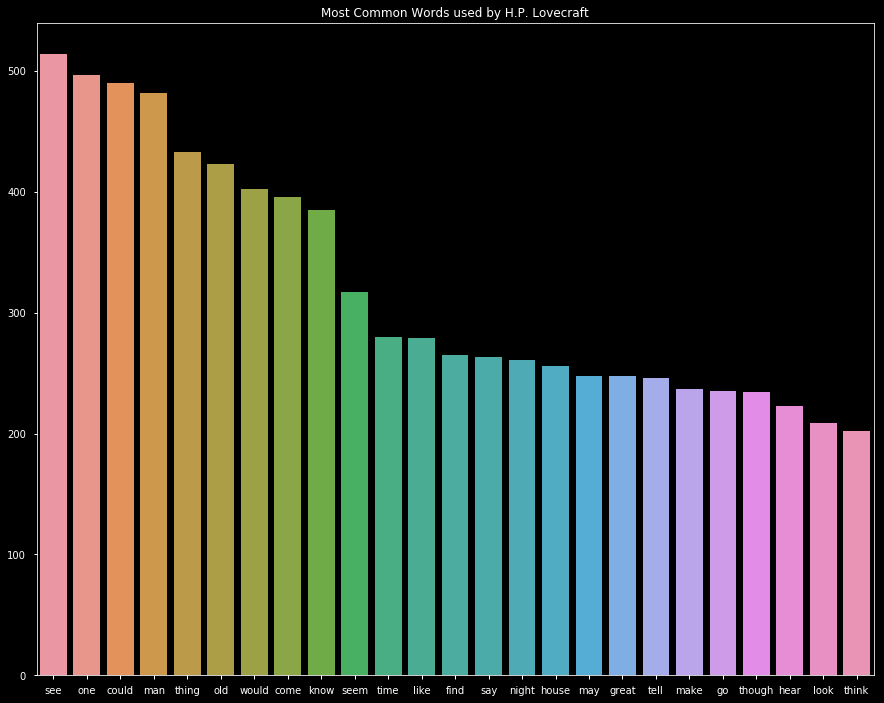

In [21]:
# Plot top 25 most frequently occuring words for H.P. Lovecraft
hpl_common_words = [word[0] for word in hpl_counts.most_common(25)]
hpl_common_counts = [word[1] for word in hpl_counts.most_common(25)]

plt.figure(figsize=(15, 12))
sns.barplot(x=hpl_common_words, y=hpl_common_counts)
plt.title('Most Common Words used by H.P. Lovecraft')
plt.show()

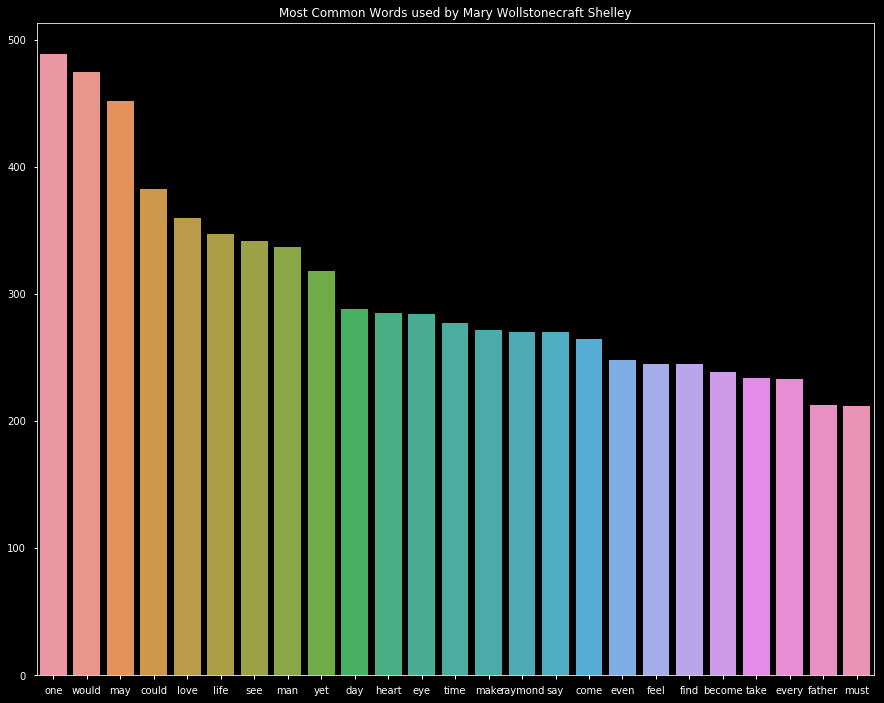

In [22]:
# Plot top 25 most frequently occuring words for Mary Wollstonecraft Shelley
mws_common_words = [word[0] for word in mws_counts.most_common(25)]
mws_common_counts = [word[1] for word in mws_counts.most_common(25)]

plt.figure(figsize=(15, 12))
sns.barplot(x=mws_common_words, y=mws_common_counts)
plt.title('Most Common Words used by Mary Wollstonecraft Shelley')
plt.show()

In [23]:
# See count list of all words
print(eap_counts.most_common(25))
print()
print(hpl_counts.most_common(25))
print()
print(mws_counts.most_common(25))

[('upon', 1025), ('say', 689), ('one', 671), ('could', 458), ('make', 450), ('would', 420), ('see', 381), ('may', 364), ('find', 328), ('man', 321), ('time', 313), ('take', 298), ('great', 284), ('little', 275), ('know', 274), ('eye', 270), ('well', 267), ('even', 261), ('day', 257), ('however', 254), ('thus', 254), ('first', 249), ('long', 235), ('yet', 232), ('much', 230)]

[('see', 514), ('one', 497), ('could', 490), ('man', 482), ('thing', 433), ('old', 423), ('would', 402), ('come', 396), ('know', 385), ('seem', 317), ('time', 280), ('like', 279), ('find', 265), ('say', 263), ('night', 261), ('house', 256), ('may', 248), ('great', 248), ('tell', 246), ('make', 237), ('go', 235), ('though', 234), ('hear', 223), ('look', 209), ('think', 202)]

[('one', 489), ('would', 475), ('may', 452), ('could', 383), ('love', 360), ('life', 347), ('see', 342), ('man', 337), ('yet', 318), ('day', 288), ('heart', 285), ('eye', 284), ('time', 277), ('make', 272), ('raymond', 270), ('say', 270), ('co

Now we will process all the training text together and grab the word vectors from each passage.

In [24]:
# Cleanup text and make sure it retains original shape
print('Original training data shape: ', train['Text'].shape)
train_cleaned = cleanup_text(train['Text'], logging=True)
print('Cleaned up training data shape: ', train_cleaned.shape)

Original training data shape:  (19579,)
Processed 1000 out of 19579 documents.
Processed 2000 out of 19579 documents.
Processed 3000 out of 19579 documents.
Processed 4000 out of 19579 documents.
Processed 5000 out of 19579 documents.
Processed 6000 out of 19579 documents.
Processed 7000 out of 19579 documents.
Processed 8000 out of 19579 documents.
Processed 9000 out of 19579 documents.
Processed 10000 out of 19579 documents.
Processed 11000 out of 19579 documents.
Processed 12000 out of 19579 documents.
Processed 13000 out of 19579 documents.
Processed 14000 out of 19579 documents.
Processed 15000 out of 19579 documents.
Processed 16000 out of 19579 documents.
Processed 17000 out of 19579 documents.
Processed 18000 out of 19579 documents.
Processed 19000 out of 19579 documents.
Cleaned up training data shape:  (19579,)


In [25]:
# Testing cell. Use for testing word vector dimensionality. Should be (384,)
# But when using pipe function word vectors are (128,) for some reason...
# te2 = nlp(train_cleaned[0])
# print(te2.vector.shape)
# for doc in nlp.pipe(train_cleaned[:5]):
#     print(doc.vector.shape)

Something I noticed in this new version of spaCy is that with that smaller english models there are some instances where there are no word vectors available. After cleaning the text there are some instances where there are no vectors available. The text with the following indices have no vector meaning their attribute "has_vector" is false: 477, 1023, 3601, 8654, and 9163. It also messes with our final vector shape so to fix this **if a text has no vector then we will fill it with zeros**. This is a quick and dirty fix until Kaggle supports an enligh model that has the GloVe vectors (*en_core_web_md*, *en_core_web_lg*, *en_vectors_web_lg*).

In [26]:
# Parse documents and print some info
print('Parsing documents...')

start = time()

train_vec = []
for doc in nlp.pipe(train_cleaned, batch_size=500):
    if doc.has_vector:
        train_vec.append(doc.vector)
    # If doc doesn't have a vector, then fill it with zeros.
    else:
        train_vec.append(np.zeros((128,), dtype="float32"))
        
# train_vec = [doc.vector for doc in nlp.pipe(train_cleaned, batch_size=500)]
train_vec = np.array(train_vec)

end = time()
print('Total time passed parsing documents: {} seconds'.format(end - start))
print('Total number of documents parsed: {}'.format(len(train_vec)))
print('Number of words in first document: ', len(train['Text'][0]))
print('Number of words in second document: ', len(train['Text'][1]))
print('Size of vector embeddings: ', train_vec.shape[1])
print('Shape of vectors embeddings matrix: ', train_vec.shape)

Parsing documents...
Total time passed parsing documents: 250.60495328903198 seconds
Total number of documents parsed: 19579
Number of words in first document:  231
Number of words in second document:  71
Size of vector embeddings:  128
Shape of vectors embeddings matrix:  (19579, 128)


Now that we created *train_vec* we are ready to feed it into a deep learning model. You can skip down to the section titled "One-Hot Encode Labels." The next section tries a different approach to creating word vectors by using Word2Vec.

# Alternate Approach using Word2Vec
---
Instead of simply grabbing the word vectors using spacy, let's try training a word2vec model on all our text and creating custom word embeddings from that model. Word2Vec also benefits from having stopwords because they give context to the sentences. Therefore we will instead modify our above function "cleanup_text"  and create a new function called "cleanup_text_word2vec" to not remove stopwords as well as include personal pronouns. Word2Vec expects a list of sentences where the sentences are lists of words so we will modify the function to do that as well.

In [27]:
# First combine train and test text into one dataframe to make parsing text easier
all_text = np.concatenate((train['Text'], test['Text']), axis=0)
all_text = pd.DataFrame(all_text, columns=['Text'])
print('Number of total text documents:', len(all_text))

Number of total text documents: 27971


In [28]:
# Define function to preprocess text for a word2vec model
def cleanup_text_word2vec(docs, logging=False):
    sentences = []
    counter = 1
    for doc in docs:
        if counter % 1000 == 0 and logging:
            print("Processed %d out of %d documents" % (counter, len(docs)))
        # Disable tagger so that lemma_ of personal pronouns (I, me, etc) don't getted marked as "-PRON-"
        doc = nlp(doc, disable=['tagger'])
        # Grab lemmatized form of words and make lowercase
        doc = " ".join([tok.lemma_.lower() for tok in doc])
        # Split into sentences based on punctuation
        doc = re.split("[\.?!;] ", doc)
        # Remove commas, periods, and other punctuation (mostly commas)
        doc = [re.sub("[\.,;:!?]", "", sent) for sent in doc]
        # Split into words
        doc = [sent.split() for sent in doc]
        sentences += doc
        counter += 1
    return sentences

In [29]:
train_cleaned_word2vec = cleanup_text_word2vec(all_text['Text'], logging=True)
print('Cleaned up training data size (i.e. number of sentences): ', len(train_cleaned_word2vec))

Processed 1000 out of 27971 documents
Processed 2000 out of 27971 documents
Processed 3000 out of 27971 documents
Processed 4000 out of 27971 documents
Processed 5000 out of 27971 documents
Processed 6000 out of 27971 documents
Processed 7000 out of 27971 documents
Processed 8000 out of 27971 documents
Processed 9000 out of 27971 documents
Processed 10000 out of 27971 documents
Processed 11000 out of 27971 documents
Processed 12000 out of 27971 documents
Processed 13000 out of 27971 documents
Processed 14000 out of 27971 documents
Processed 15000 out of 27971 documents
Processed 16000 out of 27971 documents
Processed 17000 out of 27971 documents
Processed 18000 out of 27971 documents
Processed 19000 out of 27971 documents
Processed 20000 out of 27971 documents
Processed 21000 out of 27971 documents
Processed 22000 out of 27971 documents
Processed 23000 out of 27971 documents
Processed 24000 out of 27971 documents
Processed 25000 out of 27971 documents
Processed 26000 out of 27971 docum


Now we can create our Word2Vec model and train it using our sentences. Here we define the parameters for Word2Vec:
* size: Word vector dimensionality size is 300
* window: Maximum distance between center word and predicted word in a sentence
* min_count: Ignore all words that appear with less frequency than this
* workers: Use this many workers to train model. Leads to faster training on multi-core machines
* sg: Define archetecture. 1 for skip-gram, 0 for continouous bag of words (CBOW).
   * CBOW is faster but skip-gram gives better performance

In [30]:
from gensim.models.word2vec import Word2Vec

text_dim = 300
print("Training Word2Vec model...")
wordvec_model = Word2Vec(train_cleaned_word2vec, size=text_dim, window=5, min_count=3, workers=4, sg=1)
print("Word2Vec model created.")
print("%d unique words represented by %d dimensional vectors" % (len(wordvec_model.wv.vocab), text_dim))

Training Word2Vec model...
Word2Vec model created.
10771 unique words represented by 300 dimensional vectors


Now that we trained our model we can use some built-in functions to evaluate our model. However just because this may or may not give good answers doesn't necessarily mean it will give a good performance on our end application. Either way it is useful to see the semantic relationships the model has learned.

In [31]:
print(wordvec_model.wv.most_similar(positive=['woman', 'king'], negative=['man']))
print(wordvec_model.wv.most_similar_cosmul(positive=['woman', 'king'], negative=['man']))
print(wordvec_model.wv.doesnt_match("breakfast cereal dinner lunch".split()))
print(wordvec_model.wv.similarity('woman', 'man'))
print(wordvec_model.wv.similarity('gruesome', 'terrify'))

[('daughter', 0.8161669373512268), ('mother', 0.8108386397361755), ('harris', 0.8069223761558533), ('young', 0.8061871528625488), ('girl', 0.8017628192901611), ('greek', 0.8007651567459106), ('son', 0.7981652617454529), ('queen', 0.7967760562896729), ('favourite', 0.7960222959518433), ('eldest', 0.7929278016090393)]
[('daughter', 1.0718793869018555), ('mother', 1.0601712465286255), ('girl', 1.0497698783874512), ('young', 1.0491396188735962), ('harris', 1.0472640991210938), ('queen', 1.044880747795105), ('favourite', 1.0432798862457275), ('son', 1.042046308517456), ('greek', 1.0408631563186646), ('eldest', 1.0384526252746582)]
dinner
0.729983064997
0.851220710784


We no longer need *train_cleaned_word2vec* anymore because that was only for training the Word2Vec model. Now we can use the original *train_cleaned* variable that removed stopwords. The Word2Vec model can give us a 300 dimensional vector for individual words so we need a way to represent a text example that has multiple words in it in just 300 dimensions. One way of doing that is to average the word vectors for each word in a text example. 

For intance (first training text cleaned): **process afford mean ascertain dimension dungeon make circuit return point set aware fact perfectly uniform wall**

We need to add up the word vectors for each word (process + afford + mean + ...) and divide by the number of words in this example (16). But if there is no word vector in our model for a given word then we ignore it.

In [32]:
# Define function to create word vectors given a cleaned piece of text.
def create_average_vec(doc):
    average = np.zeros((text_dim,), dtype='float32')
    num_words = 0.
    for word in doc.split():
        if word in wordvec_model.wv.vocab:
            average = np.add(average, wordvec_model[word])
            num_words += 1.
    if num_words != 0.:
        average = np.divide(average, num_words)
    return average

Here we run into a problem. After cleaning up the text there are some text pieces that end up having no words in them at all! This means that the entire text is composed of stopwords. Here is an example:

train['Text'][477] = 'After all, what is it?'

After lemmatizing each word with spaCy, every word is part of nltk's stopword list and get completely cleaned out by our *cleanup_text* function. Also when we try to use the *create_average_vec* function on a text example with no words in it then we just get a 300 dimensional vector of zeros. Fortunately this only occurs 5 times in the text so for now we will ignore it and see how well our model performs but in the future we may want to find a way to better represent text filled with stopwords.

In [33]:
# Counting the number of empty strings are in train_cleaned
count = 0
for i in range(len(train_cleaned)):
    if train_cleaned[i] == "":
        print("index:", i)
        count += 1
print(count)

index: 477
index: 1023
index: 3601
index: 8654
4


In [34]:
# Create word vectors
train_cleaned_vec = np.zeros((train.shape[0], text_dim), dtype="float32")  # 19579 x 300
for i in range(len(train_cleaned)):
    train_cleaned_vec[i] = create_average_vec(train_cleaned[i])

print("Train word vector shape:", train_cleaned_vec.shape)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys


Train word vector shape: (19579, 300)


# One-Hot Encode Labels
Now we should one hoe encode the labels. We can do so using sci-kit learn's label_binarize function

In [35]:
from sklearn.preprocessing import label_binarize

# Transform labels into one hot encoded format.
y_train_ohe = label_binarize(train['Author'], classes=['EAP', 'HPL', 'MWS'])
print('y_train_ohe shape: {}'.format(y_train_ohe.shape))
print('y_train_ohe samples:')
print(y_train_ohe[:5])

y_train_ohe shape: (19579, 3)
y_train_ohe samples:
[[1 0 0]
 [0 1 0]
 [1 0 0]
 [0 0 1]
 [0 1 0]]


# Split into Train/Test Datasets
To avoid building a model that performs well ONLY on the test set we carve out a new train/test set using the training set provided by Kaggle. This way we can do parameter tuning, try different preprocessing methods, etc and calculate a log loss score without submitting to Kaggle. Now we don't have to worry about building a model that performs well for the Kaggle-provided test set but doesn't generalize to new examples.

In [36]:
from sklearn.model_selection import train_test_split

# If using spaCy word vectors
# X_train, X_test, y_train, y_test = train_test_split(train_vec, y_train_ohe, test_size=0.2, random_state=21)
# If using Word2Vec word vectors
X_train, X_test, y_train, y_test = train_test_split(train_cleaned_vec, y_train_ohe, test_size=0.2, random_state=21)

print('X_train size: {}'.format(X_train.shape))
print('X_test size: {}'.format(X_test.shape))
print('y_train size: {}'.format(y_train.shape))
print('y_test size: {}'.format(y_test.shape))

X_train size: (15663, 300)
X_test size: (3916, 300)
y_train size: (15663, 3)
y_test size: (3916, 3)


# Deep Learning with Keras
---
Here we define our neural network using [keras](http://keras.io/) which is a deep learning python library. The architecture below is a multilayer perceptron with four hidden layers, relu activation function, and he normal kernel initialization. We also include four dropout layers to avoid overfitting.

In [37]:
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Input, LSTM, Embedding, Bidirectional, Flatten
from keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D
from keras.optimizers import SGD

def build_model(architecture='mlp'):
    model = Sequential()
    if architecture == 'mlp':
        # Densely Connected Neural Network (Multi-Layer Perceptron)
        model.add(Dense(512, activation='relu', kernel_initializer='he_normal', input_dim=300))
        model.add(Dropout(0.2))
        model.add(Dense(512, activation='relu', kernel_initializer='he_normal'))
        model.add(Dropout(0.2))
        model.add(Dense(512, activation='relu', kernel_initializer='he_normal'))
        model.add(Dropout(0.2))
        model.add(Dense(512, activation='relu', kernel_initializer='he_normal'))
        model.add(Dropout(0.2))
        model.add(Dense(3, activation='softmax'))
    elif architecture == 'cnn':
        # 1-D Convolutional Neural Network
        inputs = Input(shape=(300,1))

        x = Conv1D(64, 3, strides=1, padding='same', activation='relu')(inputs)

        #Cuts the size of the output in half, maxing over every 2 inputs
        x = MaxPooling1D(pool_size=2)(x)
        x = Conv1D(128, 3, strides=1, padding='same', activation='relu')(x)
        x = GlobalMaxPooling1D()(x) 
        outputs = Dense(3, activation='softmax')(x)

        model = Model(inputs=inputs, outputs=outputs, name='CNN')
    elif architecture == 'lstm':
        # LSTM network
        inputs = Input(shape=(300,1))

        x = Bidirectional(LSTM(64, return_sequences=True),
                          merge_mode='concat')(inputs)
        x = Dropout(0.2)(x)
        x = Flatten()(x)
        outputs = Dense(3, activation='softmax')(x)

        model = Model(inputs=inputs, outputs=outputs, name='LSTM')
    else:
        print('Error: Model type not found.')
    return model

Using TensorFlow backend.
/opt/conda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [38]:
# Define keras model
# Using MLP in kernel for speed
model = build_model('mlp')
# model = build_model('cnn')
# model = build_model('lstm')

# If the model is a CNN then expand the dimensions of the training data
if model.name == "CNN" or model.name == "LSTM":
    X_train = np.expand_dims(X_train, axis=2)
    X_test = np.expand_dims(X_test, axis=2)
    print('Text train shape: ', X_test.shape)
    print('Text test shape: ', X_test.shape)
    
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               154112    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               262656    
__________

In [39]:
# Compile the model
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['acc'])

Now we train the model on our train/test set and also include change the parameter 'val_split' to 0.2 which takes 20% of the training data and turns it into a validation set.

In [40]:
# Define number of epochs
epochs = 50

# Fit the model to the training data
estimator = model.fit(X_train, y_train,
                      validation_split=0.2,
                      epochs=epochs, batch_size=128, verbose=1)

Train on 12530 samples, validate on 3133 samples
Epoch 1/50
12530/12530 [==============================] - 4s 312us/step - loss: 0.9988 - acc: 0.4903 - val_loss: 0.8156 - val_acc: 0.6441
Epoch 2/50
12530/12530 [==============================] - 4s 294us/step - loss: 0.7666 - acc: 0.6683 - val_loss: 0.6966 - val_acc: 0.7131
Epoch 3/50
12530/12530 [==============================] - 4s 295us/step - loss: 0.7022 - acc: 0.7034 - val_loss: 0.6928 - val_acc: 0.7124
Epoch 4/50
12530/12530 [==============================] - 4s 296us/step - loss: 0.6838 - acc: 0.7169 - val_loss: 0.6690 - val_acc: 0.7249
Epoch 5/50
12530/12530 [==============================] - 4s 309us/step - loss: 0.6738 - acc: 0.7191 - val_loss: 0.6617 - val_acc: 0.7312
Epoch 6/50
12530/12530 [==============================] - 4s 296us/step - loss: 0.6655 - acc: 0.7231 - val_loss: 0.6855 - val_acc: 0.7229
Epoch 7/50
12530/12530 [==============================] - 4s 303us/step - loss: 0.6591 - acc: 0.7268 - val_loss: 0.6696 - v

In [41]:
print("Training accuracy: %.2f%% / Validation accuracy: %.2f%%" % 
      (100*estimator.history['acc'][-1], 100*estimator.history['val_acc'][-1]))

Training accuracy: 76.05% / Validation accuracy: 73.86%


Now we can plot the model's accuracy and loss over epochs

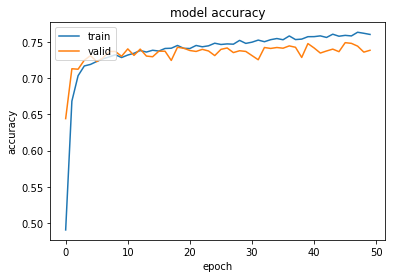

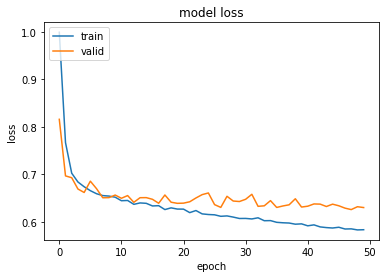

In [42]:
# Plot model accuracy over epochs
sns.reset_orig()   # Reset seaborn settings to get rid of black background
plt.plot(estimator.history['acc'])
plt.plot(estimator.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

# Plot model loss over epochs
plt.plot(estimator.history['loss'])
plt.plot(estimator.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

## Using spaCy word vectors
---
**For MLP architecture:** From the plot above we can see the model starts to overfit the training data early around the fifth epoch. The validation accuracy stays stable for the rest of the training and the loss goes up as training goes on.

**For CNN architecture:** Both the training and validation accuracy go up as training goes on. The loss also goes down continuously. With more epochs the loss would probably continue to go down until eventually saturating. Some more parameter tweaking and could also lead to a lower log loss score.

** For LSTM architecture:** The training accuracy is 58.90% and the validation accuracy is 58.60%. From the model accuracy plot above we can see both accuracies rise and continue to rise until the final epoch. The model losses also go down continuously indicating that more epochs will lead to a better performance. 

## Using Word2Vec word vectors
---
**For MLP architecture:** The training and validation accuracies are bigger than previous attempts using spaCy's built-in word vectors. The log loss also goes down further but near the end the validation loss looks like it isn't going any lower while the training loss goes lower. It seems like training over more epochs will lead to overfitting. The training accuracy is 76.26% and the validation accuracy is 74.08%.

**For CNN architecture:** The training and validation accuracies (72.64%, 70.89% respectively) are smaller than the MLP architecture. It also looks like the loss isn't going to go any lower with more epochs. Hyperparameter tuning and adding more layers may help to increase the accuracies and lower the loss.

** For LSTM architecture:** The training and validation accuracies are smaller than the CNN and MLP architectures, but higher than the LSTM accuracies without Word2Vec. Training accuracy was 70.91% and validation accuracy was 69.81%. Looking at the plot above the validation loss starts to even out so more epochs likely won't improve performance.

Now it's time to make predictions!

In [43]:
# Make predictions
predicted_prob = model.predict(X_test)
print(predicted_prob.shape)

(3916, 3)


In [44]:
# Save submission file
with open('submission.csv', 'w') as file_obj:
    file_obj.write('ID,EAP,HPL,MWS\n')
    for pred in range(len(predicted_prob)):
        file_obj.write(str(pred+1) + ',' + ','.join('{:.2f}'.format(s) for s in predicted_prob[pred].tolist()) + '\n')

In [45]:
# Report log loss and score
loss_sk = log_loss(y_test, predicted_prob)
print('Log loss is: {}'.format(loss_sk))

Log loss is: 0.6209915728758553


## Using spaCy word vectors
---
The log loss for the **MLP architecture** is about 1.1416 which is not too bad, but can definitely be improved with parameter tweaking (number of neurons, number of layers, kernel initialization, dropout rate, etc.).

Meanwhile the log loss for the **CNN architecture** is about 0.952 and is an improvement over the basic MLP architecture. Again, parameter tweaking will probably lead to better results and although CNNs perform well on computer vision problems they also have a lot of uses in natural language processing.

However a lot of times recurrent neural networks (RNN), in particular long short term memory (LSTM), produce the best results. Using a **LSTM architecture**, the model acheived a log loss score of 0.9303. This is the best score out of all three architectures. This was also using only one hidden layer which was a bidirectional lstm layer with 64 memory units. Adding more memory units and layers and tweaking the dropout rate will probably lead to better results. Increasing the number of epochs will also lead to better results however it will increase the training time.

## Using Word2Vec word vectors
---
The log loss using a **MLP architecture** is 0.60657. Using Word2Vec to create the word vectors greatly improved performance. I did not change any of the hyperparameters for the MLP neural net, I used the same one I used when using spaCy word vectors. Even with some text examples having all zero word vectors (because filtering out stopwords left an empty string) it seemed to work well.

The log loss using a **CNN architecture** is 0.68087. While it is smaller than the CNN architecture without Word2Vec, it is a little higher than the MLP architecture above. Hyperparameter tuning and possibly adding more hidden layers could help increase performance.

The log loss using a **LSTM architecture** is 0.711138. This is the highest log loss out of all our architectures using Word2Vec word vectors. This is surprising since LSTM gave us the best performance when using spaCy's built-in word vectors. One reason could be that the MLP is "deeper" than the LSTM. Our MLP has 4 hidden layers while the LSTM one has only 1 (with a bidirectional wrapper). Something that I will try soon is to increase the layers of our LSTM model and see if that can improve performance, although I think I will get rid of the bidirectional wrapper because I noticed it trains slightly faster without it.

|        | spaCy Word Vectors (GloVe) | Word2Vec  |
| :-------------: |:-------------:| :-----:        |
| MLP      | 1.1416            | **0.60657** |
| CNN     | 0.952            | 0.68087.        |
| LSTM   | **0.9303**  | 0.711138         |

Here are some useful links to learn more about neural networks and their uses for natural language processing:

*Primer on nerual networks and NLP:* https://arxiv.org/abs/1510.00726

*Understanding LSTM networks:* http://colah.github.io/posts/2015-08-Understanding-LSTMs/